<a href="https://colab.research.google.com/github/AlirezaPNouri/BERTEmbedding/blob/main/FebVersionOfBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Alireza Nouri

Supervisor: prof. Mahmud Shahriar Hossain

database source: https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/5KArticles.csv

This is the version that I modified and optimized for my research.

02/ 07/ 2022

In [1]:
#install needed packages
!pip install transformers
!pip install wget
!pip install statistics

In [2]:
# libraries that are needed to import
import os
import time
import datetime
import sys
import random
import requests
import pickle
import string
import pandas as pd
import numpy as np
from numpy import median, array, exp
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer

In [3]:
# All configs are here
MAX_DATA = 1000 # the maximum data that is extracted from the dataset
max_length = 256 # maximum number of tokens in a document (Bert input)
batch_size = 16 # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
epochs = 20 # Number of training epochs (authors recommend between 2 and 4)
seed_val = 42 # Set the seed value all over the place to make this reproducible.
Max_Feature_Size = 20  ## ignore the features after this number
number_of_test_data = 100 # number of data in testing phase
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']
jump = 3 # jump size for gradient decent
range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
doc_num = 8 # document number for experiiments
threshold_cluster_overlapping = 0.8 # the after jaccard index that we use to consider two clusters are overlapping 

In [72]:
# Function to remove stopwords
def stop_word_remover(list1, stopwords):
  new_list = list()
  for word in list1:
    if word not in stopwords:
      new_list.append(word)
  return new_list
############################################################################  
#function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return len(unique_list)
############################################################################  
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
############################################################################
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
############################################################################
#Function to find similarities
def find_similar(embedding_layers, word_index, original_sentence):
  score_dic = dict()
  print(len(original_sentence))
  for j in range(1, min(256, len(original_sentence))):
    score_dic[original_sentence[j -1]] =  cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]
    # print('word is {}, score is {}'.format(original_sentence[j -1], cosine_similarity([embedding_layers[word_index].to('cpu').numpy()], [embedding_layers[j].to('cpu').numpy()])[0][0]))
  return score_dic
############################################################################
# show th t-SNE for the tokens
def tsne_plot(sentences, output):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, embed in zip(sentences, output):
        tokens.append(embed)
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
############################################################################
# Jaccard index function
def jaccard_similarity(text1_list, text2_list):
  a = set(text1_list)
  b = set(text2_list)
  return len(a.intersection(b))/len(a.union(b))
############################################################################
#function to normalize a vector
def normalizer_value(list_):
    temp_list = list()
    for vec in list_[2]:
        value = int(99* ((vec[1] - list_[1]) / (list_[0] - list_[1])) + 1)
        temp_list.append([vec[0],value])
    return temp_list

In [5]:
# to check if the GPU is ready to use

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# to tell pytorch that we are going to use GPU

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
# download the dataset as a zip file from the git repo
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://raw.githubusercontent.com/AlirezaPNouri/BERTEmbedding/main/5KArticles.csv'
res = requests.get(url, allow_redirects=True)
with open('small_dataset_NYT.csv','wb') as file:
    file.write(res.content)
print('Download is done!')

Download is done!


In [7]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/small_dataset_NYT.csv", header= None, skiprows=1)
print('The original size of dataset is {}'.format(df.shape))
df = df.dropna(how='any', axis=0)

df = df[0:MAX_DATA][[1, 2]]
# Report the number of sentences.
print('Number of training sentences extracted from dataset is {:,}\n'.format(df.shape[0]))
# Display 10 random rows from the data.
df.sample(10)

df.columns = ['id', 'content']
print('Columns are : {}'.format([name for name in df.columns]))
print('The dimension of the dataset is {}'.format(df.shape))
print(df.sample)

The original size of dataset is (5001, 3)
Number of training sentences extracted from dataset is 1,000

Columns are : ['id', 'content']
The dimension of the dataset is (1000, 2)
<bound method NDFrame.sample of                    id                                            content
0    19900101_0000000  HURRYING through the tunnel at Veterans Stadiu...
1    19900101_0000001  FOR six years, American corporations have been...
2    19900101_0000002  Alcide Chaisson, who is 69 years old and lives...
3    19900101_0000003  Gary Anderson is the third-most accurate kicke...
4    19900101_0000004  The National Bank of Poland is devaluing the P...
..                ...                                                ...
995  19900111_0000997  The greeting card giant Hallmark Cards Inc. sa...
996  19900111_0000998  The police detained 15,000 people today in a s...
997  19900111_0000999  The American retailing operations of the Campe...
998  19900111_0001000  The Ralston Purina Company said it wo

In [8]:
# find the number of classes in the dataset based on the index 7 of their timestamp
sentences = df.content.values
labels = df.id.values
# print(labels)
labels = [int(d[7]) for d in labels]
# print(labels)
class_num = unique(labels)
print('The numeber of classes is {}'.format(class_num))
print('length of data is {} and length of labels is {}'.format(len(sentences), len(labels)))
print('labels are : ', labels)

The numeber of classes is 10
length of data is 1000 and length of labels is 1000
labels are :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [9]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [10]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  HURRYING through the tunnel at Veterans Stadium, the Los Angeles Rams' left guard, Tom Newberry, yelled, ''Warm-weather California sissies, huh?'' With a grin he disappeared into the locker room to calmly celebrate a 21-7 wild-card victory over the Philadelphia Eagles in a cold raw rain, which qualified the Rams to go against the Giants next Sunday at Giants Stadium in the Super Bowl XXIV tournament. But until yesterday, the Rams had always played like warm-weather California sissies in cold-weather playoff games. Until yesterday, the Rams were 0-9 in cold-weather playoff games since the franchise moved to Los Angeles from Cleveland more than four decades ago. In that time, Ram teams lost three outdoor playoff games in Minnesota (plus one in the warmth of the Metrodome a year ago), two in Washington, and one each in Cleveland, Detroit, Green Bay and Chicago. ''I'm tired of being a weatherman; if I get fired, I'm going right to the news,'' John Robinson, the Rams' coach, joke

In [11]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to us

In [12]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [13]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = class_num, # The number of output labels--2 for binary classification. # here temp is the size of the dataset
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [15]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
#Check the variables size in the memory
local_vars = list(locals().items())
for var, obj in local_vars:
  temp = sys.getsizeof(obj)
  if temp >100000:
    print(var, temp/1000000, 'MB')

df 3.949116 MB


In [17]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    embedding_layers = []
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        print(batch[2].shape)
        print(batch[1].shape)
        print(batch[0].shape)
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        # print(len(outputs))
        # print(outputs[0]) the loss
        # print(len(outputs[1])) the batches
        # print(len(outputs[2])) the embedding layers
        # import numpy as np
        # print(np.shape(outputs[2]))--->(13,)
        # print(np.shape(outputs[2][1])) --->torch.Size([32, 64, 768]) the embedding in the layer one
        # print(np.shape(outputs[2][2]))--->torch.Size([32, 64, 768]) the embedding in the layer two
        # print(len(outputs[2][3]))
        loss = outputs[0]
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 20 ========
Training...
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
to

In [18]:
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print(  "")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    #count = 0 # added by Ali
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        
        logits = outputs[0]
        # print(len(outputs))
        # print(np.shape(outputs[1])) # all embedding layers data
        # print(outputs[1][12]) # access to embedding vectors in layer 13
        #count +=1 added by Ali

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    #print(count)
print("")
print("Training complete!")


Running Validation...
  Accuracy: 0.20
  Validation took: 0:00:01

Training complete!


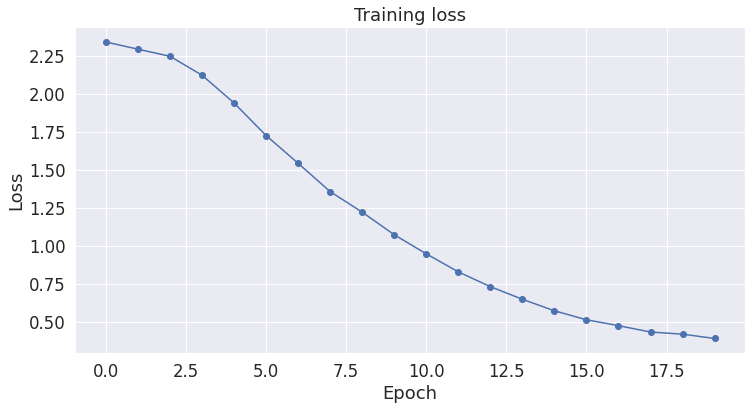

In [19]:
% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [21]:
print('maximum length is ', MAX_LEN)
print('size of testing data is ', df.shape)
print('Number of testing data is ', len(sentences))
print('shape of embedding is ', input_ids.shape)
print('number of labels is ', len(labels))

maximum length is  256
size of testing data is  (100, 2)
Number of testing data is  100
shape of embedding is  (100, 256)
number of labels is  100


In [20]:
#the same as the maxlen we used in the encoder_plus function
MAX_LEN = max([len(sen) for sen in input_ids])

# Load the dataset into a pandas dataframe.
# df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = df[0:number_of_test_data]
sentences = sentences[0:number_of_test_data]
labels = labels[0:number_of_test_data]
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
# sentences = new_df.text.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = number_of_test_data  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (1281 > 512). Running this sequence through the model will result in indexing errors


Number of test sentences: 100



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [22]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  print('np.shape(outputs[0]) ', np.shape(outputs[0]))
  print('np.shape(outputs[1][0]) ', np.shape(outputs[1][0]))
  print('np.shape(outputs[1][1]) ', np.shape(outputs[1][1]))
  print('np.shape(outputs[1][12]) ', np.shape(outputs[1][12]))

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 100 test sentences...
np.shape(outputs[0])  torch.Size([100, 10])
np.shape(outputs[1][0])  torch.Size([100, 256, 768])
np.shape(outputs[1][1])  torch.Size([100, 256, 768])
np.shape(outputs[1][12])  torch.Size([100, 256, 768])
    DONE.


In [23]:
last_layer = outputs[1][12] # the last layer of hidden layers
# print out all the sentences
c = 0
for doc in sentences:
  print('doc {}:'.format(c), doc)
  c += 1

doc 0: HURRYING through the tunnel at Veterans Stadium, the Los Angeles Rams' left guard, Tom Newberry, yelled, ''Warm-weather California sissies, huh?'' With a grin he disappeared into the locker room to calmly celebrate a 21-7 wild-card victory over the Philadelphia Eagles in a cold raw rain, which qualified the Rams to go against the Giants next Sunday at Giants Stadium in the Super Bowl XXIV tournament. But until yesterday, the Rams had always played like warm-weather California sissies in cold-weather playoff games. Until yesterday, the Rams were 0-9 in cold-weather playoff games since the franchise moved to Los Angeles from Cleveland more than four decades ago. In that time, Ram teams lost three outdoor playoff games in Minnesota (plus one in the warmth of the Metrodome a year ago), two in Washington, and one each in Cleveland, Detroit, Green Bay and Chicago. ''I'm tired of being a weatherman; if I get fired, I'm going right to the news,'' John Robinson, the Rams' coach, joked. '

In [24]:
# pickle.dump(outputs, open("outputs.p", "wb"))
# pickle.dump(sentences, open("sentences.p", "wb"))
# pickle.dump(labels, open("labels.p", "wb"))


['confronted', 'by', 'growing', 'demands', 'that', 'the', 'communist', 'party', 'dissolve', 'itself', ',', 'top', 'officials', 'of', 'this', 'country', "'", 's', 'old', 'order', 'say', 'they', 'will', 'call', 'a', 'special', 'congress', 'to', 'di', '##sman', '##tle', 'the', 'disgrace', '##d', 'party', 'even', 'before', 'free', 'elections', 'are', 'held', 'in', 'april', '.', 'late', 'saturday', 'night', ',', 'a', 'group', 'of', 'party', 'officials', ',', 'many', 'of', 'whom', 'quickly', 'severed', 'their', 'relationship', 'with', 'the', 'ce', '##aus', '##escu', 'dictatorship', 'as', 'a', 'popular', 'uprising', 'swept', 'it', 'out', 'of', 'power', ',', 'went', 'on', 'the', 'national', 'television', 'to', 'announce', 'the', 'special', 'congress', '.', 'their', 'message', 'was', 'repeated', 'today', 'in', 'the', 'rum', '##anian', 'newspapers', ',', 'which', 'like', 'the', 'television', 'are', 'now', 'controlled', 'by', 'the', 'country', "'", 's', 'new', ',', 'non', '-', 'communist', 'leade

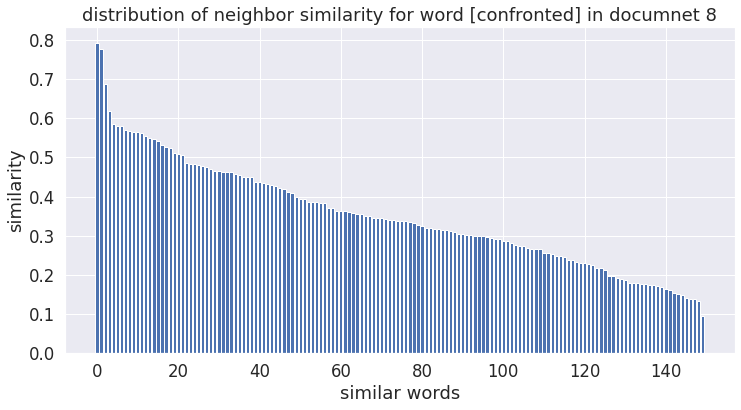

3   -->  growing
1690
[0.8249997, 0.7928541, 0.65186393, 0.644503, 0.5914114, 0.58916694, 0.57940674, 0.5704242, 0.5683563, 0.5607979, 0.5592338, 0.5579022, 0.55756056, 0.5568191, 0.55579627, 0.55119896, 0.5399586, 0.5365163, 0.53499997, 0.53458965, 0.53034383, 0.53023314, 0.5291699, 0.5266615, 0.5258242, 0.5254438, 0.5236602, 0.52346534, 0.5215109, 0.51806164, 0.51759404, 0.51645625, 0.5162507, 0.5061471, 0.5008461, 0.4980024, 0.4953798, 0.49293977, 0.48371106, 0.47909763, 0.4788351, 0.47399858, 0.47127807, 0.4709585, 0.4699826, 0.46859443, 0.46467882, 0.46122378, 0.4612118, 0.45607948, 0.45270446, 0.4487358, 0.4469391, 0.44483054, 0.44373846, 0.44295543, 0.44280326, 0.43991894, 0.43888354, 0.43743142, 0.4363391, 0.4343884, 0.4329263, 0.42813936, 0.42558265, 0.42147008, 0.4148296, 0.41223004, 0.41201046, 0.4105257, 0.4086284, 0.4080519, 0.4069479, 0.40004802, 0.39768168, 0.39756083, 0.39254284, 0.3924688, 0.39048687, 0.38882732, 0.38847893, 0.38664275, 0.3859277, 0.38554752, 0.3843441

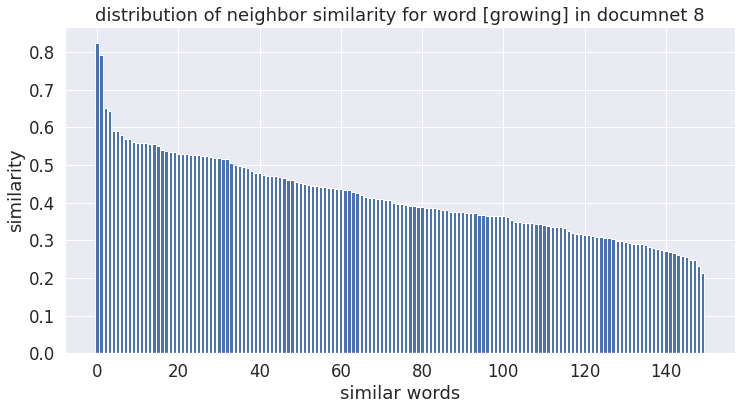

4   -->  demands
1690
[0.8249997, 0.776822, 0.6542467, 0.6087694, 0.5991043, 0.5813337, 0.5811335, 0.5754415, 0.5739969, 0.57304025, 0.5698991, 0.56950355, 0.5675918, 0.55612123, 0.55542105, 0.55110455, 0.5510653, 0.5489894, 0.5482998, 0.54218036, 0.5345474, 0.5257087, 0.5252061, 0.52255046, 0.5202512, 0.5185489, 0.5183589, 0.5162164, 0.5139732, 0.51312447, 0.5056288, 0.5052711, 0.50055057, 0.49973193, 0.49845925, 0.49726564, 0.4915782, 0.49084017, 0.48918748, 0.486229, 0.4799848, 0.47945288, 0.47644418, 0.47565794, 0.4752872, 0.4636273, 0.46232992, 0.45424417, 0.44719878, 0.44665682, 0.440535, 0.44051424, 0.43543208, 0.43243605, 0.4303075, 0.43008408, 0.42929476, 0.42723367, 0.42682016, 0.4060576, 0.40585065, 0.40328872, 0.40030122, 0.39867762, 0.39743984, 0.3954301, 0.39387268, 0.39270508, 0.38868847, 0.38840485, 0.38743043, 0.38638276, 0.38242257, 0.3811507, 0.37959906, 0.37855244, 0.37629813, 0.37491813, 0.3738112, 0.37237096, 0.37190264, 0.37047055, 0.3670623, 0.36497355, 0.362684

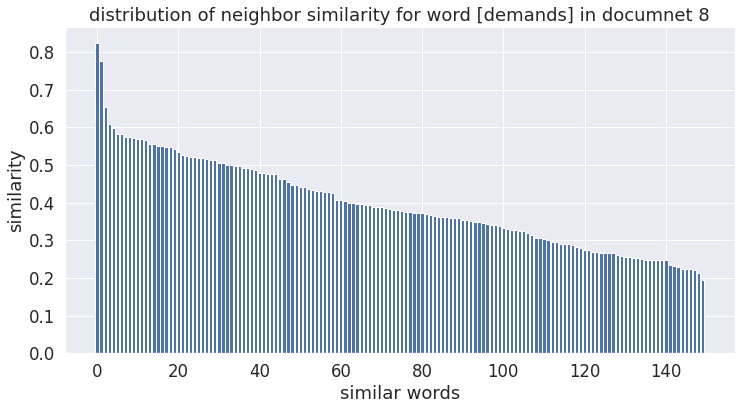

7   -->  communist
1690
[0.6981747, 0.6826059, 0.6253506, 0.6216203, 0.61787474, 0.60035753, 0.5892689, 0.56303626, 0.5618849, 0.5541629, 0.55373824, 0.5467094, 0.5303093, 0.52996945, 0.52737546, 0.5271311, 0.5242096, 0.52018785, 0.51634073, 0.5110873, 0.5030638, 0.5012573, 0.49805638, 0.49690196, 0.4955841, 0.49404705, 0.49004912, 0.48888946, 0.48396266, 0.4834145, 0.48279715, 0.48183972, 0.47629887, 0.47582006, 0.47424966, 0.47410643, 0.46822023, 0.4652037, 0.46165326, 0.45020908, 0.4499399, 0.4446277, 0.43989474, 0.4333703, 0.4291989, 0.42399502, 0.42109352, 0.40759432, 0.40731215, 0.40569174, 0.3982871, 0.3981384, 0.39456192, 0.39092267, 0.3905289, 0.38815898, 0.38595563, 0.38144436, 0.37800822, 0.37769103, 0.37767744, 0.3709347, 0.36948484, 0.3683778, 0.36535272, 0.36500534, 0.36336517, 0.36289707, 0.35974464, 0.3591656, 0.35856497, 0.357802, 0.35745126, 0.3550962, 0.34891048, 0.3482704, 0.34800977, 0.34593192, 0.34587026, 0.34423465, 0.34183815, 0.340092, 0.33998013, 0.33818036, 

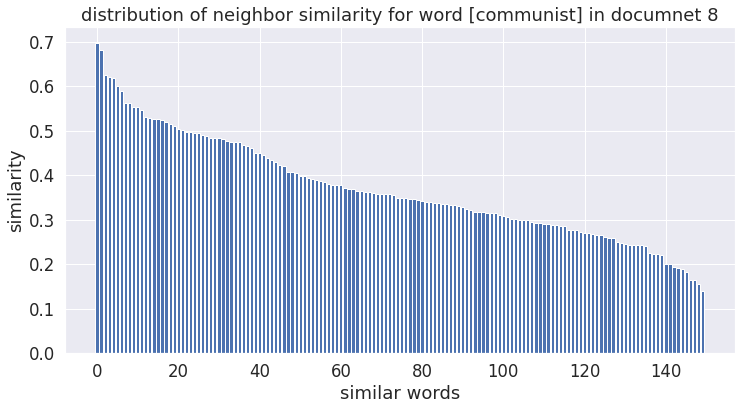

8   -->  party
1690
[0.72119665, 0.7162888, 0.7022376, 0.62869334, 0.60862076, 0.6044946, 0.591519, 0.5882529, 0.5790601, 0.57823867, 0.57345116, 0.56388336, 0.5622407, 0.56088245, 0.55728227, 0.5572396, 0.55622333, 0.55108654, 0.55105937, 0.54978013, 0.5440232, 0.54101, 0.54003537, 0.5373697, 0.5306287, 0.5266984, 0.52392316, 0.51608527, 0.51240414, 0.510662, 0.5069336, 0.50463176, 0.5044509, 0.49045613, 0.4814226, 0.4770606, 0.4735428, 0.4723299, 0.47083336, 0.47023076, 0.46888068, 0.46242845, 0.461391, 0.45440438, 0.45317167, 0.45222402, 0.4517854, 0.4494295, 0.446921, 0.4457767, 0.44107783, 0.44023997, 0.43931478, 0.43719697, 0.4356053, 0.42835906, 0.4281634, 0.42695546, 0.42381176, 0.41875905, 0.41657457, 0.4158743, 0.41433126, 0.4094128, 0.40340424, 0.4030053, 0.4006532, 0.39884812, 0.39722437, 0.39505482, 0.39404923, 0.39323437, 0.39037183, 0.3886038, 0.38598937, 0.38466197, 0.3846516, 0.38366854, 0.38353008, 0.377259, 0.37522575, 0.3752187, 0.3733281, 0.37055933, 0.36880118, 0.

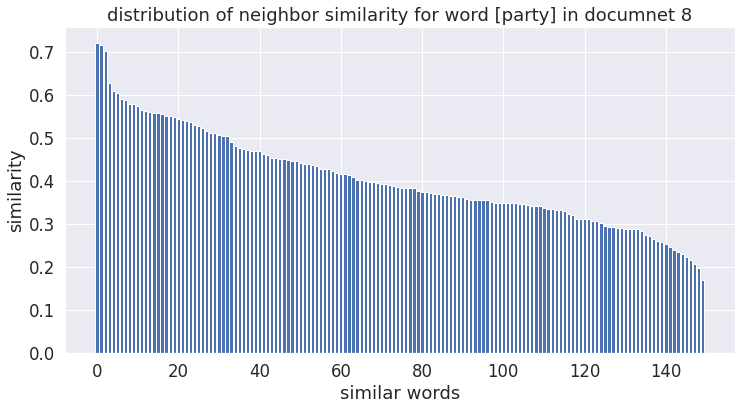

9   -->  dissolve
1690
[0.8418248, 0.7360898, 0.71711564, 0.7004485, 0.68963283, 0.68404317, 0.68194705, 0.6399707, 0.595873, 0.5875337, 0.57946575, 0.5724472, 0.5698991, 0.5617236, 0.5536283, 0.5465509, 0.5453487, 0.54449785, 0.538167, 0.53578496, 0.53023314, 0.52810436, 0.5257419, 0.5232376, 0.519887, 0.5106972, 0.50320303, 0.49943757, 0.49884453, 0.4982728, 0.4977914, 0.49064764, 0.4890597, 0.488005, 0.48551553, 0.48404935, 0.48259327, 0.47732234, 0.47658393, 0.47225612, 0.4683338, 0.46597958, 0.46385655, 0.4633035, 0.45517528, 0.45225304, 0.44833848, 0.44590127, 0.4434887, 0.43701, 0.43628347, 0.4353509, 0.4326861, 0.42814627, 0.42611706, 0.4254759, 0.4247114, 0.42022127, 0.41907325, 0.4181889, 0.41757837, 0.41609496, 0.404381, 0.40275496, 0.40218678, 0.40160125, 0.39763004, 0.39659214, 0.39380467, 0.39261925, 0.38858008, 0.38811296, 0.3870298, 0.3868065, 0.386133, 0.38557082, 0.38300312, 0.38174647, 0.38043812, 0.3733776, 0.3728066, 0.37240547, 0.37009957, 0.367284, 0.365778, 0.36

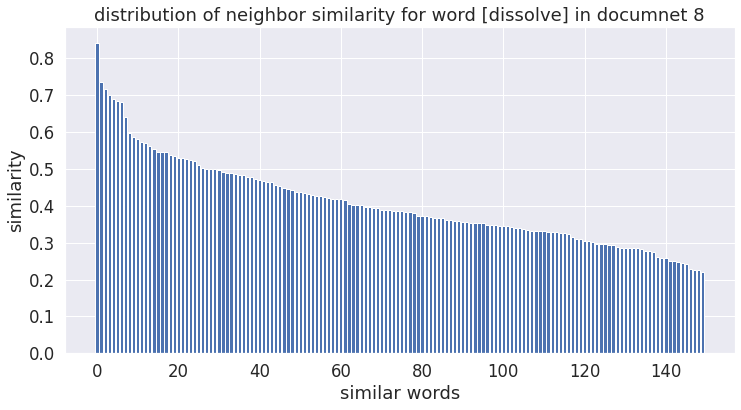

12   -->  top
1690
[0.68696564, 0.6863586, 0.6542467, 0.65186393, 0.64775443, 0.6283183, 0.62244165, 0.6079556, 0.59837997, 0.59389603, 0.591043, 0.5832329, 0.5785643, 0.55908316, 0.5565541, 0.54834384, 0.5367459, 0.5263158, 0.5232376, 0.5198948, 0.50818294, 0.504426, 0.50341845, 0.4979387, 0.49652863, 0.4934104, 0.4889279, 0.48633122, 0.48476043, 0.47659528, 0.47183925, 0.47176528, 0.47148007, 0.46875197, 0.46843508, 0.46821558, 0.46639255, 0.464579, 0.4632227, 0.46188012, 0.45623145, 0.44989765, 0.44957218, 0.4475687, 0.43819252, 0.4353385, 0.43151742, 0.43002152, 0.42049173, 0.41307068, 0.41150802, 0.4111242, 0.39760917, 0.3937871, 0.39183745, 0.3884497, 0.3875464, 0.38748163, 0.38272086, 0.3810413, 0.38022178, 0.38016, 0.37763298, 0.37041253, 0.36063385, 0.36021692, 0.3546499, 0.34892052, 0.34529555, 0.34426853, 0.33422756, 0.32801825, 0.32536578, 0.31858003, 0.31527388, 0.31526807, 0.31471282, 0.31333762, 0.3122469, 0.30899227, 0.30455557, 0.303568, 0.30294365, 0.3014639, 0.301091

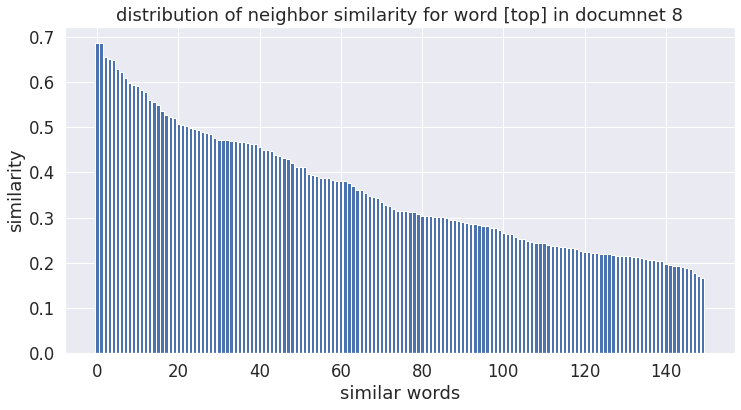

13   -->  officials
1690
[0.70146763, 0.6777394, 0.6487009, 0.6428511, 0.6395907, 0.63926244, 0.63316524, 0.6236077, 0.6174063, 0.59719384, 0.58421206, 0.5821713, 0.57686067, 0.5663997, 0.56070536, 0.55673945, 0.55512613, 0.554611, 0.55028987, 0.5474309, 0.5463613, 0.5364632, 0.5325365, 0.5228766, 0.52258617, 0.5214777, 0.5185685, 0.5158892, 0.50771356, 0.5076537, 0.49737436, 0.4967059, 0.4852824, 0.48076478, 0.47761807, 0.47513413, 0.47379586, 0.473694, 0.4722997, 0.46767205, 0.46530584, 0.4606469, 0.46047938, 0.45692465, 0.4535638, 0.44749317, 0.44529495, 0.44462362, 0.42890453, 0.4287231, 0.42197573, 0.4217667, 0.4187306, 0.41666967, 0.41624838, 0.41107103, 0.40177417, 0.4005162, 0.3996136, 0.39752012, 0.38887432, 0.38572398, 0.38303545, 0.38247645, 0.3824445, 0.37746906, 0.37141377, 0.3701759, 0.3669917, 0.36623827, 0.36452225, 0.36252445, 0.36061817, 0.35658416, 0.3563329, 0.3536935, 0.3515754, 0.35109723, 0.35084477, 0.34464517, 0.34462166, 0.34386408, 0.34230927, 0.3419842, 0.34

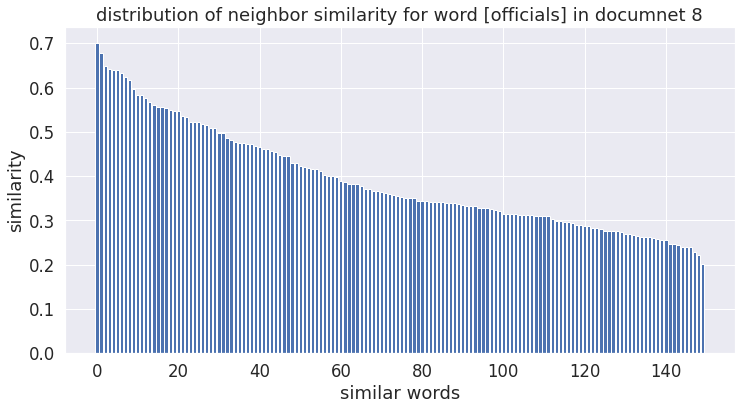

16   -->  country
1690
[0.6272552, 0.59119725, 0.59004456, 0.58703774, 0.58102775, 0.57853043, 0.5773048, 0.5570713, 0.5554016, 0.5518221, 0.55150974, 0.5508529, 0.5508445, 0.54927576, 0.54766524, 0.5462078, 0.5459424, 0.5454619, 0.54195774, 0.54150873, 0.5350379, 0.52873164, 0.5282508, 0.5276774, 0.52692866, 0.52369356, 0.51581407, 0.5082661, 0.5053892, 0.5013346, 0.49990678, 0.4956208, 0.49523473, 0.49490303, 0.49321297, 0.49233133, 0.48877972, 0.48771232, 0.48432368, 0.48272753, 0.47323486, 0.46784484, 0.46153206, 0.45733634, 0.45663023, 0.45255247, 0.45021725, 0.44949487, 0.4491886, 0.44667894, 0.44423595, 0.44223627, 0.43416786, 0.4338023, 0.4310893, 0.42888212, 0.42761457, 0.42660004, 0.42647138, 0.42280295, 0.42280078, 0.41654557, 0.4163899, 0.41515243, 0.4150508, 0.41056567, 0.4076861, 0.40763733, 0.40507126, 0.40053773, 0.39955765, 0.3994251, 0.39860284, 0.3964507, 0.39472145, 0.3935265, 0.39322525, 0.38183182, 0.3777664, 0.37747443, 0.37448922, 0.37281853, 0.3719378, 0.368426

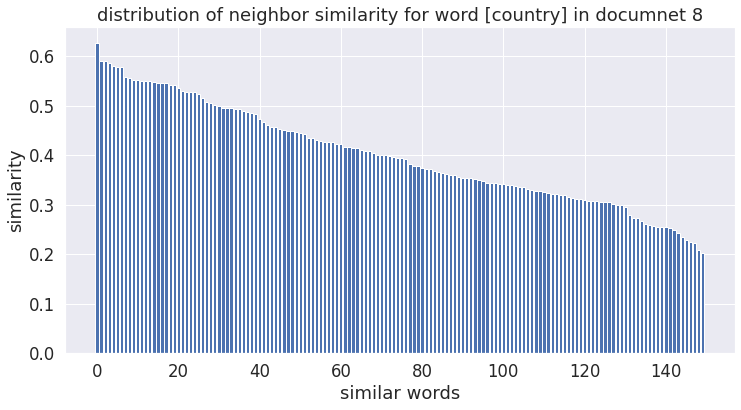

19   -->  old
1690
[0.662395, 0.65578175, 0.65574783, 0.62824583, 0.6109968, 0.6043039, 0.5993705, 0.5741317, 0.56044954, 0.5479666, 0.53573924, 0.5316443, 0.5260656, 0.52396154, 0.51682377, 0.51342666, 0.5109875, 0.5081264, 0.5069632, 0.5060227, 0.50550556, 0.50210315, 0.49519983, 0.48784414, 0.48700094, 0.48625848, 0.48470026, 0.48062998, 0.47692704, 0.47684777, 0.46999854, 0.46856123, 0.46723384, 0.46426132, 0.45942074, 0.4574095, 0.4566836, 0.4518296, 0.45059964, 0.44991213, 0.44912964, 0.4473264, 0.44712305, 0.44412154, 0.4426439, 0.43871856, 0.43454748, 0.43342593, 0.43235236, 0.43084162, 0.42846736, 0.42663506, 0.42627862, 0.4224426, 0.42216006, 0.42154208, 0.41863918, 0.41799915, 0.41699046, 0.41272628, 0.41167575, 0.4115634, 0.41145158, 0.41123956, 0.41070914, 0.41025892, 0.4082262, 0.40772316, 0.40441328, 0.40399104, 0.40233272, 0.40214372, 0.39936155, 0.399352, 0.39858115, 0.39687818, 0.39570957, 0.39532512, 0.39389542, 0.39123863, 0.39070433, 0.38778657, 0.38734645, 0.38670

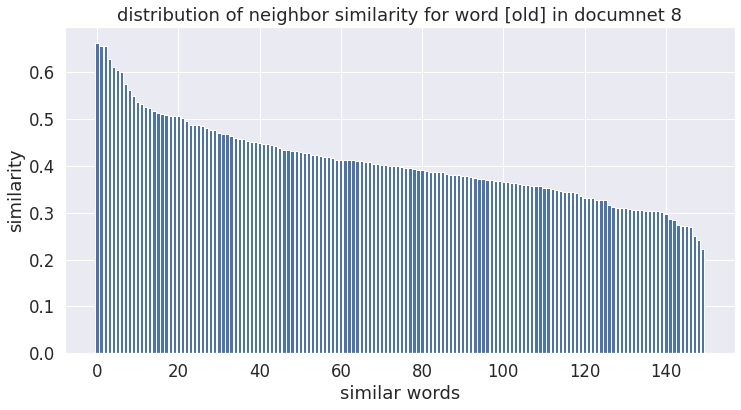

20   -->  order
1690
[0.60661316, 0.5565541, 0.55612123, 0.54989827, 0.5434513, 0.52747643, 0.5178331, 0.5162507, 0.5071557, 0.5069475, 0.50062394, 0.49950385, 0.4960847, 0.4909351, 0.49056396, 0.48551553, 0.48346066, 0.47994068, 0.47864097, 0.47331306, 0.47277033, 0.45779186, 0.4557634, 0.45397174, 0.45368516, 0.4485848, 0.4477382, 0.44619113, 0.44480917, 0.43866247, 0.43772137, 0.43531013, 0.43452582, 0.43326834, 0.4327003, 0.43258575, 0.42986053, 0.42680907, 0.42640316, 0.42616484, 0.42427334, 0.4229943, 0.42275727, 0.42138344, 0.421301, 0.4179665, 0.41512775, 0.41468322, 0.41446292, 0.4135772, 0.41334343, 0.41205686, 0.41117457, 0.4110374, 0.41052115, 0.40324923, 0.40039158, 0.39874655, 0.3986905, 0.39867458, 0.39796984, 0.39671516, 0.3954232, 0.39510167, 0.39482528, 0.3939748, 0.3924002, 0.39106202, 0.38876942, 0.38719702, 0.38408577, 0.38400507, 0.38378766, 0.3834781, 0.382935, 0.3808872, 0.3801977, 0.3787946, 0.3775681, 0.37641126, 0.3722855, 0.37127542, 0.36801302, 0.36671105, 

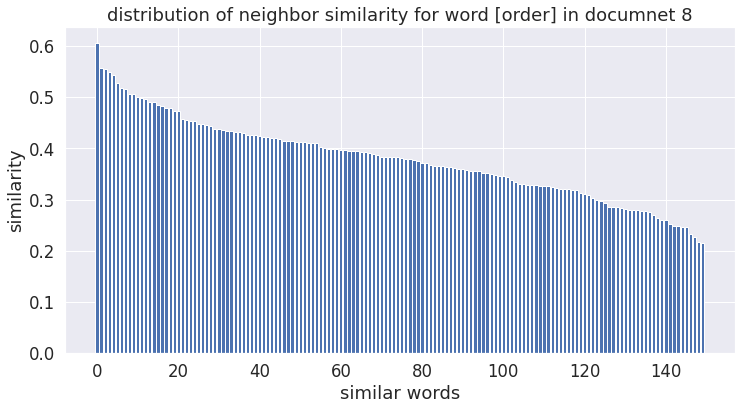

21   -->  say
1690
[0.7945986, 0.78392786, 0.7026565, 0.6611957, 0.64775443, 0.6374619, 0.62047553, 0.6013807, 0.5815096, 0.56686026, 0.55754524, 0.55542105, 0.5476078, 0.5437481, 0.5291699, 0.5097978, 0.50817007, 0.4977914, 0.48576632, 0.48278376, 0.46645266, 0.45915848, 0.45401683, 0.45131436, 0.44999027, 0.4485848, 0.44672835, 0.44604048, 0.44205272, 0.4387831, 0.43144163, 0.4094681, 0.40673786, 0.3930089, 0.39169583, 0.36889362, 0.3609779, 0.35743105, 0.35700047, 0.35579264, 0.3549379, 0.35334688, 0.35254678, 0.35163164, 0.34966558, 0.3479888, 0.347746, 0.3402033, 0.33504915, 0.32989782, 0.32973328, 0.32516217, 0.32338554, 0.3225576, 0.3220692, 0.31520012, 0.31235042, 0.31129354, 0.30200535, 0.3017205, 0.30162233, 0.30050585, 0.30023223, 0.29967397, 0.29964036, 0.29959625, 0.2986171, 0.29229704, 0.292258, 0.29169148, 0.29079384, 0.2894463, 0.28775603, 0.28684837, 0.28674206, 0.28535283, 0.27904457, 0.27894723, 0.27429888, 0.27007404, 0.26847124, 0.26660264, 0.26583052, 0.2627599, 0

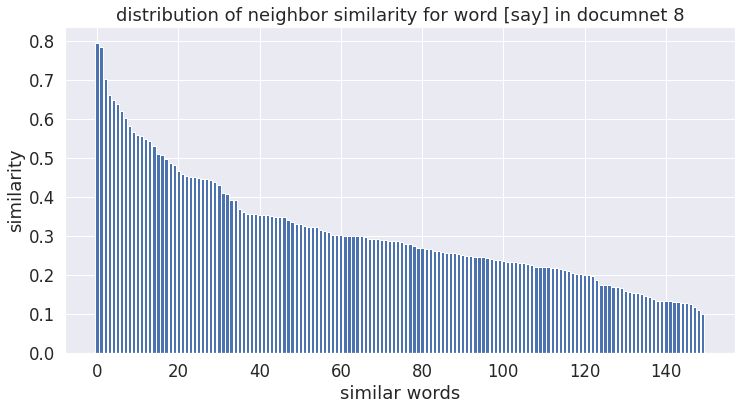

24   -->  call
1690
[0.7270993, 0.722517, 0.7026565, 0.6319267, 0.60961556, 0.6062249, 0.57946575, 0.5771043, 0.5732179, 0.55678856, 0.5554456, 0.5468305, 0.52777463, 0.5270176, 0.51719075, 0.5087389, 0.50463, 0.49652863, 0.49512112, 0.48918748, 0.48744017, 0.48128414, 0.479185, 0.47916713, 0.4627534, 0.45607948, 0.45068026, 0.43937564, 0.4374528, 0.43076515, 0.42904237, 0.42070124, 0.41663712, 0.41205686, 0.41023082, 0.40414077, 0.40258992, 0.3959891, 0.3905465, 0.37783235, 0.37730497, 0.37229973, 0.37102464, 0.36941224, 0.36354965, 0.3611529, 0.36025026, 0.35996208, 0.3594417, 0.35804725, 0.3571675, 0.3397789, 0.32840657, 0.327906, 0.32724732, 0.3244989, 0.32427037, 0.32365143, 0.32293284, 0.32154566, 0.3179082, 0.31603113, 0.31271023, 0.30979893, 0.30872393, 0.3085787, 0.30808276, 0.30619434, 0.30553848, 0.30533722, 0.30512214, 0.3041609, 0.30081785, 0.29935968, 0.29764712, 0.29761565, 0.2971296, 0.29313695, 0.29107866, 0.28907037, 0.28875363, 0.28781778, 0.28638124, 0.28477442, 0.2

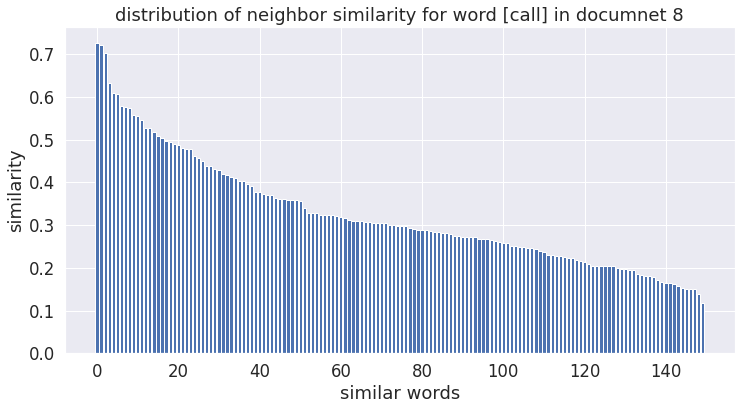

26   -->  special
1690
[0.72051734, 0.67199814, 0.6393242, 0.63435274, 0.631151, 0.6248449, 0.6230953, 0.621487, 0.61635655, 0.6125938, 0.59362364, 0.5928178, 0.5864548, 0.5859997, 0.58369434, 0.58357286, 0.58001584, 0.570591, 0.5688464, 0.56189346, 0.53853565, 0.5383183, 0.52257067, 0.51369995, 0.51339734, 0.5067068, 0.5066256, 0.49115735, 0.48007262, 0.46439368, 0.4568506, 0.45667922, 0.45322955, 0.4513351, 0.451001, 0.45091188, 0.44797152, 0.44681168, 0.44244355, 0.4393077, 0.43788832, 0.43626934, 0.43605113, 0.43556142, 0.43140942, 0.42831248, 0.4275177, 0.42673847, 0.42022216, 0.41699934, 0.4085072, 0.39931428, 0.3985472, 0.39818102, 0.39546284, 0.39255863, 0.38550863, 0.38340935, 0.38227293, 0.38109404, 0.38097727, 0.37961334, 0.3794047, 0.3765232, 0.3764497, 0.37129027, 0.37035406, 0.36785498, 0.36056286, 0.3568061, 0.3564514, 0.35568252, 0.35490382, 0.35385668, 0.35197896, 0.34837258, 0.34818184, 0.34606498, 0.344765, 0.34381273, 0.3415804, 0.34064186, 0.34032834, 0.33660007, 0

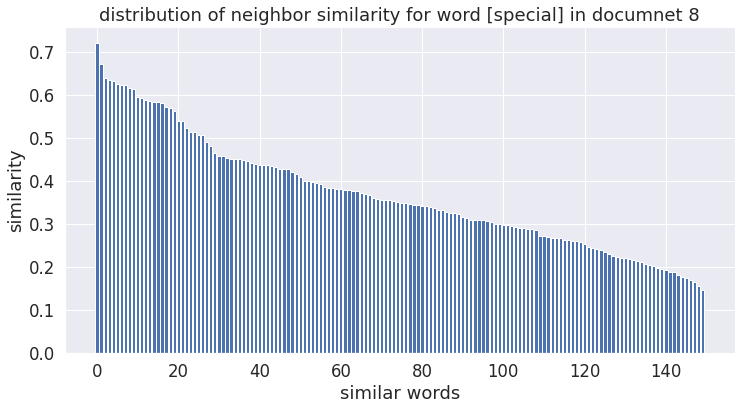

27   -->  congress
1690
[0.6471723, 0.6465249, 0.6404703, 0.63751084, 0.61641884, 0.6142874, 0.60572207, 0.5990368, 0.58371234, 0.57524824, 0.57019234, 0.56277156, 0.55858755, 0.55778533, 0.55708206, 0.5551392, 0.5422188, 0.53689635, 0.5304004, 0.5303395, 0.5259964, 0.52293926, 0.5129764, 0.5046538, 0.50112534, 0.5005842, 0.49717617, 0.47911885, 0.47244412, 0.4642794, 0.46422702, 0.46284425, 0.4497853, 0.44150358, 0.4395301, 0.43908262, 0.4364289, 0.4348091, 0.4327254, 0.42895633, 0.4258823, 0.42582536, 0.42408824, 0.42182043, 0.4205393, 0.42032945, 0.41794938, 0.41609567, 0.4113907, 0.40961578, 0.4057844, 0.40352914, 0.40187615, 0.40122193, 0.3993731, 0.39137268, 0.38946754, 0.38425493, 0.3798101, 0.37917396, 0.3774435, 0.3761313, 0.37472293, 0.37278855, 0.3718925, 0.36561027, 0.3632334, 0.36311704, 0.35846776, 0.35462078, 0.3541991, 0.35295194, 0.35277826, 0.35195044, 0.3411094, 0.3396024, 0.3394056, 0.3390281, 0.33640283, 0.33616915, 0.33447722, 0.33404672, 0.33073005, 0.32775372, 0

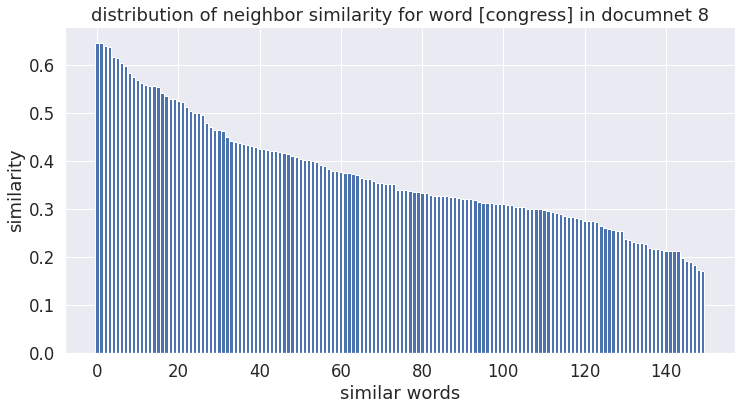

29   -->  di
1690
[0.90224195, 0.848593, 0.74154204, 0.7315415, 0.6913284, 0.68963283, 0.61561763, 0.54718316, 0.54028416, 0.53132915, 0.519865, 0.5174513, 0.5132513, 0.5083395, 0.5070491, 0.5061471, 0.5057465, 0.5032232, 0.49983054, 0.49973193, 0.49932143, 0.49578664, 0.4890477, 0.48804086, 0.4875778, 0.48744017, 0.48721457, 0.48523358, 0.48500502, 0.48476043, 0.48187134, 0.48095858, 0.48045596, 0.47981805, 0.47593245, 0.47562253, 0.47504345, 0.4735851, 0.47349608, 0.46860242, 0.46852493, 0.46713668, 0.4637863, 0.46279022, 0.4585274, 0.45832646, 0.45824426, 0.45615315, 0.45348287, 0.45280135, 0.44315067, 0.44205272, 0.44086313, 0.43423805, 0.43326834, 0.43229038, 0.42930368, 0.42926562, 0.42835373, 0.42624253, 0.4223354, 0.42152458, 0.42073655, 0.41879016, 0.4179914, 0.4089086, 0.40807712, 0.40704906, 0.40180987, 0.4006222, 0.40002877, 0.39485693, 0.39466515, 0.394131, 0.38975948, 0.38920575, 0.3881889, 0.38576925, 0.3846839, 0.38452855, 0.38285556, 0.3820216, 0.38142204, 0.37917498, 

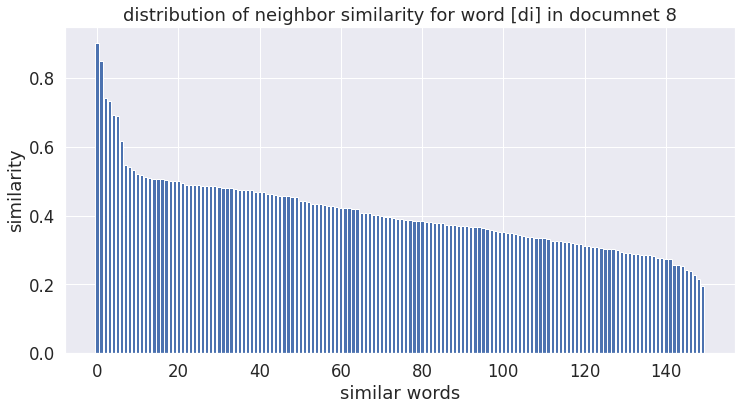

30   -->  ##sman
1690
[0.90224195, 0.8441872, 0.740371, 0.73600256, 0.72783816, 0.7004485, 0.61312705, 0.5674462, 0.55404043, 0.5466517, 0.53409743, 0.523847, 0.51772654, 0.51733786, 0.51729846, 0.5081347, 0.50463, 0.50055057, 0.5002237, 0.4980024, 0.49682468, 0.49185783, 0.48973185, 0.4897093, 0.4895262, 0.4871958, 0.4856041, 0.48308653, 0.4814367, 0.47623128, 0.47553647, 0.47176528, 0.4712668, 0.46972835, 0.46628332, 0.465455, 0.4632255, 0.46002737, 0.45740217, 0.45339108, 0.45124516, 0.45061582, 0.4482113, 0.4474568, 0.4472145, 0.44604048, 0.4460253, 0.44350308, 0.44350207, 0.43452287, 0.42989904, 0.42405123, 0.42265427, 0.4223883, 0.4180118, 0.4175033, 0.41718096, 0.41576564, 0.4157111, 0.41397738, 0.41311556, 0.4122169, 0.41215405, 0.40095648, 0.40039158, 0.39676368, 0.3949807, 0.393672, 0.39279354, 0.39240202, 0.39173245, 0.38833562, 0.38764694, 0.38352352, 0.37431452, 0.37354052, 0.37027428, 0.36758786, 0.36702627, 0.36580485, 0.36364865, 0.36113355, 0.36086938, 0.3607808, 0.354

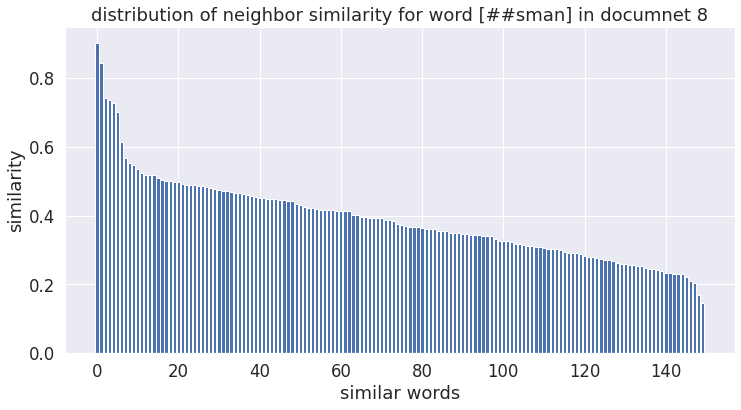

31   -->  ##tle
1690
[0.848593, 0.8441872, 0.7237221, 0.71711564, 0.6943388, 0.6873913, 0.5912709, 0.585854, 0.54324603, 0.53891313, 0.537618, 0.53104997, 0.5190749, 0.51719075, 0.5092891, 0.50821817, 0.5064045, 0.4973774, 0.49447364, 0.49431866, 0.49399447, 0.49293977, 0.4915782, 0.48510873, 0.48453772, 0.4815665, 0.48138142, 0.48132586, 0.47324157, 0.47279006, 0.4701603, 0.4677931, 0.46720138, 0.46645266, 0.46639255, 0.46372744, 0.46131438, 0.46103778, 0.46073353, 0.45903736, 0.45710263, 0.45216256, 0.45117718, 0.45059776, 0.44914988, 0.44755447, 0.4464203, 0.44566327, 0.44529134, 0.44480917, 0.44468817, 0.44147968, 0.44105715, 0.43703222, 0.4367493, 0.43392166, 0.43183333, 0.42975608, 0.42733538, 0.4263264, 0.42363647, 0.4204301, 0.41714185, 0.4150716, 0.4149627, 0.41250032, 0.40838414, 0.40757805, 0.4073384, 0.40666258, 0.40452594, 0.40354913, 0.4010762, 0.4009559, 0.4001954, 0.39797148, 0.3950136, 0.39127526, 0.3877148, 0.386611, 0.38452932, 0.3812597, 0.37936008, 0.37857923, 0.37

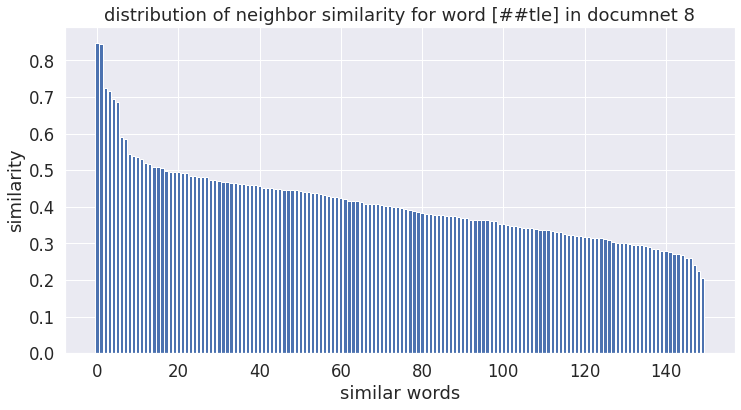

33   -->  disgrace
1690
[0.87118167, 0.7568885, 0.740371, 0.7360898, 0.7315415, 0.6943388, 0.6808712, 0.62941396, 0.5949141, 0.5860569, 0.5832329, 0.5812027, 0.5811335, 0.57940674, 0.5773324, 0.57473016, 0.5707464, 0.55041665, 0.54817134, 0.5434513, 0.5410572, 0.5361749, 0.53298783, 0.5277625, 0.52757096, 0.52607834, 0.5245496, 0.5174767, 0.5167727, 0.5164975, 0.5145515, 0.5115634, 0.51108766, 0.5080457, 0.50221604, 0.50148135, 0.5005964, 0.49801493, 0.49403727, 0.49356273, 0.4894157, 0.48772943, 0.48491585, 0.48317727, 0.47743428, 0.47737002, 0.47409868, 0.47107375, 0.4678257, 0.45969954, 0.45801356, 0.45455194, 0.45386973, 0.45317942, 0.4525927, 0.44965547, 0.44945192, 0.4493658, 0.4493246, 0.4489728, 0.44810525, 0.44672835, 0.44413328, 0.4416728, 0.44145298, 0.43937564, 0.43730658, 0.43721658, 0.43581077, 0.43564332, 0.4351611, 0.4351039, 0.4345459, 0.43329117, 0.43208152, 0.4307564, 0.42917162, 0.42834565, 0.42778802, 0.42530078, 0.41948533, 0.4158902, 0.41531175, 0.4144246, 0.4137

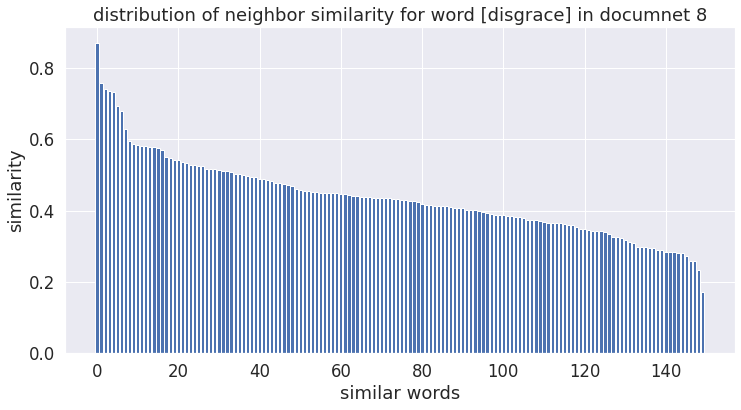

34   -->  ##d
1690
[0.87118167, 0.77276325, 0.74154204, 0.73600256, 0.7237221, 0.69245875, 0.68194705, 0.61819077, 0.615674, 0.6008265, 0.59094423, 0.57548326, 0.5720539, 0.5563356, 0.55579627, 0.547904, 0.54551005, 0.53663874, 0.5345474, 0.5333805, 0.5284283, 0.52747643, 0.5263158, 0.5258783, 0.5220212, 0.52135646, 0.52106655, 0.52024627, 0.5189243, 0.51512533, 0.51018155, 0.50603545, 0.50548375, 0.5045948, 0.50056016, 0.4974389, 0.4953188, 0.49219128, 0.48975942, 0.4882151, 0.48240572, 0.47924852, 0.47843796, 0.47675934, 0.47200638, 0.4706807, 0.47054848, 0.46803963, 0.46800953, 0.46720427, 0.46686986, 0.46664676, 0.4613813, 0.4606678, 0.46047315, 0.45820746, 0.45751378, 0.45715377, 0.45703864, 0.45517352, 0.4520924, 0.45193315, 0.4511833, 0.45078593, 0.44990778, 0.44924074, 0.4490699, 0.44652808, 0.44599712, 0.44587874, 0.44071418, 0.4400776, 0.4400468, 0.43933895, 0.4374528, 0.43738145, 0.4364457, 0.43589208, 0.4337419, 0.43259013, 0.43144163, 0.4285497, 0.42711884, 0.4255954, 0.42

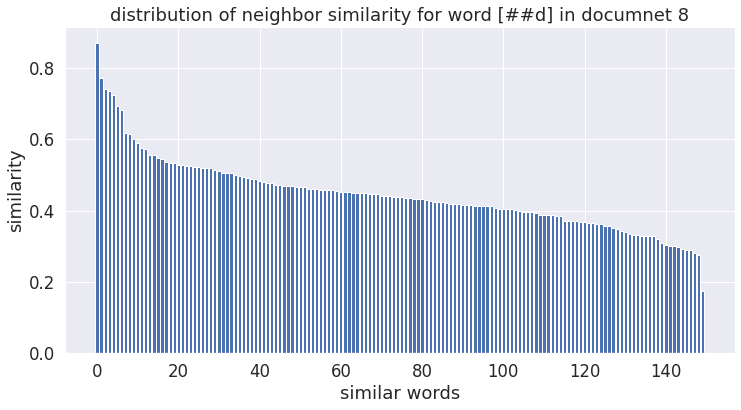

35   -->  party
1690
[0.7738304, 0.7575015, 0.6737859, 0.62438077, 0.62207496, 0.6177834, 0.60740674, 0.60015, 0.5932412, 0.5924236, 0.59218454, 0.5904592, 0.5836168, 0.5829838, 0.57896066, 0.57031155, 0.5661396, 0.55935466, 0.5561229, 0.5530381, 0.5497218, 0.5454647, 0.54318583, 0.53005046, 0.52803004, 0.52721375, 0.5270339, 0.5196109, 0.5170964, 0.5063083, 0.50169706, 0.4948836, 0.48684195, 0.48089495, 0.48088217, 0.47392952, 0.47157228, 0.47113538, 0.4674009, 0.46725023, 0.4619513, 0.45955354, 0.45902413, 0.45785537, 0.4539476, 0.45353603, 0.45283765, 0.45279258, 0.45263344, 0.45134765, 0.44978026, 0.44764027, 0.44754505, 0.4475283, 0.4474257, 0.44541287, 0.444897, 0.44315958, 0.44284007, 0.44281822, 0.44160306, 0.43872684, 0.43821013, 0.4332168, 0.43245816, 0.4309726, 0.4286874, 0.42759365, 0.42571673, 0.4246453, 0.4229697, 0.42269635, 0.42264915, 0.4222773, 0.42180544, 0.42096877, 0.4206295, 0.42022744, 0.41903424, 0.41726485, 0.41560045, 0.41416335, 0.41396657, 0.41394642, 0.4107

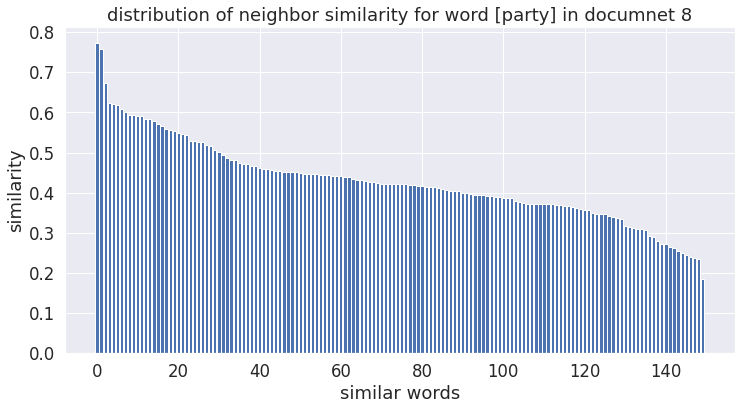

36   -->  even
1690
[0.70114636, 0.70034266, 0.6961502, 0.6867914, 0.686228, 0.66276234, 0.65946615, 0.6443167, 0.6368358, 0.62587994, 0.59762156, 0.57986844, 0.5778292, 0.56800616, 0.56395316, 0.5629021, 0.55676967, 0.5546381, 0.55396426, 0.53609717, 0.5357635, 0.5343304, 0.53238225, 0.5311669, 0.5308403, 0.5292634, 0.5285404, 0.52760804, 0.5275947, 0.5265037, 0.5260018, 0.51966655, 0.5186619, 0.5177712, 0.5062826, 0.499582, 0.49833468, 0.4902076, 0.48867333, 0.47935066, 0.4788835, 0.47887182, 0.47698754, 0.47092897, 0.46955267, 0.46119094, 0.45930284, 0.45794255, 0.45607406, 0.45593464, 0.4555988, 0.452416, 0.44664043, 0.44444337, 0.4427793, 0.4385687, 0.438232, 0.43823078, 0.43821862, 0.43564504, 0.43495667, 0.43431082, 0.4270615, 0.42441964, 0.42091578, 0.42019403, 0.41598308, 0.4137438, 0.41115636, 0.41040343, 0.40774876, 0.40448844, 0.40289542, 0.4012675, 0.40089148, 0.39387724, 0.39297688, 0.39190573, 0.39013535, 0.3877275, 0.38607818, 0.3848753, 0.3840891, 0.38377404, 0.3830014

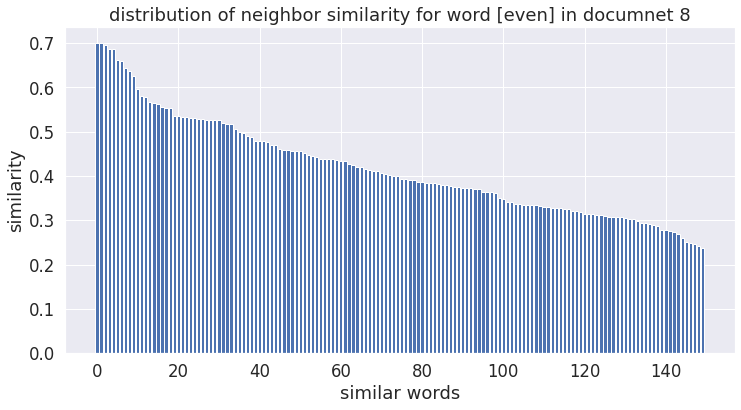

38   -->  free
1690
[0.7243451, 0.72330534, 0.6471246, 0.63032055, 0.61309177, 0.5875337, 0.5862771, 0.5719707, 0.5417971, 0.5410572, 0.5381424, 0.53663874, 0.5355618, 0.53409743, 0.5337596, 0.519321, 0.51074815, 0.5089202, 0.5087389, 0.50777537, 0.5062492, 0.5057465, 0.5035635, 0.49563393, 0.49520713, 0.49413902, 0.48652273, 0.48489898, 0.4809541, 0.47830874, 0.47565794, 0.46720138, 0.464579, 0.46122378, 0.46111965, 0.4596261, 0.45131436, 0.44728303, 0.44551235, 0.44531137, 0.44440734, 0.44228685, 0.43952733, 0.43916655, 0.43452582, 0.43303108, 0.43210107, 0.42793533, 0.42641884, 0.42097962, 0.42068547, 0.42067486, 0.42045665, 0.42003167, 0.41312307, 0.41217282, 0.4085997, 0.40674925, 0.40522546, 0.4038838, 0.40351146, 0.4033073, 0.3934403, 0.39209783, 0.3858315, 0.3856001, 0.3850835, 0.37810174, 0.37760407, 0.37216297, 0.371391, 0.37040287, 0.3679728, 0.36542392, 0.36256686, 0.3608098, 0.36078086, 0.35250077, 0.35156098, 0.35145655, 0.34889957, 0.34407488, 0.34179854, 0.34173402, 0.3

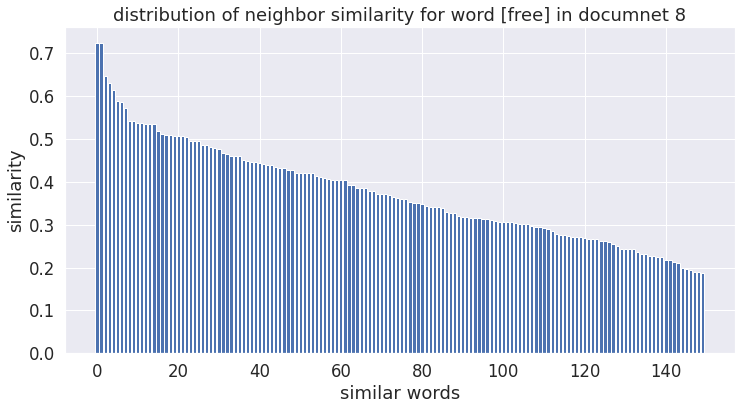

39   -->  elections
1690
[0.7421686, 0.71766174, 0.68663746, 0.62634397, 0.6219437, 0.6094524, 0.5906799, 0.58569384, 0.57101595, 0.5630199, 0.5546776, 0.5495268, 0.5486324, 0.5426417, 0.53990424, 0.52801245, 0.5236704, 0.52361345, 0.51919913, 0.50946975, 0.50841534, 0.5047552, 0.5046151, 0.50335705, 0.49744207, 0.49585208, 0.49534124, 0.49442232, 0.48986852, 0.48848832, 0.48606634, 0.46218467, 0.4581574, 0.45461753, 0.4516476, 0.4512622, 0.44642073, 0.44256702, 0.4409656, 0.4409088, 0.43607295, 0.4351613, 0.43239367, 0.42954633, 0.42902836, 0.42807803, 0.42707372, 0.42497617, 0.42273828, 0.41739947, 0.41683936, 0.41478336, 0.4107349, 0.41072786, 0.40520495, 0.40355185, 0.3962778, 0.39269704, 0.3865139, 0.38434523, 0.38432777, 0.38165063, 0.38063496, 0.37722087, 0.37560433, 0.3720763, 0.37158787, 0.36943153, 0.36939076, 0.3692239, 0.36800432, 0.3669432, 0.36259207, 0.36222956, 0.35846126, 0.35814682, 0.3572574, 0.35680178, 0.35100743, 0.34965515, 0.34925157, 0.3464272, 0.34543025, 0.34

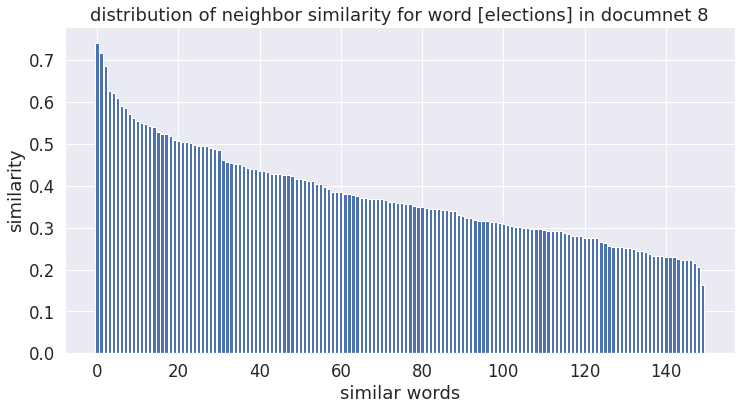

41   -->  held
1690
[0.7651824, 0.67853814, 0.64691365, 0.6279138, 0.5942039, 0.57286763, 0.54458094, 0.52827156, 0.5272354, 0.52429545, 0.52018255, 0.5124044, 0.5119941, 0.5114075, 0.51103204, 0.5036372, 0.5015208, 0.49841112, 0.49471077, 0.49180925, 0.48841402, 0.4738128, 0.47356576, 0.46511778, 0.46433562, 0.46345538, 0.45944118, 0.45862085, 0.45244318, 0.44955134, 0.44408903, 0.44023526, 0.43907952, 0.43245035, 0.42756435, 0.42152068, 0.4208042, 0.42061365, 0.41856873, 0.41718566, 0.41281843, 0.4113702, 0.41011298, 0.40814543, 0.4020789, 0.40108824, 0.39261943, 0.39221108, 0.39111146, 0.38828343, 0.38631794, 0.37826142, 0.37494698, 0.374233, 0.3732444, 0.37103397, 0.36249462, 0.36219648, 0.36026365, 0.35886407, 0.35773802, 0.35771987, 0.3539148, 0.3538755, 0.35097373, 0.3509337, 0.3505643, 0.3502743, 0.34887785, 0.3485152, 0.34391952, 0.34360653, 0.34338582, 0.3422172, 0.34204853, 0.34193966, 0.333876, 0.33326116, 0.33179343, 0.33146605, 0.32994932, 0.3278226, 0.32635218, 0.3230706

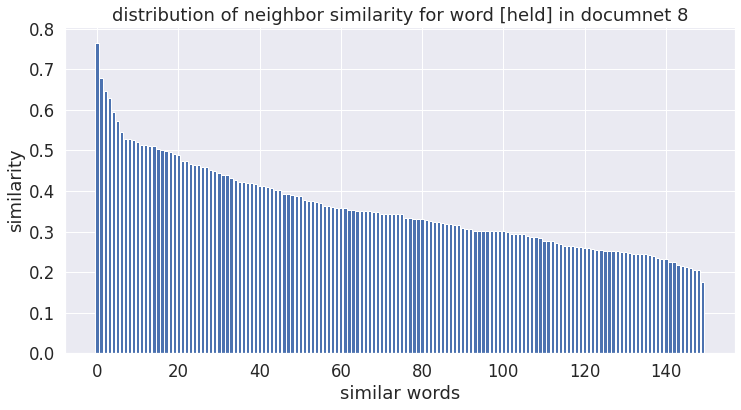

43   -->  april
1690
[0.72330534, 0.6670993, 0.6399707, 0.62941396, 0.60563135, 0.6008265, 0.5943754, 0.5918059, 0.58252966, 0.5674462, 0.5489894, 0.5468305, 0.54378104, 0.5423838, 0.534643, 0.53132915, 0.53104997, 0.5280328, 0.52651536, 0.52223706, 0.5215109, 0.5171612, 0.5137155, 0.5123037, 0.5112112, 0.5105416, 0.50883937, 0.50817007, 0.5041789, 0.50379, 0.50341845, 0.50258654, 0.50012624, 0.49411196, 0.49084687, 0.4894862, 0.48542005, 0.48503584, 0.4836246, 0.45368516, 0.44054037, 0.4393409, 0.43479148, 0.43034607, 0.4259507, 0.41950524, 0.41804332, 0.41687793, 0.41645244, 0.41618988, 0.41551203, 0.41378498, 0.41109937, 0.41024244, 0.40844125, 0.4084313, 0.40704703, 0.40060532, 0.39257458, 0.390109, 0.38981283, 0.38832963, 0.3840785, 0.38058707, 0.37870827, 0.37241942, 0.37178278, 0.37059188, 0.36975378, 0.3688987, 0.36083853, 0.35955253, 0.35822827, 0.35765544, 0.3539953, 0.35366768, 0.3535654, 0.35283867, 0.35260767, 0.342242, 0.3404578, 0.33967674, 0.33272526, 0.33116364, 0.3275

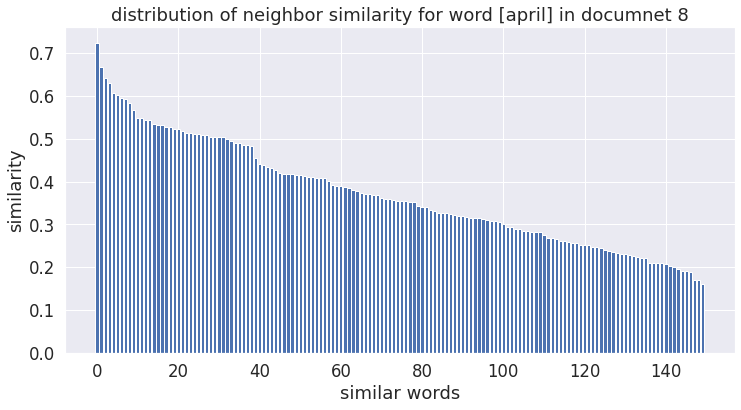

45   -->  late
1690
[0.86814344, 0.8497436, 0.6577549, 0.6573775, 0.6427331, 0.62047553, 0.59873915, 0.59837997, 0.58237296, 0.57141423, 0.5662309, 0.56449807, 0.55738974, 0.5554456, 0.55058825, 0.5503551, 0.5423838, 0.5419042, 0.535059, 0.5266615, 0.5252061, 0.51778805, 0.508908, 0.4952244, 0.49185783, 0.4894157, 0.48652273, 0.4797726, 0.47658393, 0.47349608, 0.46803963, 0.46733278, 0.46542817, 0.45117718, 0.4469975, 0.43903238, 0.42745215, 0.4251204, 0.42389512, 0.4233023, 0.42145956, 0.4137408, 0.41348302, 0.4076097, 0.40689582, 0.39944577, 0.39510167, 0.39096957, 0.3900783, 0.38915372, 0.38508093, 0.37333733, 0.37277338, 0.37246203, 0.36764106, 0.36689684, 0.36539853, 0.36423007, 0.36396715, 0.3602201, 0.36002374, 0.35775954, 0.35742456, 0.3549181, 0.35461813, 0.35377753, 0.34880975, 0.3450372, 0.3447354, 0.34443468, 0.33741337, 0.33666736, 0.33244145, 0.33215728, 0.32827216, 0.32775283, 0.3268221, 0.32643795, 0.3223156, 0.319534, 0.31789082, 0.31704676, 0.3165983, 0.31026402, 0.30

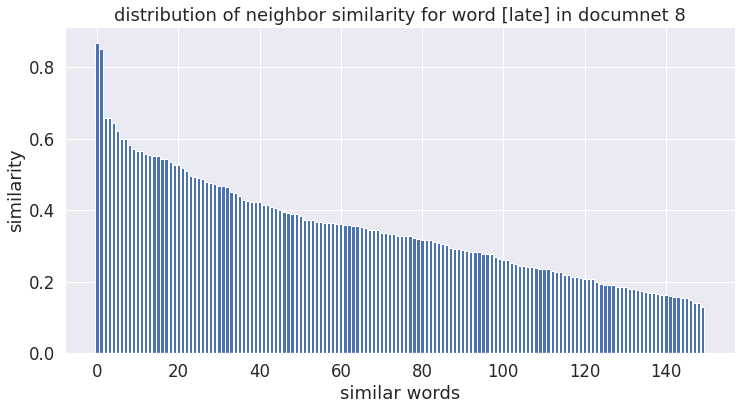

46   -->  saturday
1690
[0.86814344, 0.8545295, 0.6265923, 0.60918105, 0.60811853, 0.60563135, 0.60529363, 0.6031725, 0.59389603, 0.5815096, 0.57212067, 0.5679966, 0.55678856, 0.5550945, 0.5417971, 0.5336002, 0.5277625, 0.52425385, 0.51901174, 0.51645625, 0.51312447, 0.51079094, 0.5072581, 0.49943757, 0.48973185, 0.48778802, 0.48769093, 0.48060656, 0.47981805, 0.47924852, 0.475877, 0.4693799, 0.46073353, 0.44618487, 0.43776357, 0.4358256, 0.43531013, 0.43294704, 0.42896798, 0.42854232, 0.42849088, 0.4284615, 0.42469537, 0.4223359, 0.41601023, 0.41515437, 0.4147519, 0.41342667, 0.4091928, 0.4058576, 0.40495276, 0.39271468, 0.39255452, 0.39211702, 0.38671297, 0.38438275, 0.3821451, 0.38004056, 0.37850264, 0.3743694, 0.37240767, 0.3632114, 0.36180052, 0.35923594, 0.352422, 0.34898767, 0.3486758, 0.34673855, 0.34539536, 0.3411986, 0.33710498, 0.33632588, 0.3324368, 0.32952482, 0.3286245, 0.3273359, 0.32585675, 0.3253973, 0.3232478, 0.3189146, 0.3160796, 0.30292112, 0.2973972, 0.29701692, 0

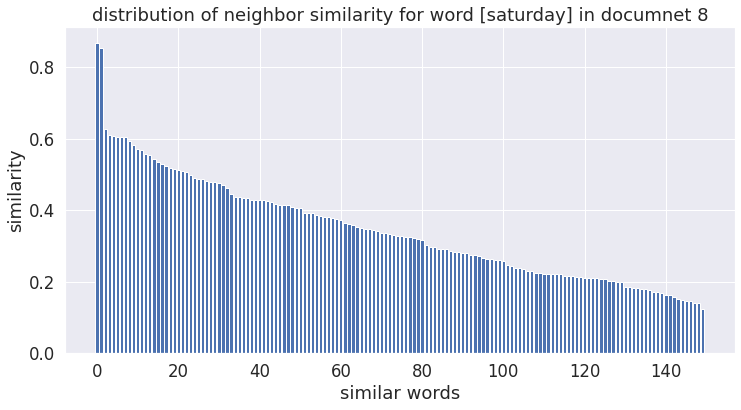

47   -->  night
1690
[0.8545295, 0.8497436, 0.699863, 0.64974934, 0.64886945, 0.6374619, 0.63107574, 0.6283183, 0.6277529, 0.6186991, 0.6131353, 0.6062249, 0.601599, 0.5992473, 0.5855516, 0.58514893, 0.58252966, 0.5813337, 0.5704242, 0.56931776, 0.5637162, 0.5580572, 0.54136026, 0.5367218, 0.5330906, 0.53298783, 0.523847, 0.52156866, 0.52024627, 0.519887, 0.519321, 0.5174513, 0.5092891, 0.5034683, 0.500445, 0.49991897, 0.49982792, 0.49076176, 0.49030116, 0.47462732, 0.47277033, 0.46463886, 0.45793968, 0.44313473, 0.43310833, 0.4297968, 0.4282737, 0.42705876, 0.4210364, 0.40732324, 0.40167177, 0.3976498, 0.39417225, 0.39221978, 0.39154232, 0.39138728, 0.38444394, 0.3806944, 0.37981454, 0.3795582, 0.37819982, 0.37760162, 0.37725902, 0.37194073, 0.37096214, 0.37022734, 0.37019587, 0.3658346, 0.36580464, 0.36554313, 0.3615854, 0.35939732, 0.35828966, 0.35714483, 0.35518897, 0.3549444, 0.35470307, 0.35355842, 0.35317466, 0.35162687, 0.35074383, 0.34737378, 0.34687385, 0.33920085, 0.33397788

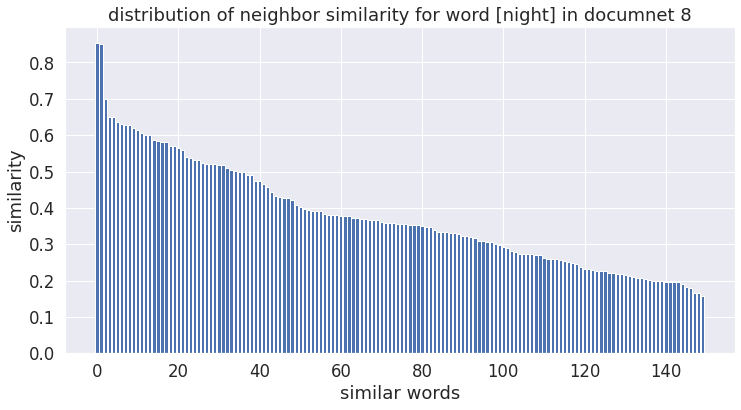

50   -->  group
1690
[0.7052155, 0.70135343, 0.67295337, 0.64886945, 0.62244165, 0.6106564, 0.59873915, 0.57779807, 0.5726463, 0.56950355, 0.55756056, 0.55754524, 0.5550945, 0.5491975, 0.5229773, 0.52198607, 0.5195125, 0.5187652, 0.51379144, 0.49211076, 0.49118137, 0.48823613, 0.48509395, 0.48419133, 0.479185, 0.47901624, 0.46612602, 0.45330858, 0.44833848, 0.44243696, 0.43936637, 0.43730658, 0.42994714, 0.42853796, 0.4244972, 0.4229943, 0.4150293, 0.41378498, 0.41287687, 0.41195193, 0.4117886, 0.4103793, 0.40668744, 0.39896634, 0.39051872, 0.38582432, 0.38452932, 0.38142204, 0.3778145, 0.37440562, 0.37370488, 0.37344408, 0.37334615, 0.37182152, 0.3713687, 0.37040287, 0.36847517, 0.36773908, 0.36163574, 0.35984555, 0.35953742, 0.35684627, 0.3546952, 0.35401165, 0.3529947, 0.35269895, 0.35061127, 0.35014573, 0.34808376, 0.3476626, 0.3467819, 0.34613758, 0.34451774, 0.34305674, 0.34240296, 0.3417933, 0.3415239, 0.3411669, 0.33996475, 0.33907062, 0.33338696, 0.33281773, 0.32851365, 0.3271

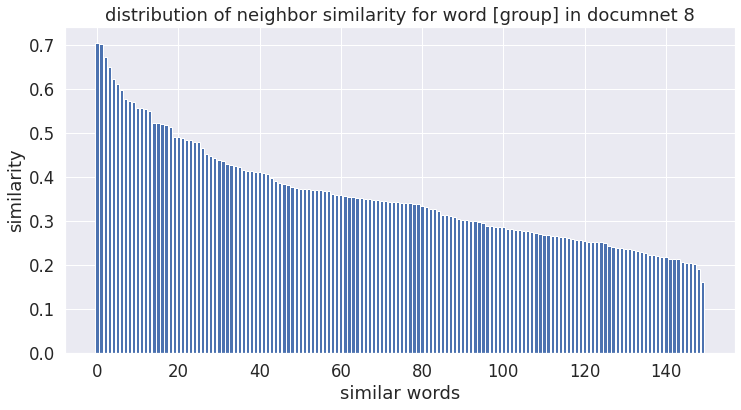

52   -->  party
1690
[0.61545557, 0.6062624, 0.6047566, 0.5850408, 0.5511048, 0.5505052, 0.550099, 0.5500476, 0.5482705, 0.5445318, 0.5382142, 0.53321624, 0.52738893, 0.52584213, 0.50788647, 0.5032856, 0.50238043, 0.5008452, 0.4992345, 0.49688554, 0.49160224, 0.49015486, 0.48765433, 0.4867974, 0.4838912, 0.48084027, 0.4790334, 0.47551095, 0.47108248, 0.46868783, 0.4662693, 0.46518973, 0.45854944, 0.45805418, 0.45316687, 0.45114574, 0.44330594, 0.4383883, 0.4379768, 0.4359907, 0.435275, 0.43047577, 0.42719984, 0.4254387, 0.42050183, 0.41885203, 0.41530213, 0.41289654, 0.4106199, 0.40857357, 0.4021296, 0.4020037, 0.39826375, 0.39599213, 0.3879223, 0.38553262, 0.38543332, 0.38500676, 0.38265532, 0.37280774, 0.37151265, 0.37051973, 0.36779532, 0.36530322, 0.36279017, 0.36009496, 0.3591286, 0.35901904, 0.35858196, 0.3487671, 0.3460278, 0.34508535, 0.34502372, 0.34479055, 0.34458333, 0.3437938, 0.34296656, 0.34256783, 0.3359664, 0.3352705, 0.3341757, 0.3312681, 0.32453215, 0.31579006, 0.3146

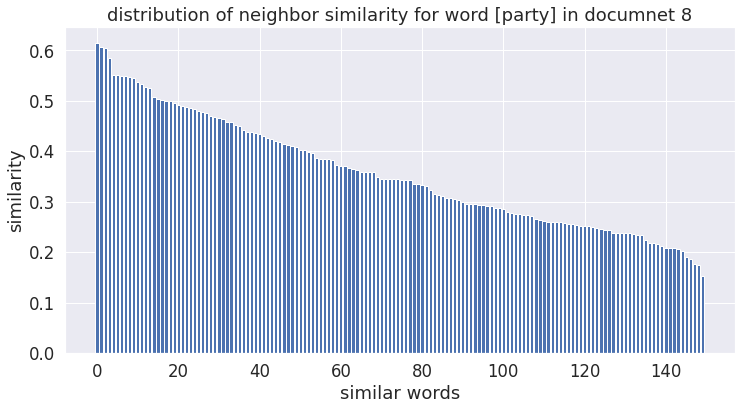

53   -->  officials
1690
[0.70830286, 0.6888795, 0.65555394, 0.6352883, 0.62281203, 0.61998487, 0.6181944, 0.6128952, 0.61140585, 0.5963499, 0.57647103, 0.5714672, 0.5604113, 0.5573877, 0.5568257, 0.55323935, 0.55164135, 0.55017793, 0.54715174, 0.5442794, 0.5426056, 0.5390268, 0.5377219, 0.5324552, 0.53015625, 0.5256502, 0.5252105, 0.52113336, 0.5210054, 0.5176481, 0.512611, 0.5117189, 0.5085081, 0.5051639, 0.5047393, 0.49935806, 0.4966359, 0.49566242, 0.493509, 0.48899037, 0.48649362, 0.4834795, 0.4706344, 0.4703529, 0.4682229, 0.46334928, 0.45930034, 0.45827895, 0.4540038, 0.44978267, 0.44355348, 0.44352588, 0.43945426, 0.43751156, 0.42852372, 0.42224634, 0.41387302, 0.40855026, 0.40570825, 0.40460837, 0.4027192, 0.39852756, 0.38891226, 0.38630545, 0.38482457, 0.38290277, 0.37974936, 0.3783049, 0.3778522, 0.377625, 0.37579745, 0.37045327, 0.36270377, 0.361884, 0.361095, 0.3608673, 0.3595313, 0.35853618, 0.35742128, 0.35720545, 0.35692233, 0.3557737, 0.35357192, 0.3505111, 0.3476107, 

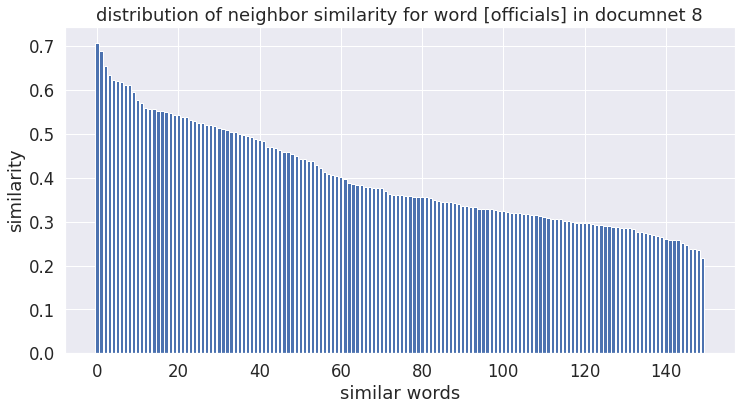

55   -->  many
1690
[0.8293117, 0.7772373, 0.6716312, 0.6478688, 0.6278212, 0.6211685, 0.61888784, 0.61680424, 0.59258157, 0.58609426, 0.5835833, 0.57956195, 0.5747163, 0.5679606, 0.56195426, 0.5573491, 0.5484312, 0.5450226, 0.53893435, 0.5387936, 0.5379251, 0.5337282, 0.5292994, 0.5275457, 0.52450216, 0.50322855, 0.50091815, 0.49197713, 0.49163848, 0.48684102, 0.48635322, 0.4854573, 0.4837079, 0.4827179, 0.47608852, 0.4733411, 0.47041276, 0.46820387, 0.46641362, 0.46570638, 0.46374246, 0.45924348, 0.458382, 0.4572741, 0.45206133, 0.4372004, 0.4356765, 0.4349643, 0.43339342, 0.43252543, 0.43198276, 0.43183836, 0.42719418, 0.4256429, 0.42553926, 0.4240675, 0.42320302, 0.423187, 0.42216688, 0.42105734, 0.41954947, 0.41925472, 0.41282862, 0.41109705, 0.40990263, 0.40814325, 0.40773463, 0.40510163, 0.4032837, 0.3991925, 0.3989847, 0.39849892, 0.39756376, 0.39684144, 0.39096868, 0.39065915, 0.38729, 0.38162363, 0.37126207, 0.37013412, 0.36594462, 0.3652044, 0.3651315, 0.3647589, 0.36465448,

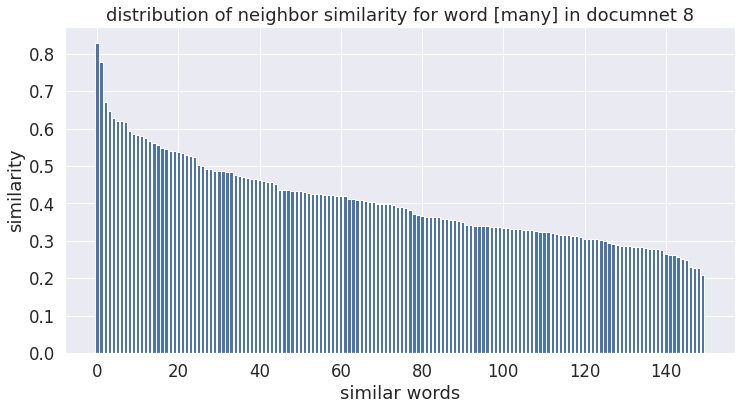

58   -->  quickly
1690
[0.8406446, 0.80540943, 0.7264179, 0.7256507, 0.66015804, 0.6492766, 0.63062155, 0.61752737, 0.61019826, 0.58916694, 0.5879476, 0.580468, 0.5754415, 0.5663394, 0.5491813, 0.545565, 0.54551005, 0.5415807, 0.5401772, 0.5354082, 0.53161716, 0.52757096, 0.5232743, 0.52198607, 0.5120733, 0.504426, 0.50157213, 0.49997073, 0.49932143, 0.4988098, 0.4940095, 0.49399447, 0.49076176, 0.4895262, 0.48558158, 0.4797726, 0.4790667, 0.4765475, 0.476542, 0.4683338, 0.4679138, 0.46522886, 0.464715, 0.45928875, 0.45699924, 0.45601797, 0.45557863, 0.45415753, 0.45201573, 0.4508006, 0.45012933, 0.44957113, 0.44886556, 0.44415206, 0.43866247, 0.42854232, 0.4274146, 0.4269788, 0.42690185, 0.42660657, 0.4249445, 0.42401308, 0.42398536, 0.42283407, 0.4210072, 0.41687793, 0.41372192, 0.4134698, 0.4120275, 0.41012463, 0.406815, 0.40198958, 0.40177077, 0.40039045, 0.3991999, 0.3989572, 0.39887488, 0.39673787, 0.39313015, 0.39261502, 0.39169583, 0.39100203, 0.38671473, 0.3861556, 0.38320225,

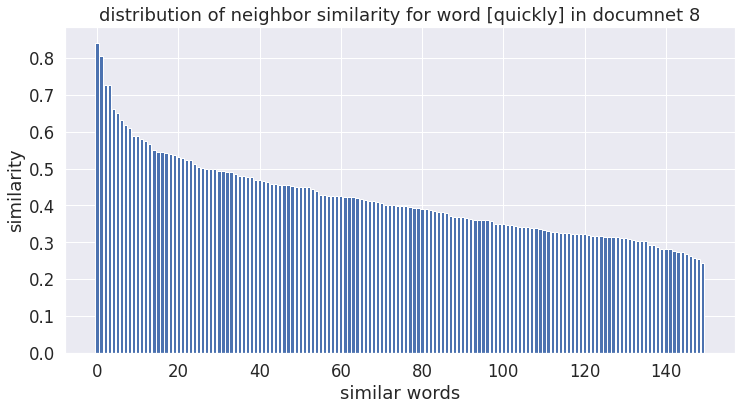

59   -->  severed
1690
[0.8406446, 0.8185292, 0.8032761, 0.7303951, 0.6137214, 0.58557296, 0.57657665, 0.57274616, 0.5480055, 0.5388704, 0.5241056, 0.5236602, 0.52255046, 0.5125978, 0.5123381, 0.51018155, 0.50741297, 0.5059141, 0.5021327, 0.49801493, 0.49478048, 0.49211076, 0.48804086, 0.48510873, 0.47292465, 0.4726299, 0.46972835, 0.46843508, 0.46835697, 0.46597958, 0.4551409, 0.4533015, 0.4520291, 0.45171136, 0.44974536, 0.44951096, 0.44869328, 0.44821268, 0.44790086, 0.4440424, 0.44114962, 0.4403488, 0.4372963, 0.4313297, 0.43018678, 0.4297968, 0.42717105, 0.42594758, 0.42505574, 0.4233023, 0.42092276, 0.41768742, 0.4136414, 0.41357118, 0.4095463, 0.40834028, 0.4031186, 0.40181023, 0.4010573, 0.3996783, 0.39858913, 0.39562824, 0.38876942, 0.3885855, 0.38810647, 0.38345325, 0.38283658, 0.3821451, 0.38101175, 0.37678242, 0.3729836, 0.37176234, 0.36737773, 0.36611366, 0.36488774, 0.36430252, 0.36396766, 0.36305934, 0.362248, 0.36054853, 0.35852844, 0.3582071, 0.3566178, 0.35635734, 0.3

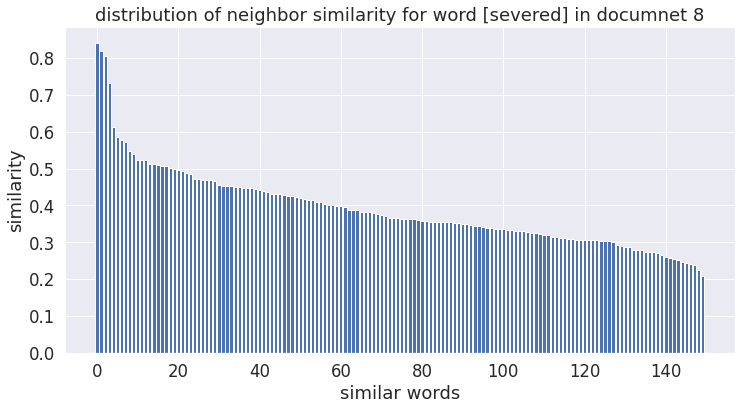

61   -->  relationship
1690
[0.8185292, 0.7946662, 0.7264179, 0.5896494, 0.5325618, 0.5304805, 0.5303425, 0.5286939, 0.5037482, 0.48316786, 0.47945288, 0.4612118, 0.46098876, 0.45747554, 0.45703864, 0.43959656, 0.43805033, 0.43621522, 0.4351039, 0.4329875, 0.42994714, 0.42797047, 0.42743835, 0.42528516, 0.42185125, 0.42120975, 0.41699874, 0.41446033, 0.41379252, 0.41150802, 0.41052115, 0.4031462, 0.40216473, 0.39894456, 0.39879367, 0.39797148, 0.39763004, 0.39466515, 0.39373532, 0.3927678, 0.3903786, 0.390257, 0.3896855, 0.38966778, 0.3886487, 0.38379323, 0.38352352, 0.38050795, 0.37849298, 0.37803817, 0.37778378, 0.37742218, 0.3759851, 0.37375546, 0.36976054, 0.36889133, 0.36879122, 0.3653363, 0.36438674, 0.36265177, 0.36117297, 0.35828966, 0.35728785, 0.35517317, 0.35475135, 0.3530552, 0.3521327, 0.35097477, 0.35043943, 0.34918964, 0.3479176, 0.3473035, 0.34584123, 0.34493947, 0.3443061, 0.34319073, 0.34213418, 0.3420151, 0.3369487, 0.33584884, 0.33524695, 0.33197063, 0.33073214, 0.3

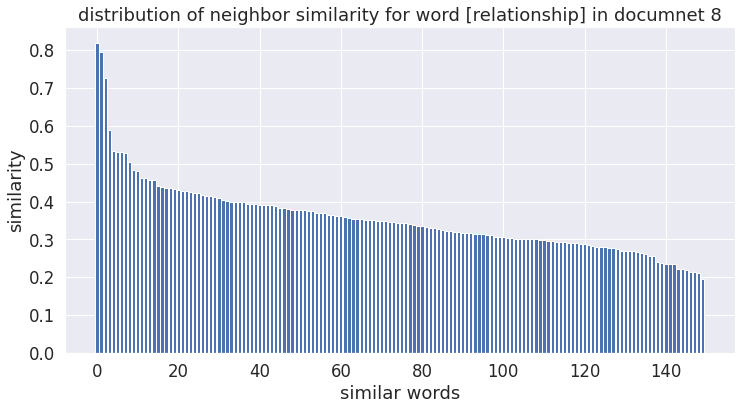

64   -->  ce
1690
[0.64910424, 0.6485083, 0.6472254, 0.6379967, 0.6301586, 0.5841859, 0.57843804, 0.5673182, 0.55465734, 0.5526114, 0.53241223, 0.53097034, 0.5304954, 0.5283693, 0.5278045, 0.5277066, 0.52627766, 0.5182613, 0.51619446, 0.51373345, 0.5109922, 0.5094644, 0.50933874, 0.49962646, 0.49879456, 0.4842827, 0.48038462, 0.473227, 0.46816605, 0.46350402, 0.45513844, 0.45480493, 0.45308173, 0.45206076, 0.44774884, 0.44563788, 0.44498885, 0.44298637, 0.44290304, 0.44080192, 0.43740034, 0.43601525, 0.43575782, 0.4332257, 0.42992038, 0.42051083, 0.41235888, 0.41171032, 0.4116959, 0.4109555, 0.41025364, 0.4095954, 0.40883118, 0.40760243, 0.40439457, 0.39690304, 0.39279884, 0.3925119, 0.392364, 0.38836768, 0.3874372, 0.38655692, 0.38553274, 0.3816863, 0.37963074, 0.37652498, 0.3743115, 0.37165874, 0.36869824, 0.3682915, 0.3648531, 0.3630145, 0.3593071, 0.35881674, 0.3566083, 0.35145435, 0.34934956, 0.34799093, 0.339427, 0.33707422, 0.33538964, 0.33376855, 0.33360237, 0.3326512, 0.331935

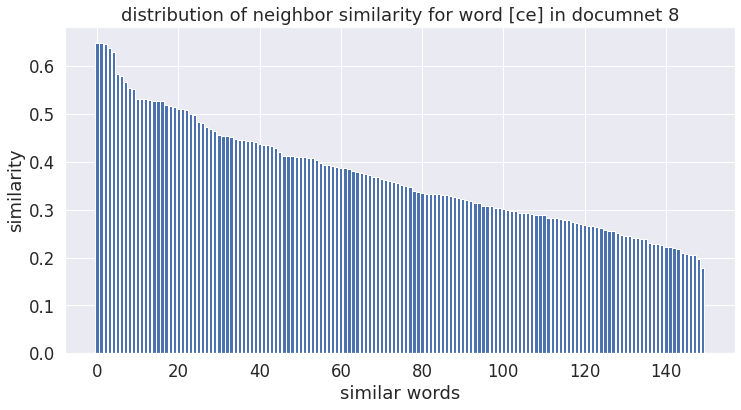

65   -->  ##aus
1690
[0.6503028, 0.6453934, 0.62183994, 0.5905193, 0.5570357, 0.5378114, 0.5245317, 0.5232576, 0.50821465, 0.5016824, 0.50007784, 0.4912039, 0.48195916, 0.48053336, 0.47953272, 0.4763119, 0.46416277, 0.46342623, 0.459101, 0.45758927, 0.4539956, 0.45377433, 0.45365694, 0.45022804, 0.44774657, 0.4461707, 0.44500905, 0.43789202, 0.43499312, 0.43188834, 0.42997563, 0.42537767, 0.42176163, 0.41787696, 0.41692838, 0.414141, 0.4096529, 0.40344205, 0.40144783, 0.3953412, 0.39464647, 0.39346442, 0.38406283, 0.38048184, 0.38034117, 0.37959713, 0.37187827, 0.3694843, 0.3611838, 0.35430652, 0.35137168, 0.342613, 0.34254125, 0.34132856, 0.3391267, 0.33626333, 0.3347615, 0.3334123, 0.3314173, 0.33129925, 0.32837456, 0.3283477, 0.3274346, 0.32497954, 0.3249689, 0.32341886, 0.32211244, 0.3160519, 0.3154227, 0.3130935, 0.31098086, 0.30908138, 0.30610397, 0.30436832, 0.3043066, 0.30270392, 0.30182773, 0.30052018, 0.29904956, 0.29827976, 0.29691142, 0.2899125, 0.28682026, 0.28528434, 0.28

66   -->  ##escu
1690
[0.6490196, 0.6390584, 0.63297236, 0.6323769, 0.6323359, 0.6232438, 0.6124755, 0.60462004, 0.5980167, 0.59454197, 0.57894063, 0.5741718, 0.5730338, 0.5655155, 0.557233, 0.5557537, 0.5453499, 0.5313467, 0.5304074, 0.52894557, 0.51780355, 0.51551414, 0.51163024, 0.5097831, 0.5076827, 0.5041474, 0.50292134, 0.5011989, 0.49888146, 0.4911403, 0.48356587, 0.47579563, 0.4756865, 0.47550252, 0.46596262, 0.46207088, 0.4618538, 0.46133864, 0.45782137, 0.45086008, 0.44718605, 0.44563362, 0.43954873, 0.43262258, 0.43185648, 0.43142134, 0.4302757, 0.4282713, 0.42726308, 0.4231755, 0.4210677, 0.42031336, 0.4177186, 0.4169408, 0.41279352, 0.4047209, 0.40460068, 0.40413684, 0.4036203, 0.40123397, 0.4006992, 0.4002205, 0.39562964, 0.39297837, 0.39147276, 0.39105693, 0.38850152, 0.38569883, 0.385533, 0.38512695, 0.3831363, 0.38187754, 0.3813029, 0.37938458, 0.3786842, 0.3777189, 0.3758529, 0.3723395, 0.36985368, 0.36838174, 0.36508006, 0.36257124, 0.3618119, 0.36121708, 0.35355443,

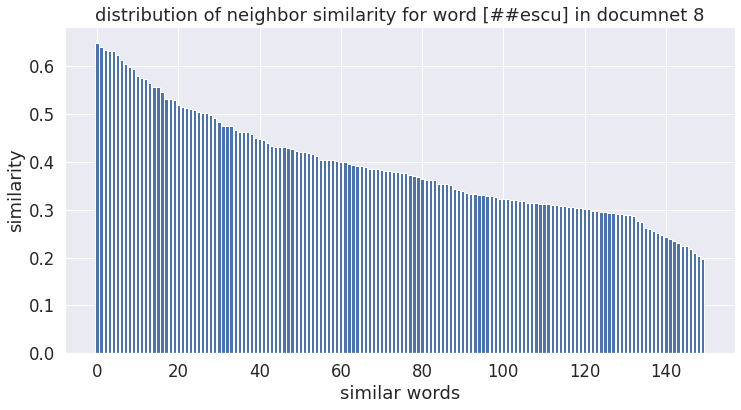

67   -->  dictatorship
1690
[0.69297427, 0.6875329, 0.6817442, 0.68173265, 0.65748125, 0.65020895, 0.643101, 0.6413695, 0.6187767, 0.603005, 0.6007136, 0.5378355, 0.53272045, 0.5269911, 0.52200025, 0.51680917, 0.5146602, 0.5128678, 0.50944114, 0.5069616, 0.4988876, 0.4933297, 0.49116212, 0.4905334, 0.48804417, 0.47733793, 0.4761697, 0.47506207, 0.46852946, 0.46824798, 0.46816963, 0.4648989, 0.4631406, 0.45488384, 0.45350805, 0.4529075, 0.44796708, 0.44700885, 0.44136053, 0.43428886, 0.4326049, 0.4324905, 0.43153292, 0.43053612, 0.42822218, 0.42688492, 0.42671165, 0.4240806, 0.42362177, 0.42325932, 0.4203008, 0.41987932, 0.41983765, 0.4197341, 0.41830313, 0.41709095, 0.41662621, 0.41344786, 0.41207445, 0.41203755, 0.41089278, 0.40745977, 0.4046231, 0.40441287, 0.40305847, 0.40252185, 0.40247598, 0.4017397, 0.4016599, 0.40105593, 0.39842322, 0.3971515, 0.39698482, 0.3956088, 0.3911686, 0.38474497, 0.38289365, 0.38179243, 0.38096774, 0.3806848, 0.37558588, 0.37486175, 0.37216848, 0.371425

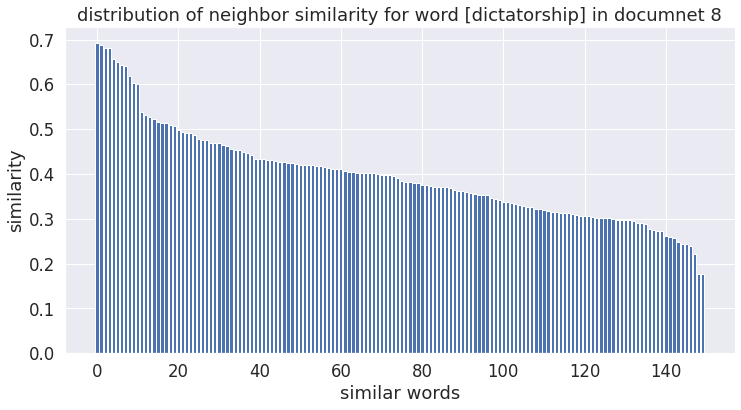

70   -->  popular
1690
[0.85373175, 0.7675331, 0.76736724, 0.7146265, 0.68990314, 0.6440315, 0.5944456, 0.5862771, 0.5607979, 0.53829396, 0.52651536, 0.5232743, 0.51895875, 0.5185489, 0.5167727, 0.51351583, 0.50548375, 0.5034683, 0.50320303, 0.49827737, 0.49400043, 0.48988783, 0.4886189, 0.47544155, 0.47388357, 0.47352576, 0.47335917, 0.47041404, 0.4693799, 0.46381, 0.463351, 0.46285352, 0.46054077, 0.46053767, 0.45995954, 0.45280135, 0.4525914, 0.45220762, 0.44951096, 0.4460355, 0.44566327, 0.44350308, 0.44226986, 0.43936637, 0.43903238, 0.43900856, 0.43831205, 0.43732524, 0.4365222, 0.43402904, 0.43210846, 0.4316076, 0.43151742, 0.43135887, 0.43057093, 0.43034512, 0.42821798, 0.42655534, 0.42443871, 0.42323542, 0.421301, 0.42027238, 0.41987166, 0.41920117, 0.4160663, 0.41524023, 0.41446236, 0.41351914, 0.41284433, 0.41016644, 0.40938908, 0.40726823, 0.4061897, 0.40421024, 0.39581126, 0.39217216, 0.3903786, 0.39028487, 0.3858844, 0.3831873, 0.38314205, 0.37906748, 0.37730497, 0.376016

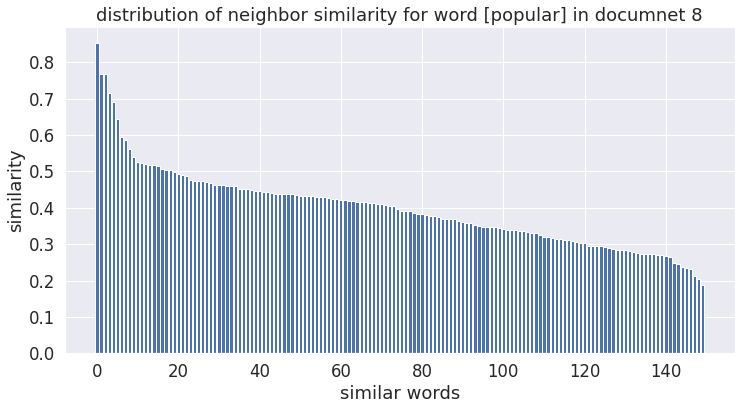

71   -->  uprising
1690
[0.85373175, 0.82320094, 0.8102258, 0.77113336, 0.7540874, 0.71331024, 0.6425593, 0.5879476, 0.5579022, 0.5510653, 0.54817134, 0.547904, 0.5417151, 0.5402022, 0.5257419, 0.5241056, 0.5219003, 0.51814544, 0.51603127, 0.5105416, 0.5045614, 0.500538, 0.49991897, 0.49413902, 0.49376664, 0.49214166, 0.4909351, 0.48823613, 0.48721457, 0.48518628, 0.48412213, 0.48109424, 0.4804746, 0.4795487, 0.474122, 0.47136173, 0.4677931, 0.46545193, 0.46098876, 0.4576282, 0.45741925, 0.45124516, 0.45066452, 0.4504335, 0.44889542, 0.44747925, 0.44527325, 0.4420394, 0.4416129, 0.4373616, 0.43676674, 0.4358819, 0.4357834, 0.4353385, 0.43172926, 0.42700157, 0.42610097, 0.42540866, 0.42189938, 0.4201373, 0.4176209, 0.41682667, 0.41628695, 0.4152186, 0.41515437, 0.41228443, 0.41107547, 0.40771532, 0.4076097, 0.40262622, 0.39818722, 0.39376444, 0.39232135, 0.39217845, 0.38775632, 0.38330698, 0.37943205, 0.3786977, 0.3783787, 0.3756626, 0.37345463, 0.37243325, 0.37127018, 0.3707453, 0.3697

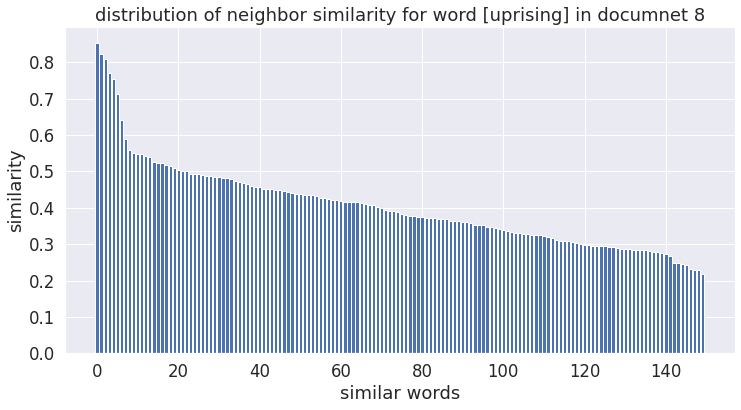

72   -->  swept
1690
[0.83377075, 0.8284604, 0.82320094, 0.81843483, 0.76736724, 0.7276036, 0.63062155, 0.6098504, 0.60325956, 0.59094423, 0.58557296, 0.5812027, 0.55404043, 0.5453487, 0.54158556, 0.54028416, 0.53840405, 0.537618, 0.5200019, 0.51806164, 0.5162164, 0.5133975, 0.5096851, 0.50505435, 0.49982792, 0.4992184, 0.49520713, 0.4941851, 0.4937941, 0.49127367, 0.48503584, 0.48316786, 0.47603023, 0.4714641, 0.46985242, 0.46832657, 0.46830893, 0.46736747, 0.4617054, 0.46154225, 0.45777437, 0.4557634, 0.455592, 0.45494565, 0.4541151, 0.4535171, 0.45244598, 0.4498735, 0.44957218, 0.4469975, 0.44096804, 0.43878368, 0.43294704, 0.4282844, 0.42709404, 0.42463246, 0.42410296, 0.42407992, 0.42191848, 0.41843212, 0.41766867, 0.4169697, 0.4131737, 0.41272208, 0.4103793, 0.40759307, 0.4071848, 0.40615457, 0.4048005, 0.40212184, 0.39816332, 0.3911018, 0.3904173, 0.38972396, 0.3877678, 0.38472587, 0.38442832, 0.38358328, 0.38139132, 0.37990797, 0.37868, 0.37843752, 0.37500268, 0.37435606, 0.367

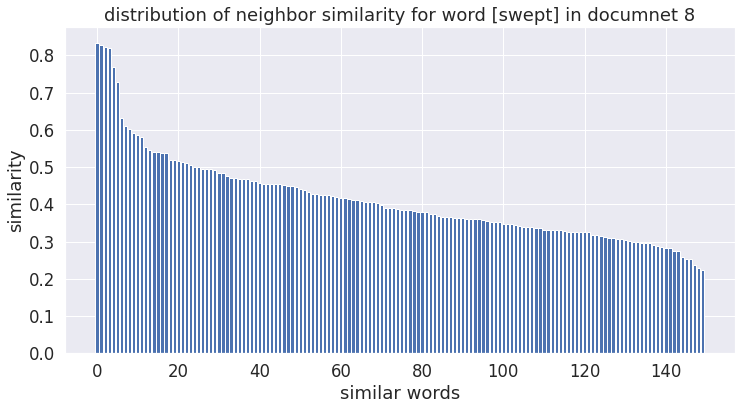

76   -->  power
1690
[0.84131074, 0.83961684, 0.8284604, 0.8102258, 0.7675331, 0.68121886, 0.63862103, 0.61350596, 0.61019826, 0.5720539, 0.5707464, 0.55012554, 0.5480055, 0.5465509, 0.54218036, 0.5381424, 0.5370182, 0.53696847, 0.5365163, 0.5327095, 0.5304805, 0.5280328, 0.523666, 0.52156866, 0.5178889, 0.5069475, 0.506389, 0.5056971, 0.50435066, 0.49856436, 0.49523187, 0.4934104, 0.48957294, 0.48453772, 0.48308653, 0.48287347, 0.481603, 0.47562253, 0.4728021, 0.47192377, 0.47110054, 0.47105458, 0.4664092, 0.46542817, 0.4632503, 0.4630643, 0.4595309, 0.45621276, 0.45535374, 0.45009774, 0.44921994, 0.44852698, 0.44735247, 0.44619107, 0.44618487, 0.44589752, 0.44463605, 0.4436361, 0.44243696, 0.44044295, 0.43964708, 0.43635473, 0.43629795, 0.43490252, 0.42319387, 0.4205557, 0.416871, 0.4161185, 0.41389608, 0.41213533, 0.41114348, 0.4072882, 0.4058173, 0.40326375, 0.4019209, 0.3992929, 0.3978631, 0.3977784, 0.39379203, 0.38619632, 0.38587797, 0.38063866, 0.37455714, 0.37389418, 0.3728070

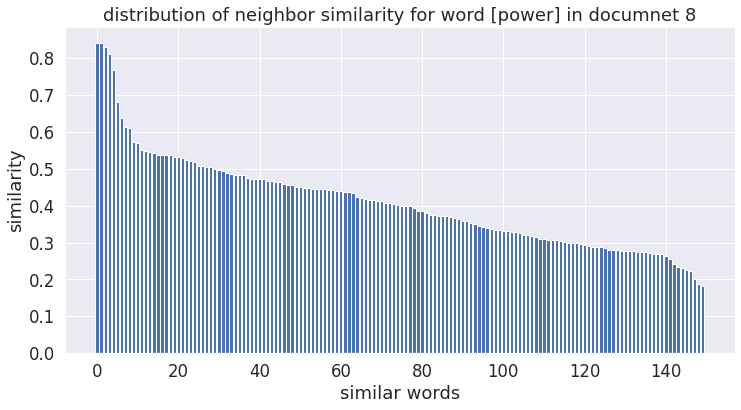

78   -->  went
1690
[0.699863, 0.6778988, 0.67295337, 0.6611957, 0.6577549, 0.64345014, 0.64170647, 0.6357259, 0.61421335, 0.60811853, 0.596218, 0.581862, 0.5732179, 0.5655966, 0.5589754, 0.55277276, 0.55110455, 0.54834384, 0.53161716, 0.52750766, 0.52706957, 0.5258242, 0.5168387, 0.506047, 0.5041789, 0.49884453, 0.4960028, 0.4720801, 0.47200638, 0.4712668, 0.47005546, 0.46985242, 0.46835697, 0.4678257, 0.46713668, 0.46372744, 0.45535374, 0.44817072, 0.43952733, 0.43831208, 0.42986053, 0.42700157, 0.42443871, 0.41743684, 0.3988125, 0.39688867, 0.3959862, 0.39485854, 0.39472342, 0.3944565, 0.3932077, 0.38768297, 0.38322693, 0.3817897, 0.37742218, 0.37581572, 0.36815503, 0.36740118, 0.3648123, 0.36466908, 0.36427015, 0.36248294, 0.36195052, 0.36153644, 0.36149037, 0.35691357, 0.3559357, 0.35480607, 0.3539551, 0.35194132, 0.35004753, 0.3497206, 0.34276986, 0.3410998, 0.33718616, 0.3367509, 0.3352061, 0.3302344, 0.32936305, 0.3271016, 0.32686272, 0.3254062, 0.32354143, 0.31786168, 0.317063

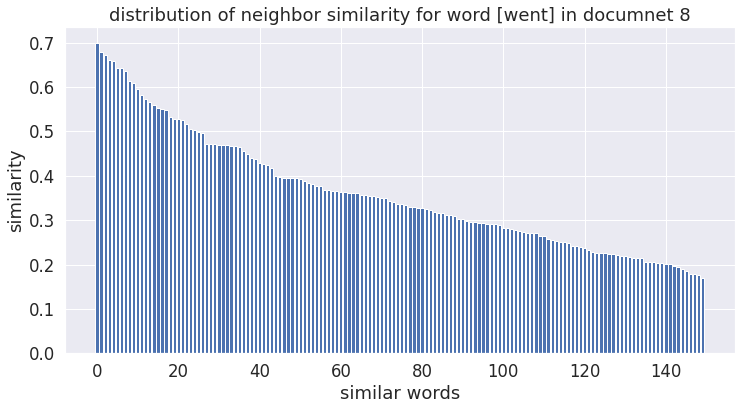

81   -->  national
1690
[0.6245438, 0.60918105, 0.5992473, 0.581862, 0.5617782, 0.55089605, 0.54730016, 0.5272391, 0.5270176, 0.52684796, 0.524433, 0.5198948, 0.51778805, 0.5134349, 0.5089202, 0.50379, 0.5025865, 0.5009674, 0.4982728, 0.48576632, 0.48419133, 0.47423345, 0.47352576, 0.47127807, 0.45424417, 0.45216256, 0.4507087, 0.44735247, 0.44234335, 0.44145298, 0.4407033, 0.43933895, 0.4390635, 0.43518102, 0.43423805, 0.42610097, 0.4194822, 0.415734, 0.41508162, 0.4138549, 0.4122169, 0.41119954, 0.40715086, 0.39956287, 0.39874655, 0.39816332, 0.3957801, 0.3941269, 0.38895684, 0.38854712, 0.38671473, 0.37823355, 0.36921164, 0.36903235, 0.36426866, 0.363375, 0.36130697, 0.3566182, 0.35562646, 0.35441297, 0.35226268, 0.35209453, 0.35077608, 0.3498311, 0.34662443, 0.34620872, 0.34027976, 0.33908463, 0.3363081, 0.33415478, 0.32722867, 0.32480368, 0.32359582, 0.32348928, 0.32263374, 0.31627277, 0.31524044, 0.31289005, 0.30529088, 0.303267, 0.30279097, 0.30272394, 0.29421663, 0.2923007, 0.2

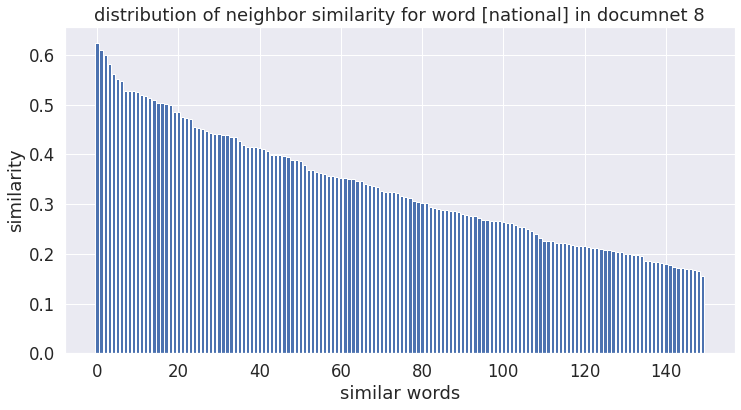

82   -->  television
1690
[0.62896645, 0.626909, 0.5958126, 0.578578, 0.57557464, 0.5568689, 0.5465722, 0.54453784, 0.5403211, 0.5393846, 0.53384435, 0.5231379, 0.5186264, 0.50685585, 0.5059715, 0.5056237, 0.48821655, 0.4827984, 0.48211545, 0.47949106, 0.47605562, 0.47465068, 0.4728199, 0.4682727, 0.4664145, 0.46518975, 0.4641176, 0.45990524, 0.44182104, 0.43949527, 0.43653536, 0.43406743, 0.43150863, 0.4284293, 0.42797324, 0.42335337, 0.41881537, 0.40740478, 0.40703434, 0.4040631, 0.402916, 0.40138292, 0.3994803, 0.39704484, 0.3922197, 0.38715917, 0.3846017, 0.3810295, 0.37354448, 0.36473465, 0.36408383, 0.36111522, 0.36105293, 0.34743083, 0.3455992, 0.3453875, 0.34417915, 0.34199685, 0.34065714, 0.33854073, 0.3376258, 0.33292553, 0.32965827, 0.32697523, 0.32569999, 0.3239228, 0.32300174, 0.32226795, 0.3209201, 0.3190501, 0.31900507, 0.31735742, 0.3157267, 0.30868465, 0.30668342, 0.3058533, 0.30446434, 0.30413312, 0.30385143, 0.30127057, 0.3005638, 0.29780212, 0.2977994, 0.29415432, 0

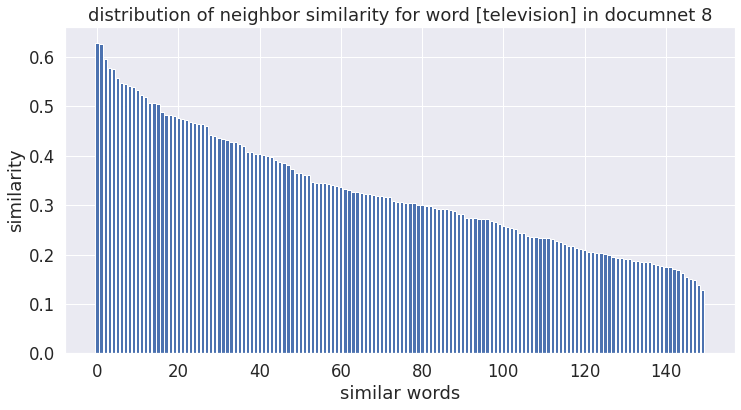

84   -->  announce
1690
[0.7270993, 0.6314661, 0.6242763, 0.61659586, 0.6131353, 0.6013807, 0.596218, 0.59320337, 0.5764273, 0.5726463, 0.5536283, 0.5536097, 0.55089605, 0.54324603, 0.5419042, 0.5336002, 0.52223706, 0.50704664, 0.5003884, 0.49675483, 0.49578664, 0.4889279, 0.4871958, 0.48514593, 0.48163086, 0.4809541, 0.4799848, 0.47136277, 0.4699826, 0.45969954, 0.45394006, 0.44990778, 0.44921994, 0.4460528, 0.4439342, 0.4420394, 0.43732524, 0.43612573, 0.43005964, 0.42793772, 0.42407992, 0.41848662, 0.414581, 0.4115659, 0.40818584, 0.4080991, 0.3996783, 0.3949353, 0.39100203, 0.3906275, 0.39035034, 0.38890064, 0.3854003, 0.38538957, 0.38422474, 0.380925, 0.37477282, 0.3711546, 0.36971402, 0.36845005, 0.36801916, 0.36775994, 0.3672933, 0.36290255, 0.3607787, 0.35728616, 0.35576397, 0.35307616, 0.3502581, 0.3492731, 0.34756768, 0.34752506, 0.34547803, 0.3441748, 0.33424783, 0.33422077, 0.333207, 0.3324765, 0.3260076, 0.3257761, 0.3247314, 0.32327658, 0.31886417, 0.31879693, 0.31353146,

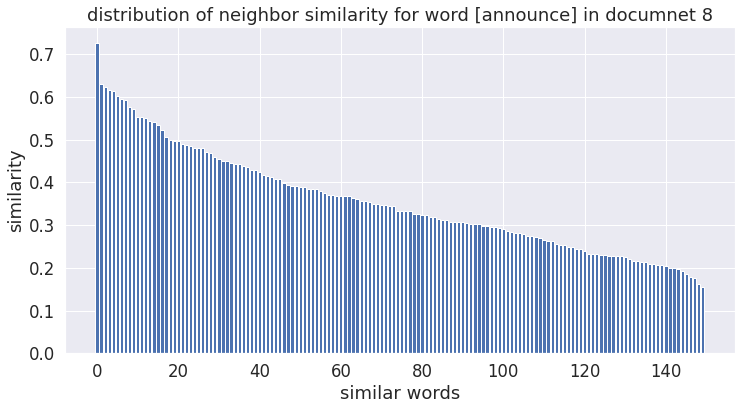

86   -->  special
1690
[0.71761715, 0.6265923, 0.6245438, 0.61659586, 0.60961556, 0.601599, 0.5918059, 0.5719707, 0.55058825, 0.538167, 0.5361749, 0.5339731, 0.52944696, 0.5258783, 0.5175892, 0.5140989, 0.5097689, 0.506047, 0.5002237, 0.49983054, 0.4973774, 0.49346173, 0.4886189, 0.48664856, 0.48633122, 0.48278376, 0.48197705, 0.46511385, 0.45346844, 0.45330858, 0.44665682, 0.44044295, 0.43888354, 0.43702823, 0.43530673, 0.4332017, 0.4310976, 0.43057448, 0.42989376, 0.42277572, 0.41990262, 0.41684324, 0.41682667, 0.41542938, 0.41272208, 0.41136017, 0.40849453, 0.4073715, 0.4073586, 0.40526372, 0.4034094, 0.40324923, 0.3947723, 0.39384922, 0.39192194, 0.38880408, 0.386912, 0.38555324, 0.383731, 0.38348892, 0.38319463, 0.37848797, 0.37844622, 0.37426728, 0.374187, 0.36674267, 0.36514515, 0.358739, 0.3583824, 0.35766107, 0.35717642, 0.35260865, 0.34896493, 0.34832597, 0.34694415, 0.3385319, 0.3381976, 0.33450824, 0.3343669, 0.33191967, 0.330109, 0.3298822, 0.32476744, 0.32219046, 0.317849

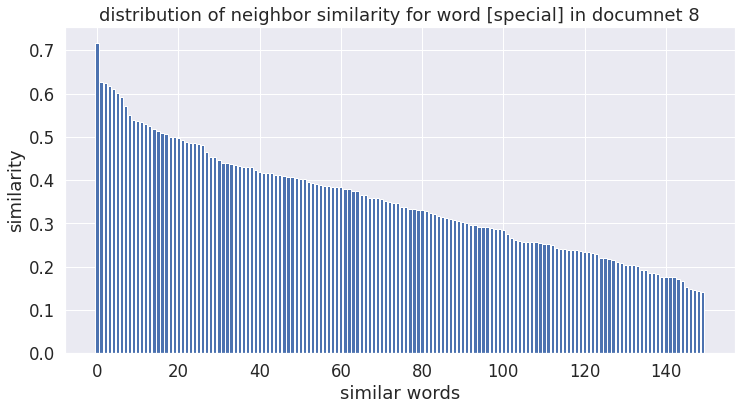

87   -->  congress
1690
[0.71761715, 0.6314661, 0.5771043, 0.5580572, 0.54850066, 0.54730016, 0.54449785, 0.54378104, 0.52425385, 0.52348936, 0.5168387, 0.50890064, 0.5000205, 0.49431866, 0.48500502, 0.48489898, 0.47980243, 0.47901624, 0.47329575, 0.47107375, 0.46733278, 0.45517352, 0.45425525, 0.45401683, 0.45339108, 0.4475687, 0.4449191, 0.43243605, 0.42451683, 0.42344064, 0.4219169, 0.4195686, 0.4176209, 0.416871, 0.4161084, 0.4148296, 0.41334343, 0.40726823, 0.40446365, 0.40386623, 0.4032904, 0.3994884, 0.395915, 0.39563608, 0.39252973, 0.3830217, 0.38249665, 0.37990797, 0.37845698, 0.37754256, 0.3728451, 0.37174356, 0.3700763, 0.36922175, 0.3687095, 0.36660868, 0.36583334, 0.36359373, 0.3635564, 0.35495353, 0.35324168, 0.35268077, 0.34949183, 0.34796602, 0.33566588, 0.33565867, 0.33557582, 0.329896, 0.32405657, 0.32391205, 0.3229093, 0.3198831, 0.31979746, 0.3169766, 0.3161866, 0.31351817, 0.31218573, 0.311193, 0.30376977, 0.30363846, 0.30306166, 0.30130196, 0.29882807, 0.29872108

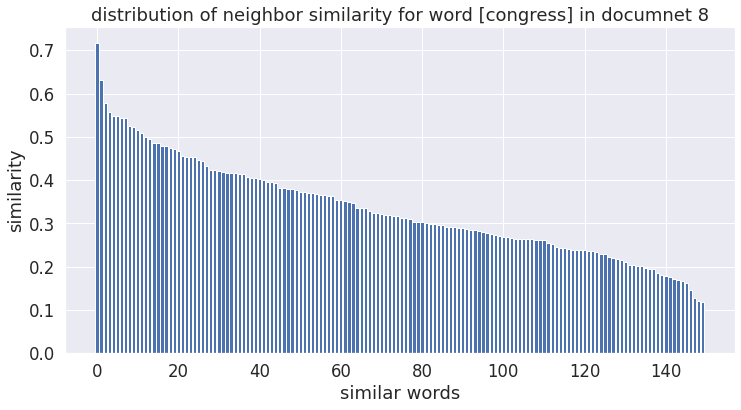

90   -->  message
1690
[0.7479491, 0.72830504, 0.71831167, 0.70135343, 0.69600475, 0.64345014, 0.6277529, 0.6242763, 0.6087694, 0.5914114, 0.580468, 0.5799272, 0.57950056, 0.56402206, 0.55908316, 0.55738974, 0.5450057, 0.5421996, 0.5402022, 0.5388704, 0.524433, 0.52415335, 0.51901174, 0.5178889, 0.51721174, 0.5097978, 0.5097689, 0.50890064, 0.50559413, 0.5037482, 0.50221604, 0.4941851, 0.4914388, 0.48976162, 0.48975942, 0.48751116, 0.48542005, 0.48138142, 0.48095858, 0.47916713, 0.47764355, 0.47225612, 0.46663296, 0.46361133, 0.46285352, 0.45574477, 0.45397174, 0.4511375, 0.4472145, 0.4443242, 0.43932432, 0.4284425, 0.42516947, 0.42068547, 0.41970623, 0.41622657, 0.41454515, 0.4144948, 0.41329122, 0.4132498, 0.41065454, 0.41047043, 0.4096125, 0.40604496, 0.40561092, 0.4053499, 0.40497342, 0.4045754, 0.40314716, 0.39923394, 0.39889142, 0.39556682, 0.39139163, 0.38990933, 0.38929665, 0.38822472, 0.38803723, 0.3850107, 0.38380712, 0.38116184, 0.37956417, 0.3757276, 0.37302852, 0.37067738,

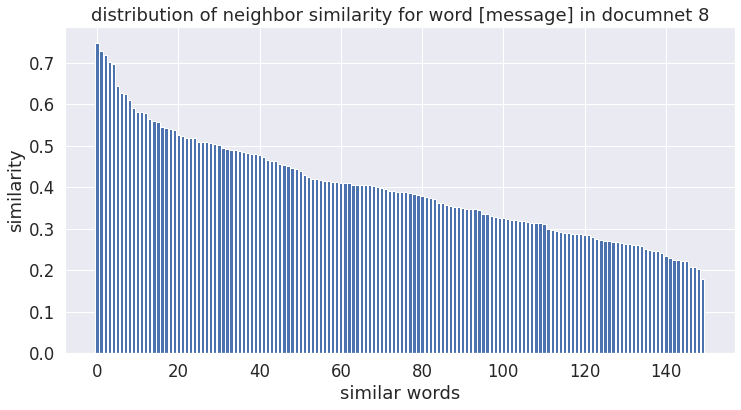

92   -->  repeated
1690
[0.8412219, 0.8105246, 0.7479491, 0.6060389, 0.56410587, 0.5589754, 0.5568191, 0.5541896, 0.54460293, 0.5415807, 0.54136026, 0.5257087, 0.5195125, 0.508908, 0.50473064, 0.5021327, 0.5003884, 0.49486426, 0.49211392, 0.49127367, 0.48881727, 0.48453146, 0.4804746, 0.47747257, 0.47698045, 0.47293854, 0.47183925, 0.47105458, 0.46103778, 0.45615315, 0.4557491, 0.4520924, 0.44945192, 0.4474568, 0.44474915, 0.44085604, 0.4407033, 0.43402904, 0.42901033, 0.4284615, 0.42814627, 0.42802665, 0.42743835, 0.42672807, 0.4226768, 0.4189554, 0.41684324, 0.41146433, 0.40673786, 0.4033073, 0.40164155, 0.401106, 0.4008308, 0.40003538, 0.39788955, 0.39744544, 0.39711088, 0.3959891, 0.395915, 0.39497426, 0.39441615, 0.39277944, 0.39213255, 0.3906262, 0.39051792, 0.38981283, 0.38870585, 0.3803121, 0.38025382, 0.37670857, 0.37448174, 0.3734209, 0.3710084, 0.3701615, 0.3654041, 0.3651693, 0.36326313, 0.36186337, 0.36185974, 0.36030734, 0.35959643, 0.3579647, 0.35791624, 0.3522706, 0.350

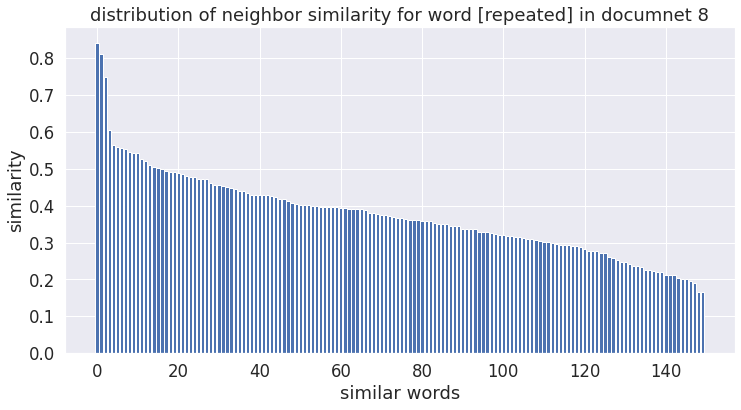

93   -->  today
1690
[0.8412219, 0.74811506, 0.72830504, 0.6110631, 0.5855516, 0.57854223, 0.5634996, 0.5592338, 0.55277276, 0.55094075, 0.5366136, 0.5354082, 0.535059, 0.5187652, 0.5154994, 0.5139732, 0.5134349, 0.50866306, 0.5071649, 0.50704664, 0.4979387, 0.49649057, 0.49547517, 0.49478048, 0.49162138, 0.48778802, 0.4844911, 0.47136173, 0.46830893, 0.4632503, 0.45821208, 0.44999027, 0.4464203, 0.4400776, 0.4385934, 0.4376351, 0.43702823, 0.43075186, 0.43034512, 0.42904237, 0.42870897, 0.42835373, 0.42797047, 0.42778802, 0.42641884, 0.4254759, 0.4180118, 0.41789097, 0.41729504, 0.4161084, 0.41477668, 0.41395473, 0.41024244, 0.4073671, 0.3994948, 0.39916608, 0.3986905, 0.3972957, 0.3951319, 0.39255244, 0.39235055, 0.39177415, 0.39054632, 0.388138, 0.38620734, 0.38243252, 0.38218385, 0.38094974, 0.37904596, 0.37708873, 0.37179032, 0.36788943, 0.36733148, 0.3658952, 0.36334926, 0.36207116, 0.36143863, 0.35633594, 0.3551937, 0.3543594, 0.35395566, 0.3489269, 0.34891108, 0.3454746, 0.3441

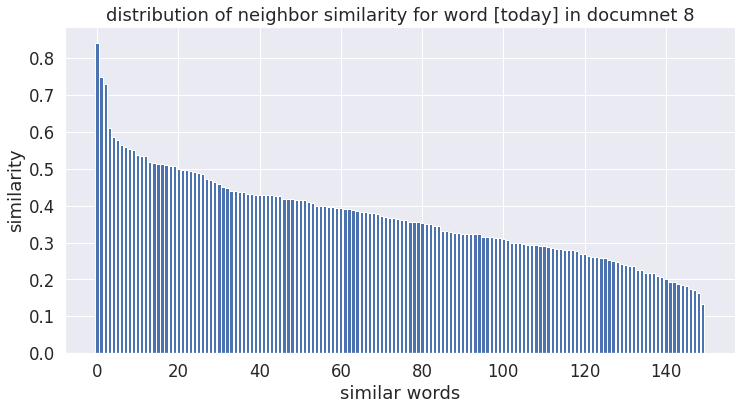

96   -->  rum
1690
[0.7540312, 0.54799867, 0.52684796, 0.5214875, 0.49613726, 0.48769093, 0.48197705, 0.4804457, 0.47747636, 0.46070385, 0.4489728, 0.44483054, 0.44313473, 0.4393409, 0.4383363, 0.4369433, 0.43002152, 0.4289429, 0.4278739, 0.42723367, 0.42446768, 0.4243437, 0.42055362, 0.41970623, 0.41840252, 0.41743684, 0.4166554, 0.41351914, 0.41348302, 0.4120275, 0.40674925, 0.40513065, 0.3956504, 0.3934309, 0.39254022, 0.38300312, 0.38280928, 0.38249665, 0.3806351, 0.38040185, 0.37843752, 0.37670857, 0.3746388, 0.37430942, 0.37430537, 0.37389418, 0.3732608, 0.372618, 0.37239805, 0.37130636, 0.36932996, 0.36801916, 0.3680098, 0.36738235, 0.36733148, 0.3662269, 0.36223942, 0.35743105, 0.35602945, 0.35112524, 0.35014573, 0.34950656, 0.3462863, 0.34391606, 0.3420556, 0.33959827, 0.33708853, 0.33555108, 0.333089, 0.33030492, 0.3298326, 0.32594824, 0.32513866, 0.32279, 0.32194564, 0.3216126, 0.3182705, 0.3179082, 0.31539506, 0.3143363, 0.3099038, 0.3042167, 0.3026309, 0.3010664, 0.2987505

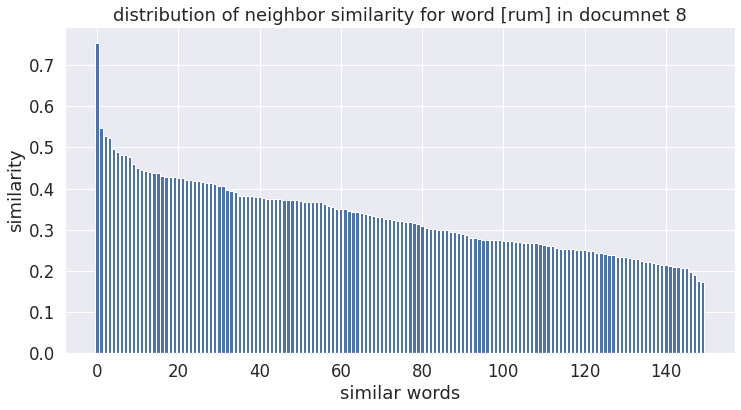

97   -->  ##anian
1690
[0.7540312, 0.5617782, 0.5259134, 0.47684973, 0.47151852, 0.46609402, 0.4654057, 0.45676112, 0.4483037, 0.44228986, 0.43932432, 0.43589208, 0.43564332, 0.43530673, 0.4342543, 0.4315611, 0.43075186, 0.42896798, 0.4282737, 0.42813936, 0.42785388, 0.42682016, 0.42630535, 0.42489254, 0.42182994, 0.42097962, 0.41877803, 0.41769487, 0.41628695, 0.41551203, 0.41446236, 0.41372192, 0.41228402, 0.41146433, 0.41040656, 0.40963602, 0.4048005, 0.40298277, 0.4019209, 0.39965037, 0.39760917, 0.3972971, 0.39563608, 0.39472342, 0.39380467, 0.39030358, 0.3899935, 0.3877148, 0.38729814, 0.38488042, 0.38422474, 0.3833462, 0.38328385, 0.38122416, 0.37988034, 0.37246203, 0.37210602, 0.36847517, 0.36832473, 0.36604923, 0.3656435, 0.36395693, 0.36347738, 0.36235023, 0.35687682, 0.3541001, 0.35231447, 0.3519135, 0.35182965, 0.3516959, 0.35163164, 0.35161182, 0.350493, 0.3496169, 0.34950373, 0.34855425, 0.3483607, 0.34826702, 0.34664565, 0.34108898, 0.3395468, 0.33797202, 0.33723247, 0.3

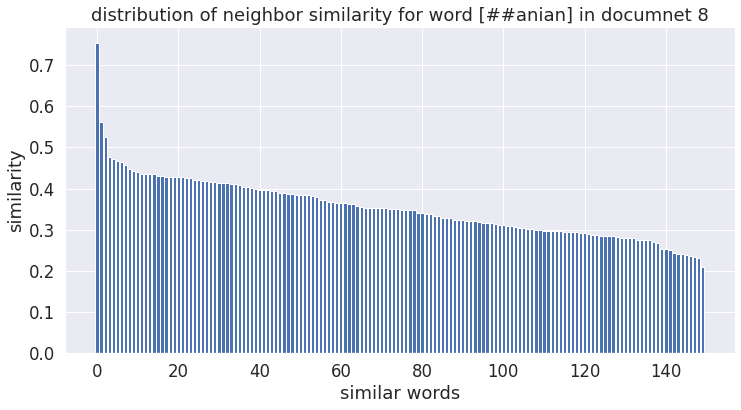

98   -->  newspapers
1690
[0.6774016, 0.6110631, 0.6094015, 0.6060389, 0.5893968, 0.57950056, 0.56275415, 0.5482998, 0.53458965, 0.53105396, 0.5259134, 0.52253616, 0.51814544, 0.50407284, 0.49997073, 0.48509395, 0.48287347, 0.47544155, 0.47423345, 0.47308528, 0.47005546, 0.46875197, 0.46859846, 0.46463886, 0.4627686, 0.46070385, 0.45861378, 0.45494565, 0.45427138, 0.45286888, 0.45241898, 0.44810525, 0.44680533, 0.4439342, 0.4434887, 0.44339895, 0.44322872, 0.4422725, 0.44114962, 0.42680907, 0.42269182, 0.42245525, 0.42027307, 0.4168886, 0.41550052, 0.41508567, 0.40689582, 0.40514642, 0.40060532, 0.39746708, 0.394607, 0.39252973, 0.39209783, 0.390257, 0.38671297, 0.38555324, 0.3833583, 0.37811488, 0.37535745, 0.37506318, 0.3733062, 0.37048584, 0.36968997, 0.36906785, 0.36887267, 0.3686126, 0.3610154, 0.3571675, 0.35579264, 0.35543874, 0.35468122, 0.35113147, 0.35030586, 0.35024753, 0.34843063, 0.3481967, 0.3468536, 0.34643942, 0.34181213, 0.3406567, 0.34015638, 0.33976865, 0.339081, 0.3

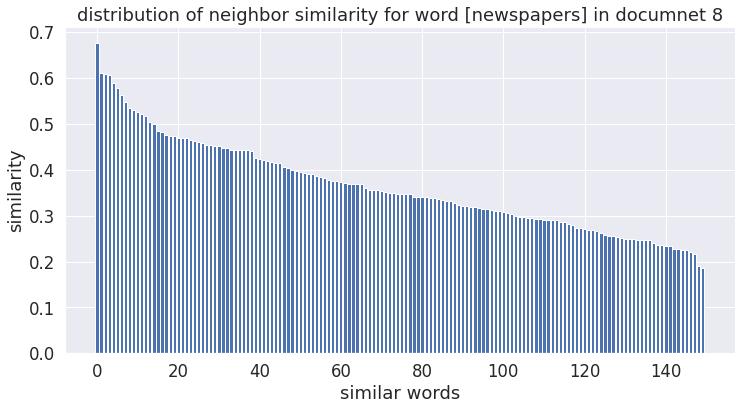

101   -->  like
1690
[0.5513332, 0.5469283, 0.5175687, 0.50866306, 0.48881727, 0.46859846, 0.4412044, 0.4372963, 0.42401308, 0.42220026, 0.4144948, 0.40354842, 0.39474612, 0.38882732, 0.3863886, 0.3839709, 0.37855244, 0.37763298, 0.37259185, 0.36773908, 0.36722052, 0.3659177, 0.36529964, 0.3648123, 0.36396715, 0.36361012, 0.36327198, 0.35931438, 0.35671446, 0.3534866, 0.34584123, 0.34571567, 0.34437042, 0.34393868, 0.33760786, 0.33424783, 0.32984912, 0.32740194, 0.32531238, 0.32346666, 0.3226999, 0.32127175, 0.31343636, 0.31007463, 0.30433422, 0.30420977, 0.3033319, 0.3017205, 0.29825422, 0.2976964, 0.29676425, 0.2923007, 0.28850853, 0.2865982, 0.28410846, 0.2837183, 0.2808264, 0.27939302, 0.279241, 0.2786235, 0.2777656, 0.27135956, 0.26803756, 0.26803267, 0.26745212, 0.266688, 0.2652437, 0.26232868, 0.26131758, 0.26027933, 0.25995862, 0.25960475, 0.2582233, 0.25738394, 0.25665972, 0.25659275, 0.25484362, 0.2530058, 0.25175965, 0.25161886, 0.24967, 0.24743418, 0.24554372, 0.24487387, 0

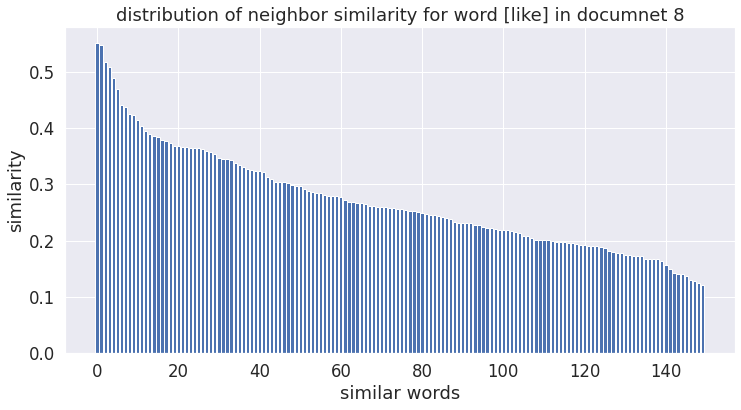

103   -->  television
1690
[0.6774016, 0.57854223, 0.5771521, 0.56402206, 0.5585577, 0.5469283, 0.54501, 0.54460293, 0.5272391, 0.52323747, 0.49845925, 0.49630126, 0.49322432, 0.49223673, 0.48957294, 0.48518628, 0.47684973, 0.476542, 0.47462732, 0.47399858, 0.4720801, 0.46880674, 0.46612602, 0.46585995, 0.46497208, 0.4631522, 0.4596655, 0.45395285, 0.45317942, 0.45244598, 0.44989765, 0.44974536, 0.4460355, 0.4438408, 0.4383363, 0.43738145, 0.43073538, 0.41967237, 0.41907325, 0.4187691, 0.4116623, 0.4110917, 0.4091928, 0.40849453, 0.39944577, 0.39879367, 0.39867458, 0.3945396, 0.3888537, 0.38748288, 0.38718444, 0.38538957, 0.3850835, 0.37870827, 0.37841833, 0.3758202, 0.3754753, 0.37432668, 0.37185076, 0.37161076, 0.37005597, 0.36909676, 0.3687095, 0.36790574, 0.36562523, 0.36369905, 0.36325908, 0.36178622, 0.36044115, 0.35849756, 0.35743338, 0.35630238, 0.35484433, 0.3532675, 0.35293603, 0.34990335, 0.34645808, 0.34632617, 0.3451382, 0.34257853, 0.3419143, 0.34141693, 0.33894038, 0.335

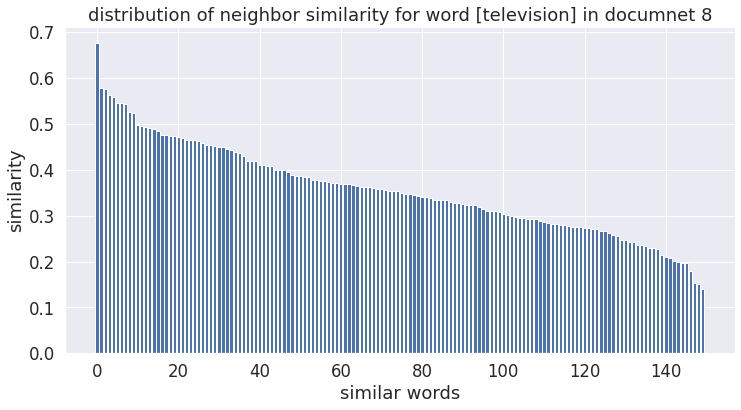

106   -->  controlled
1690
[0.7410589, 0.6684428, 0.5893968, 0.58073986, 0.5771521, 0.5749283, 0.5246755, 0.5175687, 0.5133975, 0.5056971, 0.4970848, 0.49162138, 0.48918068, 0.48805988, 0.4874588, 0.48453146, 0.48099142, 0.4756518, 0.46663296, 0.46301323, 0.46009412, 0.45623145, 0.45415753, 0.45066452, 0.45026678, 0.4487358, 0.44733277, 0.4418443, 0.44051424, 0.4400468, 0.43848127, 0.43828738, 0.4374403, 0.43507195, 0.4330579, 0.42916748, 0.42611706, 0.42594758, 0.42427334, 0.42391497, 0.4164406, 0.4161038, 0.41307664, 0.41250032, 0.4117098, 0.40874055, 0.40767044, 0.40365142, 0.4031795, 0.39896634, 0.398777, 0.39580387, 0.39485854, 0.39368165, 0.39028487, 0.38429958, 0.3833462, 0.380925, 0.38050795, 0.37791604, 0.37577218, 0.3702597, 0.36921164, 0.36737746, 0.36554313, 0.36084986, 0.35580438, 0.35413167, 0.35338396, 0.3476554, 0.34344268, 0.3430293, 0.34285572, 0.3418649, 0.3358943, 0.33244145, 0.3322394, 0.3301028, 0.32969344, 0.32963058, 0.3289198, 0.3272667, 0.3266664, 0.32220197, 

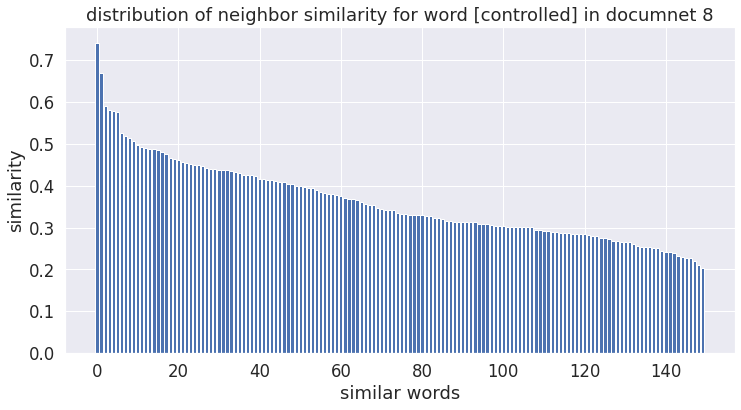

109   -->  country
1690
[0.6249528, 0.59552246, 0.5893475, 0.5841683, 0.5761636, 0.56777924, 0.5672802, 0.5620072, 0.5573941, 0.5502805, 0.5491804, 0.5451401, 0.54441464, 0.53934324, 0.53721684, 0.53521127, 0.5348893, 0.53407323, 0.52976775, 0.5248025, 0.5224218, 0.51897454, 0.5167998, 0.51347744, 0.51328087, 0.5111011, 0.51063406, 0.5091217, 0.5072631, 0.5008782, 0.49926853, 0.4939864, 0.4891373, 0.48799956, 0.4832156, 0.47716814, 0.47526523, 0.47510785, 0.47435504, 0.4734409, 0.4688249, 0.46797317, 0.4620763, 0.4605359, 0.46048367, 0.4477079, 0.44520697, 0.4444814, 0.44306624, 0.44221967, 0.44145346, 0.4398847, 0.43841028, 0.4377113, 0.4342903, 0.4326642, 0.4312065, 0.42509612, 0.424623, 0.4227016, 0.41947693, 0.41596675, 0.41386285, 0.4133351, 0.41206732, 0.40981662, 0.40840918, 0.40833795, 0.40672183, 0.40515637, 0.40327352, 0.40296757, 0.40136412, 0.40083545, 0.3997822, 0.3975472, 0.3960224, 0.39471942, 0.39334932, 0.38593042, 0.38560537, 0.38412192, 0.38396803, 0.38267982, 0.3818

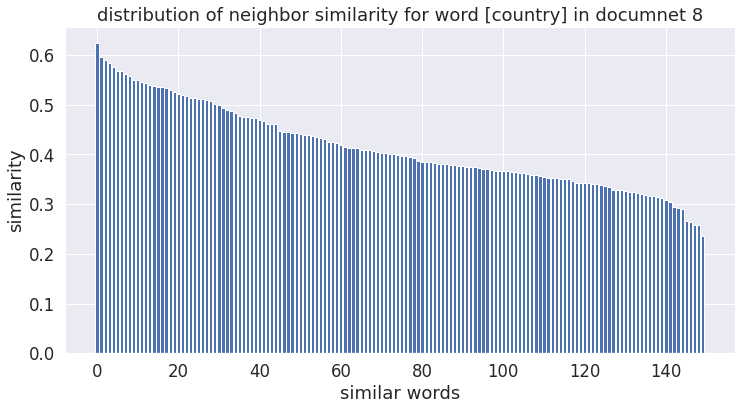

112   -->  new
1690
[0.7265017, 0.7165348, 0.70767915, 0.62688833, 0.6015774, 0.57336414, 0.5544466, 0.54408115, 0.5431004, 0.54187524, 0.53927463, 0.5352401, 0.52816594, 0.5171782, 0.51015484, 0.5038246, 0.5031879, 0.50145316, 0.50030243, 0.49878222, 0.49677017, 0.49293464, 0.4914333, 0.49079633, 0.49047792, 0.49027228, 0.49015528, 0.4863745, 0.4863268, 0.48332128, 0.48301873, 0.4827904, 0.47946495, 0.478698, 0.47798246, 0.47563314, 0.47354236, 0.47025964, 0.46566263, 0.46533448, 0.4576395, 0.45554915, 0.45510548, 0.45236278, 0.44751745, 0.44413465, 0.4425134, 0.4376627, 0.43729147, 0.43705046, 0.43703285, 0.43396574, 0.42499268, 0.42442578, 0.42346656, 0.4209115, 0.42074046, 0.4205702, 0.41953683, 0.41952568, 0.41933787, 0.41832203, 0.41578403, 0.41352224, 0.41181603, 0.41026223, 0.40916038, 0.40713686, 0.40640128, 0.40459228, 0.40322793, 0.4006173, 0.3985444, 0.39806625, 0.39761114, 0.39752012, 0.3963436, 0.39513952, 0.39512295, 0.3948583, 0.39377284, 0.39205223, 0.38970125, 0.38869

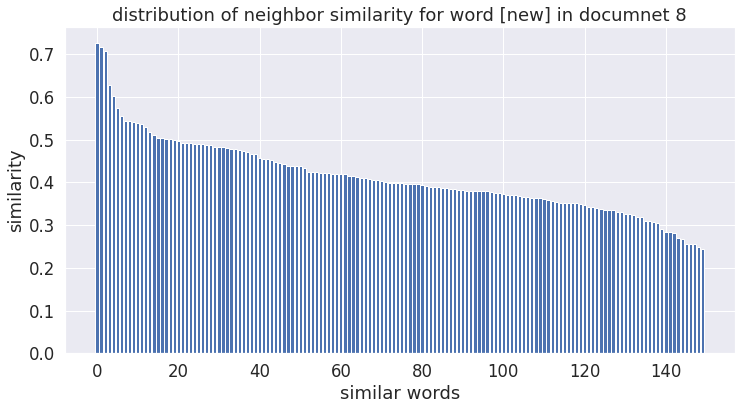

114   -->  non
1690
[0.76031524, 0.73356664, 0.62201023, 0.53874904, 0.5246755, 0.52166235, 0.5189243, 0.5175053, 0.51108766, 0.5066055, 0.50214285, 0.5015865, 0.49322432, 0.48701632, 0.48523358, 0.48427343, 0.47897592, 0.47732234, 0.47730464, 0.47569743, 0.47553647, 0.47331306, 0.47194096, 0.47110054, 0.46626246, 0.46621868, 0.46111965, 0.45840418, 0.45509747, 0.45293602, 0.4524458, 0.44322872, 0.44226986, 0.4410578, 0.44028515, 0.43902695, 0.43878368, 0.43722475, 0.43579456, 0.43363133, 0.43128514, 0.42853332, 0.42750287, 0.42470255, 0.42376527, 0.42182994, 0.4207869, 0.42049173, 0.41864792, 0.41714185, 0.41638505, 0.41631764, 0.41463143, 0.41228443, 0.41096282, 0.41072828, 0.4105257, 0.41036814, 0.40937597, 0.40895087, 0.4072138, 0.40715954, 0.40605438, 0.4049693, 0.40328872, 0.40004173, 0.39909697, 0.3989572, 0.3977077, 0.39655387, 0.3962971, 0.3956504, 0.3947723, 0.39271468, 0.39096957, 0.390109, 0.3877421, 0.38472798, 0.3831215, 0.3795582, 0.37931788, 0.37438443, 0.37337387, 0.37

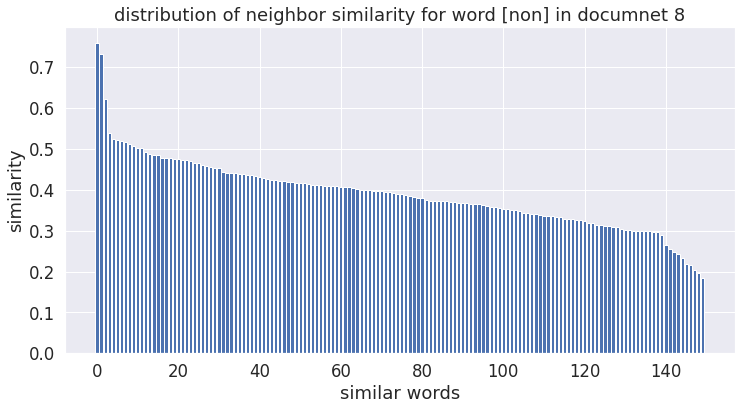

116   -->  communist
1690
[0.79733676, 0.76031524, 0.6232443, 0.6046198, 0.58073986, 0.56317437, 0.5563356, 0.55041665, 0.53471905, 0.52984685, 0.52495074, 0.52323747, 0.52253616, 0.5209842, 0.5178331, 0.5166543, 0.5112629, 0.49708214, 0.49575156, 0.49523187, 0.4923696, 0.49133098, 0.4890597, 0.48709005, 0.4844697, 0.48319802, 0.48318958, 0.48005188, 0.47931057, 0.47388357, 0.4738359, 0.4732929, 0.46585268, 0.4654057, 0.46279022, 0.45903736, 0.45740217, 0.455592, 0.4549157, 0.4526914, 0.4504335, 0.45039302, 0.44957113, 0.44295543, 0.439263, 0.43831334, 0.43719643, 0.4361816, 0.43558076, 0.43210107, 0.43076336, 0.42968, 0.4296757, 0.42964053, 0.4294041, 0.42929476, 0.4263345, 0.4258541, 0.4243437, 0.42418104, 0.4225015, 0.42044634, 0.41956788, 0.41948372, 0.41889137, 0.4175992, 0.41709507, 0.41618988, 0.41485256, 0.4144926, 0.41233122, 0.41136017, 0.41133398, 0.40834028, 0.40715086, 0.40597486, 0.40561092, 0.40545136, 0.40446365, 0.40210629, 0.39847025, 0.39840102, 0.39808697, 0.3955592

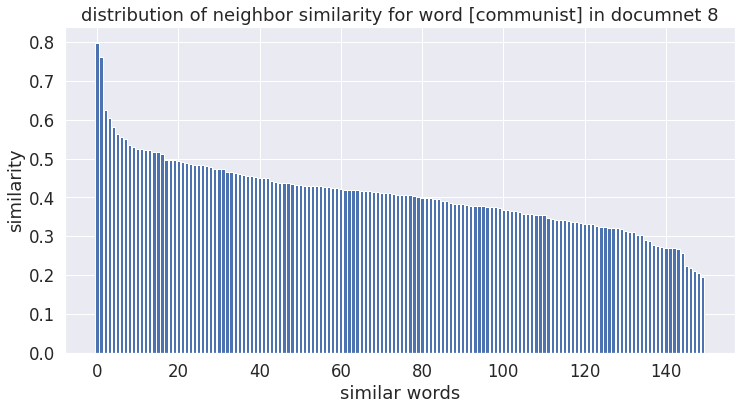

117   -->  leaders
1690
[0.79733676, 0.73356664, 0.70572674, 0.676278, 0.6684428, 0.663917, 0.619864, 0.6094015, 0.60661316, 0.56962657, 0.5585577, 0.55508476, 0.5486696, 0.5341749, 0.5330298, 0.5327095, 0.5218752, 0.5164996, 0.51603127, 0.5158018, 0.51512533, 0.5145515, 0.5133767, 0.50092995, 0.499576, 0.4992184, 0.49400043, 0.49064764, 0.4901342, 0.48982275, 0.47812843, 0.47625688, 0.47604394, 0.4752872, 0.47333997, 0.4709585, 0.4708901, 0.46821558, 0.46791565, 0.46762937, 0.46543133, 0.46497446, 0.46432677, 0.46198705, 0.45942944, 0.45898905, 0.45770994, 0.4549058, 0.4517869, 0.4511375, 0.4488385, 0.44404292, 0.44386226, 0.4413204, 0.44105715, 0.43508887, 0.4274146, 0.42624253, 0.42567998, 0.42489254, 0.42324215, 0.42280504, 0.42251405, 0.42162263, 0.421331, 0.42067486, 0.41950524, 0.41527203, 0.41490138, 0.4147814, 0.41439727, 0.41292635, 0.40991986, 0.40953982, 0.4080268, 0.40741017, 0.4073586, 0.40668744, 0.4055406, 0.4032904, 0.40164155, 0.40157402, 0.39806888, 0.3961463, 0.3951

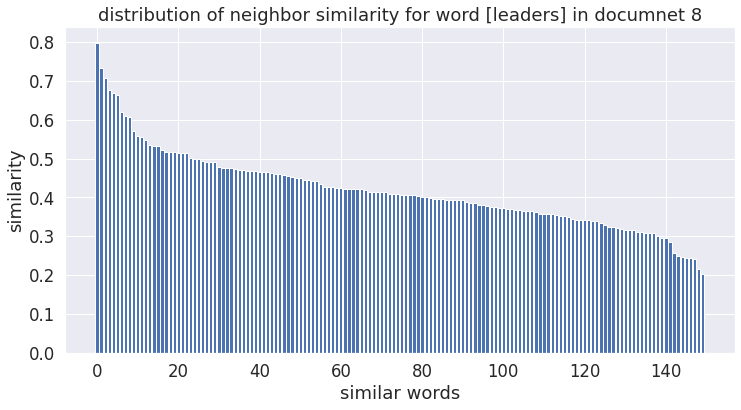

120   -->  many
1690
[0.7441053, 0.71029353, 0.7093446, 0.7067979, 0.6967592, 0.6928071, 0.6705374, 0.6578322, 0.65683615, 0.6449283, 0.6338201, 0.6302798, 0.607996, 0.58904564, 0.55905163, 0.5545677, 0.5491813, 0.5486696, 0.5419798, 0.5169867, 0.5166543, 0.5123381, 0.5116796, 0.5091642, 0.5043294, 0.49979508, 0.4918031, 0.48612368, 0.4840256, 0.48371106, 0.479541, 0.47730464, 0.4751078, 0.47452575, 0.47297302, 0.4723245, 0.46850026, 0.46836284, 0.4673178, 0.46301323, 0.46177262, 0.4615388, 0.46054402, 0.45857924, 0.45763174, 0.45715377, 0.4525927, 0.4515298, 0.45116907, 0.4504276, 0.4494213, 0.44917667, 0.44722366, 0.44675857, 0.44408768, 0.4420416, 0.43941832, 0.4391647, 0.4391204, 0.43696782, 0.4367493, 0.43498775, 0.4333696, 0.4329875, 0.43166897, 0.4303075, 0.42672807, 0.42463246, 0.419882, 0.41977745, 0.4192748, 0.41763884, 0.41512632, 0.41508567, 0.41485125, 0.413212, 0.4116623, 0.40967897, 0.40925708, 0.4071378, 0.4063037, 0.40497342, 0.4006222, 0.40005326, 0.3977784, 0.3965219

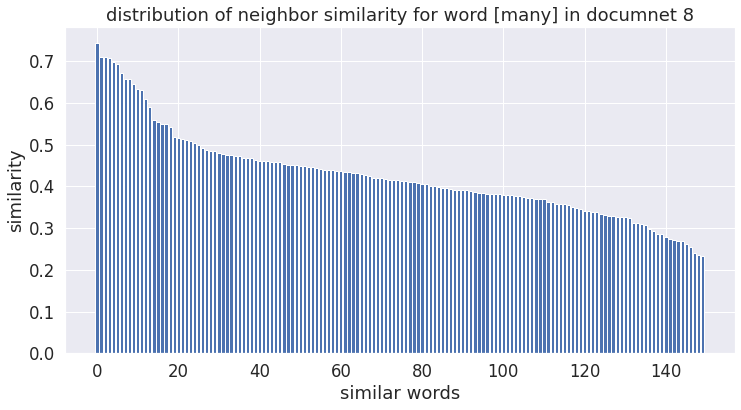

123   -->  party
1690
[0.57228714, 0.54994655, 0.52068365, 0.5147861, 0.5061723, 0.5030674, 0.48669446, 0.47562826, 0.4705108, 0.4607275, 0.45914477, 0.45208803, 0.45181286, 0.44709104, 0.44579202, 0.44373068, 0.44289303, 0.44096214, 0.4386797, 0.43748084, 0.43568742, 0.43518472, 0.4261012, 0.42059192, 0.41942543, 0.41564023, 0.4133087, 0.40937513, 0.40360332, 0.40212643, 0.39872223, 0.39834952, 0.39597994, 0.3904834, 0.3903222, 0.38934386, 0.38753742, 0.38658485, 0.38478398, 0.38364983, 0.38265026, 0.3809511, 0.37980157, 0.37972936, 0.37802047, 0.37799174, 0.3773126, 0.37585014, 0.37209946, 0.3704381, 0.36836678, 0.3667695, 0.36661962, 0.36654174, 0.3663162, 0.36478427, 0.3641356, 0.36352497, 0.36143118, 0.360546, 0.36025727, 0.36006957, 0.3596801, 0.3565854, 0.3564185, 0.35452223, 0.3544895, 0.35395676, 0.35377908, 0.35303092, 0.34134147, 0.34069836, 0.34035468, 0.340339, 0.33698282, 0.33617607, 0.3351015, 0.3349404, 0.33274823, 0.32992452, 0.32941484, 0.32690403, 0.32562074, 0.32435

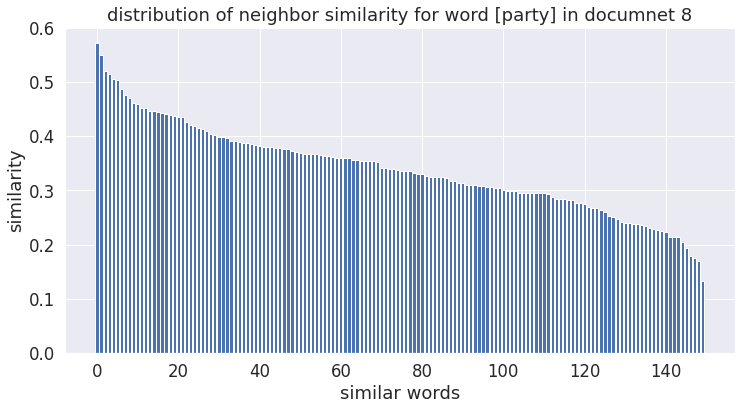

126   -->  leading
1690
[0.8327529, 0.7067979, 0.6668257, 0.663917, 0.645352, 0.63101923, 0.6046198, 0.5919076, 0.5860569, 0.57548326, 0.5704067, 0.5643882, 0.54698634, 0.5469274, 0.5424793, 0.53874904, 0.5336077, 0.5325923, 0.5324819, 0.52356786, 0.52011895, 0.5190749, 0.5184412, 0.5108297, 0.5106972, 0.5083395, 0.50464845, 0.501629, 0.4994802, 0.4970848, 0.4940095, 0.4940005, 0.4918874, 0.48818195, 0.4866306, 0.4840703, 0.48402122, 0.48346066, 0.48067796, 0.48025292, 0.47909763, 0.47763157, 0.47230202, 0.47148007, 0.46973288, 0.46924457, 0.4678974, 0.4672685, 0.46631187, 0.46628332, 0.46604994, 0.4643112, 0.4617054, 0.45621276, 0.45513648, 0.45411876, 0.4517745, 0.4513231, 0.45074463, 0.45072275, 0.4504474, 0.44560954, 0.44339895, 0.4358819, 0.4345768, 0.4313297, 0.43073538, 0.43008873, 0.43008408, 0.42748457, 0.42338175, 0.41920117, 0.41870537, 0.41839793, 0.4181366, 0.41622657, 0.41409302, 0.41303575, 0.4110816, 0.41040656, 0.40654305, 0.40514335, 0.40513065, 0.40163085, 0.39786392

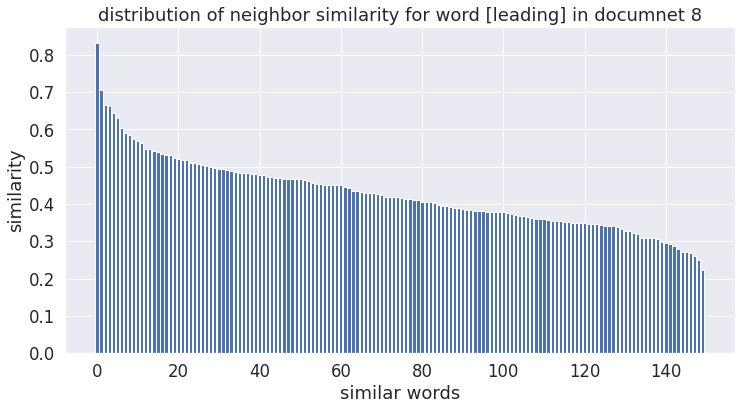

127   -->  figures
1690
[0.8327529, 0.7071862, 0.6928071, 0.676278, 0.6139047, 0.6025771, 0.5948607, 0.5852823, 0.56656003, 0.56317437, 0.5536175, 0.54188645, 0.534559, 0.53018254, 0.5193796, 0.5159344, 0.5115634, 0.50762725, 0.5068002, 0.5045948, 0.5023719, 0.50214285, 0.5010299, 0.49984, 0.49878955, 0.49756387, 0.4960847, 0.4943697, 0.49361235, 0.4897098, 0.48783094, 0.48060605, 0.471925, 0.47050536, 0.46955353, 0.46640024, 0.46385655, 0.46131438, 0.45966792, 0.45478588, 0.45417964, 0.45012933, 0.44900256, 0.44733277, 0.4457401, 0.44404322, 0.4439028, 0.44086313, 0.43899003, 0.4383188, 0.43586126, 0.43220925, 0.4295661, 0.42921248, 0.42690986, 0.42639768, 0.4263655, 0.4228678, 0.42191848, 0.42077523, 0.42027307, 0.41986823, 0.41718096, 0.41594565, 0.4152186, 0.41449204, 0.41213533, 0.41087115, 0.40966898, 0.4086284, 0.40675718, 0.404773, 0.40370527, 0.40320134, 0.40282127, 0.4015676, 0.40110204, 0.39743984, 0.3972426, 0.39556682, 0.39464557, 0.38718444, 0.3858844, 0.38345325, 0.38272

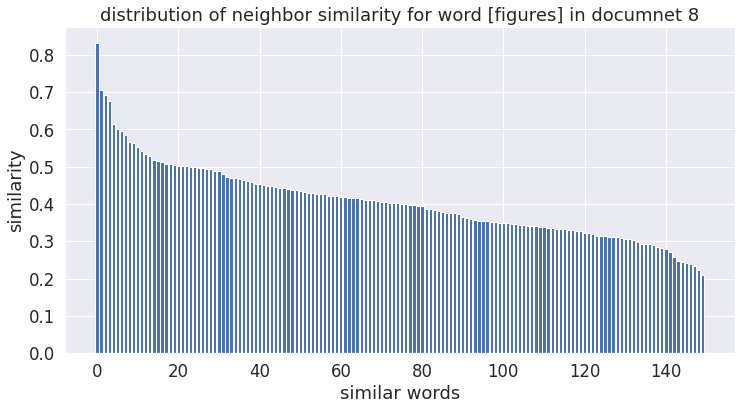

130   -->  detained
1690
[0.83600163, 0.6705374, 0.6501825, 0.6250508, 0.6180984, 0.60194725, 0.5948607, 0.5919076, 0.55508476, 0.554741, 0.54934883, 0.5485482, 0.54266256, 0.53471905, 0.5281421, 0.51212716, 0.5106562, 0.4912799, 0.4868381, 0.4830718, 0.47897592, 0.47844112, 0.464715, 0.4605866, 0.45392728, 0.44949383, 0.44944644, 0.44799596, 0.44790086, 0.4462655, 0.44512647, 0.44240794, 0.43917832, 0.43669093, 0.43559164, 0.43396586, 0.43377584, 0.4337419, 0.43295866, 0.4317788, 0.43038532, 0.42916748, 0.42908585, 0.42733538, 0.42652428, 0.42528516, 0.42472667, 0.42033458, 0.42022127, 0.42011356, 0.41877803, 0.41729236, 0.41402003, 0.4137743, 0.41295862, 0.410786, 0.4089475, 0.40775067, 0.40594423, 0.40556824, 0.40412536, 0.4000759, 0.39955375, 0.39719704, 0.3970425, 0.3970096, 0.39664865, 0.3958724, 0.394607, 0.39115918, 0.390803, 0.38877916, 0.38768637, 0.38609147, 0.38462573, 0.38452855, 0.38442832, 0.38408577, 0.3817243, 0.38078448, 0.3807463, 0.3806351, 0.37243325, 0.372328, 0.3

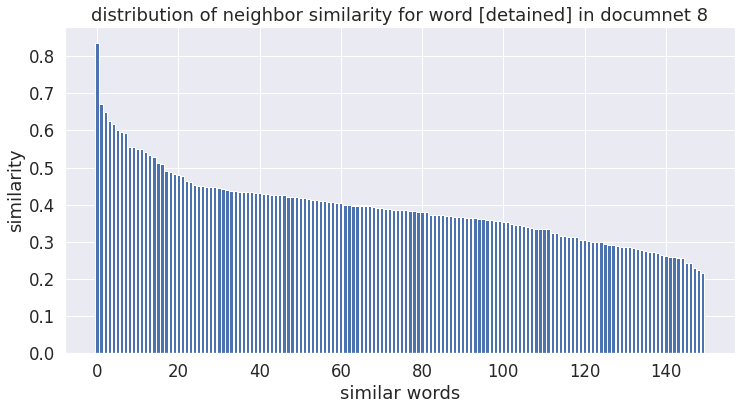

131   -->  since
1690
[0.6682366, 0.6180984, 0.6103656, 0.607996, 0.60659564, 0.5564782, 0.54360664, 0.5254617, 0.52463365, 0.5240515, 0.52234584, 0.52157193, 0.5170845, 0.51480085, 0.5120733, 0.51112574, 0.50987136, 0.50757354, 0.4937941, 0.49363467, 0.49143055, 0.48818195, 0.48783094, 0.48583257, 0.48412213, 0.481603, 0.47983775, 0.47741702, 0.47335917, 0.47292465, 0.47239012, 0.47134197, 0.46873206, 0.46664676, 0.4651336, 0.46395582, 0.45775855, 0.44529134, 0.4413204, 0.4374403, 0.43701, 0.43677598, 0.43322533, 0.4329263, 0.42834565, 0.42802665, 0.42763528, 0.4257544, 0.42317483, 0.4223354, 0.4219206, 0.4175992, 0.4175033, 0.41699874, 0.41695815, 0.41395473, 0.41131437, 0.40511155, 0.40041223, 0.39766517, 0.39697248, 0.39501834, 0.39387268, 0.39385343, 0.3924513, 0.3924002, 0.38519266, 0.38472798, 0.3833583, 0.38308913, 0.38116184, 0.37866592, 0.37810174, 0.37499663, 0.3739789, 0.37278533, 0.37124175, 0.36975378, 0.36154777, 0.3594417, 0.35868624, 0.35854825, 0.35562712, 0.35548958,

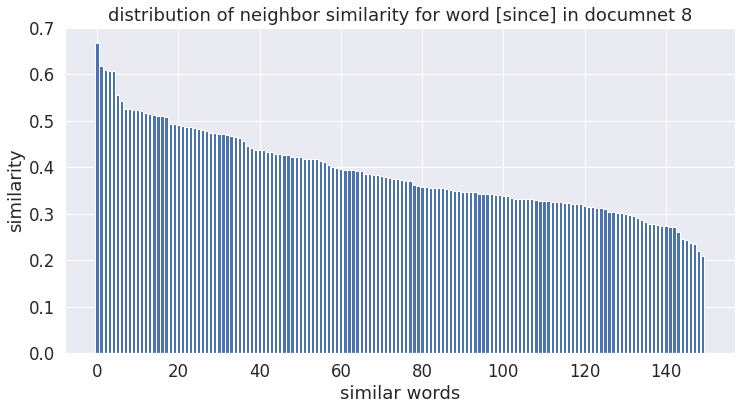

132   -->  president
1690
[0.78465915, 0.78342175, 0.7204921, 0.70284694, 0.6103656, 0.55905163, 0.55750424, 0.5424793, 0.5420604, 0.5395899, 0.53829396, 0.53696847, 0.5220218, 0.52106655, 0.5200019, 0.51733786, 0.5134096, 0.5080457, 0.50777537, 0.50762725, 0.5074446, 0.5068917, 0.5045614, 0.5041306, 0.5015865, 0.50092995, 0.493409, 0.4894862, 0.48794827, 0.4871254, 0.4868381, 0.48670587, 0.48477328, 0.48319802, 0.48259327, 0.48226905, 0.48187134, 0.47367498, 0.47141418, 0.45270944, 0.45129478, 0.44914988, 0.4448502, 0.44219822, 0.4414512, 0.44067717, 0.440535, 0.4372459, 0.43709016, 0.4363391, 0.43420178, 0.43403924, 0.4289703, 0.427815, 0.4249445, 0.42446768, 0.42145956, 0.41990262, 0.41663712, 0.41588503, 0.4151206, 0.4123923, 0.40996027, 0.4064252, 0.40167177, 0.39709222, 0.39580387, 0.39487472, 0.39255452, 0.38890064, 0.38267714, 0.3821634, 0.38160688, 0.38040048, 0.38025382, 0.37841833, 0.37535745, 0.3745457, 0.3729836, 0.37067738, 0.37016165, 0.36604923, 0.36426866, 0.3635564, 0

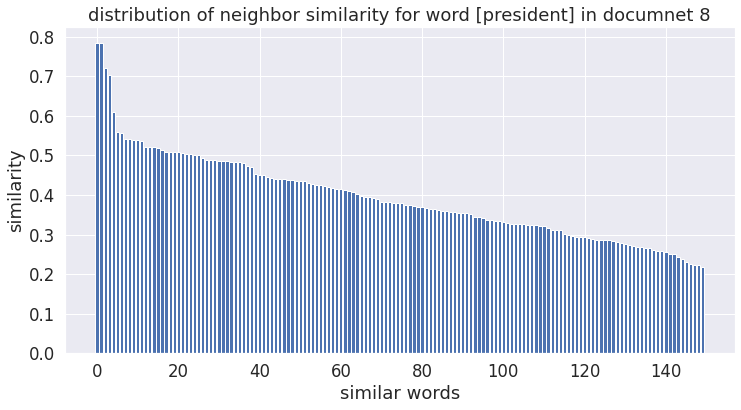

133   -->  nicola
1690
[0.8078493, 0.74462175, 0.7204921, 0.58019423, 0.55609405, 0.5378925, 0.5214875, 0.4923696, 0.4723245, 0.46626246, 0.46609402, 0.46038347, 0.4519688, 0.44350207, 0.43802637, 0.43525594, 0.43329117, 0.42921248, 0.42763528, 0.42652428, 0.425832, 0.42475396, 0.42323542, 0.41870537, 0.41868228, 0.41830346, 0.415885, 0.41424483, 0.41389608, 0.4131737, 0.40844125, 0.40585065, 0.40495276, 0.40180987, 0.39715862, 0.3961463, 0.39261502, 0.3858315, 0.3858207, 0.3854102, 0.3835776, 0.38043812, 0.37613362, 0.3744763, 0.37447143, 0.3743717, 0.37127018, 0.36965084, 0.3677107, 0.36695093, 0.36562827, 0.3620583, 0.35717642, 0.3510058, 0.3493513, 0.34880975, 0.3451382, 0.34200478, 0.34083265, 0.33906734, 0.3362571, 0.33457816, 0.3334167, 0.3321324, 0.32384357, 0.32359582, 0.3215946, 0.32148135, 0.32067966, 0.31396586, 0.31188524, 0.31036732, 0.30969387, 0.30825484, 0.307481, 0.30730247, 0.3071967, 0.30431432, 0.30112934, 0.30055714, 0.29871872, 0.29849374, 0.2981823, 0.29786903, 

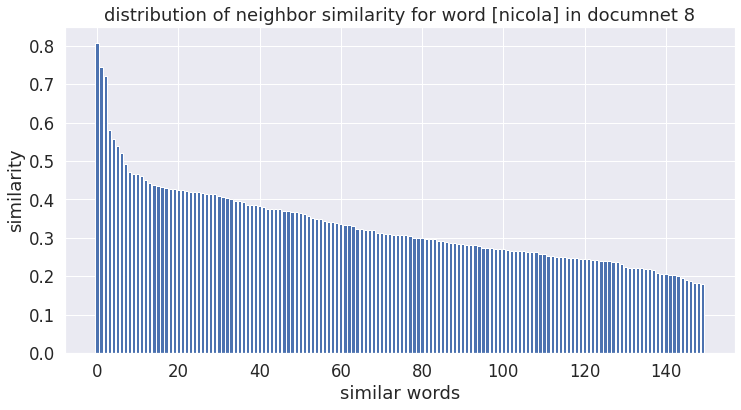

134   -->  ##e
1690
[0.79458773, 0.78342175, 0.74462175, 0.57792115, 0.5522695, 0.54199404, 0.5333805, 0.52463365, 0.51925194, 0.51772654, 0.5116796, 0.49954504, 0.49923372, 0.49613726, 0.49362695, 0.4875778, 0.48701632, 0.48491585, 0.4820914, 0.4766003, 0.47603023, 0.4728021, 0.47041404, 0.46467882, 0.4636273, 0.46049803, 0.45741925, 0.45676112, 0.45450124, 0.45411876, 0.4526914, 0.4508006, 0.4457401, 0.44547153, 0.44531137, 0.4404447, 0.43986508, 0.43691283, 0.43669093, 0.4336688, 0.4326861, 0.43183333, 0.4309436, 0.4305821, 0.4251204, 0.42505574, 0.42469537, 0.42262578, 0.4205435, 0.4180454, 0.41639397, 0.41561347, 0.41380182, 0.41364682, 0.4084313, 0.4080268, 0.40732324, 0.4018867, 0.40072376, 0.39441615, 0.38990933, 0.38605186, 0.38348877, 0.3784001, 0.37426728, 0.37417838, 0.3737573, 0.37185076, 0.37041253, 0.36939, 0.36879498, 0.3672933, 0.36630797, 0.36207116, 0.3610154, 0.3605247, 0.35804725, 0.3572083, 0.3569402, 0.35562646, 0.35444707, 0.35374343, 0.35338396, 0.3509271, 0.35

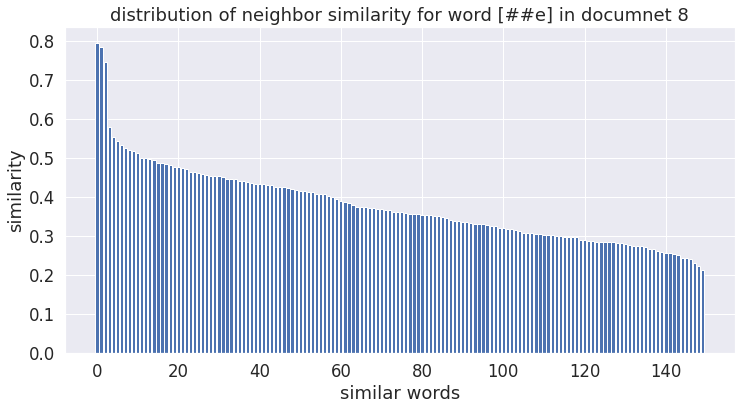

135   -->  ce
1690
[0.7892761, 0.7803489, 0.75112605, 0.61827075, 0.50905293, 0.5060754, 0.4979033, 0.48328793, 0.47004837, 0.4660543, 0.46345842, 0.4513753, 0.4391935, 0.4332962, 0.4290763, 0.4266556, 0.41901094, 0.41826373, 0.4157781, 0.41061792, 0.41046956, 0.41040337, 0.40987128, 0.40259174, 0.40064147, 0.39844885, 0.39638323, 0.3958826, 0.39431968, 0.39340478, 0.39290076, 0.3916225, 0.3896355, 0.38697982, 0.38679597, 0.38214925, 0.37825757, 0.37773246, 0.37609014, 0.37565237, 0.369021, 0.3688268, 0.36802953, 0.36534876, 0.36208674, 0.3526989, 0.35185868, 0.35066622, 0.35016644, 0.34900838, 0.3468682, 0.34518975, 0.33857006, 0.33792308, 0.33743876, 0.33623835, 0.3340578, 0.3264142, 0.3241942, 0.3223892, 0.3211962, 0.31939742, 0.31934732, 0.31817633, 0.31520176, 0.31491965, 0.31375748, 0.31213993, 0.31079248, 0.30794597, 0.30785352, 0.3072778, 0.30581194, 0.30384722, 0.30377078, 0.3029238, 0.30291587, 0.29703063, 0.29567748, 0.29161167, 0.2909788, 0.28932458, 0.288133, 0.2877336, 0.

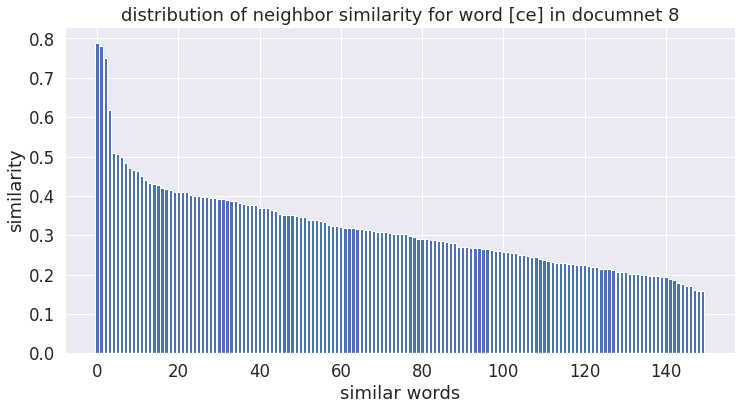

136   -->  ##aus
1690
[0.79120326, 0.77645206, 0.77283704, 0.55020785, 0.5486864, 0.48515952, 0.48152786, 0.4781789, 0.47534847, 0.47075146, 0.4585632, 0.44245154, 0.43956038, 0.433979, 0.43148756, 0.42465198, 0.42291504, 0.42045268, 0.41954398, 0.4188203, 0.41804004, 0.41070157, 0.4103645, 0.40279686, 0.40268934, 0.39517447, 0.39352387, 0.38979995, 0.38896427, 0.3839323, 0.38390553, 0.38278106, 0.3818986, 0.3801189, 0.37882835, 0.3787796, 0.37735137, 0.37627262, 0.3752573, 0.37297282, 0.36180478, 0.36159888, 0.36093387, 0.35482842, 0.3521865, 0.3507696, 0.3488677, 0.34803116, 0.34748176, 0.3378981, 0.33728164, 0.33466154, 0.33088878, 0.3307327, 0.32803014, 0.3270508, 0.31825313, 0.3178611, 0.31587344, 0.3123126, 0.3115759, 0.31155828, 0.31110802, 0.3075347, 0.30743593, 0.3043127, 0.30239388, 0.2995112, 0.29806477, 0.29772237, 0.29480514, 0.29280692, 0.28998816, 0.28638244, 0.28600833, 0.28502512, 0.28214943, 0.28174537, 0.27909452, 0.2789523, 0.27693516, 0.27456778, 0.27307385, 0.2703

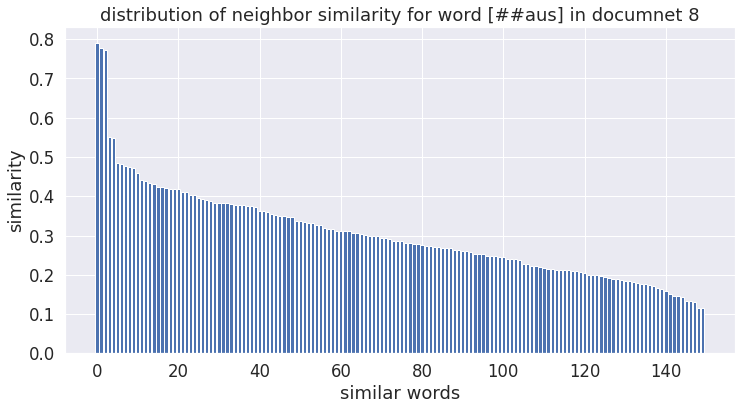

137   -->  ##escu
1690
[0.8078493, 0.79458773, 0.78465915, 0.6722851, 0.56301105, 0.5607411, 0.5466517, 0.54658496, 0.52984685, 0.52607834, 0.523666, 0.5232654, 0.5220212, 0.51351583, 0.5096851, 0.5091642, 0.50757354, 0.5066055, 0.5032232, 0.50012624, 0.49940154, 0.49563393, 0.49340194, 0.4866306, 0.48404935, 0.48374474, 0.48060605, 0.47977516, 0.4795487, 0.4781753, 0.47813982, 0.47747636, 0.47324157, 0.46432677, 0.46232992, 0.46179348, 0.45825917, 0.44799596, 0.4386972, 0.43743142, 0.42802027, 0.42785388, 0.427045, 0.42690185, 0.42137414, 0.4175349, 0.41711888, 0.4147519, 0.4139793, 0.4114595, 0.40704548, 0.40387973, 0.40304026, 0.3958868, 0.39540088, 0.39382088, 0.39192194, 0.3913911, 0.38947868, 0.38486528, 0.38459158, 0.3838042, 0.38343942, 0.38032544, 0.37760162, 0.37474665, 0.37148583, 0.37101078, 0.3678683, 0.36753964, 0.36522096, 0.36488774, 0.36321253, 0.36233342, 0.3615036, 0.3604933, 0.3602201, 0.3600105, 0.359824, 0.35849756, 0.35839212, 0.35580438, 0.3532406, 0.35299513, 0

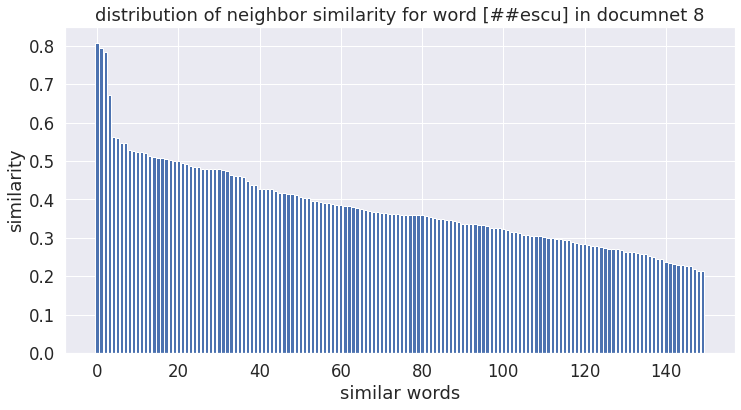

140   -->  overthrow
1690
[0.70284694, 0.6722851, 0.6425593, 0.63862103, 0.6168124, 0.6098504, 0.6094164, 0.5944456, 0.5780848, 0.57792115, 0.57473016, 0.5724472, 0.56264085, 0.5564782, 0.5563503, 0.5378925, 0.5337596, 0.5330298, 0.5284283, 0.52011895, 0.5123037, 0.5115341, 0.50830394, 0.5070491, 0.49878955, 0.4963056, 0.4952994, 0.49447364, 0.4913862, 0.48976162, 0.48662418, 0.4856041, 0.4850625, 0.4840256, 0.4830718, 0.47994068, 0.47947437, 0.47931057, 0.47644418, 0.47422218, 0.46859443, 0.46240604, 0.4622966, 0.46033663, 0.45793968, 0.45280135, 0.4495671, 0.44886556, 0.44680533, 0.44539875, 0.4438408, 0.44369268, 0.4420525, 0.44028515, 0.43828738, 0.4358256, 0.4332017, 0.4278739, 0.42451683, 0.4199557, 0.4194822, 0.41848662, 0.4167543, 0.41434538, 0.4137408, 0.41228402, 0.41079256, 0.40926772, 0.40826637, 0.4050555, 0.39988863, 0.39858913, 0.39753702, 0.39744544, 0.3944565, 0.39255244, 0.3924867, 0.38794577, 0.3875464, 0.38701978, 0.38466132, 0.38465732, 0.37783235, 0.376535, 0.3733

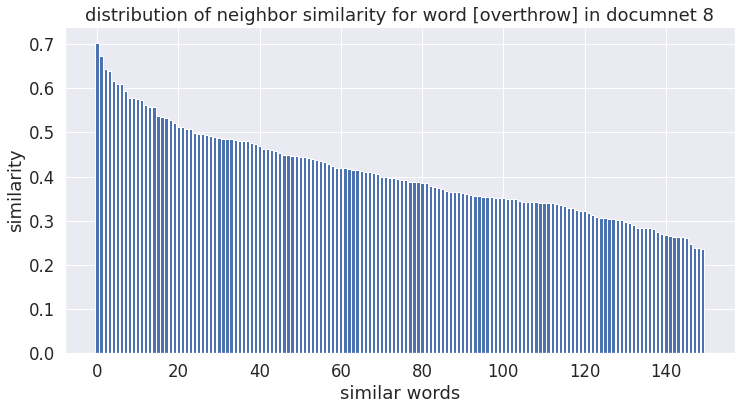

144   -->  urging
1690
[0.6428493, 0.5614598, 0.5255711, 0.44504303, 0.43413198, 0.413212, 0.41131437, 0.4000759, 0.39338157, 0.3822335, 0.3738112, 0.3704834, 0.36846128, 0.36554444, 0.35985667, 0.34820357, 0.34732163, 0.34619832, 0.34453198, 0.33976865, 0.33760315, 0.33281773, 0.33099392, 0.33091396, 0.3247314, 0.32274947, 0.3194412, 0.31910256, 0.31589872, 0.31493855, 0.31388885, 0.31279826, 0.31093043, 0.30956534, 0.3084622, 0.30784637, 0.30685896, 0.30632454, 0.30524546, 0.3033319, 0.3030122, 0.30006862, 0.29279578, 0.29111394, 0.28781778, 0.28529614, 0.28263345, 0.2818958, 0.28018045, 0.27890933, 0.27174544, 0.27095893, 0.26851097, 0.26786572, 0.26606292, 0.26531047, 0.26345026, 0.2586696, 0.25800407, 0.2579748, 0.2567413, 0.2550335, 0.2548175, 0.25459146, 0.25293446, 0.25239623, 0.25123683, 0.25083688, 0.24689986, 0.24684167, 0.24677065, 0.24490789, 0.24432662, 0.24394135, 0.24289334, 0.24113859, 0.23987734, 0.2390379, 0.23205733, 0.22898534, 0.22892928, 0.22774093, 0.22759393, 0

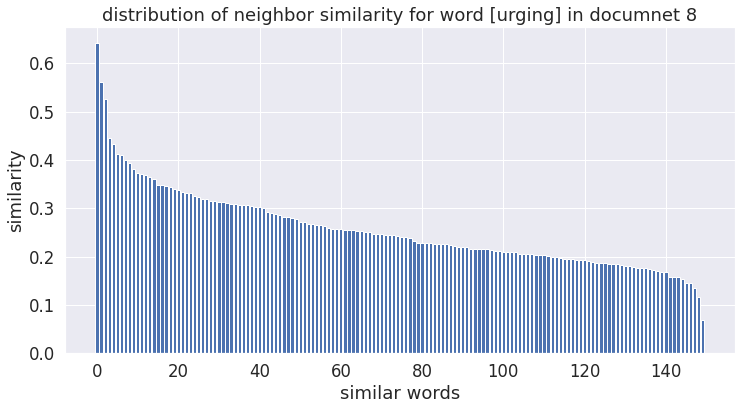

146   -->  party
1690
[0.61340165, 0.5974239, 0.59419954, 0.5814805, 0.55716455, 0.5317297, 0.5255436, 0.522836, 0.52102464, 0.51913166, 0.51904804, 0.5163935, 0.51263785, 0.5022032, 0.5003252, 0.49935234, 0.49908924, 0.4906695, 0.48220363, 0.47539258, 0.4749638, 0.47485232, 0.4721868, 0.47140497, 0.4711658, 0.4641851, 0.4637868, 0.46275288, 0.46256086, 0.46095347, 0.46086195, 0.45905676, 0.45711207, 0.4549802, 0.45396292, 0.45308292, 0.44515383, 0.4441195, 0.4422009, 0.44037932, 0.43740797, 0.43590587, 0.4332191, 0.43284422, 0.43238837, 0.43110344, 0.4310024, 0.42227855, 0.41863078, 0.4170959, 0.41591382, 0.41364482, 0.41160595, 0.4106062, 0.40922534, 0.4088593, 0.40826553, 0.4075849, 0.4053812, 0.40444994, 0.4031562, 0.40252686, 0.40241107, 0.39976975, 0.39689353, 0.39584166, 0.3946343, 0.3931568, 0.39301032, 0.39225417, 0.39186132, 0.39167392, 0.38875705, 0.38699272, 0.3858246, 0.3842318, 0.38371193, 0.38266832, 0.38238233, 0.38125417, 0.37700516, 0.3752544, 0.3751543, 0.37362677, 0

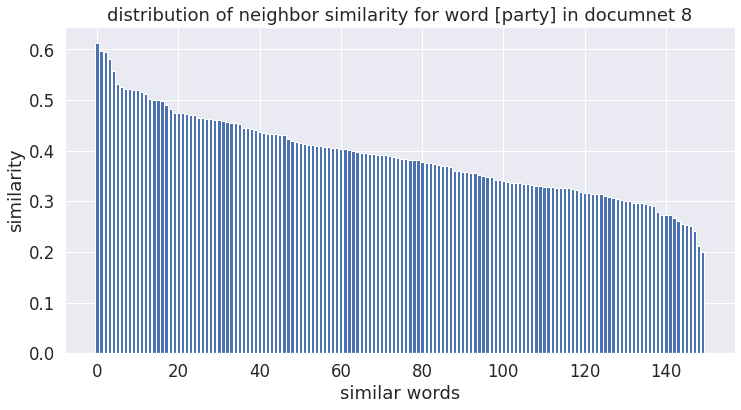

149   -->  dissolution
1690
[0.68404317, 0.6168124, 0.5995331, 0.54850066, 0.5137155, 0.50821817, 0.5035635, 0.5005964, 0.49675483, 0.49214166, 0.4890477, 0.48670587, 0.48664856, 0.48128414, 0.4740178, 0.47193065, 0.4672685, 0.46640024, 0.46381, 0.46091437, 0.4606678, 0.4595309, 0.45777437, 0.45757133, 0.45574477, 0.4529087, 0.45061582, 0.44504303, 0.44405222, 0.43952632, 0.43917832, 0.4389689, 0.4362457, 0.43543208, 0.42802027, 0.42317483, 0.42150134, 0.4210364, 0.4209698, 0.41560227, 0.41529614, 0.4138549, 0.41351986, 0.41305703, 0.40991986, 0.4069479, 0.406565, 0.4058576, 0.40104645, 0.3998356, 0.39925233, 0.3988125, 0.39868197, 0.39549392, 0.39535838, 0.394705, 0.39196622, 0.38790092, 0.38731247, 0.38582432, 0.3835776, 0.3801977, 0.3789209, 0.3787072, 0.378483, 0.3766267, 0.37525162, 0.3737573, 0.37333733, 0.3718928, 0.37179032, 0.37152508, 0.37119687, 0.37049425, 0.36998287, 0.36909676, 0.3686126, 0.361414, 0.36104888, 0.36058956, 0.3580849, 0.35719293, 0.35602945, 0.3546499, 0.35

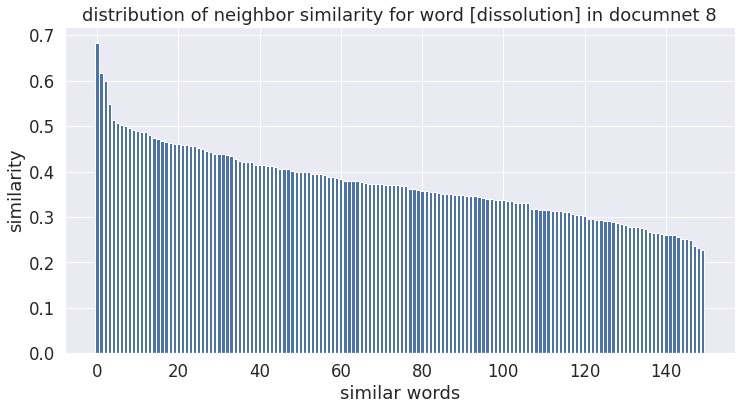

150   -->  appear
1690
[0.69857466, 0.66401845, 0.6578322, 0.64308125, 0.6004919, 0.5866322, 0.5682793, 0.5364448, 0.52039826, 0.51212716, 0.50716305, 0.49224186, 0.47985846, 0.45270944, 0.4439028, 0.44133714, 0.4345768, 0.4336688, 0.427045, 0.4257544, 0.421331, 0.415885, 0.41238543, 0.41233122, 0.4117098, 0.406815, 0.4049693, 0.4031186, 0.39627218, 0.39338157, 0.3718859, 0.37112087, 0.36508104, 0.36482278, 0.35940403, 0.35938853, 0.357591, 0.3432384, 0.3397382, 0.3393997, 0.33678287, 0.3357845, 0.33496112, 0.33494338, 0.33363208, 0.33348262, 0.3326858, 0.3301082, 0.32780606, 0.3248928, 0.32346666, 0.32086468, 0.32022315, 0.31998563, 0.3198238, 0.31909, 0.31768683, 0.31764725, 0.31746304, 0.31640202, 0.31587505, 0.31553656, 0.3116907, 0.3114326, 0.31047517, 0.30905953, 0.30893642, 0.30848616, 0.307594, 0.304739, 0.30395138, 0.303887, 0.30220547, 0.2994203, 0.29783845, 0.29721838, 0.29609248, 0.29526627, 0.29520652, 0.29382935, 0.2932454, 0.2916635, 0.29152456, 0.29121682, 0.2906479, 0.

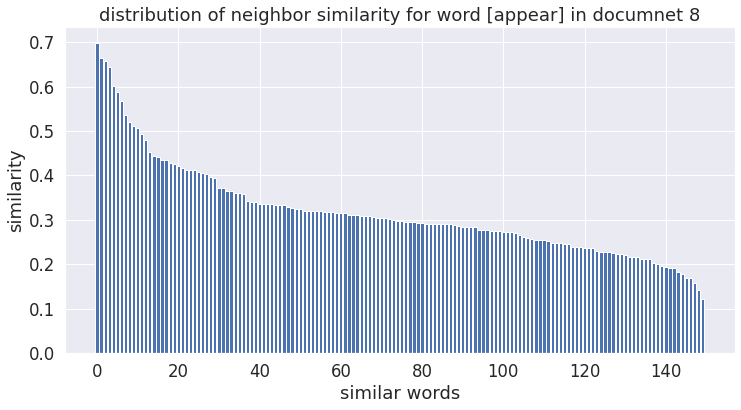

153   -->  high
1690
[0.85575855, 0.7642657, 0.714714, 0.65683615, 0.645352, 0.6139047, 0.6004919, 0.5917015, 0.58216727, 0.56962657, 0.56397927, 0.5619789, 0.55821365, 0.5510824, 0.54934883, 0.53711134, 0.52619314, 0.52166235, 0.518918, 0.5158006, 0.5089582, 0.50488406, 0.5038786, 0.49708214, 0.4924792, 0.49143055, 0.4895443, 0.4874588, 0.48226905, 0.47659338, 0.4653389, 0.46057668, 0.45653582, 0.4497403, 0.44231182, 0.43568203, 0.4349457, 0.42586204, 0.42283407, 0.4173313, 0.41587216, 0.41434538, 0.41281435, 0.41189164, 0.4110374, 0.40704548, 0.40534902, 0.40469852, 0.40004802, 0.39415014, 0.39385095, 0.39127526, 0.38854444, 0.3884497, 0.3848503, 0.3846839, 0.38348877, 0.38250303, 0.3795989, 0.3766459, 0.3756579, 0.37448388, 0.37313062, 0.3718968, 0.36949354, 0.36506593, 0.3647563, 0.36469787, 0.36310035, 0.36225027, 0.36083108, 0.35944283, 0.35935333, 0.35825163, 0.3577296, 0.357521, 0.3512728, 0.35092914, 0.35030586, 0.3494925, 0.3486975, 0.34866905, 0.34822547, 0.34406418, 0.34358

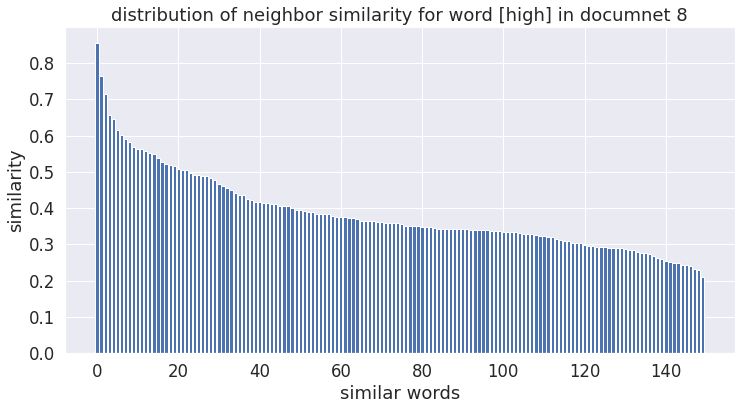

155   -->  ranking
1690
[0.85575855, 0.7733728, 0.6668257, 0.6025771, 0.5987835, 0.5920384, 0.58904564, 0.584106, 0.54549706, 0.5355055, 0.5341749, 0.5163785, 0.5112629, 0.5107708, 0.5106562, 0.5095285, 0.50716305, 0.49633557, 0.49401858, 0.4904195, 0.48522016, 0.48099142, 0.48017645, 0.47964698, 0.47569743, 0.47239012, 0.45917484, 0.45699924, 0.45557594, 0.44652808, 0.4445536, 0.4434208, 0.4420525, 0.44097185, 0.43991894, 0.43819252, 0.43714482, 0.43403924, 0.4310189, 0.4270647, 0.42275727, 0.42113882, 0.41917825, 0.41785067, 0.40757805, 0.40710956, 0.40638274, 0.40440705, 0.4043461, 0.3945396, 0.394131, 0.39362705, 0.39334738, 0.39139163, 0.38948095, 0.38840485, 0.38702244, 0.38619632, 0.3798468, 0.37894726, 0.3789209, 0.37506318, 0.37101078, 0.37099868, 0.36906955, 0.36898598, 0.36740118, 0.36580956, 0.3654766, 0.36484182, 0.36430252, 0.36410502, 0.36225414, 0.36185974, 0.36153653, 0.35891622, 0.3584208, 0.35684627, 0.35162687, 0.3515048, 0.35124707, 0.3507948, 0.3492514, 0.34872603

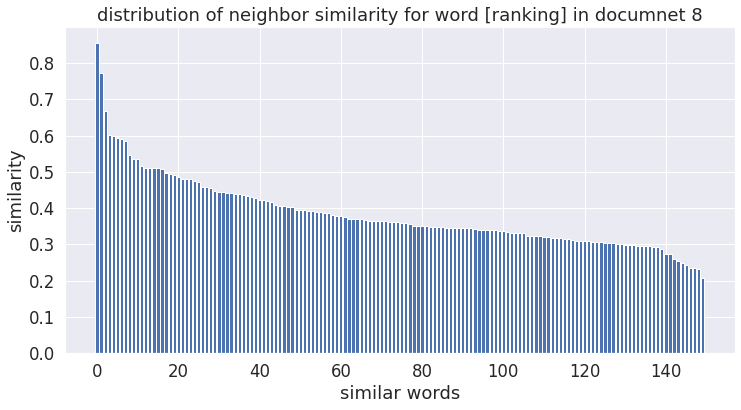

156   -->  officials
1690
[0.7733728, 0.7642657, 0.7071862, 0.69464266, 0.6424928, 0.6338201, 0.63101923, 0.6275469, 0.6250508, 0.62416434, 0.619864, 0.6062592, 0.59600425, 0.5741731, 0.5718902, 0.5703362, 0.56853676, 0.5669937, 0.56526244, 0.54814214, 0.5364448, 0.53392506, 0.5209842, 0.5203943, 0.5154605, 0.5152259, 0.51112574, 0.50460935, 0.50382173, 0.5018711, 0.49195528, 0.4756518, 0.47178277, 0.47133896, 0.46318844, 0.45779186, 0.45509747, 0.44564345, 0.44539875, 0.4428246, 0.4423948, 0.43471572, 0.43413198, 0.43331927, 0.4289703, 0.42699394, 0.4269788, 0.42604575, 0.42419365, 0.42245525, 0.42163265, 0.42004803, 0.41737312, 0.41523576, 0.41351986, 0.41266602, 0.4101969, 0.4096071, 0.4080519, 0.40276092, 0.4020911, 0.4018547, 0.39686498, 0.39570418, 0.3954301, 0.39284906, 0.39093316, 0.38748288, 0.38745812, 0.38019946, 0.37956417, 0.37816116, 0.37345463, 0.37305522, 0.37303698, 0.37301174, 0.37292027, 0.37130556, 0.37075868, 0.36901435, 0.36753964, 0.36673322, 0.36611366, 0.365640

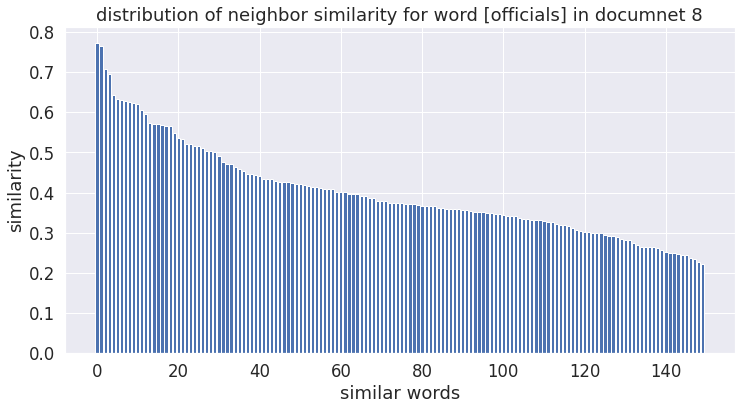

157   -->  seeking
1690
[0.69464266, 0.5920384, 0.58216727, 0.5622116, 0.5614598, 0.55585366, 0.54465026, 0.5419798, 0.5281421, 0.5170845, 0.5149679, 0.4983027, 0.49224186, 0.4811461, 0.4735283, 0.46631187, 0.4637429, 0.44392946, 0.44322217, 0.4431747, 0.43914747, 0.43586126, 0.42694783, 0.42660657, 0.42544076, 0.42272595, 0.41813672, 0.41612583, 0.41223004, 0.41118065, 0.40995705, 0.40942627, 0.405051, 0.4036286, 0.39921838, 0.39340627, 0.39057633, 0.3893007, 0.3885855, 0.38825983, 0.38808572, 0.38805246, 0.3825981, 0.3793163, 0.3780219, 0.37275228, 0.37119687, 0.37002033, 0.36737746, 0.3670623, 0.3664728, 0.36348373, 0.36259478, 0.3615474, 0.3614875, 0.35694724, 0.35659638, 0.35260314, 0.35109794, 0.34901252, 0.34886715, 0.3484705, 0.34579492, 0.34181213, 0.34172678, 0.34029853, 0.33864447, 0.33804768, 0.33660632, 0.33533686, 0.33470958, 0.33382994, 0.333642, 0.33201215, 0.33197063, 0.33029604, 0.32989097, 0.3274712, 0.32635456, 0.32432777, 0.32394364, 0.32328865, 0.32184392, 0.32015

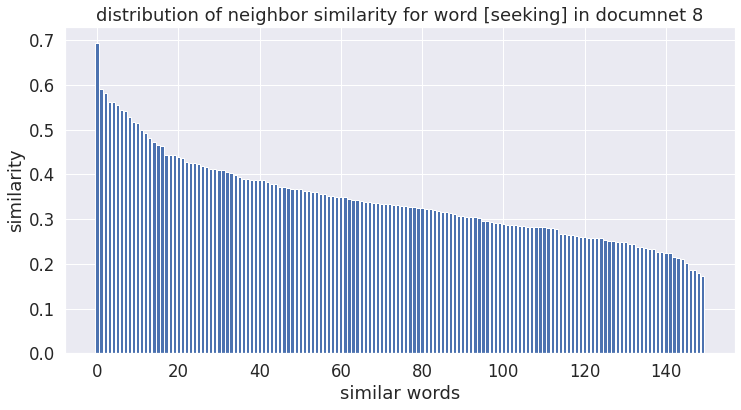

159   -->  new
1690
[0.77687883, 0.60991716, 0.5440027, 0.5291971, 0.5267503, 0.5221843, 0.51320046, 0.50776654, 0.4857201, 0.47120687, 0.46551982, 0.4564615, 0.44951332, 0.44674549, 0.4447512, 0.44187728, 0.43283635, 0.43057922, 0.42990047, 0.42985022, 0.42558467, 0.4236021, 0.42145723, 0.41982228, 0.41541415, 0.41395435, 0.41206133, 0.41163102, 0.41113484, 0.4094004, 0.4073214, 0.40416047, 0.40404975, 0.40228266, 0.40194672, 0.40119737, 0.40105382, 0.39969826, 0.39856154, 0.39758128, 0.39752328, 0.3970514, 0.39572263, 0.39518374, 0.39508006, 0.39114416, 0.39072183, 0.38944036, 0.38904667, 0.3878361, 0.3878258, 0.38776612, 0.38720027, 0.38532478, 0.38449302, 0.38321626, 0.383131, 0.38140315, 0.3803964, 0.37992814, 0.37941003, 0.3768536, 0.37500578, 0.37485337, 0.3732037, 0.3731219, 0.37230927, 0.36818296, 0.3674687, 0.36651576, 0.36202383, 0.36130303, 0.35989663, 0.35846812, 0.35838842, 0.3580064, 0.35686105, 0.35605603, 0.35563785, 0.35505587, 0.35195133, 0.35179782, 0.3467862, 0.346

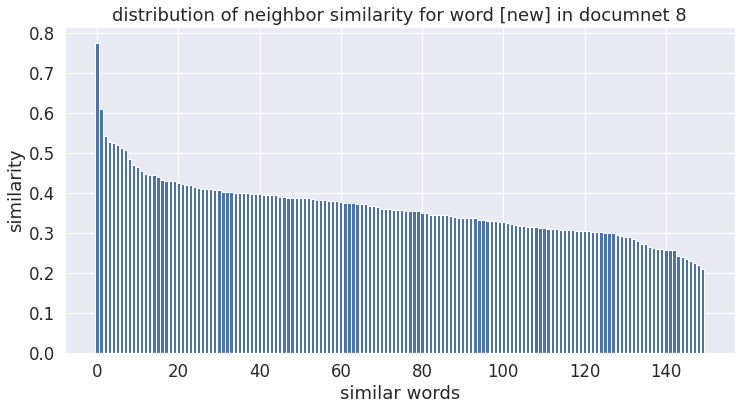

160   -->  political
1690
[0.8017555, 0.585447, 0.584106, 0.5718902, 0.5704067, 0.55821365, 0.55585366, 0.5158018, 0.5115341, 0.50987136, 0.5010299, 0.49057943, 0.4904814, 0.4882151, 0.48794827, 0.48318958, 0.47844112, 0.47616267, 0.47504345, 0.47452575, 0.47193766, 0.4701603, 0.45840228, 0.45757133, 0.45614251, 0.45588714, 0.45418936, 0.45225304, 0.45220762, 0.44527325, 0.44320843, 0.44140542, 0.44080698, 0.43635473, 0.4351611, 0.4336634, 0.43303108, 0.4327003, 0.43128514, 0.4275763, 0.4273206, 0.4272984, 0.42709404, 0.4255113, 0.42301106, 0.42220807, 0.42147008, 0.41817933, 0.41711888, 0.4157111, 0.41534138, 0.4134698, 0.4132498, 0.4121617, 0.41139638, 0.4078906, 0.40523824, 0.40514642, 0.40365142, 0.4016776, 0.4002259, 0.3957801, 0.39455718, 0.3939294, 0.39290142, 0.39277944, 0.39270508, 0.39154232, 0.3854642, 0.38469204, 0.38334966, 0.38098428, 0.38022178, 0.37852898, 0.37751448, 0.3773722, 0.37684292, 0.37477165, 0.37338364, 0.3728539, 0.37241942, 0.37078053, 0.3700763, 0.36939, 0

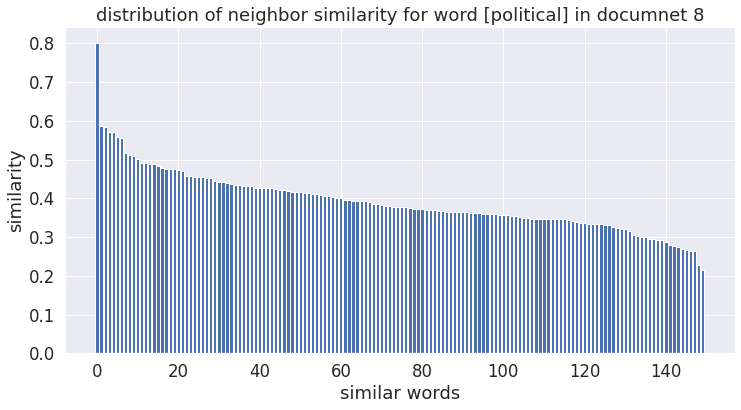

161   -->  profile
1690
[0.8017555, 0.5741731, 0.54549706, 0.54465026, 0.540651, 0.52619314, 0.5108297, 0.49361235, 0.4913862, 0.4912799, 0.4901342, 0.47864097, 0.47741702, 0.4740178, 0.46850026, 0.4547547, 0.45248622, 0.44484013, 0.44226557, 0.43879265, 0.4357834, 0.4353509, 0.42975608, 0.4296757, 0.4276593, 0.42122632, 0.42115578, 0.4198017, 0.41948533, 0.41710305, 0.41550797, 0.415236, 0.41463143, 0.4141968, 0.41201046, 0.4106087, 0.40996495, 0.40886188, 0.40710035, 0.40645146, 0.40514442, 0.40470445, 0.40415162, 0.4037939, 0.40314716, 0.4023753, 0.40215594, 0.40030122, 0.39737487, 0.3963269, 0.39627218, 0.395954, 0.39485693, 0.39379203, 0.39195186, 0.3918094, 0.3899073, 0.3896463, 0.3861881, 0.38429958, 0.38358384, 0.38320225, 0.38317862, 0.3824334, 0.38139132, 0.38043064, 0.38040048, 0.3781433, 0.37811488, 0.3760384, 0.37539607, 0.3746394, 0.37448174, 0.37440738, 0.3705353, 0.37021568, 0.3701934, 0.36984038, 0.36792108, 0.3658952, 0.36386764, 0.36188462, 0.3608098, 0.36021692, 0.3

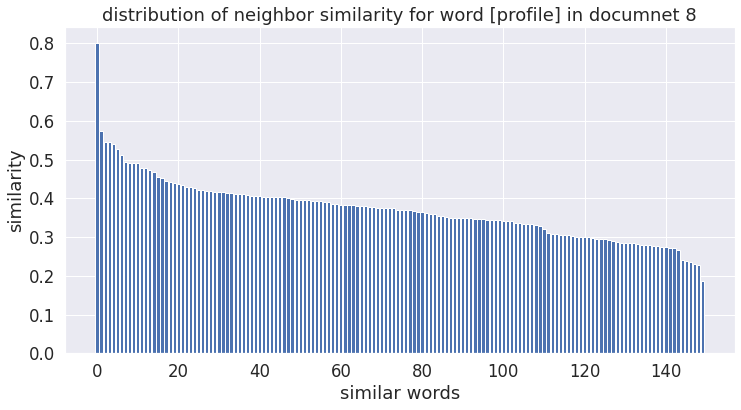

164   -->  open
1690
[0.8148493, 0.7243451, 0.71798474, 0.64412737, 0.5779766, 0.50883937, 0.49346173, 0.48988783, 0.46091437, 0.46033663, 0.45418936, 0.4372459, 0.4219169, 0.42070124, 0.4161185, 0.41609496, 0.41508162, 0.4115659, 0.41044754, 0.40953982, 0.40304026, 0.39704168, 0.39242557, 0.38444394, 0.38056383, 0.37929052, 0.3781433, 0.37747842, 0.3757227, 0.3756626, 0.37499663, 0.3743694, 0.3711165, 0.36738437, 0.36679226, 0.36611295, 0.3657629, 0.3652674, 0.36515987, 0.3644846, 0.36394063, 0.3635012, 0.36125886, 0.35759273, 0.35630238, 0.3530381, 0.35026383, 0.34199744, 0.3383318, 0.33718616, 0.33684096, 0.3355971, 0.33510268, 0.33504915, 0.33497202, 0.33381987, 0.33202124, 0.3318739, 0.3306078, 0.33005685, 0.3292412, 0.3282076, 0.32636806, 0.32569885, 0.3247552, 0.32466426, 0.32419762, 0.3195366, 0.31685638, 0.31678692, 0.3165983, 0.31653523, 0.3156991, 0.31471282, 0.31301028, 0.31020108, 0.30965903, 0.3087291, 0.30855042, 0.3074733, 0.3054701, 0.3041544, 0.30395955, 0.3037868, 0.

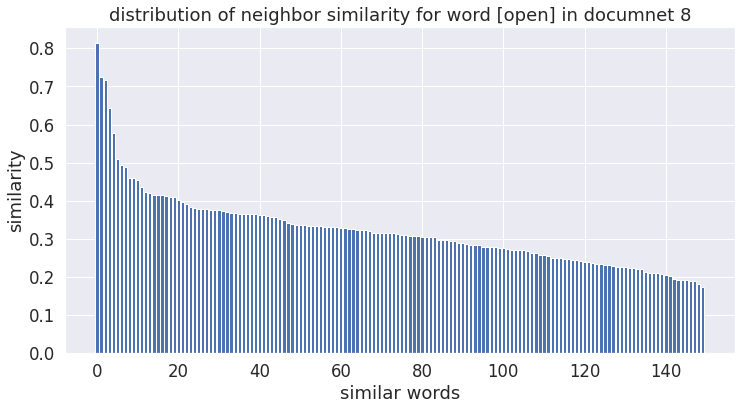

165   -->  elections
1690
[0.8148493, 0.77387977, 0.71090376, 0.6471246, 0.53211427, 0.5171612, 0.5134096, 0.4963056, 0.4904814, 0.47813982, 0.47193065, 0.46543133, 0.46053767, 0.45425525, 0.44621173, 0.43964708, 0.43057448, 0.4263655, 0.4181366, 0.41757837, 0.41729236, 0.4165644, 0.41068676, 0.40886188, 0.40857157, 0.40615457, 0.4050073, 0.39909697, 0.39847025, 0.39501834, 0.39376444, 0.39284906, 0.3906275, 0.3905465, 0.3894482, 0.38605186, 0.3838401, 0.38315052, 0.37748694, 0.37098867, 0.3697093, 0.3693925, 0.36898598, 0.36869377, 0.36758786, 0.36310035, 0.36255616, 0.3615854, 0.36131427, 0.3602938, 0.35993162, 0.3594218, 0.35797077, 0.3566182, 0.35543874, 0.35480607, 0.3493513, 0.3488533, 0.34881553, 0.34751573, 0.3464133, 0.34474587, 0.3422522, 0.34131932, 0.34035087, 0.3401829, 0.33947623, 0.33937973, 0.33768094, 0.33573967, 0.33522484, 0.3330227, 0.3324368, 0.32876354, 0.32576066, 0.3207335, 0.31893817, 0.31775367, 0.31766963, 0.31747928, 0.31289387, 0.30747142, 0.30638295, 0.306

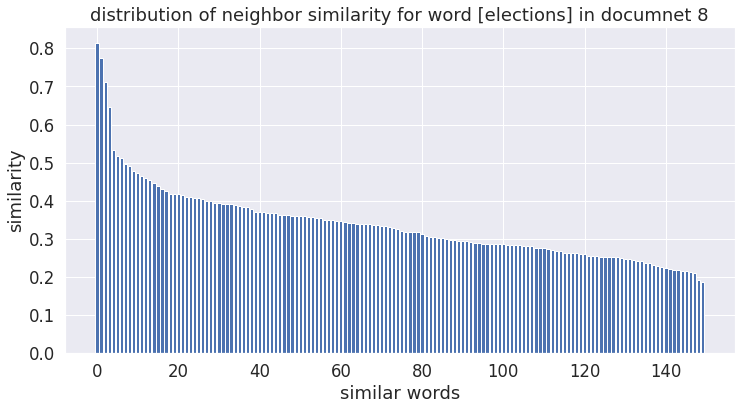

167   -->  held
1690
[0.82957363, 0.77387977, 0.71798474, 0.65210724, 0.63032055, 0.5420604, 0.49084687, 0.49057943, 0.4622966, 0.45825917, 0.45394006, 0.4535171, 0.45009774, 0.4410328, 0.43601534, 0.4309436, 0.43076515, 0.43057093, 0.42853332, 0.42277572, 0.42162263, 0.41695815, 0.41587216, 0.41560227, 0.41347784, 0.40347785, 0.3965219, 0.39501747, 0.3946889, 0.393672, 0.39334738, 0.39232135, 0.38920158, 0.38858008, 0.38393736, 0.38043064, 0.37917498, 0.37914705, 0.37791604, 0.3774724, 0.37323603, 0.37318867, 0.37292027, 0.36922175, 0.36785042, 0.3658346, 0.36427015, 0.3618476, 0.3616016, 0.3579647, 0.35775954, 0.3556063, 0.3556041, 0.3549379, 0.35376602, 0.35124195, 0.35083315, 0.34952927, 0.34874716, 0.34491548, 0.34285265, 0.34028658, 0.3402843, 0.33969793, 0.33913743, 0.33731937, 0.33680403, 0.33502132, 0.3331382, 0.33311307, 0.3294103, 0.32888907, 0.3287192, 0.3273359, 0.3270796, 0.32524243, 0.3233575, 0.32235974, 0.3215946, 0.32148847, 0.3212488, 0.3202204, 0.31866348, 0.3184872

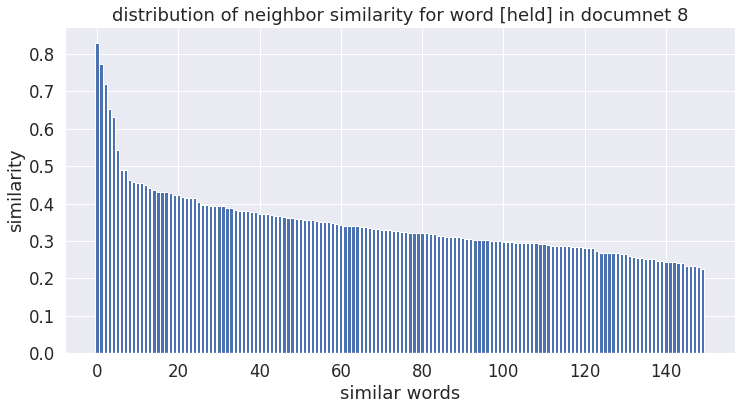

169   -->  swirl
1690
[0.5768713, 0.5555915, 0.5503702, 0.5493691, 0.5387303, 0.53608155, 0.52491534, 0.5230831, 0.51885384, 0.5133616, 0.47831607, 0.45614016, 0.45207846, 0.45121157, 0.44957298, 0.43952507, 0.43753514, 0.42942715, 0.42918348, 0.42511803, 0.42470255, 0.42380142, 0.4190572, 0.41474062, 0.413428, 0.41315478, 0.41111147, 0.41103983, 0.41056454, 0.4033599, 0.40307903, 0.4029878, 0.39987868, 0.39877802, 0.39686942, 0.392228, 0.3886672, 0.38810003, 0.38621685, 0.38518533, 0.38252705, 0.38054878, 0.3756278, 0.37535262, 0.37406498, 0.3730241, 0.37205595, 0.37187982, 0.3708841, 0.37016493, 0.3674095, 0.3671273, 0.36501732, 0.36501423, 0.36323294, 0.36137813, 0.36115366, 0.36109668, 0.36034593, 0.35492688, 0.3544622, 0.35418257, 0.35223946, 0.35165688, 0.3505196, 0.3501907, 0.34938794, 0.34828916, 0.34399524, 0.34266767, 0.3404686, 0.33801442, 0.3310602, 0.33095303, 0.33050653, 0.3290847, 0.3288622, 0.32857543, 0.3214696, 0.32050306, 0.31960487, 0.31943506, 0.31696075, 0.3160938

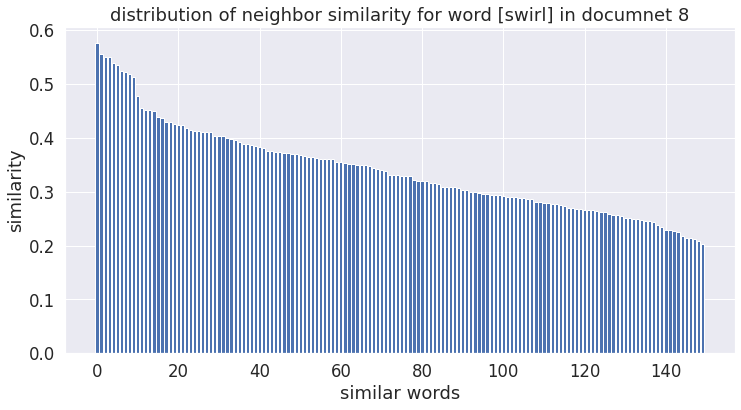

171   -->  revolutionary
1690
[0.6389965, 0.62164724, 0.6101825, 0.60087496, 0.59190166, 0.5764828, 0.573548, 0.55264807, 0.5434003, 0.53934854, 0.5393364, 0.52427465, 0.52344775, 0.5217962, 0.5062767, 0.5025728, 0.49770936, 0.4903768, 0.48849046, 0.48168236, 0.47793376, 0.4751259, 0.4723807, 0.4690749, 0.46754104, 0.46671653, 0.46589637, 0.46517587, 0.4590289, 0.45824867, 0.45731464, 0.44893014, 0.4439465, 0.44387084, 0.44239622, 0.44224906, 0.44107002, 0.43933704, 0.43180117, 0.42989725, 0.42981988, 0.4295844, 0.42909145, 0.42722964, 0.42575163, 0.42454752, 0.42426443, 0.42415994, 0.42382136, 0.42367482, 0.42303455, 0.4213524, 0.42071742, 0.41969377, 0.4178766, 0.41297388, 0.41257247, 0.40752596, 0.40541485, 0.40269202, 0.402232, 0.40203676, 0.40152198, 0.3968432, 0.39598384, 0.39564234, 0.39543286, 0.39471227, 0.39370915, 0.3914773, 0.39039683, 0.38701782, 0.38397235, 0.3828709, 0.38279402, 0.37716034, 0.3766154, 0.37196526, 0.37108636, 0.3702957, 0.36826715, 0.36796993, 0.3668978, 

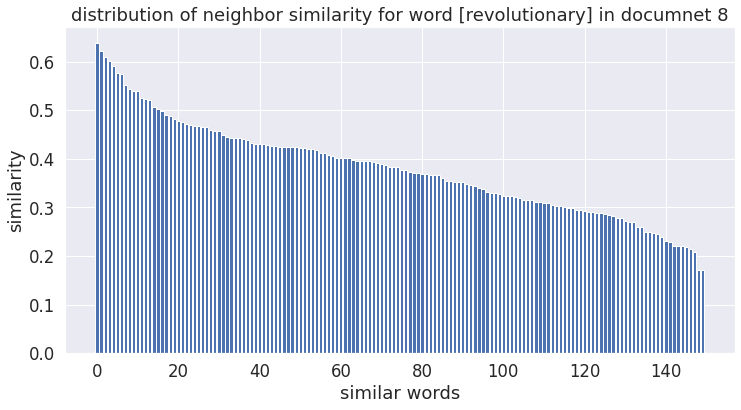

172   -->  fe
1690
[0.6871667, 0.6839119, 0.659958, 0.6379347, 0.5740217, 0.54671603, 0.5257437, 0.5154461, 0.5056765, 0.48750144, 0.4842623, 0.48245668, 0.47522542, 0.47280538, 0.4686809, 0.46574986, 0.4589182, 0.45590985, 0.4549096, 0.44899112, 0.4466365, 0.44138893, 0.4411744, 0.44033414, 0.43556866, 0.43525496, 0.43331105, 0.432993, 0.4320401, 0.43082702, 0.43003863, 0.4285336, 0.42179698, 0.42095143, 0.4202335, 0.4183269, 0.4172981, 0.4140209, 0.40625778, 0.40326962, 0.4023527, 0.40128195, 0.40096283, 0.40077573, 0.3976183, 0.3967997, 0.3967467, 0.39432383, 0.3925141, 0.39157122, 0.38836104, 0.38692957, 0.38513765, 0.3787852, 0.37722346, 0.37385783, 0.37294608, 0.3713506, 0.37038964, 0.36999154, 0.36970118, 0.36907825, 0.36858785, 0.36840346, 0.36762077, 0.36580518, 0.3657745, 0.3652256, 0.36233824, 0.3615498, 0.36061016, 0.3579681, 0.3550226, 0.35150474, 0.34932125, 0.34665957, 0.34479958, 0.342614, 0.34059525, 0.3379736, 0.32937896, 0.32624787, 0.32499057, 0.32480896, 0.32425416

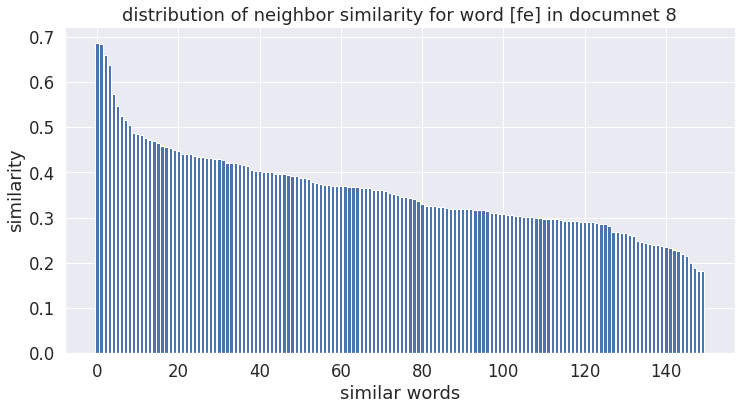

173   -->  ##r
1690
[0.5720099, 0.54199564, 0.53184247, 0.5281, 0.5184135, 0.5143206, 0.50922287, 0.49703223, 0.4890859, 0.48441648, 0.47752705, 0.46406513, 0.4623578, 0.45503584, 0.44849083, 0.44281697, 0.44124994, 0.43606555, 0.43548912, 0.42683265, 0.42575517, 0.42407143, 0.4202894, 0.4177941, 0.4096732, 0.40962982, 0.4089524, 0.4012727, 0.4010379, 0.40038732, 0.3995889, 0.39902118, 0.39572573, 0.38872376, 0.38730407, 0.38417593, 0.3804461, 0.37990516, 0.37849683, 0.37834758, 0.377249, 0.37704486, 0.37693524, 0.3758121, 0.37501746, 0.37341663, 0.3692455, 0.367971, 0.35910732, 0.35854894, 0.35784423, 0.35763553, 0.35131258, 0.34501278, 0.34311208, 0.342415, 0.33755863, 0.3292812, 0.32787126, 0.32565507, 0.32558563, 0.32090464, 0.3192979, 0.31928408, 0.31768438, 0.3116941, 0.3104521, 0.31005293, 0.30921972, 0.30912983, 0.30870956, 0.30774304, 0.30706292, 0.30393323, 0.30379266, 0.3030393, 0.3009897, 0.29961145, 0.29930484, 0.29829317, 0.2947673, 0.29440212, 0.293324, 0.29308936, 0.286

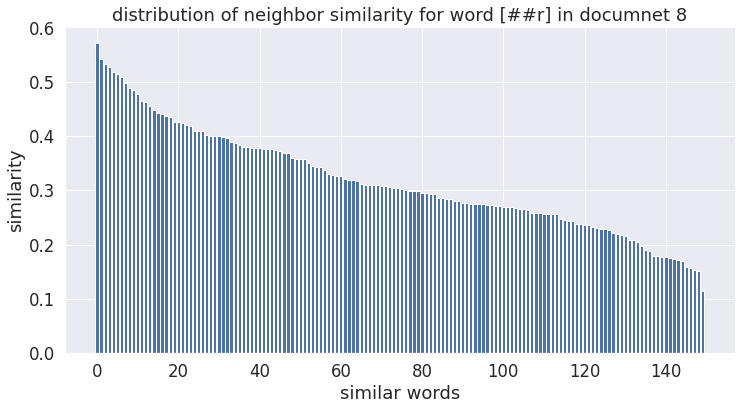

174   -->  ##vor
1690
[0.7624649, 0.73100513, 0.670054, 0.64892304, 0.60346574, 0.52178365, 0.51736736, 0.49624246, 0.48494112, 0.4841927, 0.47999394, 0.47258395, 0.47238228, 0.46545297, 0.46196073, 0.4574924, 0.45673096, 0.45496047, 0.44595796, 0.4439152, 0.44374996, 0.44296145, 0.4399807, 0.43727696, 0.4342656, 0.4313681, 0.42911702, 0.42851555, 0.42720556, 0.4208901, 0.41987234, 0.41779062, 0.41716892, 0.41481754, 0.41480118, 0.4140354, 0.40761325, 0.4068577, 0.40293252, 0.40272248, 0.4006532, 0.40026468, 0.3965007, 0.3964724, 0.3914046, 0.39125347, 0.38969672, 0.3886444, 0.38804916, 0.3869722, 0.38499182, 0.3834337, 0.3826893, 0.38201773, 0.3812365, 0.37998378, 0.37965855, 0.37821466, 0.37712884, 0.37570927, 0.3754666, 0.37203145, 0.3705191, 0.36784783, 0.36717454, 0.3641234, 0.3625447, 0.3618793, 0.3614962, 0.35862872, 0.35762456, 0.3572567, 0.35385552, 0.35355496, 0.35227686, 0.3512553, 0.35062042, 0.34968343, 0.34797063, 0.34796995, 0.3465974, 0.34521613, 0.3419464, 0.3414437, 0

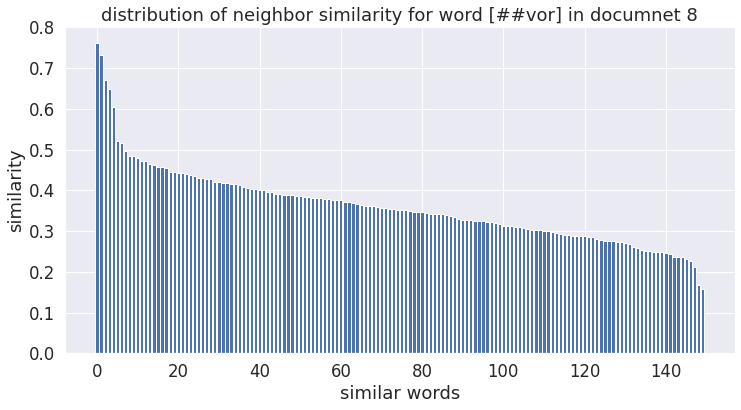

176   -->  eager
1690
[0.90900636, 0.6467446, 0.6049194, 0.57310355, 0.5376729, 0.5090692, 0.49844393, 0.4857964, 0.48541337, 0.47449252, 0.47392562, 0.4629828, 0.458173, 0.4578143, 0.45775244, 0.4561686, 0.45533493, 0.4534613, 0.45153165, 0.45034623, 0.44930315, 0.44852737, 0.4467584, 0.4449377, 0.4445849, 0.44392946, 0.44383666, 0.44354993, 0.4381289, 0.43404755, 0.42468095, 0.42389816, 0.4179914, 0.41649765, 0.4102573, 0.41009873, 0.40628117, 0.40381682, 0.40354913, 0.39726532, 0.39570418, 0.3949807, 0.38413173, 0.38242257, 0.38180465, 0.3799975, 0.37616125, 0.37542617, 0.3732399, 0.3694179, 0.36484182, 0.36299235, 0.361414, 0.36093014, 0.36033165, 0.3587496, 0.35733163, 0.3565234, 0.35514757, 0.35327986, 0.35299513, 0.35293508, 0.34926876, 0.34735274, 0.34732163, 0.34697154, 0.34644985, 0.34604597, 0.3431846, 0.34252948, 0.34129286, 0.33870602, 0.33538407, 0.3347123, 0.3313399, 0.3265128, 0.325828, 0.32074803, 0.31966782, 0.31885868, 0.3171282, 0.31019488, 0.3085272, 0.30852038, 0.

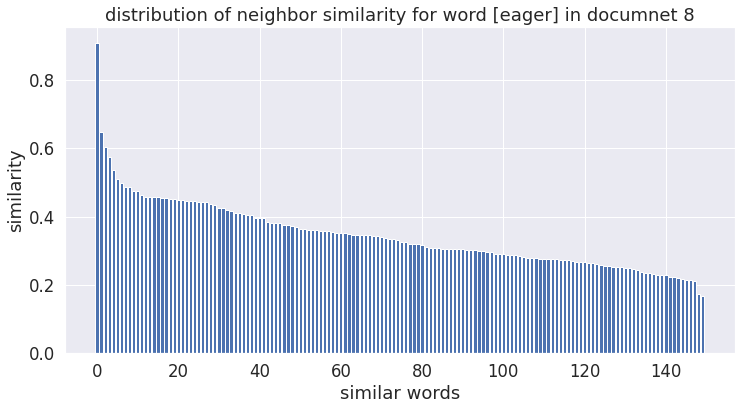

177   -->  ##ness
1690
[0.90900636, 0.6669545, 0.5727544, 0.56066257, 0.5404521, 0.49922466, 0.49123377, 0.48698983, 0.4821412, 0.48074463, 0.47784674, 0.47218436, 0.46175313, 0.45840147, 0.4536177, 0.4532898, 0.45104975, 0.44847998, 0.4425715, 0.43695357, 0.4335065, 0.4317909, 0.43154672, 0.4286195, 0.42855364, 0.4271579, 0.418082, 0.41749454, 0.41706672, 0.41705865, 0.4160537, 0.4125756, 0.41213104, 0.41186368, 0.4109268, 0.4099357, 0.40826285, 0.4024377, 0.40208897, 0.4010762, 0.39676368, 0.39432597, 0.39340627, 0.3828662, 0.3820216, 0.38199767, 0.38136464, 0.37656498, 0.37624317, 0.3744464, 0.37309435, 0.37148583, 0.3672824, 0.3666015, 0.36564088, 0.3556592, 0.3549106, 0.35374343, 0.35276926, 0.35011685, 0.34906635, 0.34811166, 0.34783536, 0.3466804, 0.34634537, 0.34525308, 0.34419018, 0.34226805, 0.34130237, 0.3387839, 0.33824694, 0.3369737, 0.3353245, 0.3349737, 0.33449376, 0.33297822, 0.32853228, 0.32660824, 0.3261853, 0.32503885, 0.3245126, 0.32096142, 0.3202126, 0.3183746, 0.3

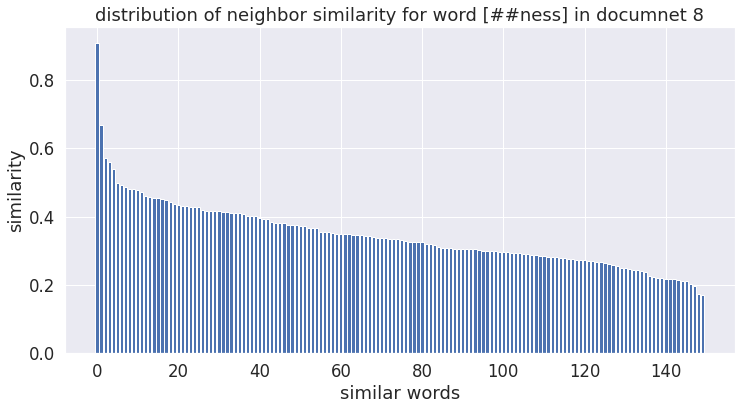

179   -->  erase
1690
[0.7152958, 0.65382814, 0.6528992, 0.646697, 0.585854, 0.54718316, 0.5166022, 0.50477964, 0.4933958, 0.4897093, 0.48765898, 0.4838517, 0.47085676, 0.45904303, 0.45852286, 0.45719975, 0.45517528, 0.45184603, 0.4504729, 0.44928807, 0.4445092, 0.43995434, 0.4345459, 0.43404755, 0.4298355, 0.42834812, 0.42422456, 0.42264724, 0.4222772, 0.42150134, 0.4178502, 0.41710305, 0.41671553, 0.4160537, 0.41565764, 0.41534138, 0.41363317, 0.4108253, 0.40925217, 0.4070348, 0.40556824, 0.40527803, 0.4049707, 0.40482384, 0.39965636, 0.3993918, 0.39907724, 0.39786392, 0.3978074, 0.39501423, 0.39482015, 0.38885996, 0.38874498, 0.38779446, 0.3868861, 0.38621593, 0.3841526, 0.375629, 0.3709498, 0.37040222, 0.36939216, 0.3628277, 0.362248, 0.35774684, 0.35665238, 0.35397816, 0.35342005, 0.35096145, 0.35015035, 0.34948027, 0.34448066, 0.34169492, 0.33992207, 0.33915782, 0.3382942, 0.33382994, 0.33270165, 0.33030385, 0.32976297, 0.3291262, 0.32820624, 0.3221119, 0.32203656, 0.32193148, 0.

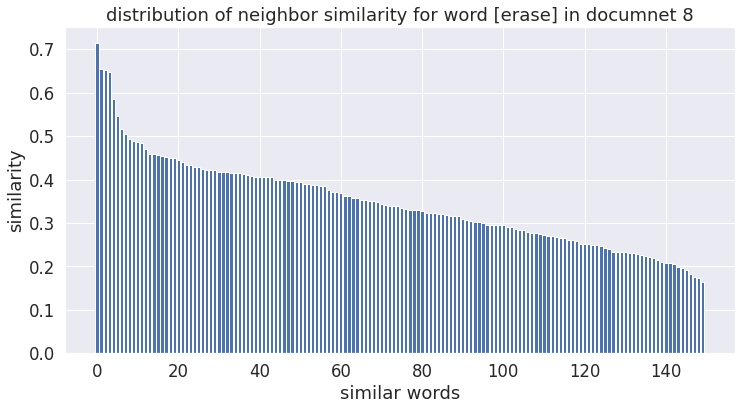

181   -->  vest
1690
[0.885116, 0.8770542, 0.8512183, 0.6921132, 0.67635256, 0.6672001, 0.65382814, 0.63053966, 0.6196953, 0.5965413, 0.5888878, 0.5852281, 0.5729008, 0.56576127, 0.55878973, 0.551199, 0.536511, 0.5295274, 0.5290241, 0.52513766, 0.52511704, 0.5245318, 0.51695895, 0.5141928, 0.5117007, 0.5043749, 0.50065804, 0.50056016, 0.4994802, 0.49370557, 0.49356273, 0.4933641, 0.4883839, 0.48124567, 0.48074463, 0.48025405, 0.47449252, 0.46628278, 0.4637863, 0.46354115, 0.45763174, 0.45478588, 0.4532741, 0.44734478, 0.44438514, 0.43873322, 0.43721005, 0.42989904, 0.42680663, 0.42044634, 0.4163741, 0.41387886, 0.41281435, 0.41266602, 0.4089475, 0.40781057, 0.4056028, 0.40444463, 0.4009559, 0.40088892, 0.39972353, 0.39466777, 0.3935851, 0.390332, 0.38702244, 0.38469204, 0.3813321, 0.37931788, 0.3766267, 0.37514675, 0.37440738, 0.37324402, 0.37185472, 0.37009957, 0.3679071, 0.36233342, 0.35910845, 0.358497, 0.3572083, 0.35649675, 0.35615736, 0.35362428, 0.35352236, 0.34778035, 0.347489,

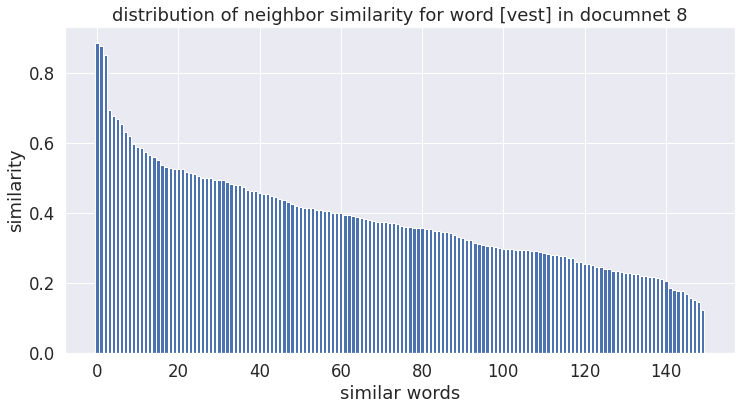

182   -->  ##ige
1690
[0.9207554, 0.885116, 0.81338793, 0.67147756, 0.6528992, 0.6268198, 0.62609386, 0.62547374, 0.62060803, 0.5957992, 0.5743185, 0.5632482, 0.5577151, 0.5324895, 0.52598304, 0.52464724, 0.51960784, 0.51684225, 0.5127042, 0.5099425, 0.50807965, 0.5052946, 0.50148135, 0.500723, 0.49386963, 0.4830689, 0.4706807, 0.4678974, 0.46442515, 0.46145266, 0.45915374, 0.45417964, 0.45153165, 0.44452667, 0.44400117, 0.4431766, 0.4425715, 0.4372267, 0.4333696, 0.43146423, 0.42986044, 0.42887115, 0.4266284, 0.4260165, 0.42557907, 0.4251237, 0.42420983, 0.42152458, 0.41670996, 0.41523576, 0.41305703, 0.4111011, 0.4093207, 0.40925524, 0.4084296, 0.40786028, 0.40452594, 0.39861265, 0.39664865, 0.3930724, 0.39191067, 0.3910975, 0.37431452, 0.3701934, 0.36717707, 0.3661219, 0.36576533, 0.36271924, 0.36217976, 0.36177126, 0.3577296, 0.35554063, 0.34901252, 0.34807006, 0.34374225, 0.34336883, 0.3415591, 0.34076232, 0.3326145, 0.33183643, 0.32936245, 0.32658362, 0.3155927, 0.31348374, 0.311

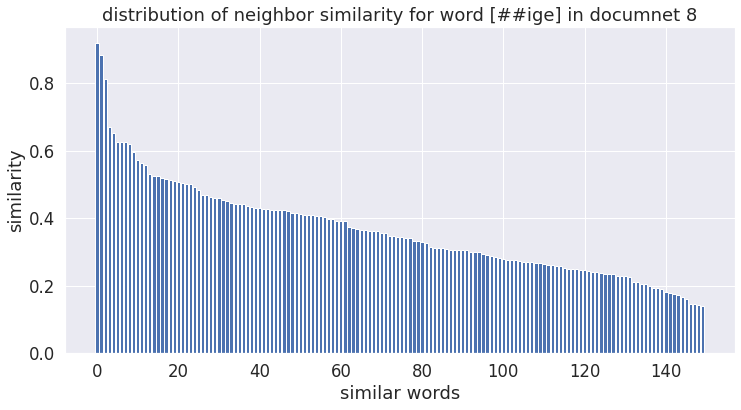

183   -->  ##s
1690
[0.9207554, 0.8770542, 0.7835352, 0.6577981, 0.655771, 0.646697, 0.6283424, 0.6203108, 0.60468626, 0.5970696, 0.5610434, 0.5484143, 0.5443351, 0.5421349, 0.53970706, 0.5290944, 0.52773654, 0.52489156, 0.51840734, 0.5096678, 0.5055461, 0.5041363, 0.50056154, 0.4974389, 0.48981866, 0.48925486, 0.48616815, 0.48266974, 0.47879142, 0.47784674, 0.47743428, 0.47131407, 0.46955353, 0.46924457, 0.46697962, 0.45857924, 0.44930315, 0.44897294, 0.44553548, 0.44321, 0.44154036, 0.43940547, 0.43382013, 0.4327072, 0.4307586, 0.4301724, 0.4279073, 0.42787233, 0.4263264, 0.4233048, 0.42049795, 0.41879016, 0.41259396, 0.4101969, 0.4100215, 0.40384328, 0.39974952, 0.39819366, 0.3958724, 0.394705, 0.39279354, 0.39168486, 0.38854444, 0.38358384, 0.3834499, 0.38079637, 0.3806059, 0.37620062, 0.37554377, 0.37497765, 0.37338364, 0.36431858, 0.3597589, 0.35891622, 0.35545906, 0.35255885, 0.35159802, 0.35078683, 0.3458255, 0.34220967, 0.3420151, 0.34172612, 0.34007704, 0.33859503, 0.33470958

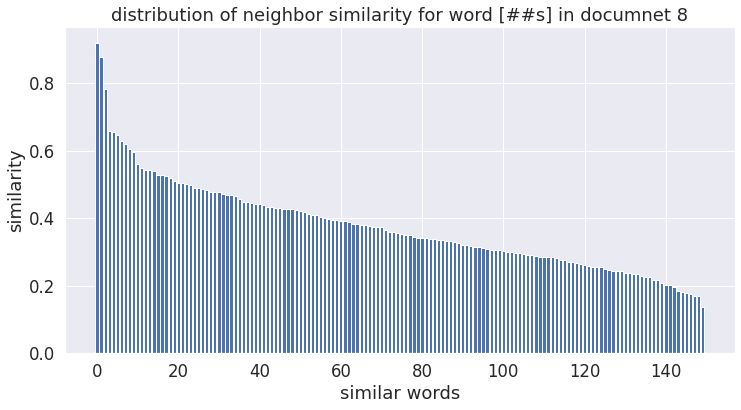

188   -->  mighty
1690
[0.7926893, 0.771982, 0.67635256, 0.67147756, 0.6577981, 0.6470918, 0.64272875, 0.63048494, 0.62465703, 0.61274797, 0.61249423, 0.61010575, 0.6021455, 0.5983063, 0.5934868, 0.5774119, 0.56880844, 0.56110775, 0.55436575, 0.5497278, 0.5469274, 0.544888, 0.54400486, 0.53328973, 0.5271508, 0.5164975, 0.515082, 0.51012206, 0.50603545, 0.50560844, 0.50477964, 0.5023719, 0.5007072, 0.4942664, 0.49133098, 0.48703757, 0.48424086, 0.4831616, 0.4795565, 0.47867575, 0.47510403, 0.47218436, 0.46681705, 0.46659264, 0.46441638, 0.4615388, 0.45977616, 0.4578143, 0.44371918, 0.4417032, 0.43948752, 0.43585166, 0.42866814, 0.42618942, 0.42586204, 0.42137414, 0.42004803, 0.41917825, 0.41851234, 0.4167543, 0.4147814, 0.41295862, 0.41072828, 0.40889803, 0.4073384, 0.40705407, 0.4069726, 0.4064252, 0.40130344, 0.40057325, 0.40002877, 0.39770296, 0.39573097, 0.3899073, 0.38920957, 0.3871882, 0.38718054, 0.38402414, 0.3773722, 0.37354052, 0.3729828, 0.37278533, 0.37249634, 0.37240547, 0.

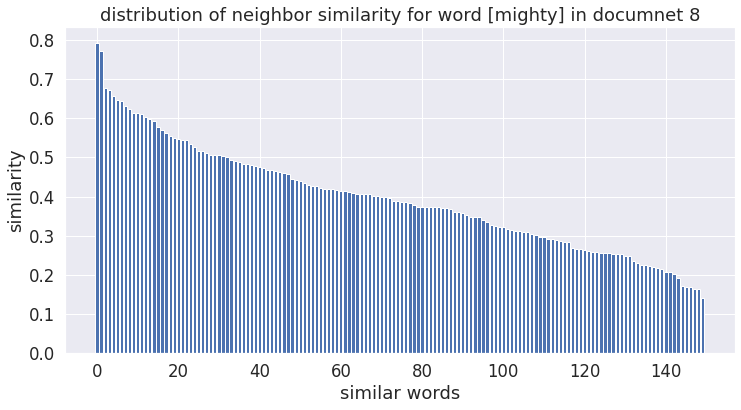

189   -->  communists
1690
[0.7926893, 0.6909321, 0.6869837, 0.6789668, 0.6776121, 0.66946185, 0.655771, 0.63784146, 0.6332256, 0.63053966, 0.6268198, 0.6233575, 0.6080642, 0.6063911, 0.5998282, 0.57524234, 0.56989956, 0.5648208, 0.55843043, 0.55657434, 0.55146945, 0.5159344, 0.5110259, 0.5067862, 0.5016455, 0.501629, 0.501452, 0.4966089, 0.49575156, 0.4897412, 0.48191482, 0.4796685, 0.47670215, 0.47622734, 0.46700937, 0.46123415, 0.45942944, 0.45852286, 0.45392728, 0.45295548, 0.45080787, 0.44675857, 0.43749934, 0.43581077, 0.43471572, 0.43469477, 0.42886716, 0.4255954, 0.4229458, 0.42124704, 0.41706672, 0.4072138, 0.40628117, 0.40331215, 0.40043876, 0.39827445, 0.3939748, 0.3913911, 0.3906433, 0.3880246, 0.38794577, 0.38772982, 0.38252145, 0.38087878, 0.3775789, 0.3756579, 0.37338012, 0.37016165, 0.36562827, 0.36444134, 0.36386764, 0.35902157, 0.35792387, 0.3496169, 0.3478313, 0.3462387, 0.34529585, 0.3445418, 0.34393165, 0.34253263, 0.34116164, 0.34031427, 0.33768094, 0.3362571, 0.3

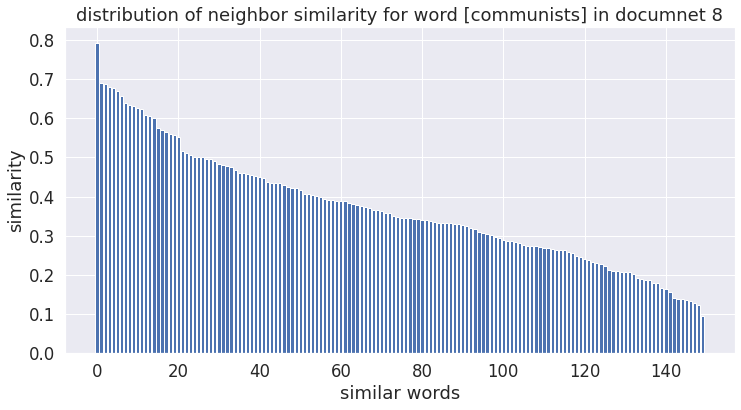

191   -->  risen
1690
[0.8516283, 0.65950465, 0.55526316, 0.51754713, 0.49320364, 0.48692188, 0.46063617, 0.4449377, 0.42024243, 0.41749454, 0.4163741, 0.41565797, 0.41383514, 0.4134506, 0.4084296, 0.40679887, 0.40455523, 0.40384328, 0.4021588, 0.40130344, 0.39906615, 0.39219195, 0.39183608, 0.39099535, 0.3832815, 0.3793163, 0.37651548, 0.37598592, 0.3741848, 0.3728503, 0.36956513, 0.36863196, 0.3685463, 0.36830172, 0.36747202, 0.366055, 0.36171082, 0.36029583, 0.35720363, 0.35525677, 0.3539272, 0.35363516, 0.34961468, 0.34715098, 0.3449218, 0.34443825, 0.34395644, 0.34245637, 0.34169492, 0.34154022, 0.33905596, 0.3367218, 0.33423817, 0.33374578, 0.3329679, 0.3294384, 0.32749182, 0.32443666, 0.32374746, 0.3217503, 0.31983232, 0.31684303, 0.31567824, 0.31559798, 0.31491682, 0.31491628, 0.3146671, 0.312679, 0.30893642, 0.30656815, 0.30620795, 0.30427933, 0.30365157, 0.29761565, 0.29691836, 0.29677278, 0.29647505, 0.29645148, 0.29609773, 0.2954707, 0.29529896, 0.2945577, 0.2931788, 0.2924

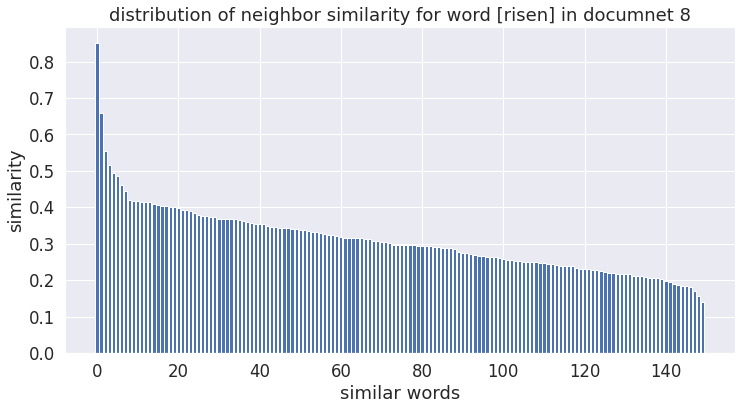

193   -->  among
1690
[0.73608816, 0.73600805, 0.7266563, 0.71498907, 0.69836986, 0.69075805, 0.68226254, 0.6674272, 0.63896126, 0.6256751, 0.619444, 0.60057604, 0.59973186, 0.5756559, 0.55526316, 0.53795916, 0.51770055, 0.49429256, 0.49195528, 0.4703281, 0.46979755, 0.46659264, 0.46628278, 0.46442515, 0.46057668, 0.4534613, 0.45295548, 0.44408768, 0.44154036, 0.43990305, 0.4310189, 0.43090367, 0.43077585, 0.42971566, 0.4286195, 0.42463693, 0.42425668, 0.42272595, 0.42221332, 0.4196396, 0.41773802, 0.4170879, 0.41062725, 0.40830356, 0.40654305, 0.40523824, 0.40282127, 0.4023753, 0.40223718, 0.39672825, 0.39582628, 0.39556295, 0.39482015, 0.39154103, 0.39040187, 0.3852952, 0.37624705, 0.37357497, 0.3731711, 0.3685758, 0.3661303, 0.3575741, 0.34941268, 0.3467677, 0.34360227, 0.34318173, 0.34226695, 0.33777612, 0.3319658, 0.32780606, 0.32248616, 0.32090834, 0.3180418, 0.3142779, 0.3131022, 0.30995238, 0.30873466, 0.30296278, 0.300135, 0.29939607, 0.29772183, 0.29427293, 0.2925864, 0.29010

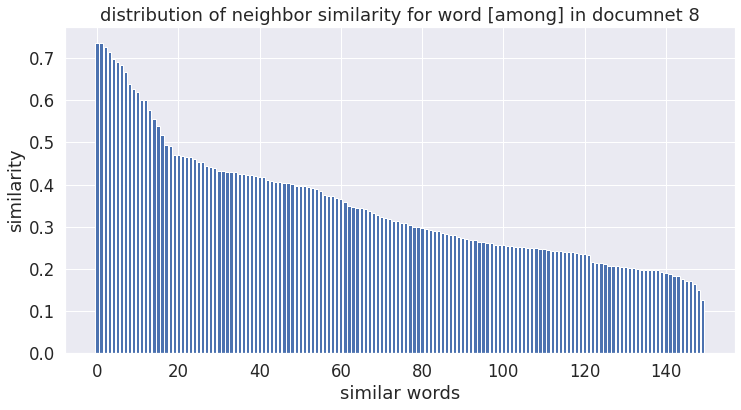

194   -->  students
1690
[0.8710881, 0.87027615, 0.8653387, 0.81255543, 0.81186724, 0.7536349, 0.73608816, 0.7065563, 0.6919757, 0.67842865, 0.6726484, 0.6523477, 0.64943564, 0.63784146, 0.6062592, 0.60531515, 0.5934868, 0.5729008, 0.5632482, 0.55711794, 0.5487884, 0.5484143, 0.5409255, 0.54058826, 0.5368485, 0.53018254, 0.52375484, 0.518918, 0.51650715, 0.50464845, 0.5045937, 0.49979508, 0.498358, 0.49636394, 0.49633557, 0.48780861, 0.48296434, 0.48164243, 0.4708901, 0.4588021, 0.45775244, 0.4504729, 0.4462655, 0.4443358, 0.43750936, 0.43558076, 0.4336634, 0.43194407, 0.4317909, 0.42900926, 0.42780757, 0.4249697, 0.42470255, 0.42057788, 0.42006254, 0.4179263, 0.41665345, 0.41524374, 0.4140501, 0.41184205, 0.40996495, 0.405051, 0.4036108, 0.39782387, 0.39297557, 0.39180636, 0.39099535, 0.38806275, 0.38651627, 0.37926638, 0.37651294, 0.37116846, 0.36671105, 0.36212963, 0.3600105, 0.3594218, 0.3566426, 0.34281185, 0.33832997, 0.33817604, 0.33807003, 0.33629343, 0.3336445, 0.33211935, 0.3

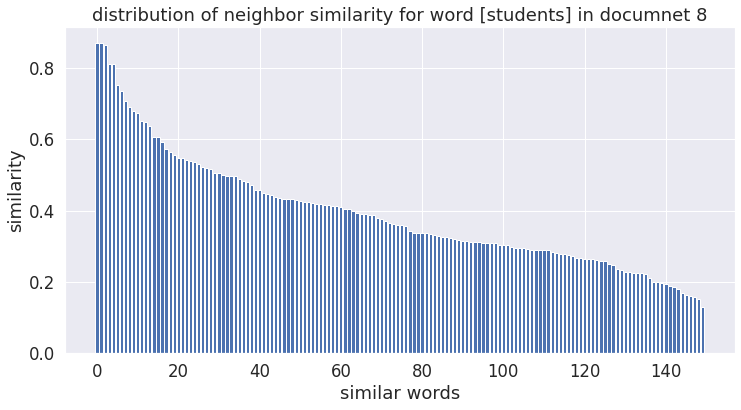

197   -->  streets
1690
[0.8653387, 0.8425906, 0.8261606, 0.7950162, 0.7920799, 0.7463163, 0.68226254, 0.6523721, 0.6501223, 0.6376273, 0.61861634, 0.60652936, 0.5981833, 0.57524234, 0.550297, 0.5497278, 0.54814214, 0.536511, 0.52196556, 0.5092528, 0.5059929, 0.505742, 0.5052946, 0.49771574, 0.49427631, 0.4933898, 0.4924792, 0.48981866, 0.48977637, 0.4897098, 0.48402122, 0.48017645, 0.47535372, 0.4731442, 0.47004774, 0.4549058, 0.4497816, 0.4493151, 0.44917667, 0.4410578, 0.4392658, 0.439263, 0.4285497, 0.4273206, 0.42219144, 0.41801137, 0.41649765, 0.41469106, 0.4134506, 0.41242567, 0.40719312, 0.4070348, 0.40594423, 0.40208897, 0.40121505, 0.3973518, 0.3960716, 0.39540088, 0.39001247, 0.3872478, 0.38317862, 0.3830598, 0.38252503, 0.38152033, 0.37438375, 0.36988527, 0.36880726, 0.36417544, 0.36271033, 0.36259478, 0.36131427, 0.36017838, 0.3599284, 0.35871357, 0.3525156, 0.34878567, 0.34798643, 0.3417015, 0.3395135, 0.33925903, 0.33731937, 0.3368051, 0.3334167, 0.33261943, 0.3322111, 0

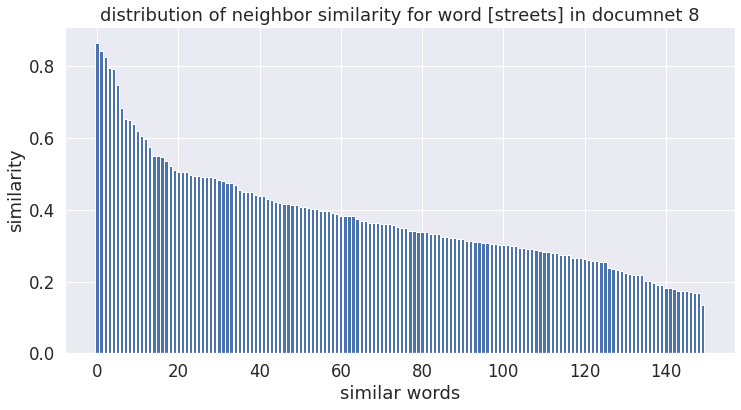

199   -->  long
1690
[0.848261, 0.7836042, 0.77717996, 0.7717735, 0.7536349, 0.74699646, 0.7463163, 0.73297, 0.70877457, 0.6544682, 0.65309453, 0.6490691, 0.64657235, 0.63896126, 0.5988399, 0.59297097, 0.5884895, 0.56880844, 0.56576127, 0.5648208, 0.5621691, 0.5375483, 0.5281321, 0.5276087, 0.5158006, 0.5127042, 0.5055461, 0.50382173, 0.48953015, 0.48759404, 0.48173553, 0.48160696, 0.4807837, 0.48016715, 0.479541, 0.4632809, 0.46241713, 0.45863184, 0.44852737, 0.44847998, 0.44560954, 0.44505942, 0.4445536, 0.44281283, 0.4374534, 0.43722475, 0.43615672, 0.42834812, 0.42324215, 0.42233092, 0.42077523, 0.41987318, 0.41967294, 0.41568625, 0.4146464, 0.41133398, 0.40995705, 0.40882277, 0.40775067, 0.3995561, 0.39737487, 0.39012545, 0.3854642, 0.38041088, 0.37727693, 0.3739337, 0.37123516, 0.36714357, 0.36710387, 0.366055, 0.36535186, 0.36496228, 0.36420584, 0.35940403, 0.35934594, 0.35529763, 0.3544668, 0.350625, 0.3440429, 0.34346426, 0.34077942, 0.3369736, 0.33579266, 0.32963058, 0.323010

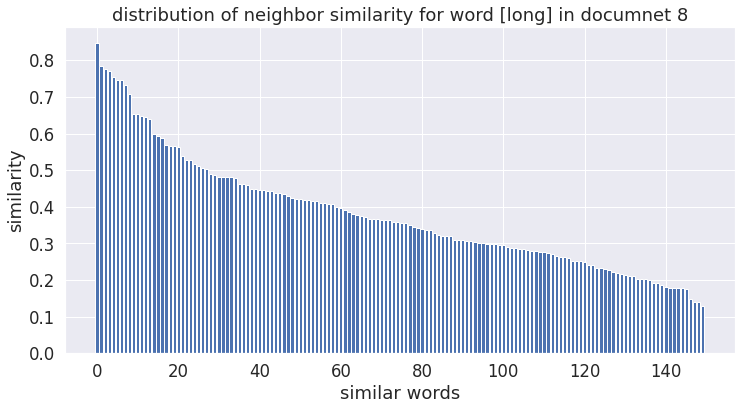

201   -->  suppressed
1690
[0.848261, 0.84392786, 0.8407154, 0.81255543, 0.7920799, 0.7875058, 0.77256906, 0.74361557, 0.73864627, 0.7196444, 0.7008387, 0.69075805, 0.68289816, 0.63048494, 0.6233575, 0.6122523, 0.60059285, 0.5888878, 0.5669937, 0.5608604, 0.5577151, 0.5534862, 0.5533718, 0.5523906, 0.546543, 0.54385865, 0.53970706, 0.53770065, 0.5290675, 0.52364326, 0.51761633, 0.5065361, 0.50488406, 0.49401858, 0.47448745, 0.47235334, 0.4643112, 0.4615389, 0.45966792, 0.45904303, 0.45768106, 0.45736066, 0.45116907, 0.44944644, 0.44880456, 0.44483483, 0.44386226, 0.4347549, 0.43076336, 0.4276593, 0.42389816, 0.42164454, 0.4206695, 0.41813672, 0.4171902, 0.41705865, 0.41631764, 0.41048712, 0.40225458, 0.4015618, 0.39921385, 0.39455718, 0.39257067, 0.39219195, 0.39021188, 0.3874472, 0.38329864, 0.38076496, 0.38068575, 0.3787946, 0.3695449, 0.3559671, 0.3515001, 0.35030892, 0.3490404, 0.34844285, 0.34275943, 0.3423053, 0.33957484, 0.3357845, 0.33291137, 0.3272667, 0.32324022, 0.3226927, 0

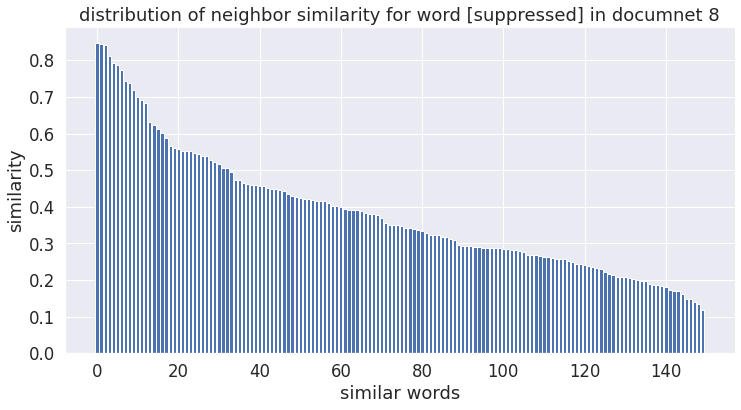

202   -->  artists
1690
[0.93259925, 0.87027615, 0.8425906, 0.8407154, 0.7836042, 0.7351849, 0.73239106, 0.71865416, 0.71395904, 0.6776121, 0.6650152, 0.6612084, 0.65976375, 0.619444, 0.61010575, 0.59600425, 0.5780113, 0.56073314, 0.55878973, 0.5533042, 0.5496152, 0.54655004, 0.54188645, 0.5403352, 0.53480977, 0.5324895, 0.5301298, 0.52913964, 0.52489156, 0.5211801, 0.5184412, 0.5133767, 0.5089582, 0.4971141, 0.4918031, 0.48968735, 0.48696607, 0.48522016, 0.48005188, 0.4661021, 0.4660833, 0.45840418, 0.45246512, 0.44354993, 0.44187006, 0.43458658, 0.43295866, 0.43174118, 0.4298355, 0.42589396, 0.4257483, 0.4255113, 0.42037916, 0.419775, 0.418082, 0.41117457, 0.40927023, 0.40722242, 0.40716052, 0.40588838, 0.40572926, 0.40215594, 0.39854544, 0.39274, 0.39219147, 0.3893007, 0.3881327, 0.38719785, 0.38675204, 0.3853764, 0.38450092, 0.38277632, 0.3741848, 0.37231404, 0.36958838, 0.36672652, 0.36522096, 0.3602938, 0.3521015, 0.33921435, 0.33900717, 0.33808306, 0.3358423, 0.33496565, 0.33380

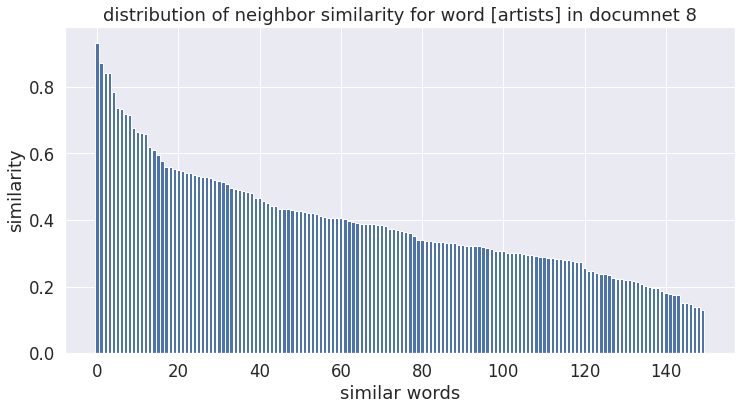

204   -->  intellectuals
1690
[0.93259925, 0.8710881, 0.84392786, 0.8261606, 0.77717996, 0.7746942, 0.7505096, 0.726189, 0.72364056, 0.72299063, 0.7152357, 0.6789668, 0.6674272, 0.655741, 0.62465703, 0.62416434, 0.62374794, 0.5852281, 0.58298254, 0.5743185, 0.5706484, 0.56770897, 0.56656003, 0.5610434, 0.55691457, 0.5464722, 0.5389031, 0.53711134, 0.53276026, 0.532525, 0.5324819, 0.5218752, 0.5169867, 0.5163785, 0.51581466, 0.50878364, 0.50599635, 0.5048734, 0.5023662, 0.48709005, 0.48541337, 0.47103766, 0.46078625, 0.46018767, 0.45719975, 0.45614251, 0.45442426, 0.454354, 0.45104975, 0.44484013, 0.44337568, 0.4431747, 0.44285497, 0.44240794, 0.43902695, 0.43436763, 0.42920896, 0.42670006, 0.42651552, 0.42550164, 0.41884142, 0.41066384, 0.4098254, 0.4078768, 0.40719497, 0.40603402, 0.40392104, 0.4021588, 0.3954232, 0.39344653, 0.392865, 0.38228226, 0.37858695, 0.37816405, 0.37444073, 0.3697093, 0.36600876, 0.357591, 0.3532406, 0.34930485, 0.34696063, 0.34588146, 0.34266686, 0.34173518,

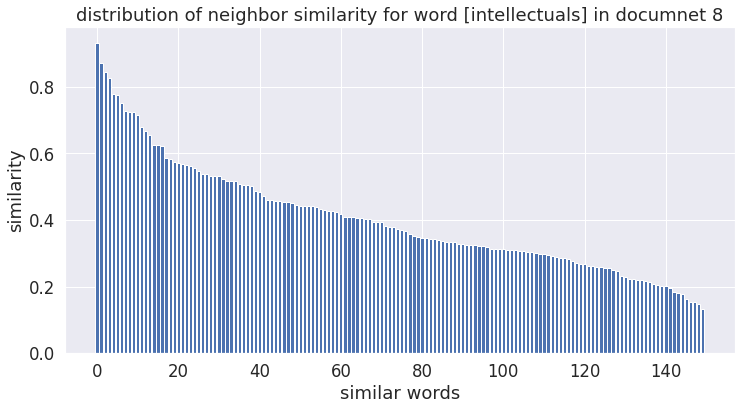

207   -->  even
1690
[0.82781804, 0.8024041, 0.72364056, 0.71498907, 0.7119199, 0.6994061, 0.68289816, 0.6726484, 0.6650152, 0.65309453, 0.64567065, 0.62588394, 0.60652936, 0.54133713, 0.53805494, 0.51790535, 0.5110259, 0.50996697, 0.5099425, 0.50821394, 0.50673866, 0.5048964, 0.50460935, 0.5044423, 0.5041363, 0.50219417, 0.49555093, 0.4933641, 0.49041894, 0.49030694, 0.48692188, 0.48162264, 0.48069382, 0.4795565, 0.47363728, 0.47297302, 0.4712564, 0.45533493, 0.45379892, 0.45184603, 0.45128846, 0.4505469, 0.44693956, 0.4464423, 0.44613418, 0.4454369, 0.44226557, 0.44093594, 0.43953502, 0.43914747, 0.4335065, 0.41659445, 0.41189164, 0.41119033, 0.4087597, 0.40644306, 0.40320134, 0.40163085, 0.39362705, 0.39106202, 0.38663933, 0.3840974, 0.38030714, 0.37448603, 0.3688804, 0.36791742, 0.3667361, 0.36601472, 0.36543384, 0.36514884, 0.3576606, 0.3559467, 0.35138223, 0.35006046, 0.34964114, 0.34905764, 0.34547263, 0.3430429, 0.34213418, 0.34202948, 0.34130913, 0.33992642, 0.33363208, 0.3333

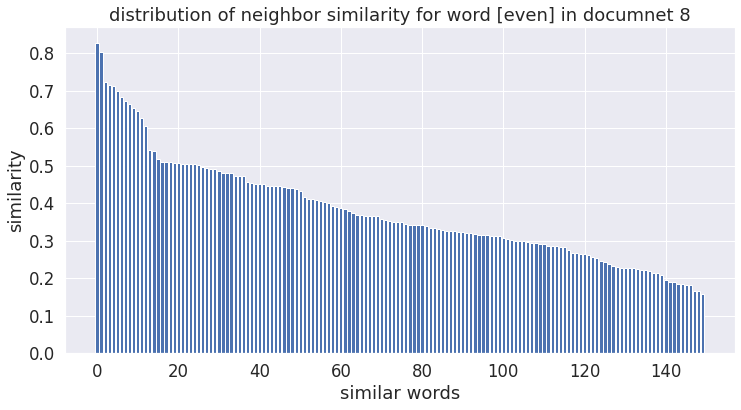

210   -->  party
1690
[0.66946185, 0.61849254, 0.5780113, 0.5753813, 0.5706484, 0.56459284, 0.55303156, 0.544888, 0.54385865, 0.5375483, 0.5374305, 0.5368485, 0.53677464, 0.517758, 0.5140109, 0.50737154, 0.50538146, 0.5012795, 0.49427631, 0.48262045, 0.47851306, 0.4774842, 0.47363728, 0.47054848, 0.46171194, 0.45840147, 0.4513231, 0.4467969, 0.4467584, 0.4457869, 0.44505346, 0.44413328, 0.44227102, 0.43721005, 0.43684715, 0.43367633, 0.4301724, 0.42927456, 0.4263345, 0.4261846, 0.42086828, 0.4196396, 0.4151206, 0.41087115, 0.4100435, 0.40925524, 0.4055406, 0.40527803, 0.4047798, 0.4045452, 0.4016776, 0.39809507, 0.39382088, 0.3899935, 0.38613218, 0.38581264, 0.3838871, 0.38025633, 0.3798184, 0.3787072, 0.37791693, 0.37641126, 0.37462002, 0.3744763, 0.37360835, 0.37337387, 0.37028342, 0.37016502, 0.3696751, 0.36947012, 0.36818844, 0.36747584, 0.367284, 0.36687467, 0.36535317, 0.36488044, 0.36123818, 0.3601996, 0.36008435, 0.35822827, 0.3569402, 0.35405564, 0.35374242, 0.35242447, 0.3488

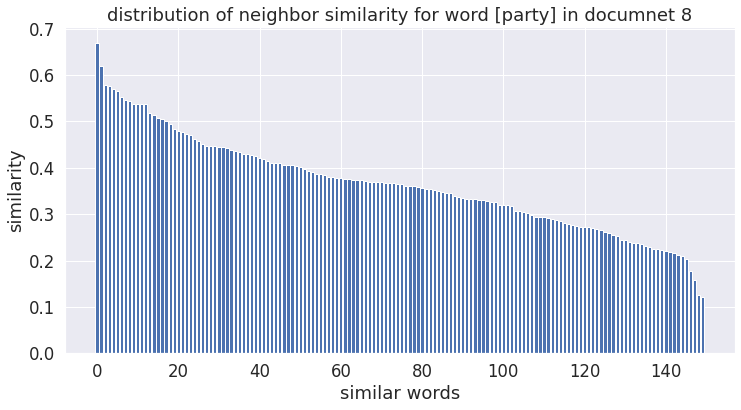

213   -->  dec
1690
[0.8638822, 0.81292737, 0.75548506, 0.73864627, 0.73297, 0.726189, 0.7181922, 0.71395904, 0.68687785, 0.67842865, 0.6672001, 0.655972, 0.64567065, 0.6376273, 0.6266751, 0.61249423, 0.60468626, 0.5998282, 0.5996507, 0.5957992, 0.58700466, 0.5756559, 0.5753813, 0.5348116, 0.52516735, 0.523789, 0.51868725, 0.5095657, 0.5058124, 0.48765898, 0.47829092, 0.4752138, 0.47133896, 0.4653389, 0.4629828, 0.462344, 0.46158904, 0.4536177, 0.4517869, 0.45064208, 0.4504474, 0.44931558, 0.44722366, 0.4442739, 0.44318366, 0.4383188, 0.43579456, 0.4355371, 0.4335466, 0.43208057, 0.42981023, 0.42667368, 0.4259495, 0.42418104, 0.41805878, 0.41785067, 0.4149425, 0.4083584, 0.40835074, 0.4007175, 0.40059748, 0.39739704, 0.39371917, 0.39290142, 0.38768637, 0.38640803, 0.3861881, 0.38502693, 0.37940007, 0.3790928, 0.37127542, 0.36892125, 0.36830172, 0.36829615, 0.36769933, 0.36634266, 0.36250848, 0.36221254, 0.3615474, 0.34344268, 0.3432384, 0.3431328, 0.34278217, 0.34248406, 0.34096682, 0.

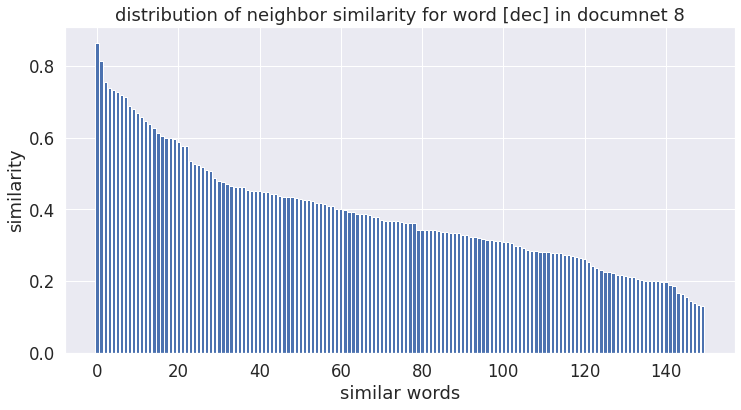

214   -->  ##imated
1690
[0.8638822, 0.83576846, 0.7875058, 0.75213706, 0.7505096, 0.73239106, 0.7119199, 0.70877457, 0.7075764, 0.7065563, 0.6501223, 0.6470918, 0.63407284, 0.6295732, 0.6256751, 0.62547374, 0.6233276, 0.621284, 0.6196953, 0.6063911, 0.59965974, 0.5970696, 0.56459284, 0.55061245, 0.54580146, 0.5339255, 0.5334493, 0.5315521, 0.5166022, 0.5018711, 0.49554938, 0.4918874, 0.4905717, 0.48266965, 0.4809572, 0.48041573, 0.4751078, 0.47283348, 0.47083834, 0.47050536, 0.47046262, 0.4613813, 0.46132118, 0.45898905, 0.45669678, 0.4549157, 0.45034623, 0.44889805, 0.4471152, 0.44364834, 0.4416728, 0.44097185, 0.43695357, 0.43687865, 0.43568203, 0.43377584, 0.4246271, 0.42179424, 0.415236, 0.4121617, 0.4101109, 0.4100243, 0.40942627, 0.40519404, 0.40455523, 0.40277988, 0.4003352, 0.39872232, 0.3962971, 0.39363822, 0.39283308, 0.3878479, 0.38444966, 0.3841368, 0.382935, 0.37886053, 0.37577218, 0.3736292, 0.36815342, 0.36732244, 0.36717153, 0.3638518, 0.36305934, 0.3625112, 0.3620643,

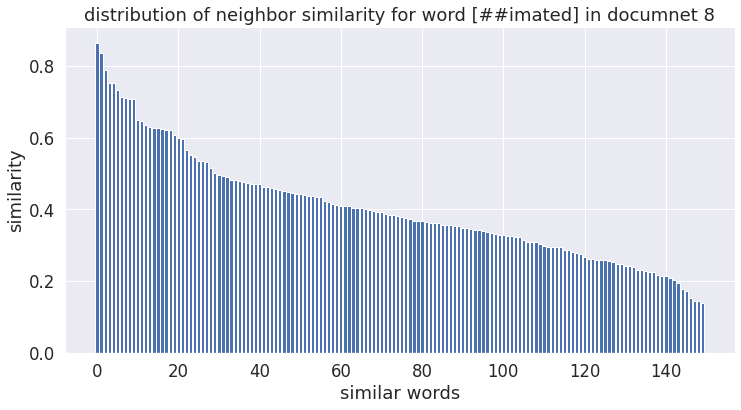

215   -->  ranks
1690
[0.83576846, 0.81292737, 0.7746942, 0.75152194, 0.7196444, 0.71865416, 0.6994061, 0.6919757, 0.6869837, 0.6660046, 0.64657235, 0.64272875, 0.62060803, 0.6203108, 0.61861634, 0.61849254, 0.6089307, 0.60057604, 0.5965413, 0.58919924, 0.57468724, 0.5692003, 0.56782806, 0.5635356, 0.54156005, 0.54132986, 0.5154605, 0.50157607, 0.500133, 0.49756387, 0.49492532, 0.48025292, 0.47812843, 0.47369072, 0.4730802, 0.4673178, 0.4598667, 0.45801353, 0.44928807, 0.44422987, 0.44231182, 0.4381289, 0.43714482, 0.43517417, 0.43404236, 0.4296899, 0.42786032, 0.4246645, 0.42152995, 0.42138344, 0.42115578, 0.4158902, 0.4144926, 0.413437, 0.4125756, 0.40606248, 0.40541327, 0.40369245, 0.39606687, 0.39321977, 0.3896209, 0.3876614, 0.38659167, 0.38207796, 0.38155016, 0.37837976, 0.37751448, 0.37275228, 0.36995196, 0.3685463, 0.367367, 0.36426884, 0.35909057, 0.35868633, 0.35821134, 0.35426033, 0.35320646, 0.35126925, 0.35113305, 0.34540018, 0.34493947, 0.3411328, 0.3396819, 0.33832163, 0

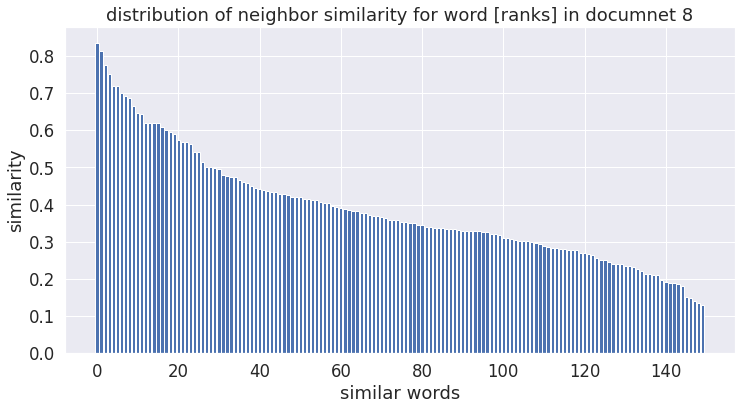

218   -->  cry
1690
[0.753026, 0.64673996, 0.5510746, 0.5172205, 0.46936297, 0.4460528, 0.4443242, 0.4414987, 0.43157375, 0.41677207, 0.402533, 0.3959862, 0.39497426, 0.39054632, 0.3844185, 0.38438275, 0.38145012, 0.3799975, 0.37844622, 0.37744004, 0.37725902, 0.3767193, 0.37512392, 0.37370488, 0.3708139, 0.36891234, 0.36687467, 0.36539853, 0.36359373, 0.36331135, 0.36268497, 0.3613971, 0.3611529, 0.3569733, 0.35403877, 0.3539953, 0.35195354, 0.35077608, 0.35021466, 0.35002536, 0.34988314, 0.34906635, 0.34883043, 0.34783852, 0.3468605, 0.34674603, 0.34579545, 0.3449218, 0.3399806, 0.3398607, 0.33518377, 0.3334771, 0.33232725, 0.32835272, 0.32774672, 0.32626337, 0.32176214, 0.3216499, 0.31702596, 0.31360194, 0.31306002, 0.31129354, 0.30919403, 0.30764964, 0.3074733, 0.30529314, 0.30467886, 0.3044793, 0.30363387, 0.30185425, 0.29936728, 0.29905492, 0.29661703, 0.29527065, 0.2947034, 0.29469696, 0.29454187, 0.293497, 0.286696, 0.286635, 0.28406996, 0.28025627, 0.27941385, 0.27731276, 0.27

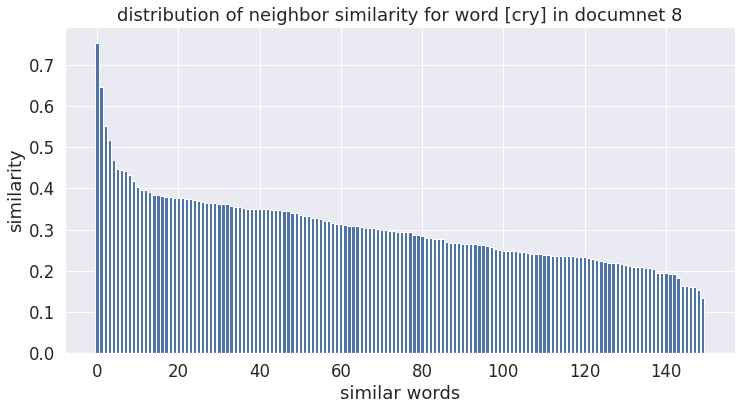

219   -->  reflects
1690
[0.753026, 0.6363315, 0.55297816, 0.5062561, 0.4781626, 0.47114974, 0.45550805, 0.44515312, 0.44307533, 0.44085604, 0.4376351, 0.43692994, 0.43112803, 0.42793772, 0.42516947, 0.4196146, 0.4179935, 0.41415226, 0.41162682, 0.4073715, 0.40704018, 0.39801943, 0.3976498, 0.39675495, 0.39185917, 0.39101386, 0.3900783, 0.38907546, 0.3889408, 0.3858863, 0.38434416, 0.3819037, 0.3814643, 0.38004056, 0.37936008, 0.37366134, 0.3727215, 0.37070084, 0.3696313, 0.36702627, 0.36660868, 0.36344334, 0.36172372, 0.3612823, 0.35765544, 0.35691357, 0.35327986, 0.35226268, 0.3513885, 0.34783536, 0.34717405, 0.34451774, 0.34207237, 0.34154022, 0.34094635, 0.34060192, 0.3397789, 0.3380796, 0.33797202, 0.33643126, 0.33460185, 0.334404, 0.3313176, 0.33125567, 0.33034477, 0.32895672, 0.3285433, 0.32618168, 0.32608825, 0.3254051, 0.32417673, 0.32081315, 0.3182705, 0.31653523, 0.31467772, 0.3141368, 0.3126266, 0.3114292, 0.3062625, 0.30218062, 0.3014639, 0.30130476, 0.29967397, 0.29683855

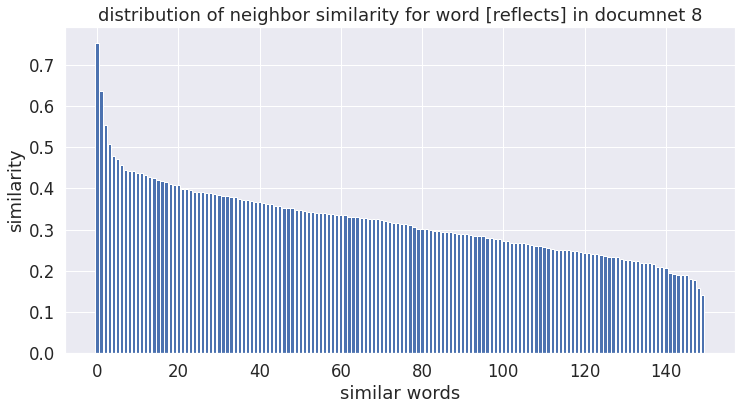

221   -->  swirl
1690
[0.70295084, 0.69234246, 0.64673996, 0.6363315, 0.61339664, 0.56983566, 0.51754713, 0.51344657, 0.49844393, 0.48698983, 0.48663777, 0.4830321, 0.4603582, 0.45435524, 0.44890445, 0.4284425, 0.42558265, 0.42161304, 0.41790074, 0.41670996, 0.41659445, 0.41259396, 0.40790612, 0.40695274, 0.4008308, 0.39466777, 0.39035034, 0.38920957, 0.38808239, 0.38707766, 0.3841526, 0.38413805, 0.383731, 0.38219845, 0.38218385, 0.38155016, 0.3811507, 0.38002068, 0.37696606, 0.37624705, 0.37376034, 0.37360835, 0.3701675, 0.36937183, 0.36925462, 0.36921442, 0.36738235, 0.36111787, 0.36047167, 0.3572234, 0.35719293, 0.35355842, 0.3519135, 0.3518167, 0.3501182, 0.34777552, 0.34609258, 0.34588146, 0.34576768, 0.34487623, 0.34428287, 0.34242374, 0.34206426, 0.34157455, 0.34142697, 0.3411986, 0.34075505, 0.33946034, 0.33907062, 0.337414, 0.336083, 0.33557582, 0.33523855, 0.327906, 0.32646617, 0.32635456, 0.32490706, 0.32438594, 0.32210928, 0.3199142, 0.31879106, 0.31820947, 0.31752968, 0.3

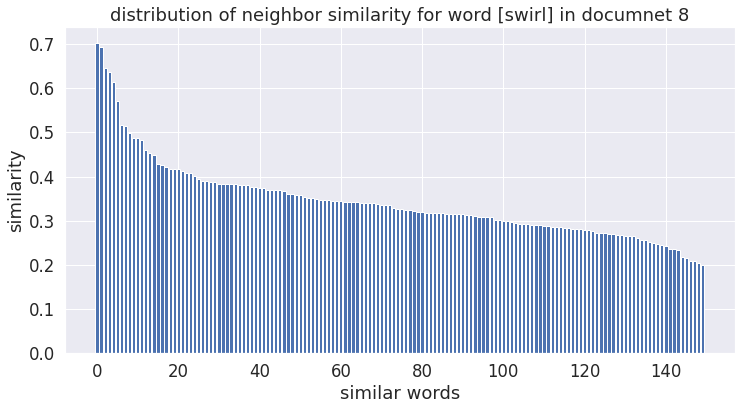

223   -->  revolutionary
1690
[0.7402526, 0.70295084, 0.6897899, 0.67513025, 0.57310355, 0.55297816, 0.5510746, 0.54400486, 0.5404521, 0.53677464, 0.5318717, 0.521299, 0.5117007, 0.50878364, 0.50168717, 0.4996929, 0.49942458, 0.498358, 0.49789095, 0.49386963, 0.49038815, 0.49027818, 0.4897412, 0.48616815, 0.48132586, 0.4785066, 0.47582927, 0.4730802, 0.4717999, 0.47085685, 0.47085676, 0.47046262, 0.46973288, 0.46827537, 0.46809748, 0.46800953, 0.4661021, 0.46602345, 0.4637538, 0.4610281, 0.46063617, 0.45840228, 0.4566739, 0.45348287, 0.45176506, 0.4505469, 0.4493658, 0.44880456, 0.44829172, 0.44280326, 0.4423948, 0.4392658, 0.4362457, 0.43331558, 0.43220925, 0.42989376, 0.42981023, 0.42964053, 0.42821798, 0.42496952, 0.42463693, 0.4240231, 0.42325813, 0.42113882, 0.4195686, 0.4192748, 0.41769487, 0.4165656, 0.41641665, 0.41397738, 0.41329122, 0.41280967, 0.40996027, 0.40508145, 0.4043414, 0.40387973, 0.40337902, 0.3995891, 0.3995561, 0.39788955, 0.3941269, 0.39395037, 0.39385095, 0.392

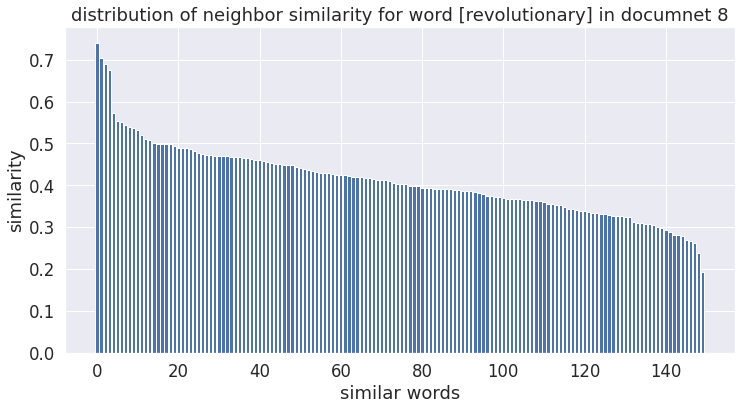

224   -->  fe
1690
[0.77203435, 0.6950543, 0.6897899, 0.61339664, 0.6049194, 0.5727544, 0.48045596, 0.48025405, 0.46936297, 0.44394636, 0.44371918, 0.44321, 0.44236386, 0.4372267, 0.43684715, 0.42667368, 0.42624307, 0.42603248, 0.4223883, 0.42158446, 0.41338518, 0.4120742, 0.41162682, 0.4114595, 0.4108253, 0.40719497, 0.40666258, 0.40110204, 0.39905238, 0.3976081, 0.39535838, 0.39448428, 0.39297557, 0.39183608, 0.38675204, 0.38659167, 0.3852952, 0.38319463, 0.3830393, 0.38252503, 0.38252145, 0.38057303, 0.37910324, 0.37567812, 0.3745457, 0.37399775, 0.3738666, 0.37239805, 0.37198988, 0.36965084, 0.36839247, 0.3675898, 0.36514884, 0.36497355, 0.3626917, 0.36225027, 0.3620643, 0.36119473, 0.36113626, 0.36058956, 0.35934594, 0.3586561, 0.3582325, 0.35444707, 0.35268077, 0.35095164, 0.35054427, 0.3500803, 0.34859806, 0.34756768, 0.34715346, 0.34583056, 0.34571958, 0.34502855, 0.34434214, 0.3423053, 0.3418935, 0.34062505, 0.3398481, 0.3366087, 0.33507663, 0.33218005, 0.33140063, 0.3259998, 

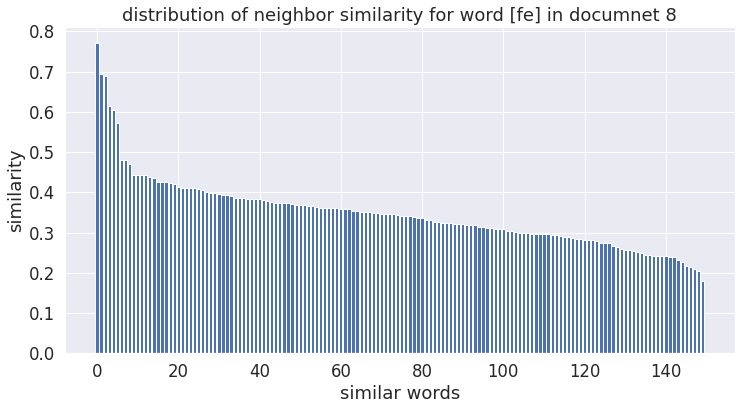

225   -->  ##r
1690
[0.6950543, 0.67513025, 0.67191017, 0.56983566, 0.56066257, 0.5376729, 0.5199336, 0.51695895, 0.49682468, 0.49340194, 0.4775495, 0.4774842, 0.47510403, 0.47390288, 0.47367498, 0.46860242, 0.4659149, 0.4560283, 0.44924074, 0.44515312, 0.4414987, 0.43703222, 0.43691283, 0.4364397, 0.43525594, 0.42425233, 0.4233048, 0.41864792, 0.41713405, 0.41691333, 0.4144246, 0.41303575, 0.41242567, 0.40835074, 0.40754038, 0.40710217, 0.40679887, 0.40588835, 0.40572926, 0.4036108, 0.40043876, 0.39580047, 0.39344653, 0.39191067, 0.38250303, 0.3821506, 0.38206962, 0.37848797, 0.37676775, 0.37663373, 0.3747093, 0.37430537, 0.3728539, 0.3724133, 0.37223923, 0.3717183, 0.3709498, 0.3688735, 0.36732244, 0.36496228, 0.36234605, 0.35923594, 0.35708016, 0.3559671, 0.3556041, 0.35377753, 0.3535654, 0.3521536, 0.350493, 0.34941268, 0.34925246, 0.3492514, 0.34923145, 0.34796602, 0.34778452, 0.34737378, 0.3441099, 0.34008175, 0.33987272, 0.3395182, 0.33483666, 0.33315802, 0.33296514, 0.33295578,

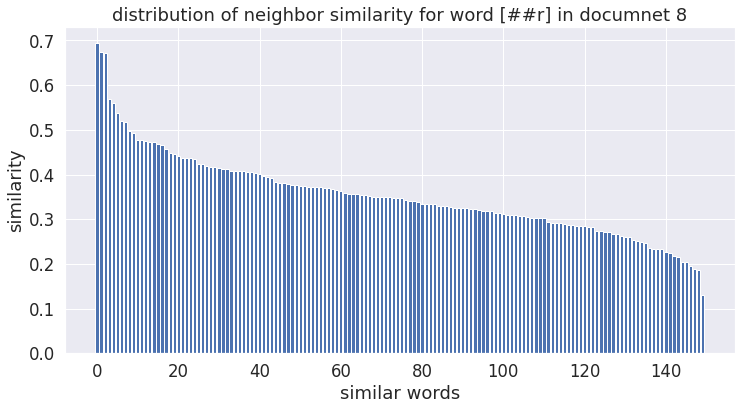

226   -->  ##vor
1690
[0.77203435, 0.7402526, 0.69234246, 0.67191017, 0.6669545, 0.6467446, 0.5172205, 0.5062561, 0.48542422, 0.48266974, 0.47279006, 0.47205776, 0.47013745, 0.45977616, 0.44734478, 0.44654542, 0.4454369, 0.44505346, 0.44478202, 0.44337568, 0.4431766, 0.44315067, 0.43588388, 0.43132758, 0.4287018, 0.42572466, 0.4246645, 0.42405123, 0.4231307, 0.4179263, 0.4175155, 0.41671553, 0.41383514, 0.41334718, 0.41062725, 0.4101109, 0.4096125, 0.40153617, 0.40073133, 0.3998356, 0.39854544, 0.39827445, 0.39621574, 0.3946128, 0.39410752, 0.39401287, 0.39371917, 0.39238173, 0.391568, 0.39127234, 0.38947868, 0.388481, 0.38825983, 0.3878663, 0.38348892, 0.38334966, 0.38289922, 0.38262776, 0.38076496, 0.3803121, 0.3798468, 0.3781199, 0.37404412, 0.3728451, 0.37190264, 0.37115526, 0.37075868, 0.3707317, 0.36880726, 0.36847454, 0.36845005, 0.36792108, 0.36710387, 0.36469787, 0.36459485, 0.36423594, 0.36283472, 0.36249077, 0.36194682, 0.3556846, 0.35424742, 0.35322428, 0.35317466, 0.352694

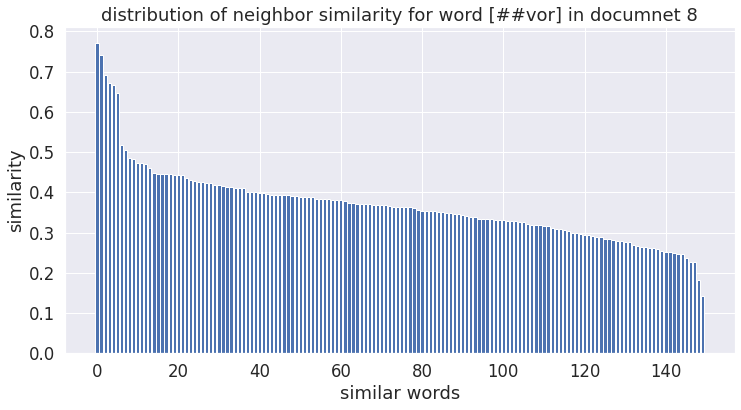

229   -->  land
1690
[0.9307821, 0.75790304, 0.7463714, 0.6724074, 0.6405419, 0.63810223, 0.6270315, 0.6143259, 0.6131091, 0.6087332, 0.58713925, 0.5691583, 0.5618999, 0.56024504, 0.5563729, 0.5055735, 0.50218225, 0.50168717, 0.4945153, 0.48853093, 0.48262045, 0.47313762, 0.47205776, 0.468357, 0.46441638, 0.4642615, 0.4603582, 0.45995954, 0.45904535, 0.45736066, 0.45442426, 0.44852698, 0.44693956, 0.44630918, 0.4460934, 0.44364834, 0.4416129, 0.43458658, 0.43269444, 0.4325928, 0.4296899, 0.42917162, 0.42886716, 0.42800948, 0.42793533, 0.42711884, 0.42680115, 0.42026973, 0.4201945, 0.41967294, 0.41766867, 0.41665345, 0.41186368, 0.40786028, 0.39974952, 0.39965037, 0.3973518, 0.39726532, 0.395954, 0.39556295, 0.39482528, 0.39313015, 0.3927678, 0.3924688, 0.390332, 0.3889408, 0.38874498, 0.38822472, 0.38730642, 0.38640803, 0.38620734, 0.38466132, 0.3830217, 0.3807463, 0.3783346, 0.37744004, 0.37676775, 0.374187, 0.3728503, 0.372618, 0.37198988, 0.36998287, 0.36930197, 0.3688987, 0.3677714

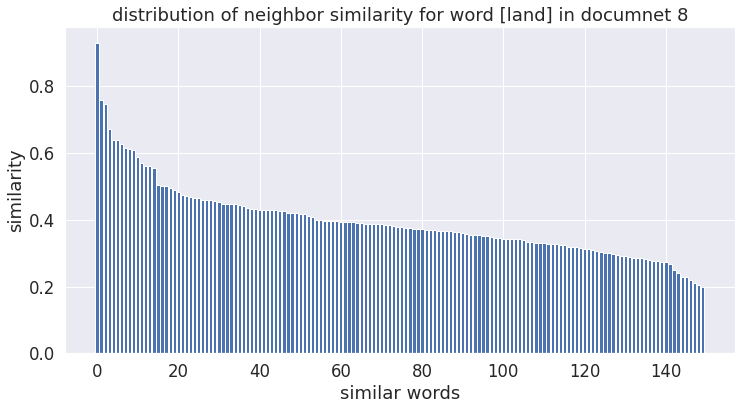

231   -->  used
1690
[0.8063177, 0.7842627, 0.76613975, 0.75407606, 0.7115238, 0.66756475, 0.63598347, 0.6131091, 0.5553242, 0.5532601, 0.54892576, 0.5359308, 0.5222119, 0.515704, 0.50689363, 0.5015057, 0.50133413, 0.49487403, 0.4825146, 0.4809572, 0.47767848, 0.4757707, 0.47392562, 0.4712564, 0.47103766, 0.46809748, 0.46175313, 0.4588021, 0.4581202, 0.45768106, 0.4532741, 0.45246512, 0.44931558, 0.4493151, 0.4480245, 0.44505942, 0.4417032, 0.43407276, 0.42787233, 0.4262039, 0.42420983, 0.4231307, 0.42221332, 0.4179935, 0.41753238, 0.4168122, 0.4167605, 0.41512632, 0.41012463, 0.40754038, 0.40692762, 0.40541327, 0.40251663, 0.3993918, 0.39905238, 0.3984086, 0.3970096, 0.39562824, 0.39488092, 0.39272267, 0.3906433, 0.3906257, 0.38847893, 0.3877678, 0.38613218, 0.38410234, 0.38002068, 0.37849298, 0.37825352, 0.3770428, 0.37601674, 0.37455714, 0.37282413, 0.37124932, 0.37124175, 0.37090135, 0.3701615, 0.36747202, 0.36550292, 0.36348373, 0.36256686, 0.3624578, 0.3618154, 0.36027902, 0.3569

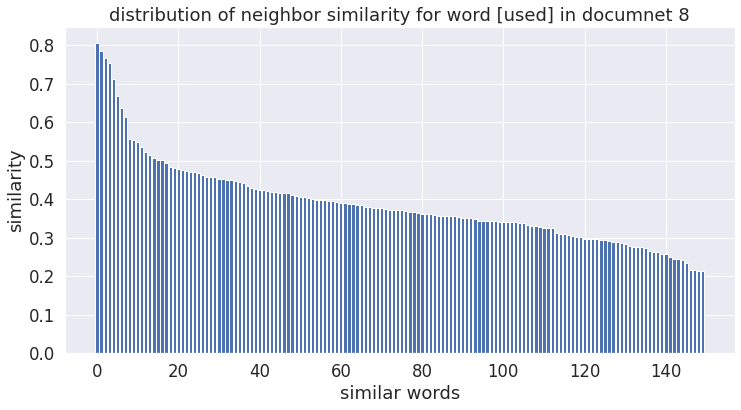

234   -->  new
1690
[0.8515885, 0.80070424, 0.78722394, 0.75407606, 0.6925216, 0.689742, 0.6798329, 0.67697144, 0.670871, 0.6467191, 0.6405419, 0.6270765, 0.5951668, 0.59252596, 0.59221506, 0.582945, 0.5768617, 0.56110775, 0.5466787, 0.546543, 0.54580146, 0.54058826, 0.5389031, 0.53793937, 0.52913964, 0.5276087, 0.52710205, 0.5253811, 0.52511704, 0.521299, 0.5117825, 0.5096678, 0.50807965, 0.50673866, 0.5058124, 0.505742, 0.49780512, 0.4945997, 0.4838517, 0.48191482, 0.47369072, 0.46485603, 0.45751378, 0.45588714, 0.4509086, 0.44949383, 0.44654542, 0.44460613, 0.44440734, 0.44432217, 0.43990305, 0.43900856, 0.43879265, 0.4381623, 0.43208152, 0.43172926, 0.43159604, 0.43114334, 0.4269293, 0.4261846, 0.42604575, 0.4258541, 0.42398536, 0.42319387, 0.42280504, 0.4199557, 0.41843212, 0.41775897, 0.41426724, 0.41357118, 0.41118065, 0.41009873, 0.40838414, 0.40826285, 0.40807712, 0.4071378, 0.40710217, 0.40605438, 0.4057434, 0.4053499, 0.40514335, 0.40041223, 0.39900407, 0.39873323, 0.3986819

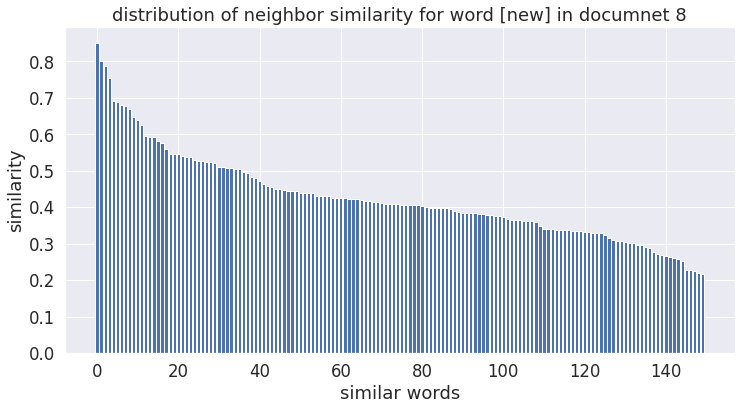

235   -->  freedoms
1690
[0.8515885, 0.7564969, 0.7463112, 0.7160405, 0.69887197, 0.6838665, 0.66756475, 0.66620183, 0.6501382, 0.6270315, 0.61092836, 0.60938644, 0.59694266, 0.58451384, 0.58298254, 0.56402, 0.55436575, 0.55146945, 0.5496152, 0.5487884, 0.53770065, 0.52963114, 0.5295063, 0.52196556, 0.51960784, 0.51840734, 0.5105456, 0.50065804, 0.49628457, 0.49555093, 0.49492532, 0.4905717, 0.48330182, 0.48163477, 0.48160696, 0.47829092, 0.4667495, 0.4637538, 0.46003008, 0.45770994, 0.4547547, 0.4477382, 0.44505158, 0.4445092, 0.44135258, 0.42908585, 0.4272984, 0.42163265, 0.42027238, 0.41976255, 0.41773802, 0.4165644, 0.41485256, 0.41312307, 0.40771532, 0.40693456, 0.4033323, 0.40326375, 0.40104645, 0.39988863, 0.39806253, 0.3972426, 0.39462724, 0.39401287, 0.38909504, 0.38569236, 0.38554558, 0.38472587, 0.37863296, 0.378237, 0.3775727, 0.3762192, 0.37462002, 0.3733776, 0.37319493, 0.36611295, 0.3659629, 0.35855108, 0.3565234, 0.35647446, 0.3556592, 0.3539272, 0.3486366, 0.3473035, 0

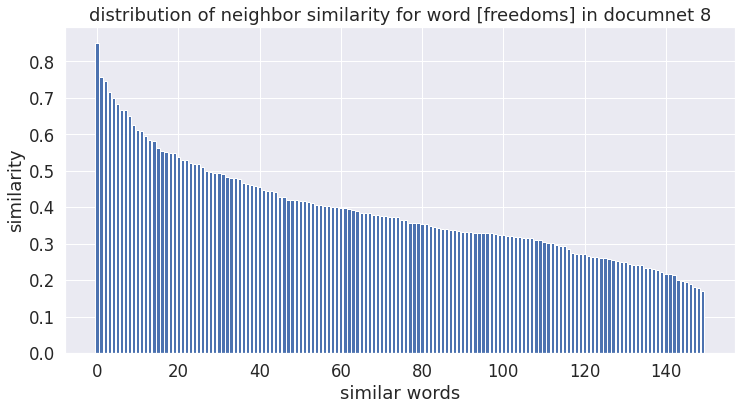

237   -->  24
1690
[0.8038383, 0.786628, 0.67533743, 0.6752153, 0.6197767, 0.59252596, 0.5786052, 0.5618999, 0.55633754, 0.54551774, 0.52963114, 0.529257, 0.50689363, 0.50313056, 0.49845463, 0.49779144, 0.49579978, 0.49410018, 0.48977688, 0.4770928, 0.46730524, 0.46402836, 0.4540794, 0.44926894, 0.4428599, 0.4397589, 0.43490252, 0.43138874, 0.43069756, 0.42911693, 0.42866814, 0.4219206, 0.42185125, 0.42003167, 0.41768742, 0.41415226, 0.41284433, 0.41107547, 0.40798262, 0.40212184, 0.40039045, 0.4003352, 0.40003538, 0.3994948, 0.39753702, 0.3877216, 0.38752127, 0.3872496, 0.3838146, 0.37874636, 0.3757276, 0.370617, 0.36535317, 0.3628277, 0.36221254, 0.36083853, 0.36018413, 0.35921276, 0.35915893, 0.35821134, 0.3553521, 0.3532675, 0.35212067, 0.35195354, 0.35026383, 0.35006046, 0.34613758, 0.34576768, 0.34108898, 0.34035087, 0.3397801, 0.3381976, 0.33668318, 0.33576366, 0.33406729, 0.3332476, 0.33301055, 0.33183643, 0.3314703, 0.3282272, 0.3279583, 0.327694, 0.32619494, 0.32619214, 0.326

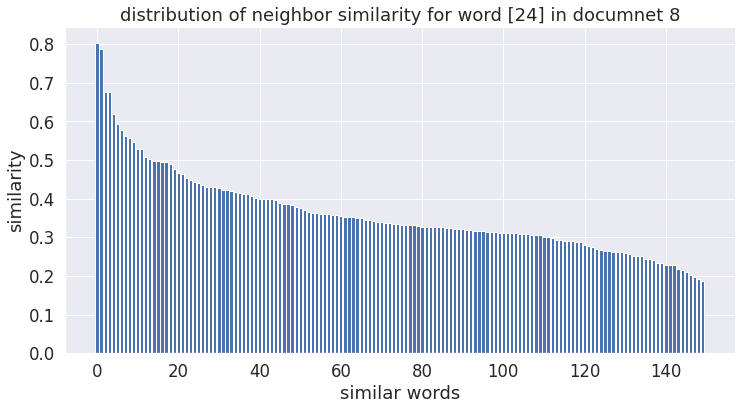

238   -->  years
1690
[0.8038383, 0.7862271, 0.7850841, 0.7308725, 0.6687197, 0.60220355, 0.5951668, 0.56697595, 0.56402, 0.56024504, 0.5556363, 0.521543, 0.515704, 0.5149661, 0.51428246, 0.51179314, 0.51085603, 0.50830394, 0.50670105, 0.49936393, 0.49856436, 0.49483174, 0.49376664, 0.49374133, 0.49112806, 0.47737002, 0.47194028, 0.47134197, 0.4697548, 0.46686986, 0.46681705, 0.46345097, 0.463351, 0.45942822, 0.45822948, 0.45734286, 0.4541151, 0.44889805, 0.44455332, 0.44228685, 0.43805033, 0.43469477, 0.43404236, 0.4307586, 0.42986044, 0.4259507, 0.42203316, 0.42086828, 0.411384, 0.40857157, 0.4083584, 0.40604496, 0.4056028, 0.40508145, 0.40466622, 0.404381, 0.40181023, 0.39887488, 0.3972957, 0.39717346, 0.3970425, 0.39311728, 0.3906262, 0.39030358, 0.3881327, 0.38779446, 0.38664275, 0.38577664, 0.38576925, 0.38329864, 0.38320398, 0.38160688, 0.3812597, 0.3806944, 0.378483, 0.37816405, 0.37651294, 0.3739337, 0.3727215, 0.37174356, 0.37142625, 0.37047055, 0.37027428, 0.36988527, 0.3683

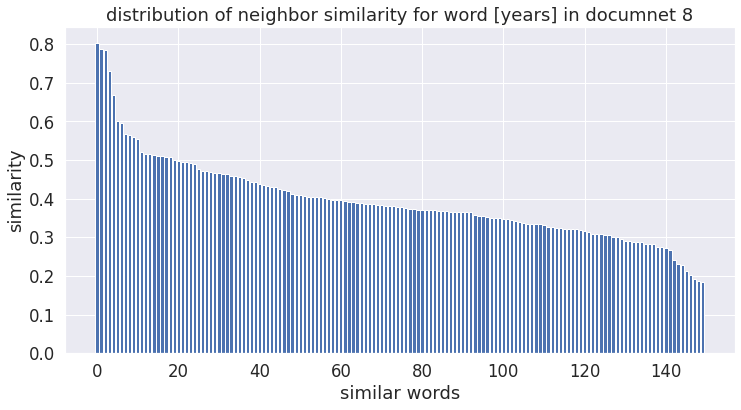

240   -->  dictatorship
1690
[0.7850841, 0.6752153, 0.6408736, 0.61177456, 0.61092836, 0.6087332, 0.60749173, 0.59221506, 0.5797478, 0.56209743, 0.5563503, 0.54568994, 0.5298246, 0.5230504, 0.51317936, 0.50864863, 0.5075373, 0.50737154, 0.506389, 0.5051375, 0.49789095, 0.48424086, 0.48109424, 0.48003808, 0.4777427, 0.47767848, 0.47622734, 0.47409868, 0.4724364, 0.46127826, 0.4525914, 0.4483217, 0.44599628, 0.44071418, 0.44054037, 0.43952632, 0.43916655, 0.43628347, 0.43536663, 0.43517417, 0.43317574, 0.427329, 0.42630535, 0.42557907, 0.4246271, 0.42344064, 0.4227274, 0.41956788, 0.4135772, 0.4078768, 0.40759307, 0.40741017, 0.4034094, 0.40073133, 0.4002259, 0.39921385, 0.39889142, 0.39819366, 0.39666665, 0.39242557, 0.39219147, 0.39205444, 0.39180636, 0.38895684, 0.3888537, 0.38877916, 0.3868861, 0.38315052, 0.3824334, 0.38030714, 0.3790928, 0.37766516, 0.37722075, 0.37376034, 0.37130636, 0.37102485, 0.37019587, 0.36889133, 0.3679071, 0.3640791, 0.36321253, 0.36281952, 0.36043352, 0.36

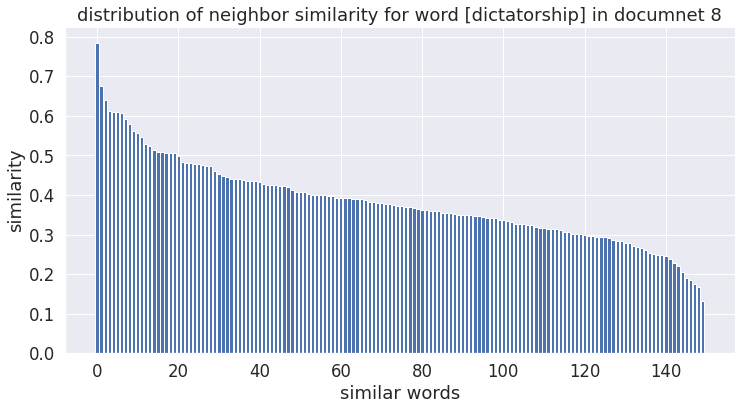

243   -->  country
1690
[0.9307821, 0.7579465, 0.6514164, 0.63105404, 0.57005095, 0.56209743, 0.54768085, 0.530321, 0.5295063, 0.5253811, 0.5015057, 0.49322987, 0.49112806, 0.48977688, 0.47582927, 0.46586204, 0.46102068, 0.45435524, 0.442307, 0.44227102, 0.43588388, 0.4305111, 0.42150134, 0.4180742, 0.41649717, 0.41524023, 0.4147753, 0.41092247, 0.40963602, 0.4072882, 0.40644306, 0.40392104, 0.40057325, 0.39818722, 0.39727807, 0.39559692, 0.39257067, 0.39254022, 0.39185917, 0.3880246, 0.3878479, 0.3876614, 0.38568485, 0.3799007, 0.37760407, 0.37656498, 0.37512392, 0.37380317, 0.37365603, 0.3722689, 0.36958838, 0.3673424, 0.36675262, 0.36583334, 0.36265177, 0.36231595, 0.36130697, 0.3588597, 0.3585815, 0.35827243, 0.35815215, 0.35766107, 0.3568936, 0.3566426, 0.35484433, 0.3544668, 0.3544088, 0.35395566, 0.35293508, 0.34923145, 0.34808376, 0.34693986, 0.34583056, 0.34374225, 0.34360227, 0.34220967, 0.34021854, 0.33967674, 0.33838707, 0.33632588, 0.3349638, 0.33333892, 0.33261943, 0.3319

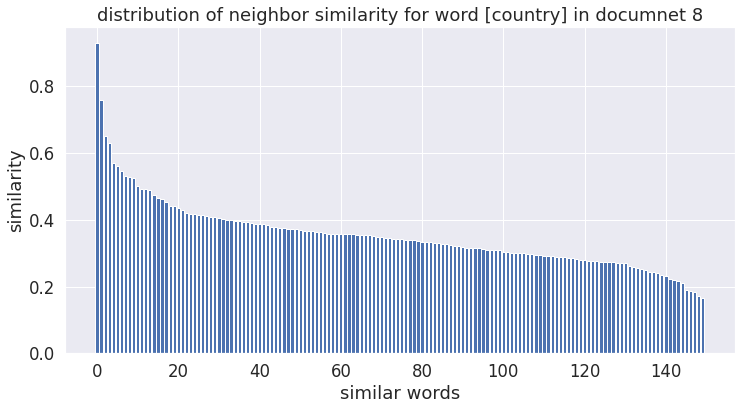

244   -->  wary
1690
[0.74445045, 0.7115238, 0.6980297, 0.69128233, 0.6867138, 0.686272, 0.67697144, 0.6501382, 0.64145446, 0.63673747, 0.6365118, 0.6143259, 0.6028595, 0.57005095, 0.56231683, 0.5594628, 0.51790535, 0.5072284, 0.5005553, 0.49845463, 0.4857262, 0.4794532, 0.47448745, 0.47083834, 0.46602345, 0.45822948, 0.454354, 0.45272592, 0.45064208, 0.4483217, 0.44422987, 0.43615672, 0.42618942, 0.4249697, 0.42425668, 0.42161304, 0.42092276, 0.42037916, 0.41974783, 0.4196146, 0.4175155, 0.41446033, 0.41387886, 0.4135386, 0.4111011, 0.4109268, 0.4100215, 0.40704474, 0.40381682, 0.40234503, 0.4019305, 0.39501423, 0.39133403, 0.39093316, 0.38772982, 0.3861556, 0.38152033, 0.38064206, 0.3789795, 0.3775681, 0.3761133, 0.3717362, 0.3685171, 0.36839247, 0.36478734, 0.363964, 0.36341688, 0.36138964, 0.35849047, 0.35645935, 0.3541456, 0.3537449, 0.35260314, 0.35174084, 0.34988314, 0.3496801, 0.34886754, 0.34722558, 0.34690696, 0.34628522, 0.34628287, 0.3462695, 0.34495842, 0.3441387, 0.343952

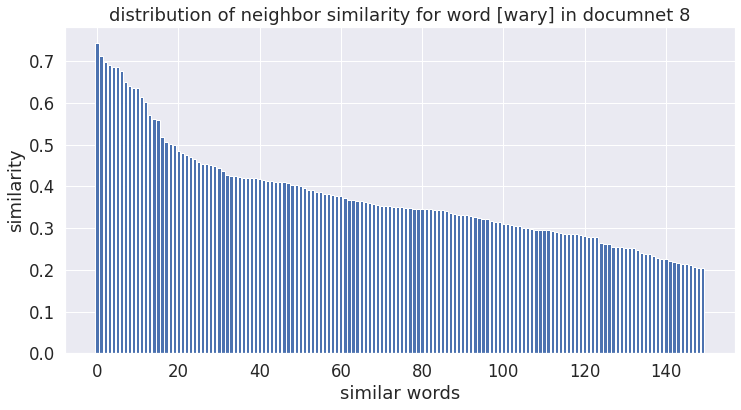

247   -->  old
1690
[0.8712287, 0.85651475, 0.85394514, 0.79539335, 0.69887197, 0.6798329, 0.63673747, 0.63419396, 0.6332256, 0.6155772, 0.6021455, 0.56007516, 0.5534862, 0.551199, 0.5498835, 0.5443351, 0.54132986, 0.5403352, 0.5359308, 0.5348116, 0.5339255, 0.532525, 0.5281321, 0.5264223, 0.52464724, 0.5230504, 0.51650715, 0.51179314, 0.5038587, 0.48977637, 0.48853093, 0.47201973, 0.46827537, 0.4540794, 0.4503078, 0.44613418, 0.4457944, 0.44512647, 0.4429303, 0.44138944, 0.43764013, 0.43629986, 0.43508887, 0.43367633, 0.43313047, 0.4295661, 0.42748457, 0.4179665, 0.41709507, 0.41565764, 0.41485125, 0.4114796, 0.41092247, 0.40371644, 0.40276092, 0.3977077, 0.39542696, 0.39127755, 0.3891452, 0.38095215, 0.37347624, 0.3731711, 0.3724133, 0.36981097, 0.36834294, 0.36249077, 0.36248976, 0.36117297, 0.36071172, 0.36035863, 0.3568224, 0.35484922, 0.34881553, 0.34871012, 0.34596398, 0.34160578, 0.34142795, 0.34062505, 0.33966148, 0.3383318, 0.33421308, 0.33281547, 0.3314674, 0.32989866, 0.328

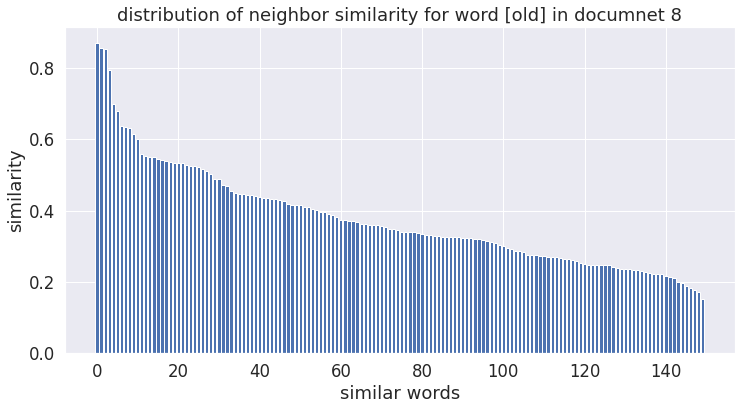

248   -->  guard
1690
[0.8712287, 0.8516742, 0.8452106, 0.7819368, 0.7463112, 0.6980297, 0.670871, 0.6466694, 0.6080642, 0.60732585, 0.5846065, 0.5774119, 0.57468724, 0.55691457, 0.5533718, 0.5533042, 0.54892576, 0.5315521, 0.5298246, 0.5290944, 0.5290889, 0.523789, 0.52375484, 0.51684225, 0.5141928, 0.5055735, 0.49950385, 0.49483174, 0.4933898, 0.48989347, 0.48953015, 0.48162264, 0.47604394, 0.47336462, 0.47065923, 0.46730524, 0.46259147, 0.45176506, 0.44984138, 0.4305111, 0.43038532, 0.43010455, 0.42968, 0.4282732, 0.42699394, 0.4267147, 0.42474425, 0.41986823, 0.41138864, 0.4100435, 0.40482384, 0.40223718, 0.39817566, 0.39611012, 0.39300853, 0.3918094, 0.3912323, 0.39100385, 0.3901303, 0.3877421, 0.38688052, 0.3803239, 0.3655846, 0.36444336, 0.3610614, 0.35911307, 0.35728785, 0.35537997, 0.3517312, 0.35118368, 0.3486975, 0.3483762, 0.3480712, 0.34362578, 0.34099272, 0.34089774, 0.3396429, 0.3391817, 0.33766264, 0.33721226, 0.3330227, 0.33131886, 0.3312907, 0.33092886, 0.32718104, 0.

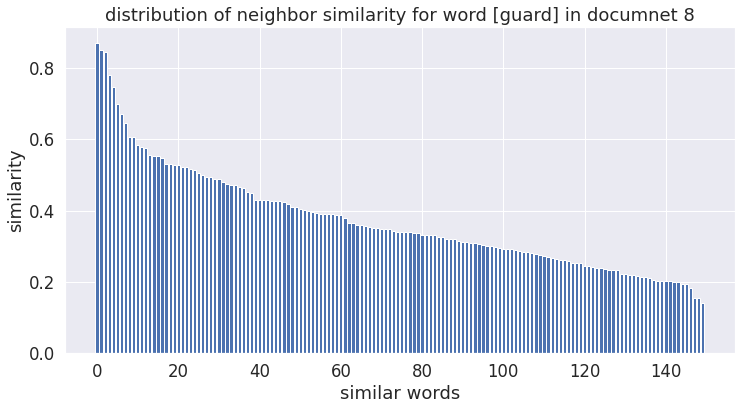

250   -->  flourished
1690
[0.85394514, 0.8452106, 0.79835224, 0.79335856, 0.6838665, 0.65807176, 0.6467191, 0.6365118, 0.63405657, 0.5983063, 0.576542, 0.55843043, 0.5532601, 0.54156005, 0.5334493, 0.53276026, 0.5290675, 0.5290241, 0.52773654, 0.52598304, 0.5259745, 0.521543, 0.5211801, 0.51868725, 0.5075373, 0.5045937, 0.5021158, 0.49571097, 0.4945153, 0.49030694, 0.4832801, 0.48016715, 0.4770928, 0.47535372, 0.47085685, 0.46480054, 0.45799905, 0.4494213, 0.44444656, 0.44404292, 0.43986756, 0.43853077, 0.43646824, 0.43538776, 0.43396586, 0.43331927, 0.42639768, 0.42264724, 0.42198685, 0.41839793, 0.4147753, 0.41446292, 0.41051453, 0.40830356, 0.40545136, 0.39168015, 0.39127234, 0.3873335, 0.3821631, 0.37923676, 0.37672222, 0.3766459, 0.3760384, 0.37450433, 0.3739789, 0.37017858, 0.36947012, 0.3674842, 0.36683688, 0.3660186, 0.3629101, 0.3617847, 0.36119473, 0.36084986, 0.35852844, 0.35799143, 0.35708588, 0.35525677, 0.35517317, 0.35404128, 0.35374847, 0.35084635, 0.34925246, 0.346121

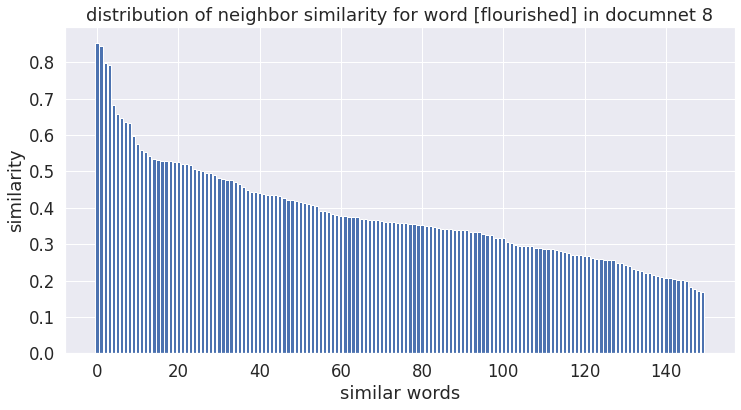

252   -->  mr
1690
[0.73612595, 0.7057877, 0.6999611, 0.6496098, 0.60749173, 0.60220355, 0.55633754, 0.524389, 0.517758, 0.5174767, 0.5041306, 0.5036286, 0.50218225, 0.49874473, 0.4953188, 0.4945997, 0.49038815, 0.48662418, 0.48374474, 0.47867575, 0.4772155, 0.47557157, 0.4732929, 0.4667495, 0.4664092, 0.4649934, 0.46102068, 0.46054077, 0.46049803, 0.46038347, 0.46002737, 0.45824426, 0.4581202, 0.45710263, 0.4560283, 0.4552514, 0.45359135, 0.45346844, 0.4524458, 0.45080787, 0.45038378, 0.4503078, 0.44984138, 0.4488385, 0.44879314, 0.44590127, 0.44589052, 0.44096804, 0.43776357, 0.4369433, 0.43667, 0.43538776, 0.4342543, 0.43157375, 0.43112803, 0.43034607, 0.43008873, 0.42705876, 0.42624307, 0.42540866, 0.42045665, 0.41790074, 0.41529614, 0.41512775, 0.4135386, 0.41347688, 0.40198958, 0.4015676, 0.40114695, 0.3994884, 0.39907724, 0.39739704, 0.3952368, 0.39410752, 0.39385343, 0.39283308, 0.39254284, 0.3899163, 0.3853764, 0.38508093, 0.3850107, 0.38228226, 0.3810413, 0.37823355, 0.377088

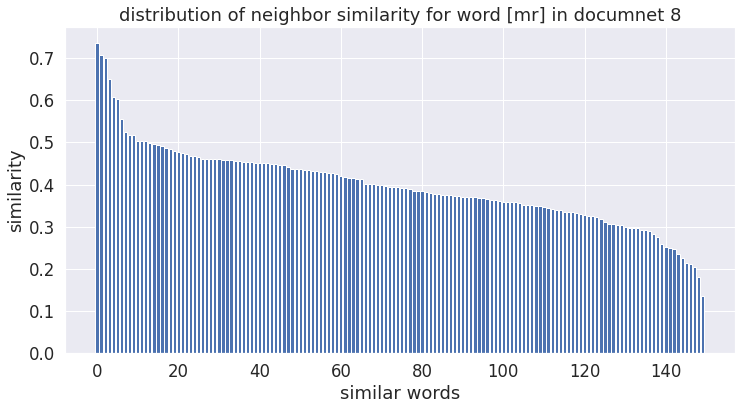

254   -->  ce
1690
[0.7887801, 0.73612595, 0.66720665, 0.58019423, 0.5607411, 0.54799867, 0.54318166, 0.54199404, 0.51317936, 0.50538146, 0.49936393, 0.49579978, 0.4871254, 0.47390288, 0.47151852, 0.46621868, 0.46240604, 0.4610281, 0.45821747, 0.45386973, 0.4511833, 0.45039302, 0.44689602, 0.44621748, 0.44236386, 0.43585166, 0.43555143, 0.43297294, 0.4316076, 0.43114334, 0.42849088, 0.4259495, 0.42150134, 0.42124704, 0.42073655, 0.4205557, 0.42020887, 0.4201945, 0.41984874, 0.4169697, 0.41311556, 0.41292635, 0.40790612, 0.40262622, 0.40135872, 0.3946128, 0.39274, 0.39101386, 0.38909504, 0.38868847, 0.38774455, 0.386912, 0.38681296, 0.386133, 0.38444966, 0.3844185, 0.3813321, 0.38058707, 0.3801018, 0.37858695, 0.37842014, 0.37501535, 0.3746342, 0.37432668, 0.37347624, 0.37328166, 0.3718928, 0.37186426, 0.37123516, 0.37022734, 0.3655846, 0.36440557, 0.36426884, 0.36359912, 0.3634047, 0.3618154, 0.36002374, 0.357207, 0.35645935, 0.35480154, 0.35209453, 0.35016817, 0.350098, 0.3490404, 0.3

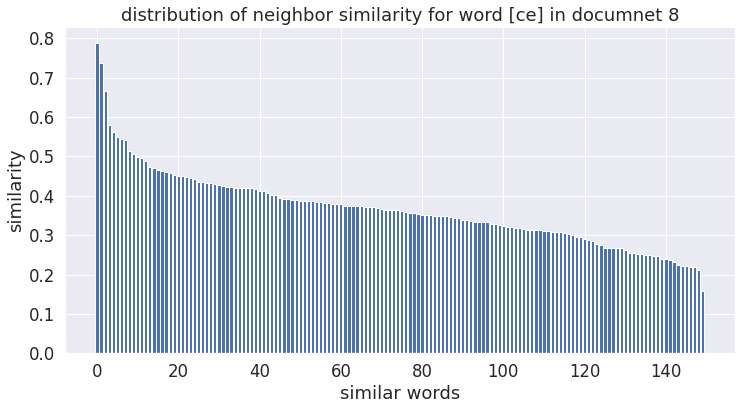

255   -->  ##aus
1690
[0.7887801, 0.6496098, 0.61455154, 0.56301105, 0.55609405, 0.51925194, 0.51428246, 0.50864863, 0.50313056, 0.4983725, 0.4804457, 0.4775495, 0.46171194, 0.45129478, 0.4495671, 0.4483037, 0.4474249, 0.4460934, 0.442307, 0.43721658, 0.4364457, 0.4357829, 0.43452287, 0.4245059, 0.4223359, 0.41859704, 0.4165656, 0.41109937, 0.41036814, 0.40938908, 0.40889803, 0.40703282, 0.40693456, 0.4058173, 0.4057434, 0.4055044, 0.40331215, 0.4019305, 0.40160125, 0.39801943, 0.39555925, 0.39499056, 0.39300853, 0.39127755, 0.38972396, 0.38920575, 0.38904965, 0.38880408, 0.38736546, 0.383256, 0.38289922, 0.3794762, 0.37943205, 0.3719768, 0.37161076, 0.37152508, 0.3679728, 0.3668052, 0.36506432, 0.363375, 0.36331135, 0.3626917, 0.36250848, 0.36142346, 0.36082125, 0.35808182, 0.35330456, 0.35134915, 0.35074383, 0.3501182, 0.34090704, 0.3387959, 0.33828115, 0.33808306, 0.33626175, 0.33565867, 0.33167303, 0.32827216, 0.32608765, 0.325844, 0.32352388, 0.32278228, 0.32184058, 0.31858003, 0.

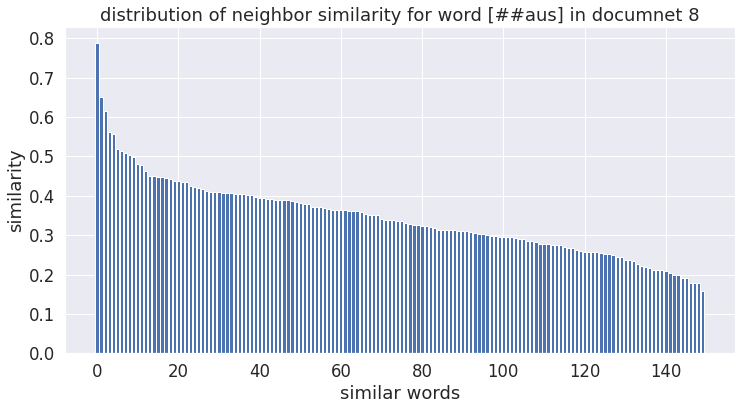



['confronted', 'by', 'growing', 'demands', 'that', 'the', 'communist', 'party', 'dissolve', 'itself', ',', 'top', 'officials', 'of', 'this', 'country', "'", 's', 'old', 'order', 'say', 'they', 'will', 'call', 'a', 'special', 'congress', 'to', 'di', '##sman', '##tle', 'the', 'disgrace', '##d', 'party', 'even', 'before', 'free', 'elections', 'are', 'held', 'in', 'april', '.', 'late', 'saturday', 'night', ',', 'a', 'group', 'of', 'party', 'officials', ',', 'many', 'of', 'whom', 'quickly', 'severed', 'their', 'relationship', 'with', 'the', 'ce', '##aus', '##escu', 'dictatorship', 'as', 'a', 'popular', 'uprising', 'swept', 'it', 'out', 'of', 'power', ',', 'went', 'on', 'the', 'national', 'television', 'to', 'announce', 'the', 'special', 'congress', '.', 'their', 'message', 'was', 'repeated', 'today', 'in', 'the', 'rum', '##anian', 'newspapers', ',', 'which', 'like', 'the', 'television', 'are', 'now', 'controlled', 'by', 'the', 'country', "'", 's', 'new', ',', 'non', '-', 'communist', 'lea

In [25]:

#temporary ignore removing stopwords. 
# stopwords = [] # by removing this line, stopwords will be removed from the documents
print(tokenizer.tokenize(sentences[doc_num]))
print('tokens in  doc {} are {}'.format(doc_num, tokenizer.tokenize(sentences[doc_num])))
total_tokens = tokenizer.tokenize(sentences[doc_num])[0:min(max_length, len(sentences[doc_num]))]
print('size of the document before removing stopwords is ', len(total_tokens))
word_neighbor_similarity_dict = dict()
for ind, word in zip(total_tokens, range(1,len(total_tokens))):
  if ind not in stopwords and ind not in string.punctuation:
    plt.figure(word)
    print(word, '  --> ', ind)
    
    value_list = list()
    temp = sorted(find_similar(last_layer[doc_num], word,  tokenizer.tokenize(sentences[doc_num])).items(), key=lambda kv: kv[1], reverse=True)
    for d in temp:
      value_list.append(d[1])
      ## plot data
    #remove the actual word from the similarity
    value_list = value_list[1:]
    print(value_list)
    word_neighbor_similarity_dict[ind] = value_list
    print('variance is {}'.format(np.var(value_list)))
    print('Average is {}'.format(np.average(value_list)))
    plt.bar(range(0, len(value_list)), value_list)
    plt.xlabel('similar words')
    plt.ylabel('similarity')
    plt.title('distribution of neighbor similarity for word [{}] in documnet {}'.format(ind, doc_num))
    plt.show()
    # plt.savefig('/content/Images/'+ind+'.png')
print()
print()

print('total tokens before removing stopwords: {}'.format(total_tokens))
print('total tokens after removing stopwords: {}'.format(word_neighbor_similarity_dict.keys()))

In [27]:
##Calculate the gradient descent of the similarity distribution
# print(word_neighbor_similarity_dict)
gradient_word_similarity_dict = dict()
total_size = len(word_neighbor_similarity_dict['top']) # top is an example of tokens in the dictionary to find the length of each vector
print(total_size-total_size%10)
length =np.arange(0, total_size)

for word in word_neighbor_similarity_dict:
  # print(word_neighbor_similarity_dict[word])
  # print(length)
  # new_list = [word_neighbor_similarity_dict[word][x:x+jump] for x in range(0, len(word_neighbor_similarity_dict['top']), jump)]
  new_list = [word_neighbor_similarity_dict[word][x:x+jump] for x in range(0, total_size-total_size%jump, jump)]
  tm_list = list()
  for vec in new_list:
    m1, b1 = np.polyfit(np.arange(0, len(vec)), vec, 1)
    tm_list.append(m1)
  gradient_word_similarity_dict[word] = tm_list
for ele in gradient_word_similarity_dict.items():
  print(ele)
#convert dict to a numpy array

150
('confronted', [-0.05294421315193168, -0.018412470817565873, -0.006793916225433271, -0.0010511279106138797, -0.0032909214496611694, -0.0074798166751860184, -0.008190751075744584, -0.01189418137073518, -0.0023479461669921897, -0.004676461219787552, -0.0009538829326629001, -0.0035008043050765492, -0.0008924156427382689, -0.0018998533487319775, -0.0027124583721160104, -0.00451846420764918, -0.007208570837974546, -0.0027035027742385543, -0.00185573101043694, -0.0030016601085662534, -0.0014858394861221112, -0.0018663555383682088, -0.0024046599864959765, -0.0015986859798431258, -0.0011312812566756426, -0.0014434158802031785, -0.003289788961410483, -0.0006378591060637633, -0.001558348536491342, -0.0034514069557189287, -0.0013989210128784106, -0.0005678534507751325, -0.0017290413379668957, -0.0025099962949752344, -0.00380937755107875, -0.003041490912437435, -0.0054065287113189845, -0.0033962279558181485, -0.00403592735528942, -0.002961777150630893, -0.002027250826358765, -0.002505131065845

[[-0.05294421 -0.01841247 -0.00679392 ... -0.0027035  -0.00185573
  -0.00300166]
 [-0.08656788 -0.02766803 -0.00552523 ... -0.00195263 -0.0004676
  -0.00124376]
 [-0.0853765  -0.01371786 -0.00356829 ... -0.00403909 -0.00050637
  -0.01058803]
 ...
 [-0.01300904 -0.04195356 -0.03140342 ... -0.00306353 -0.00088811
  -0.00163087]
 [-0.02779645 -0.0676434  -0.00633126 ... -0.00307968 -0.00708951
  -0.00404838]
 [-0.01808241 -0.02370313 -0.01928976 ... -0.00190701 -0.00051965
  -0.00082505]]
[[0.29291202 0.423973   0.47175806 ... 0.48875161 0.49227822 0.48751157]
 [0.28065291 0.42535563 0.48498599 ... 0.49469261 0.49872899 0.49661931]
 [0.27513467 0.46116592 0.48987947 ... 0.4885446  0.49856362 0.47000176]
 ...
 [0.44582602 0.33146015 0.37164676 ... 0.48719497 0.49628711 0.49318216]
 [0.41205931 0.2962919  0.47977012 ... 0.49015559 0.47735049 0.48706031]
 [0.38095942 0.34606452 0.37334504 ... 0.48720293 0.49651217 0.49446249]]
list of cluster words are: 
cluster 0 is ['top', 'officials', 'ol

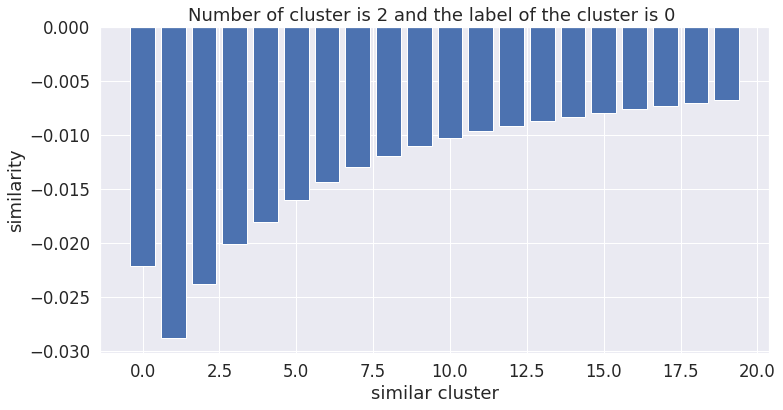

tmp_list shape is  (67, 20)  and the lenght is 20
Number of cluster is 1 and the label of the cluster is 1 


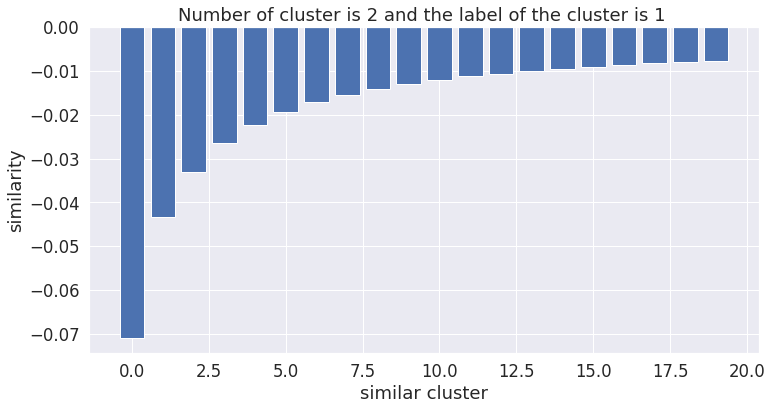

For n_clusters = 2 The average silhouette_score is : 0.39519584351756376
list of cluster words are: 
cluster 0 is ['top', 'call', 'group', 'many', 'went', 'appear', 'vest', 'among', 'students', 'streets', 'long', 'suppressed', 'intellectuals', 'wary']
cluster 1 is ['officials', 'old', 'elections', 'held', 'severed', '##escu', 'popular', 'uprising', 'swept', 'power', 'national', 'message', 'like', 'new', 'since', 'president', '##e', 'open', 'swirl', 'revolutionary', '##r', 'erase', 'artists', 'used', 'years', 'guard', 'flourished', 'mr']
cluster 2 is ['confronted', 'growing', 'demands', 'communist', 'party', 'dissolve', 'country', 'order', 'say', 'special', 'congress', 'di', '##sman', '##tle', 'disgrace', '##d', 'even', 'free', 'april', 'late', 'saturday', 'night', 'quickly', 'relationship', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'repeated', 'today', 'rum', '##anian', 'newspapers', 'controlled', 'non', 'leaders', 'leading', 'figures', 'detained', 'nicola', 'overthrow',

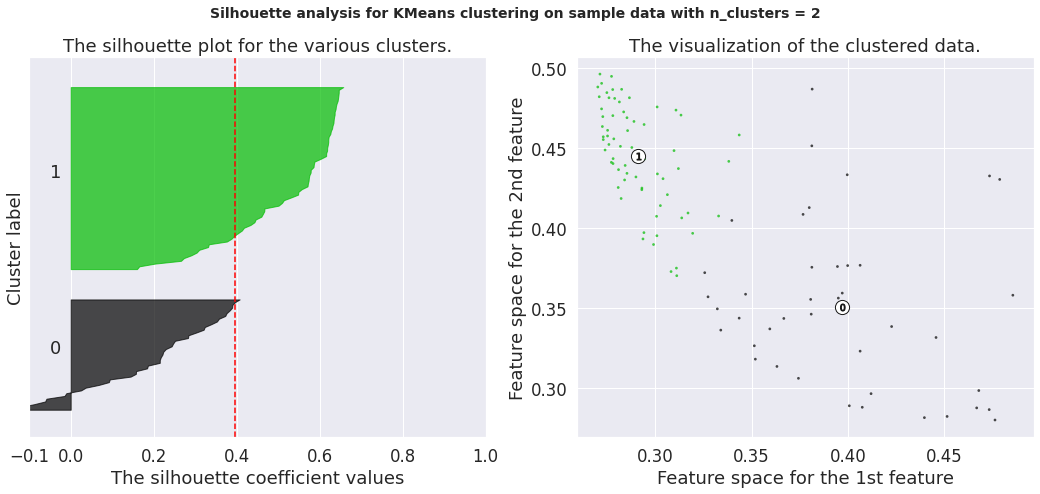

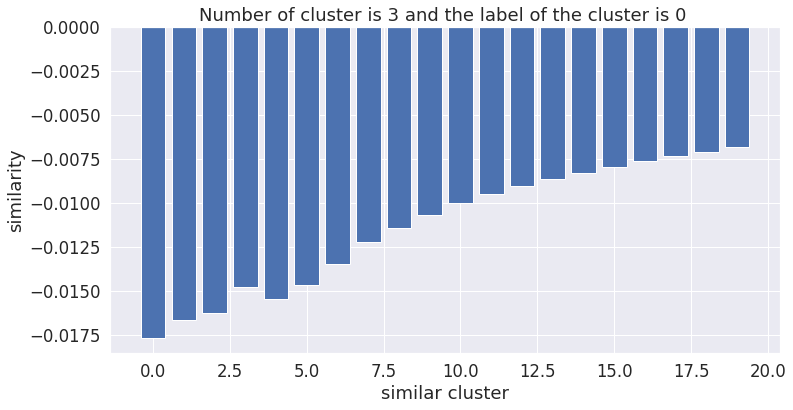

tmp_list shape is  (28, 20)  and the lenght is 20
Number of cluster is 2 and the label of the cluster is 1 


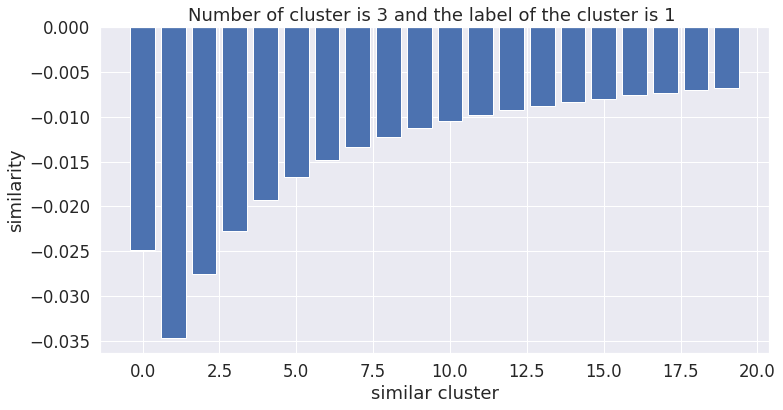

tmp_list shape is  (66, 20)  and the lenght is 20
Number of cluster is 2 and the label of the cluster is 2 


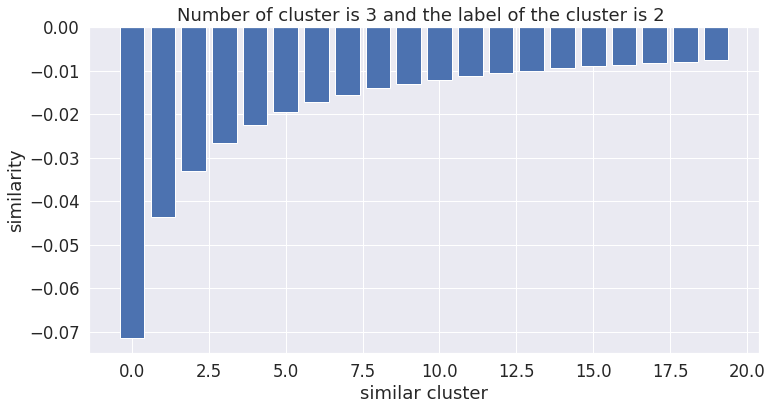

For n_clusters = 3 The average silhouette_score is : 0.39665234123561605
list of cluster words are: 
cluster 0 is ['top', 'call', 'group', 'many', 'uprising', 'went', 'appear', 'vest', 'among', 'students', 'streets', 'long', 'suppressed', 'intellectuals', 'wary']
cluster 1 is ['old', 'elections', 'severed', '##escu', 'swept', 'power', 'national', 'message', 'like', 'president', 'open', 'swirl', 'revolutionary', '##r', 'erase', 'artists', 'used', 'years', 'guard', 'flourished', 'mr']
cluster 2 is ['growing', 'demands', 'communist', 'party', 'dissolve', 'country', 'special', 'congress', 'di', '##sman', '##tle', 'even', 'late', 'saturday', 'night', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'today', 'rum', '##anian', 'controlled', 'non', 'leaders', 'leading', 'detained', 'urging', 'high', 'ranking', 'seeking', 'political', 'profile', 'eager', '##ness', '##s', 'mighty', 'communists', 'risen', 'dec', 'cry', 'reflects', 'land']
cluster 3 is ['confronted', 'officials', 'order', 

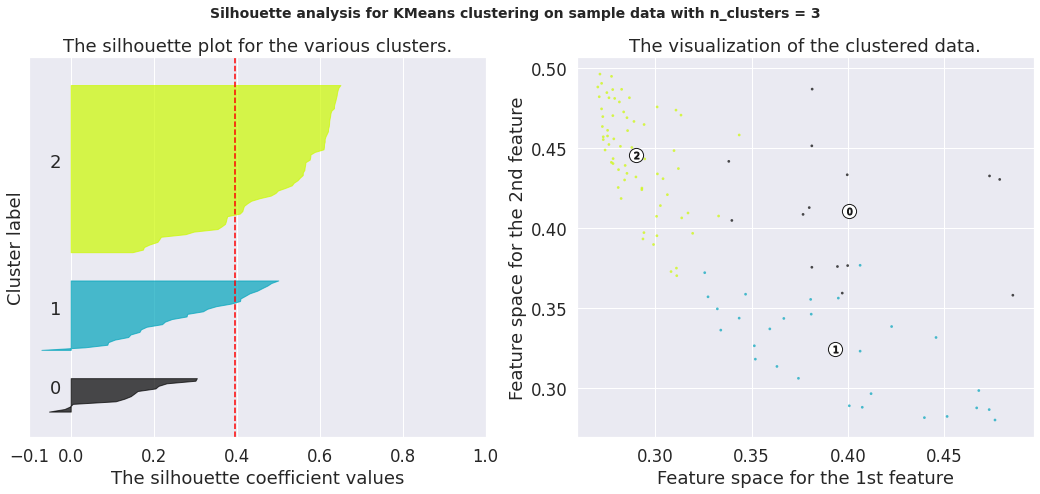

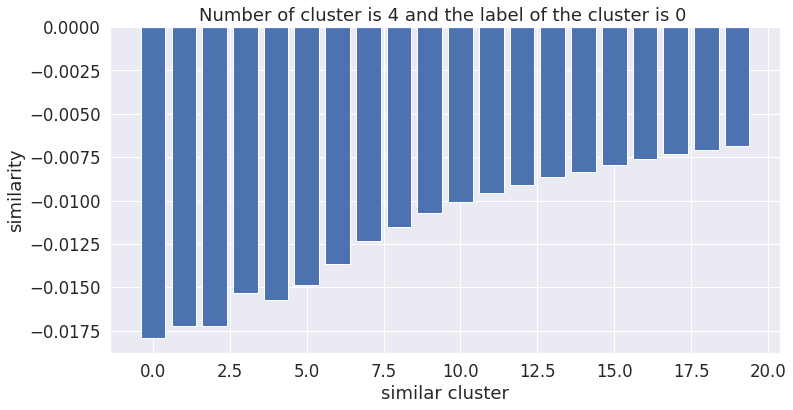

tmp_list shape is  (21, 20)  and the lenght is 20
Number of cluster is 3 and the label of the cluster is 1 


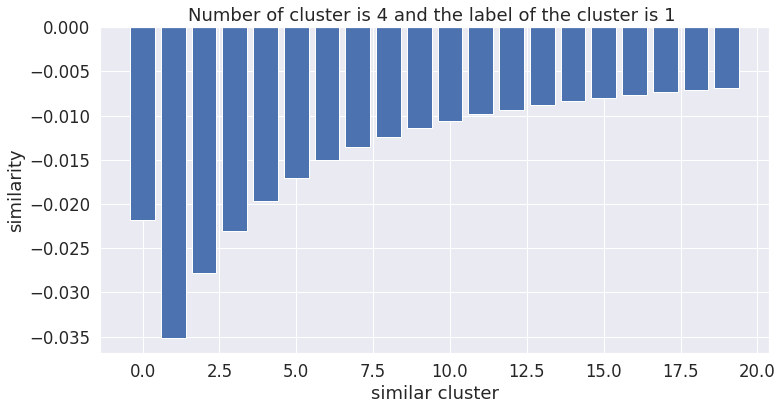

tmp_list shape is  (44, 20)  and the lenght is 20
Number of cluster is 3 and the label of the cluster is 2 


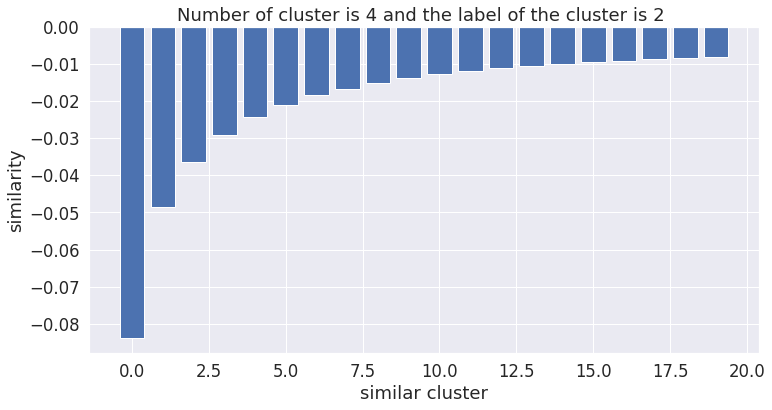

tmp_list shape is  (28, 20)  and the lenght is 20
Number of cluster is 3 and the label of the cluster is 3 


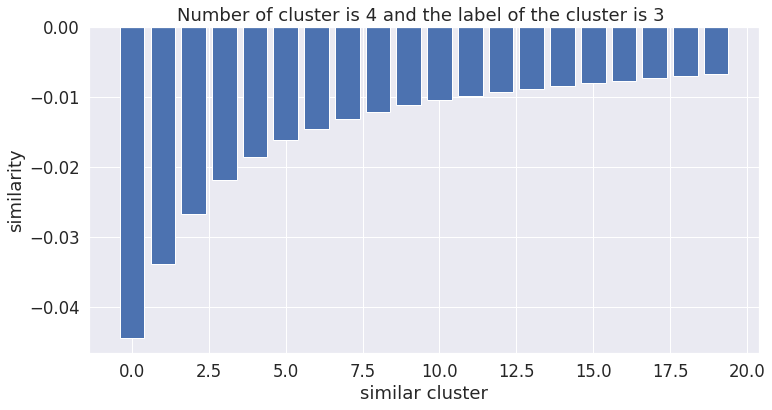

For n_clusters = 4 The average silhouette_score is : 0.2422204850995833
list of cluster words are: 
cluster 0 is ['dissolve', 'say', 'special', 'di', '##sman', '##tle', 'disgrace', '##d', 'even', 'free', 'newspapers', 'nicola', 'overthrow', '##vor', 'long', 'dec']
cluster 1 is ['officials', 'order', 'call', 'elections', 'held', 'quickly', 'relationship', 'popular', 'repeated', 'like', 'new', 'figures', 'since', '##e', 'dissolution', 'open', 'swirl', 'fe', '##ige', 'artists', 'intellectuals', '##imated', 'ranks', '24']
cluster 2 is ['confronted', 'growing', 'demands', 'communist', 'party', 'country', 'congress', 'april', 'late', 'saturday', 'night', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'today', 'rum', '##anian', 'controlled', 'non', 'leaders', 'leading', 'detained', 'urging', 'high', 'ranking', 'seeking', 'political', 'profile', 'eager', '##ness', '##s', 'mighty', 'communists', 'risen', 'cry', 'reflects', 'land', 'freedoms']
cluster 3 is ['old', 'severed', '##escu', 

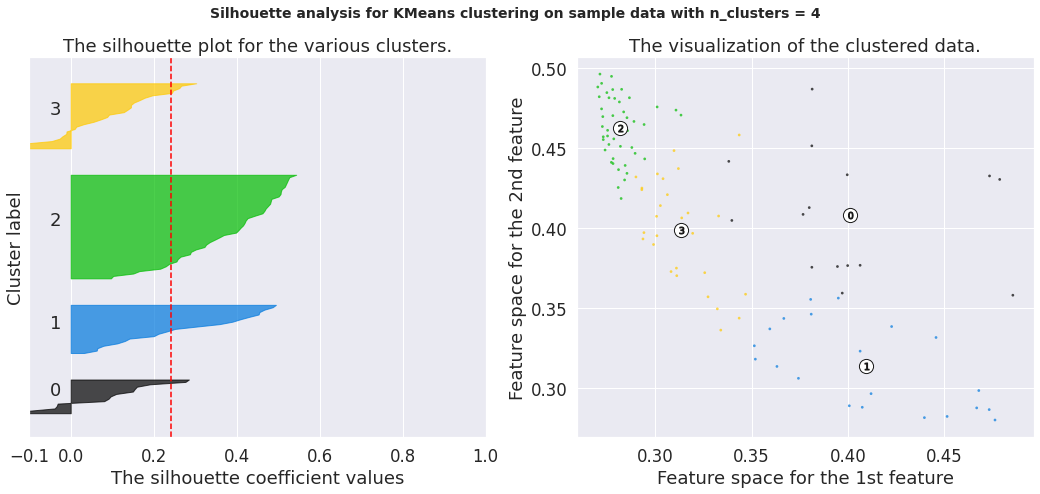

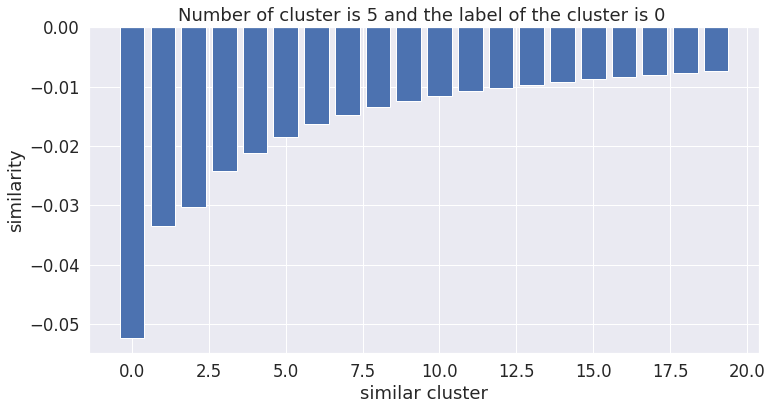

tmp_list shape is  (24, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 1 


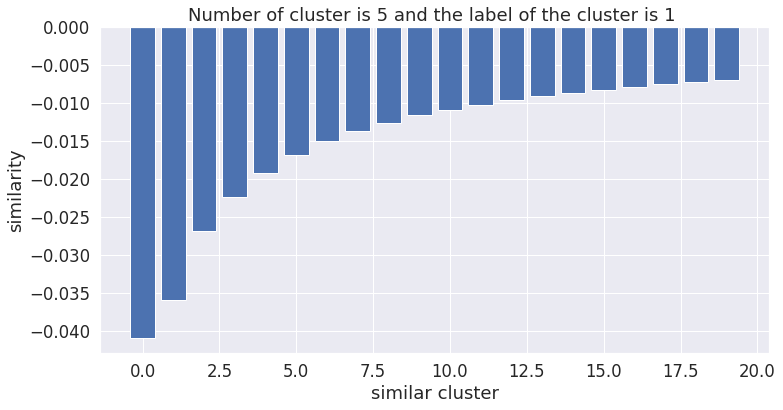

tmp_list shape is  (40, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 2 


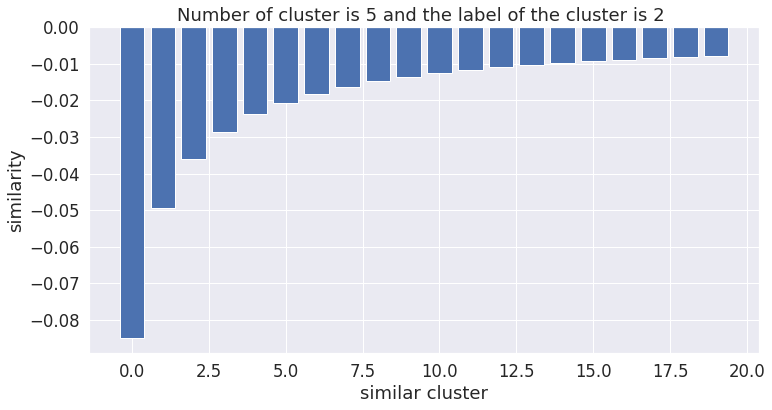

tmp_list shape is  (10, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 3 


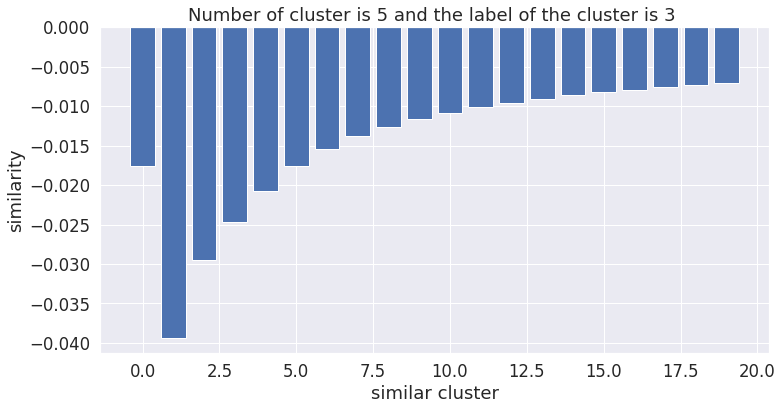

tmp_list shape is  (18, 20)  and the lenght is 20
Number of cluster is 4 and the label of the cluster is 4 


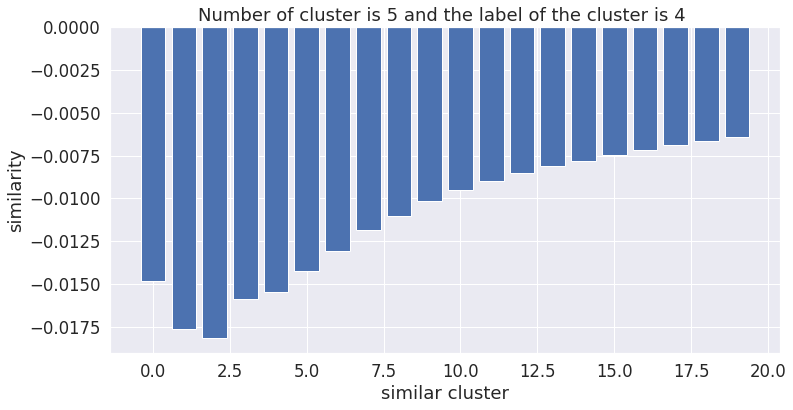

For n_clusters = 5 The average silhouette_score is : 0.2571412118204859
list of cluster words are: 
cluster 0 is ['top', 'call', 'group', 'uprising', 'went', 'national', 'message', 'like', 'appear', '##r', 'vest', 'used', 'guard', 'mr']
cluster 1 is ['officials', 'order', 'elections', 'held', 'quickly', 'relationship', 'popular', 'repeated', 'new', 'figures', 'since', '##e', 'dissolution', 'swirl', 'fe', '##ige', 'artists', 'intellectuals', '##imated', 'ranks', '24']
cluster 2 is ['old', 'severed', '##escu', 'swept', 'power', 'president', 'open', 'revolutionary', 'erase', 'years', 'flourished']
cluster 3 is ['dissolve', 'say', 'special', 'di', '##sman', '##tle', 'disgrace', '##d', 'free', 'newspapers', 'nicola', 'overthrow', '##vor', 'long']
cluster 4 is ['confronted', 'growing', 'demands', 'communist', 'party', 'country', 'congress', 'even', 'april', 'late', 'saturday', 'night', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'today', 'rum', '##anian', 'controlled', 'non', 'l

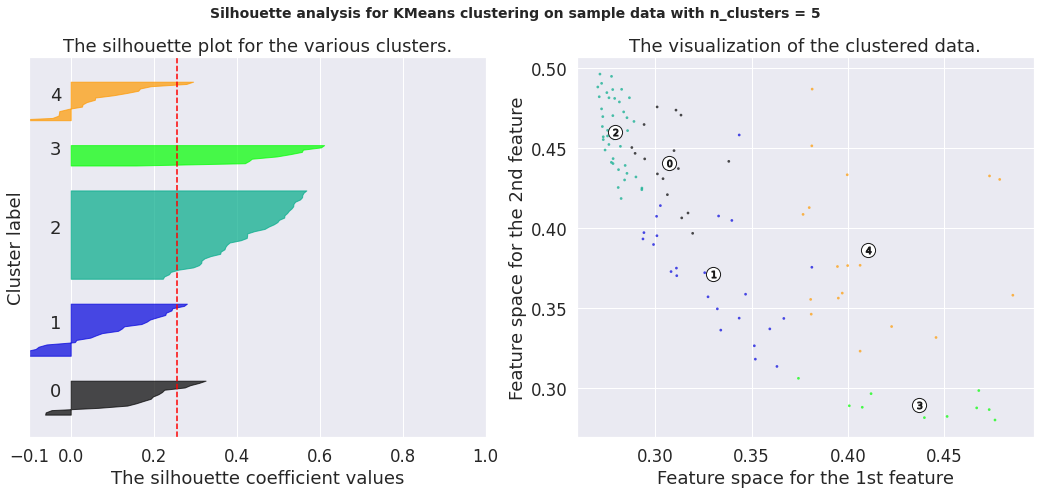

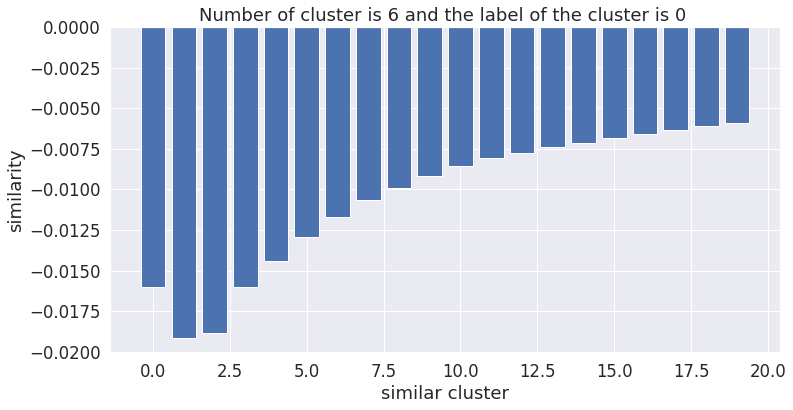

tmp_list shape is  (21, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 1 


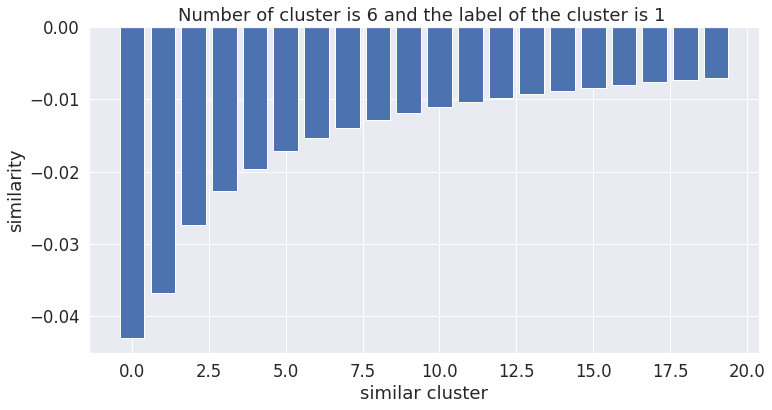

tmp_list shape is  (11, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 2 


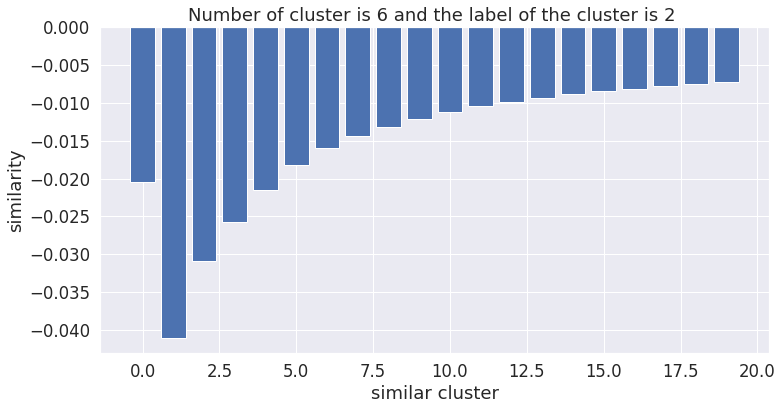

tmp_list shape is  (14, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 3 


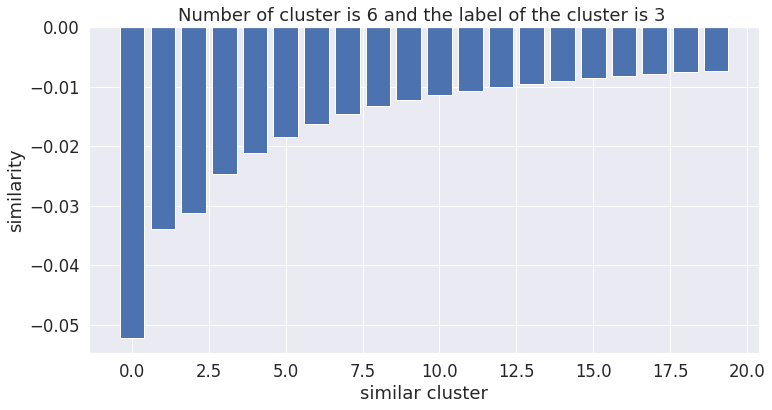

tmp_list shape is  (42, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 4 


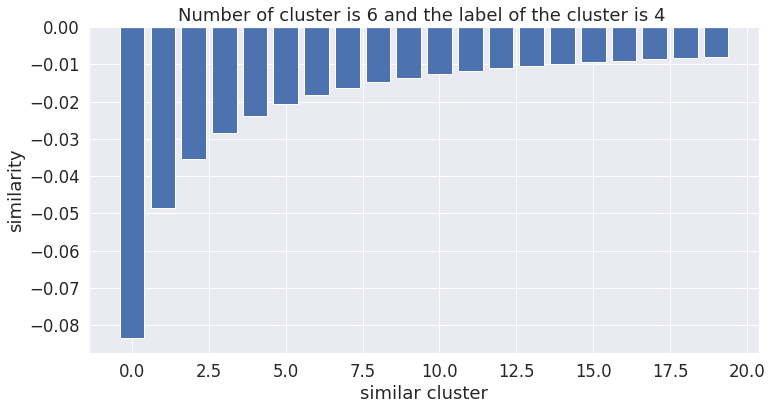

tmp_list shape is  (6, 20)  and the lenght is 20
Number of cluster is 5 and the label of the cluster is 5 


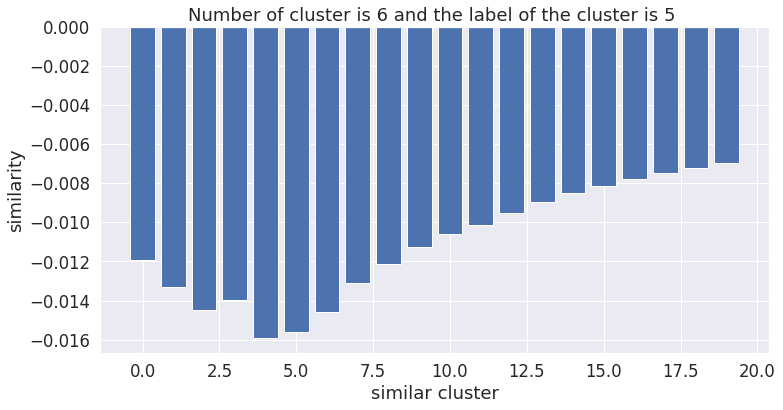

For n_clusters = 6 The average silhouette_score is : 0.26341249567607283


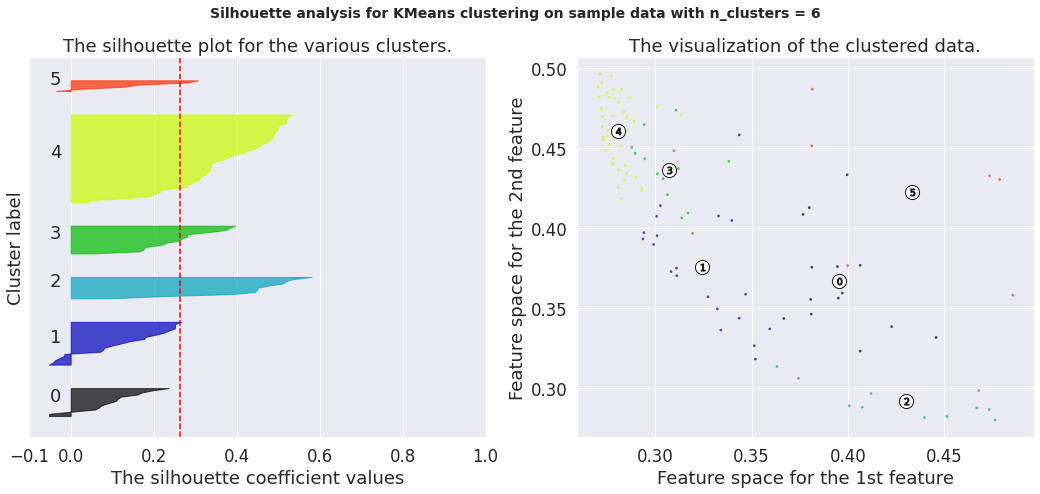

In [46]:
#clustering by kmean. it creates different clusters in each iteration

X =np.array(list(gradient_word_similarity_dict.values()))
word_list = list(gradient_word_similarity_dict.keys())
new_X = X[:,0:Max_Feature_Size]
print(new_X)
#applying sigmoid function to the features
# sigmoid  function to apply on each vector as a activation function
def sigmoid(vec_):
  z = array(vec_)
  z = z/np.linalg.norm(z)
  g = 1 / (1 + exp(-z))
  return g

for ind in range(0,new_X.shape[0]):
  new_X[ind] = sigmoid(new_X[ind])
print(new_X)

total_dict = dict()
total_centers = dict()
silhouette_avg_list = list()
# centroids_dict = dict()
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(new_X)
    # centroids = clusterer.cluster_centers_
    # centroids_dict[n_clusters] = centroids
    token_list = word_list
    tmp_dic = dict()
    for x in range(0, n_clusters):
      tmp_list = list()
      for i, j in zip(token_list, cluster_labels):
        if j == x:
          tmp_list.append(i)
      tmp_dic[x] = tmp_list
    total_dict[n_clusters] = tmp_dic
    print('list of cluster words are: ')
    for prt in tmp_dic:
      print('cluster {} is {}'.format(prt, tmp_dic[prt]))

    for w_list,ind in zip(tmp_dic.values(), tmp_dic.keys()):
      tmp_list = list()

      for w in w_list:
        tmp_list.append(gradient_word_similarity_dict[w][0:Max_Feature_Size])
      print('tmp_list shape is ', np.shape(tmp_list), ' and the lenght is', len(tmp_list[0]))
      tmp_word_list = list()
      all_distribution = list()
      for f in range(0,len(tmp_list[0])):
        for t in tmp_list:
          tmp_word_list.append(t[f])

        all_distribution.append(mean(tmp_word_list))

      print('Number of cluster is {} and the label of the cluster is {} '.format(x, ind))
      plt.figure()
      plt.bar(range(0, len(tmp_list[0])), all_distribution)
      plt.xlabel('similar cluster')
      plt.ylabel('similarity')
      plt.title('Number of cluster is {} and the label of the cluster is {} '.format(x+1, ind))
      plt.show()

      

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(new_X) + (n_clusters + 1) * 10])  


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(new_X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_avg_list.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(new_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(new_X[:, 0], new_X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    total_centers[n_clusters] = centers
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i_, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i_, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()


***************new sorting based on the similarity between words in each cluster and the centroid*************
number of clustering is 2 and the dic is {0: ['top', 'officials', 'old', 'call', 'elections', 'held', 'group', 'many', 'severed', '##escu', 'popular', 'uprising', 'swept', 'power', 'went', 'national', 'message', 'like', 'new', 'since', 'president', '##e', 'appear', 'open', 'swirl', 'revolutionary', '##r', 'erase', 'vest', 'among', 'students', 'streets', 'suppressed', 'artists', 'intellectuals', 'used', 'years', 'wary', 'guard', 'flourished', 'mr'], 1: ['confronted', 'growing', 'demands', 'communist', 'party', 'dissolve', 'country', 'order', 'say', 'special', 'congress', 'di', '##sman', '##tle', 'disgrace', '##d', 'even', 'free', 'april', 'late', 'saturday', 'night', 'quickly', 'relationship', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'repeated', 'today', 'rum', '##anian', 'newspapers', 'controlled', 'non', 'leaders', 'leading', 'figures', 'detained', 'nicola', '

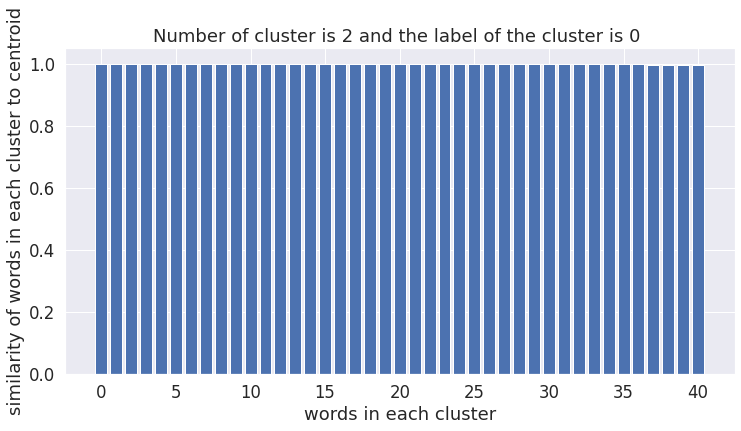

sorted is:  [('urging', 0.9999407762979017), ('ce', 0.9999399597507834), ('leading', 0.9999308181976558), ('freedoms', 0.9999157482079907), ('communist', 0.9999007662901013), ('country', 0.9998953551395254), ('##aus', 0.9998839294708767), ('high', 0.9998681400684365), ('reflects', 0.9998675145312284), ('mighty', 0.9998653733759749), ('detained', 0.9998538043689479), ('risen', 0.99984630840432), ('today', 0.9998418337228141), ('eager', 0.9998386119610537), ('late', 0.9998364297803111), ('non', 0.9998253632077766), ('profile', 0.9998114761986079), ('congress', 0.9998107895380811), ('political', 0.9998099345186334), ('##ness', 0.9998060258876698), ('cry', 0.9997967546249195), ('land', 0.9997941168867243), ('rum', 0.9997904268619553), ('##tle', 0.999774195511196), ('growing', 0.9997734890187979), ('##sman', 0.9997682048556948), ('communists', 0.9997542125593081), ('##anian', 0.9997367828110924), ('television', 0.9997332903453373), ('ranking', 0.9997149061838312), ('demands', 0.999713202794

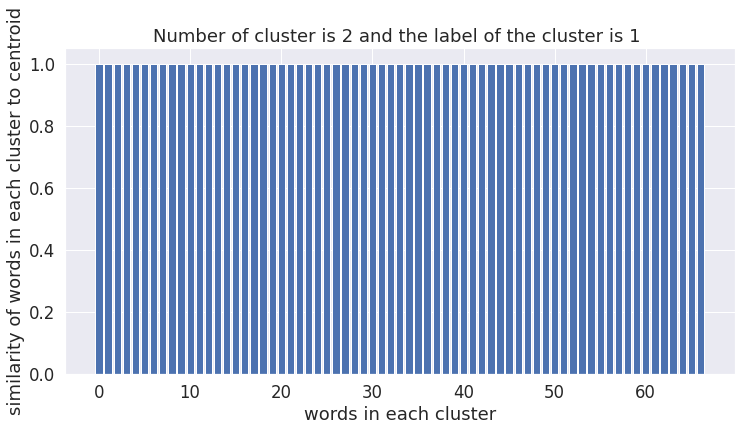

************************************************************************************
number of clustering is 3 and the dic is {0: ['top', 'call', 'group', 'many', 'went', 'appear', 'vest', 'among', 'students', 'streets', 'long', 'suppressed', 'intellectuals', 'wary'], 1: ['officials', 'old', 'elections', 'held', 'severed', '##escu', 'popular', 'uprising', 'swept', 'power', 'national', 'message', 'like', 'new', 'since', 'president', '##e', 'open', 'swirl', 'revolutionary', '##r', 'erase', 'artists', 'used', 'years', 'guard', 'flourished', 'mr'], 2: ['confronted', 'growing', 'demands', 'communist', 'party', 'dissolve', 'country', 'order', 'say', 'special', 'congress', 'di', '##sman', '##tle', 'disgrace', '##d', 'even', 'free', 'april', 'late', 'saturday', 'night', 'quickly', 'relationship', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'repeated', 'today', 'rum', '##anian', 'newspapers', 'controlled', 'non', 'leaders', 'leading', 'figures', 'detained', 'nicola', 'overthrow', '

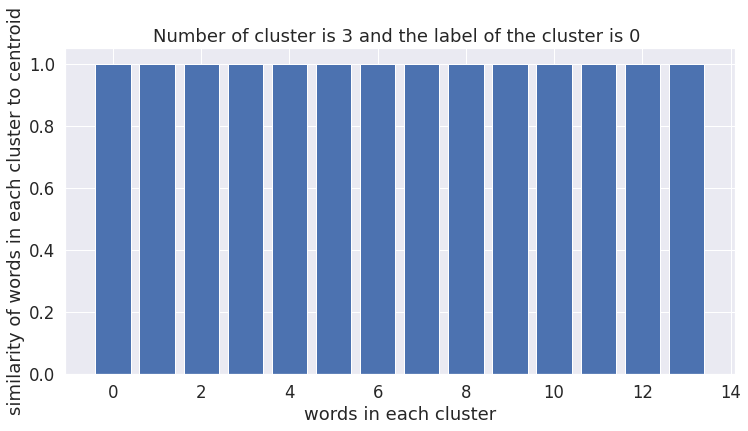

sorted is:  [('erase', 0.9998566995396546), ('open', 0.999788762434635), ('revolutionary', 0.9997462676804083), ('elections', 0.9996788020118005), ('swirl', 0.9996558727613265), ('president', 0.9996192049634535), ('message', 0.9995812494418762), ('severed', 0.999567810315578), ('like', 0.9995673461019768), ('flourished', 0.9995341974513645), ('held', 0.999408797685792), ('mr', 0.9993463270507124), ('popular', 0.9993142210437129), ('since', 0.9993006990289299), ('artists', 0.999263208732531), ('national', 0.9992502963069265), ('new', 0.9991907344110941), ('##escu', 0.9991580979352445), ('years', 0.9991110992802901), ('##e', 0.9990999667617196), ('power', 0.9990608116111627), ('swept', 0.9990520975638894), ('used', 0.9989759062163582), ('guard', 0.9989608139518035), ('##r', 0.9988754593256316), ('officials', 0.9988018291347881), ('old', 0.998304706976862), ('uprising', 0.9981265425159468)]
cluster 1  ['erase', 'open', 'revolutionary', 'elections', 'swirl', 'president', 'message', 'severe

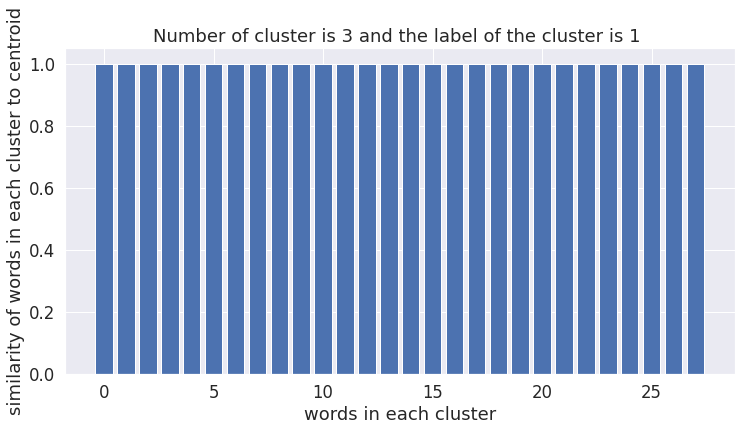

sorted is:  [('urging', 0.9999418497730518), ('leading', 0.999936853122903), ('ce', 0.9999355017531119), ('freedoms', 0.9999160655695103), ('communist', 0.999903871611756), ('country', 0.9999022736542037), ('##aus', 0.9998910326782101), ('reflects', 0.9998738405222122), ('high', 0.9998689660667667), ('mighty', 0.9998644769560812), ('detained', 0.9998523966944893), ('risen', 0.9998513512125103), ('eager', 0.9998480333091468), ('late', 0.9998427271079239), ('today', 0.9998401963114142), ('non', 0.9998299238152374), ('profile', 0.9998170374523069), ('##ness', 0.999815160176882), ('political', 0.9998137572925567), ('congress', 0.9998109760041155), ('land', 0.9998047588947903), ('cry', 0.9998034911380302), ('rum', 0.9997998610946067), ('growing', 0.9997788207557001), ('##sman', 0.9997679078546279), ('##tle', 0.9997675462460835), ('communists', 0.9997506049499568), ('##anian', 0.9997445190113868), ('television', 0.9997377670273617), ('demands', 0.9997194710449605), ('ranking', 0.999718549898

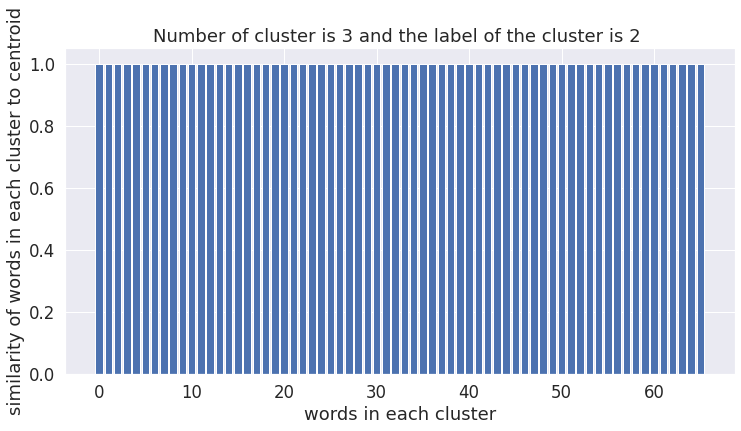

************************************************************************************
number of clustering is 4 and the dic is {0: ['top', 'call', 'group', 'many', 'uprising', 'went', 'appear', 'vest', 'among', 'students', 'streets', 'long', 'suppressed', 'intellectuals', 'wary'], 1: ['old', 'elections', 'severed', '##escu', 'swept', 'power', 'national', 'message', 'like', 'president', 'open', 'swirl', 'revolutionary', '##r', 'erase', 'artists', 'used', 'years', 'guard', 'flourished', 'mr'], 2: ['growing', 'demands', 'communist', 'party', 'dissolve', 'country', 'special', 'congress', 'di', '##sman', '##tle', 'even', 'late', 'saturday', 'night', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'today', 'rum', '##anian', 'controlled', 'non', 'leaders', 'leading', 'detained', 'urging', 'high', 'ranking', 'seeking', 'political', 'profile', 'eager', '##ness', '##s', 'mighty', 'communists', 'risen', 'dec', 'cry', 'reflects', 'land'], 3: ['confronted', 'officials', 'order', 'say', 'dis

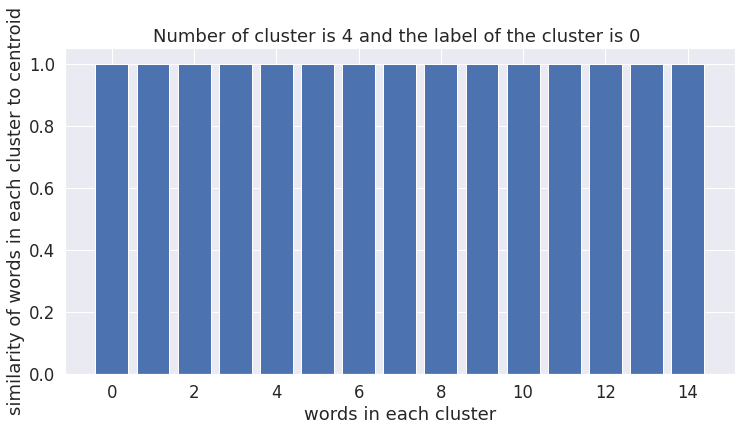

sorted is:  [('revolutionary', 0.9998132403673486), ('erase', 0.9997718473460362), ('severed', 0.9997712418648879), ('president', 0.9996647685699829), ('open', 0.9996572501476557), ('flourished', 0.9996378979347789), ('message', 0.9995925234888466), ('elections', 0.9994957977993997), ('swirl', 0.9994626954278175), ('like', 0.9994151678937163), ('years', 0.9994078542577418), ('power', 0.9993949115145822), ('##escu', 0.9993874637112846), ('swept', 0.9993629017118505), ('mr', 0.9992176087443467), ('guard', 0.9991065834440762), ('national', 0.9990969611707929), ('artists', 0.999087063207365), ('used', 0.9989939583543882), ('##r', 0.9987805181217614), ('old', 0.9986075827068263)]
cluster 1  ['revolutionary', 'erase', 'severed', 'president', 'open', 'flourished', 'message', 'elections', 'swirl', 'like', 'years', 'power', '##escu', 'swept', 'mr', 'guard', 'national', 'artists', 'used', '##r', 'old']
Number of cluster is 4 and the label of the cluster is 1 


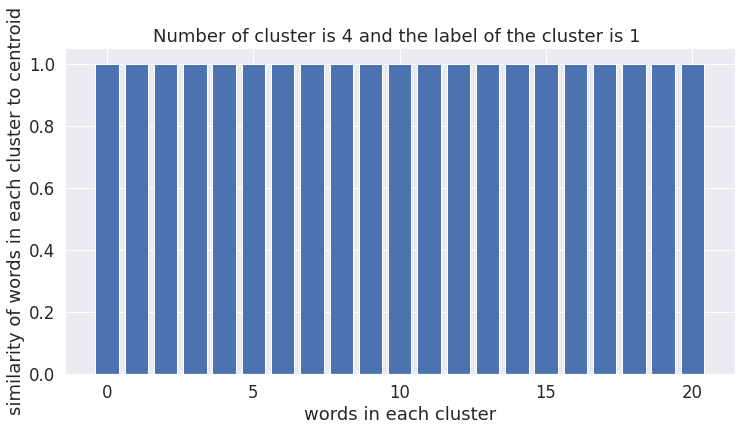

sorted is:  [('leading', 0.9999471164322027), ('risen', 0.9999417871459594), ('profile', 0.9999413239885155), ('reflects', 0.9999244804521442), ('non', 0.9999154203964107), ('congress', 0.9999147597600192), ('political', 0.9999086249971088), ('detained', 0.9999041216161162), ('##anian', 0.9998953698299777), ('late', 0.9998941371591743), ('communist', 0.999890926783979), ('country', 0.9998852371182803), ('rum', 0.9998807343455082), ('eager', 0.9998739228783192), ('##aus', 0.999871632173746), ('urging', 0.9998714859169537), ('##ness', 0.9998706734946856), ('mighty', 0.9998704196526857), ('controlled', 0.9998582949193823), ('ce', 0.9998453578251791), ('land', 0.9998278247475383), ('ranking', 0.9998216408366394), ('communists', 0.9998209609823673), ('saturday', 0.9998180223730889), ('dictatorship', 0.9998159984481553), ('high', 0.9998085740913254), ('demands', 0.999792286092668), ('today', 0.9997748382576865), ('television', 0.9997555009581399), ('seeking', 0.9997298261158717), ('growing',

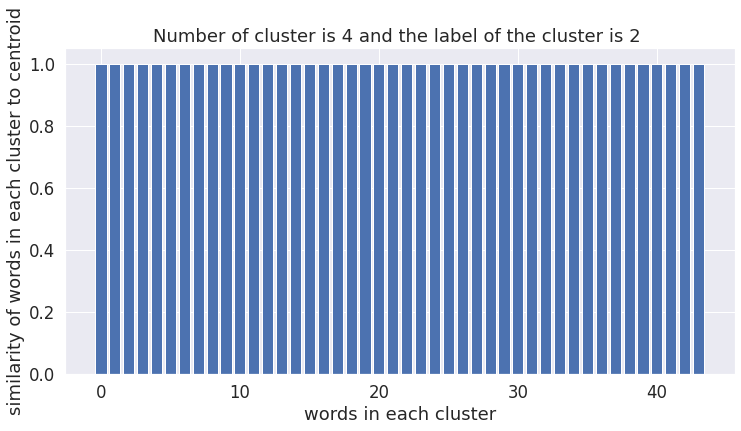

sorted is:  [('figures', 0.9999181791085667), ('relationship', 0.9998481915562742), ('fe', 0.9998285464347494), ('repeated', 0.9998026821520772), ('24', 0.9997979805349463), ('order', 0.9997850284441768), ('freedoms', 0.9997550514225579), ('quickly', 0.9997326775274712), ('dissolution', 0.9997316913399036), ('##e', 0.9997308792277542), ('popular', 0.9996811723031443), ('newspapers', 0.9996639695114704), ('april', 0.9996308130322512), ('##d', 0.9995850491142831), ('overthrow', 0.9995533425418321), ('free', 0.999537688786977), ('nicola', 0.9995207607400458), ('confronted', 0.9995106507394319), ('##vor', 0.9994896221676313), ('since', 0.9994463670728242), ('##ige', 0.9994089239795455), ('held', 0.9993599330171473), ('say', 0.9992187713784206), ('disgrace', 0.9991872192658572), ('new', 0.9990677219517445), ('ranks', 0.9990379635741193), ('officials', 0.9990081187348535), ('##imated', 0.9974313126863862)]
cluster 3  ['figures', 'relationship', 'fe', 'repeated', '24', 'order', 'freedoms', 'q

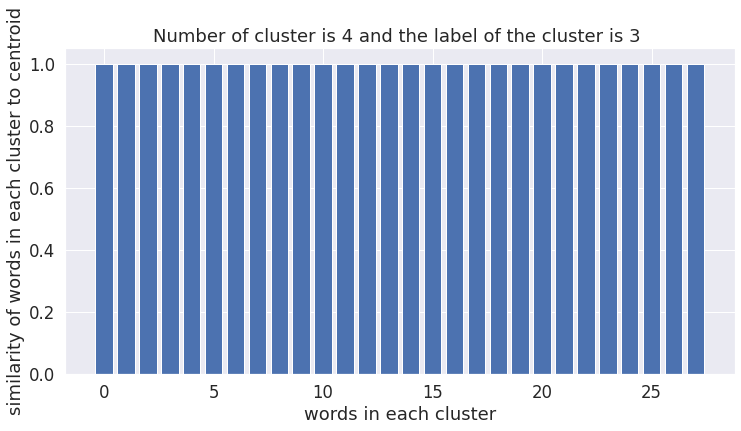

************************************************************************************
number of clustering is 5 and the dic is {0: ['dissolve', 'say', 'special', 'di', '##sman', '##tle', 'disgrace', '##d', 'even', 'free', 'newspapers', 'nicola', 'overthrow', '##vor', 'long', 'dec'], 1: ['officials', 'order', 'call', 'elections', 'held', 'quickly', 'relationship', 'popular', 'repeated', 'like', 'new', 'figures', 'since', '##e', 'dissolution', 'open', 'swirl', 'fe', '##ige', 'artists', 'intellectuals', '##imated', 'ranks', '24'], 2: ['confronted', 'growing', 'demands', 'communist', 'party', 'country', 'congress', 'april', 'late', 'saturday', 'night', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'today', 'rum', '##anian', 'controlled', 'non', 'leaders', 'leading', 'detained', 'urging', 'high', 'ranking', 'seeking', 'political', 'profile', 'eager', '##ness', '##s', 'mighty', 'communists', 'risen', 'cry', 'reflects', 'land', 'freedoms'], 3: ['old', 'severed', '##escu', 'swept', '

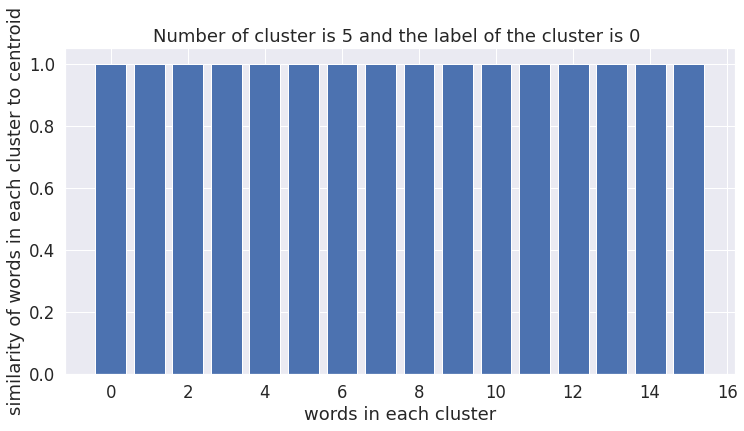

sorted is:  [('relationship', 0.9998298138903824), ('24', 0.9998178375663122), ('##e', 0.9998136978229946), ('figures', 0.9998115745830234), ('quickly', 0.9998094873065178), ('popular', 0.999746438227686), ('repeated', 0.9997428198106795), ('fe', 0.9996865969441471), ('held', 0.9996620109157349), ('dissolution', 0.9996427038401029), ('since', 0.9996156672051748), ('order', 0.9996029602718979), ('elections', 0.9995531804043782), ('swirl', 0.9995279426643308), ('new', 0.9994780446197762), ('##ige', 0.9993801501108879), ('open', 0.9993750863461155), ('officials', 0.9993664381301263), ('like', 0.9993557259498785), ('artists', 0.9993239804508804), ('intellectuals', 0.9990907294304814), ('ranks', 0.9990563038605443), ('call', 0.9986122695613161), ('##imated', 0.9972649080228401)]
cluster 1  ['relationship', '24', '##e', 'figures', 'quickly', 'popular', 'repeated', 'fe', 'held', 'dissolution', 'since', 'order', 'elections', 'swirl', 'new', '##ige', 'open', 'officials', 'like', 'artists', 'int

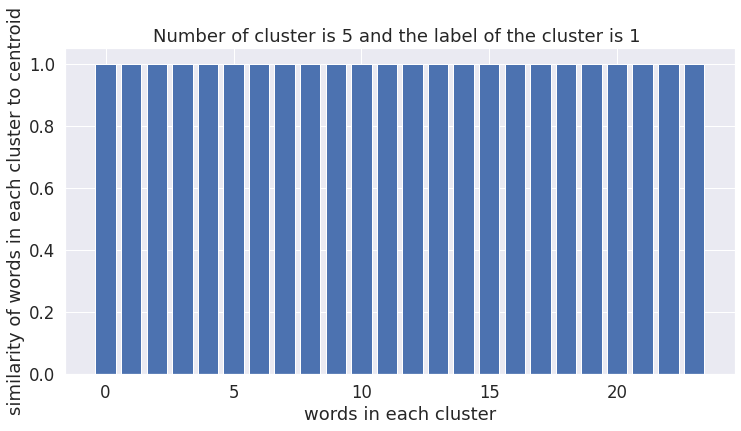

sorted is:  [('leading', 0.9999635202521276), ('reflects', 0.9999587716548025), ('profile', 0.9999548005489904), ('non', 0.9999403158713499), ('rum', 0.999933059555169), ('risen', 0.9999318749551553), ('late', 0.9999285632111968), ('##ness', 0.999923829325633), ('country', 0.9999225083253034), ('eager', 0.9999209553803383), ('communist', 0.9999081826087622), ('##anian', 0.9999071808278724), ('##aus', 0.9999068719187909), ('congress', 0.9998922586850477), ('controlled', 0.9998787168507702), ('mighty', 0.9998706620726391), ('urging', 0.999866918858791), ('political', 0.9998653503637387), ('detained', 0.9998640976300973), ('land', 0.9998578064798505), ('freedoms', 0.999837551778725), ('demands', 0.9998373481481707), ('saturday', 0.9998362286499419), ('high', 0.9998300179592607), ('ce', 0.9998013195220405), ('today', 0.9997884421820051), ('communists', 0.9997842246807205), ('growing', 0.9997770383119908), ('ranking', 0.9997742641381245), ('dictatorship', 0.9997641205163331), ('cry', 0.9997

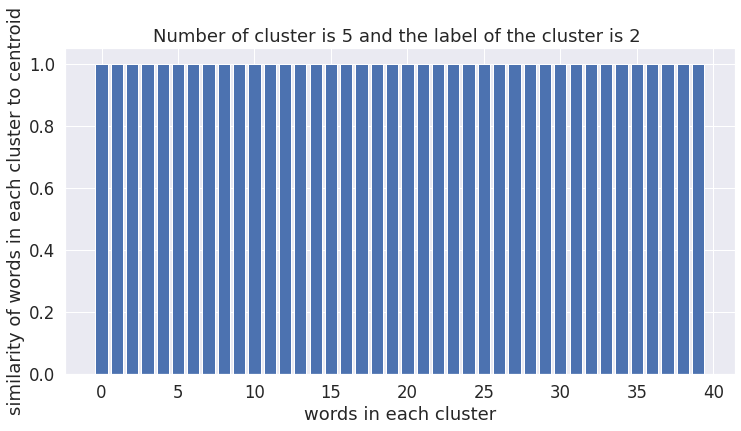

sorted is:  [('severed', 0.9999420834164702), ('revolutionary', 0.9998495557610928), ('power', 0.9997862807154726), ('flourished', 0.9997614538827486), ('##escu', 0.9997423886054436), ('president', 0.9997005008715695), ('years', 0.9996890060804907), ('swept', 0.9996528973328218), ('erase', 0.9994387531396869), ('old', 0.9991286641193097)]
cluster 3  ['severed', 'revolutionary', 'power', 'flourished', '##escu', 'president', 'years', 'swept', 'erase', 'old']
Number of cluster is 5 and the label of the cluster is 3 


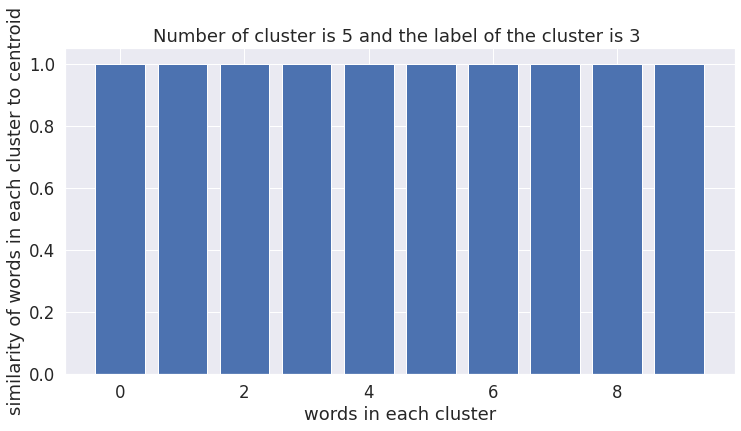

sorted is:  [('appear', 0.9996596743875382), ('mr', 0.9996202402523514), ('streets', 0.9994689186221422), ('group', 0.9993940610089463), ('vest', 0.9993632011223681), ('message', 0.9992830809191947), ('national', 0.9992815968935636), ('##r', 0.9992810058795729), ('guard', 0.9991936642593883), ('top', 0.9991906279338975), ('students', 0.999138882158001), ('used', 0.9990803663634156), ('uprising', 0.9989398535691937), ('among', 0.9985236396942858), ('suppressed', 0.9981618159426784), ('went', 0.9981457426849418), ('many', 0.9979328629428199), ('wary', 0.9977584054745807)]
cluster 4  ['appear', 'mr', 'streets', 'group', 'vest', 'message', 'national', '##r', 'guard', 'top', 'students', 'used', 'uprising', 'among', 'suppressed', 'went', 'many', 'wary']
Number of cluster is 5 and the label of the cluster is 4 


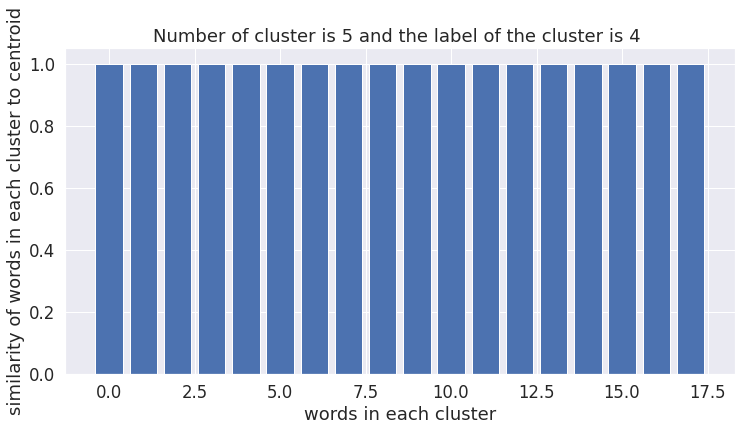

************************************************************************************
number of clustering is 6 and the dic is {0: ['top', 'call', 'group', 'uprising', 'went', 'national', 'message', 'like', 'appear', '##r', 'vest', 'used', 'guard', 'mr'], 1: ['officials', 'order', 'elections', 'held', 'quickly', 'relationship', 'popular', 'repeated', 'new', 'figures', 'since', '##e', 'dissolution', 'swirl', 'fe', '##ige', 'artists', 'intellectuals', '##imated', 'ranks', '24'], 2: ['old', 'severed', '##escu', 'swept', 'power', 'president', 'open', 'revolutionary', 'erase', 'years', 'flourished'], 3: ['dissolve', 'say', 'special', 'di', '##sman', '##tle', 'disgrace', '##d', 'free', 'newspapers', 'nicola', 'overthrow', '##vor', 'long'], 4: ['confronted', 'growing', 'demands', 'communist', 'party', 'country', 'congress', 'even', 'april', 'late', 'saturday', 'night', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'today', 'rum', '##anian', 'controlled', 'non', 'leaders', 'leading',

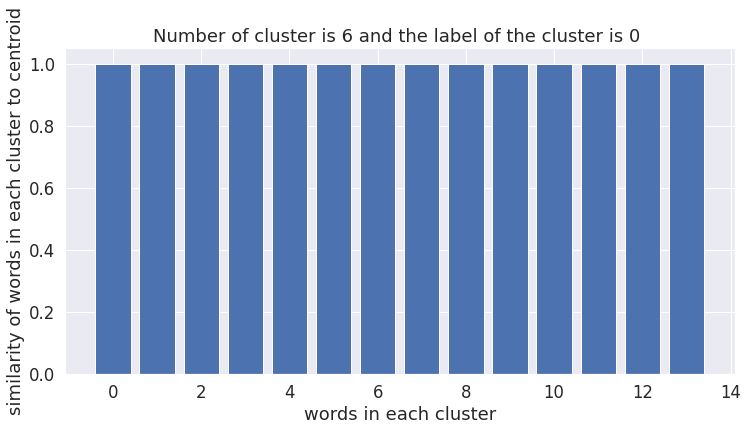

sorted is:  [('figures', 0.9998539689344714), ('24', 0.9998476160090005), ('relationship', 0.9998408579822393), ('quickly', 0.999830917539519), ('##e', 0.9998028922823051), ('repeated', 0.9997844631581595), ('fe', 0.9997372356813746), ('popular', 0.9997275375524229), ('dissolution', 0.999700734111336), ('order', 0.9996554704101861), ('held', 0.9996321873737092), ('since', 0.9995819310452432), ('elections', 0.9994803622655247), ('swirl', 0.9994687629205851), ('##ige', 0.9994442137953201), ('new', 0.999419423952673), ('officials', 0.9993316321520884), ('artists', 0.9992479138784771), ('intellectuals', 0.9990835507397988), ('ranks', 0.9990555592940579), ('##imated', 0.9973170916874433)]
cluster 1  ['figures', '24', 'relationship', 'quickly', '##e', 'repeated', 'fe', 'popular', 'dissolution', 'order', 'held', 'since', 'elections', 'swirl', '##ige', 'new', 'officials', 'artists', 'intellectuals', 'ranks', '##imated']
Number of cluster is 6 and the label of the cluster is 1 


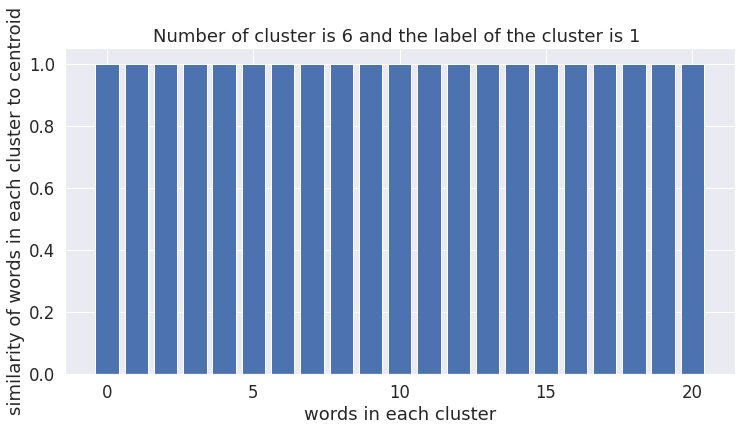

sorted is:  [('severed', 0.9999392553837437), ('revolutionary', 0.9998832314484449), ('flourished', 0.9997845315953121), ('president', 0.9997499420855112), ('power', 0.9997247980723961), ('##escu', 0.9997039211699053), ('years', 0.9996415154712361), ('swept', 0.9995925730919962), ('erase', 0.999539124126987), ('open', 0.9993817470159941), ('old', 0.9990692013549072)]
cluster 2  ['severed', 'revolutionary', 'flourished', 'president', 'power', '##escu', 'years', 'swept', 'erase', 'open', 'old']
Number of cluster is 6 and the label of the cluster is 2 


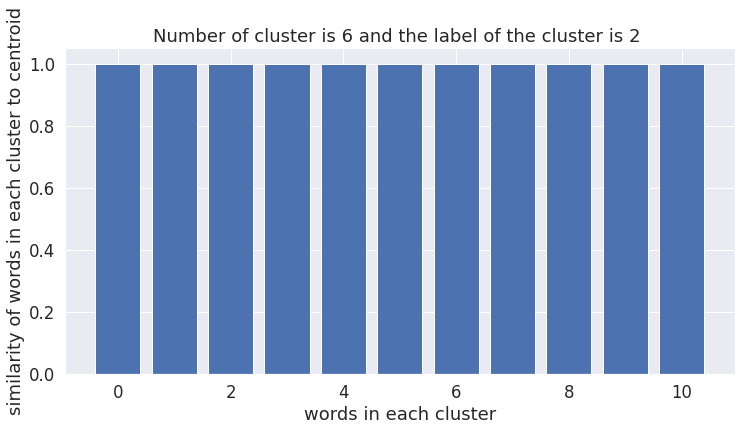

sorted is:  [('##tle', 0.9999196568095161), ('di', 0.9999071107388704), ('##d', 0.9998574288344114), ('nicola', 0.9998256807112992), ('special', 0.9998256429983748), ('##sman', 0.9998219167599651), ('newspapers', 0.9998006326427747), ('disgrace', 0.9997969463377064), ('free', 0.9996618109474266), ('overthrow', 0.999644903888445), ('dissolve', 0.9996244829834589), ('##vor', 0.9995914323416547), ('say', 0.9995200950549679), ('long', 0.998892651886884)]
cluster 3  ['##tle', 'di', '##d', 'nicola', 'special', '##sman', 'newspapers', 'disgrace', 'free', 'overthrow', 'dissolve', '##vor', 'say', 'long']
Number of cluster is 6 and the label of the cluster is 3 


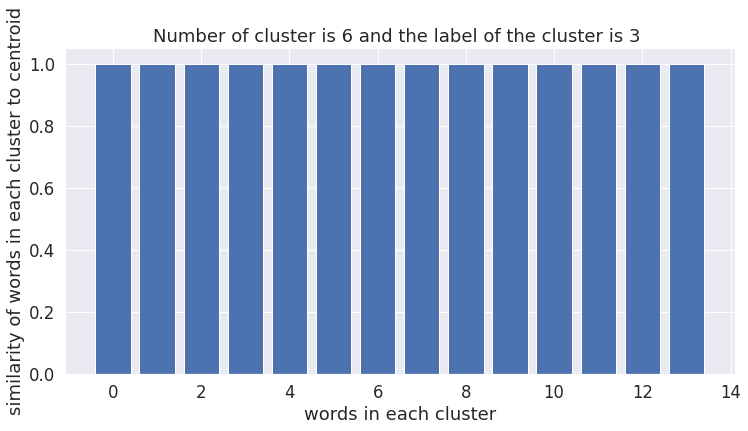

sorted is:  [('leading', 0.9999568252381624), ('profile', 0.999952037217833), ('reflects', 0.999946683537701), ('non', 0.9999368211312191), ('risen', 0.9999239617709805), ('rum', 0.9999219364737021), ('late', 0.9999203634154408), ('country', 0.9999175397220141), ('##ness', 0.9999086675317486), ('##aus', 0.9999049659005466), ('eager', 0.9999048846709029), ('congress', 0.9999039051548251), ('##anian', 0.9998992289028247), ('communist', 0.9998970173909209), ('controlled', 0.9998729421765982), ('detained', 0.9998701331646104), ('mighty', 0.9998692769213458), ('urging', 0.9998692522320087), ('political', 0.9998680476067685), ('land', 0.9998558057437076), ('freedoms', 0.9998445975169383), ('saturday', 0.9998391429727197), ('demands', 0.9998308081299961), ('high', 0.9998246352420027), ('ce', 0.9998126520452044), ('today', 0.9998018290368232), ('communists', 0.9997929694999869), ('dictatorship', 0.999782970820047), ('ranking', 0.9997726409013445), ('growing', 0.9997585692213956), ('television'

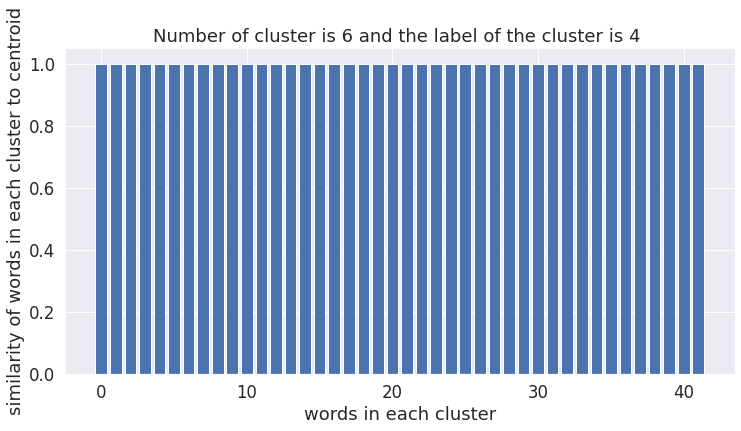

sorted is:  [('among', 0.9994634901158621), ('suppressed', 0.9993899972701902), ('streets', 0.9993524066758821), ('students', 0.9990824416397027), ('many', 0.9987797955869484), ('wary', 0.9986827508397332)]
cluster 5  ['among', 'suppressed', 'streets', 'students', 'many', 'wary']
Number of cluster is 6 and the label of the cluster is 5 


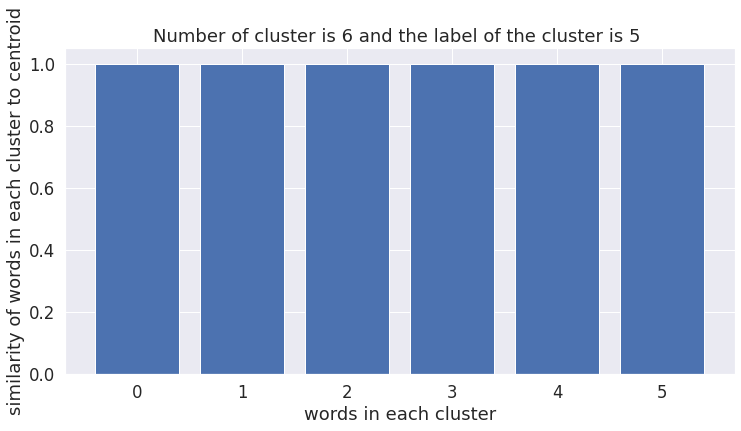

************************************************************************************


In [56]:

print('***************new sorting based on the similarity between words in each cluster and the centroid*************')
# centers is the centroid for each cluster. size is (#cluster, #dimension_features)
# gradient_word_similarity_dict is a dictionary that has all word as the key and their embedding as value after getting gradiet from them
total_clusters_sorted = dict()
total_clusters_with_similarities = dict()
for h in range_n_clusters:
  temp1_dict = dict()
  print('number of clustering is {} and the dic is {}'.format(h,total_dict[h]))
  for clus in total_dict[h]:
    temp_dict = dict()
    for w_ in total_dict[h][clus]:
      # print(clus, ' is ', w_)
      # print('similarity is ', cosine_similarity([sigmoid(gradient_word_similarity_dict[w_])[0:Max_Feature_Size]],[total_centers[h][clus][0:Max_Feature_Size]])[0][0])
      temp_dict[w_] = cosine_similarity([sigmoid(gradient_word_similarity_dict[w_])[0:Max_Feature_Size]],[total_centers[h][clus][0:Max_Feature_Size]])[0][0]
    # print(temp_dict)
    temp = sorted(temp_dict.items(), key=lambda kv: kv[1], reverse=True)
    total_clusters_with_similarities[(h, clus)] = temp
    final_list = list()
    value_sim= list()
    for r in temp:
      final_list.append(r[0])
      value_sim.append(r[1])
    print('sorted is: ', temp)
    print('cluster {} '.format(clus), final_list)
    temp1_dict[clus] = stop_word_remover(final_list, stopwords)


    print('Number of cluster is {} and the label of the cluster is {} '.format(h, clus))
    plt.figure()
    plt.bar(range(0, len(value_sim)), value_sim)
    plt.xlabel('words in each cluster')
    plt.ylabel('similarity of words in each cluster to centroid')
    plt.title('Number of cluster is {} and the label of the cluster is {} '.format(h, clus))
    plt.show()
  total_clusters_sorted[h] = temp1_dict
  print('************************************************************************************')


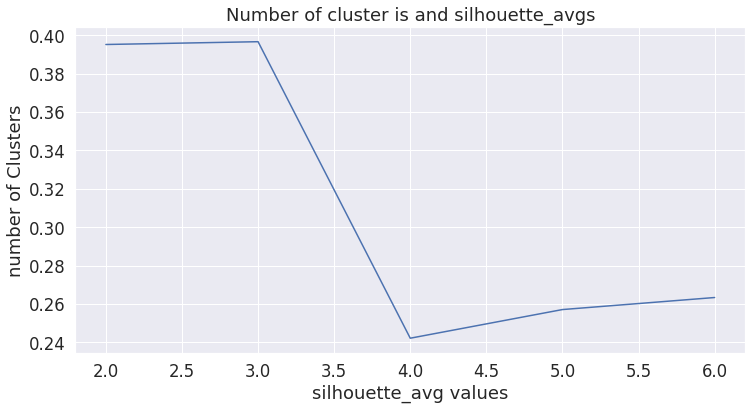

In [57]:
#plot silluheitte function for different clusters
plt.figure()
plt.plot(range_n_clusters, silhouette_avg_list)
# plt.plot(range(2, len(silhouette_avg_list)+2), silhouette_avg_list)

plt.xlabel('silhouette_avg values')
plt.ylabel('number of Clusters')
plt.title('Number of cluster is and silhouette_avgs')
plt.show()

In [59]:
print('Items in each clusters: ', total_dict)
print('Sorted items in each clusters: ', total_clusters_sorted)
print(total_clusters_sorted.values())


Items in each clusters:  {2: {0: ['top', 'officials', 'old', 'call', 'elections', 'held', 'group', 'many', 'severed', '##escu', 'popular', 'uprising', 'swept', 'power', 'went', 'national', 'message', 'like', 'new', 'since', 'president', '##e', 'appear', 'open', 'swirl', 'revolutionary', '##r', 'erase', 'vest', 'among', 'students', 'streets', 'suppressed', 'artists', 'intellectuals', 'used', 'years', 'wary', 'guard', 'flourished', 'mr'], 1: ['confronted', 'growing', 'demands', 'communist', 'party', 'dissolve', 'country', 'order', 'say', 'special', 'congress', 'di', '##sman', '##tle', 'disgrace', '##d', 'even', 'free', 'april', 'late', 'saturday', 'night', 'quickly', 'relationship', 'ce', '##aus', 'dictatorship', 'television', 'announce', 'repeated', 'today', 'rum', '##anian', 'newspapers', 'controlled', 'non', 'leaders', 'leading', 'figures', 'detained', 'nicola', 'overthrow', 'urging', 'dissolution', 'high', 'ranking', 'seeking', 'political', 'profile', 'fe', '##vor', 'eager', '##ness'

In [60]:
# Calculate the Jaccard index
selected_clusters = list()
total_score = dict()
overlaped_clusters = dict()
for ind in range_n_clusters[:-1]:
  clus_1 = total_clusters_sorted[ind].values()
  clus_2 = total_clusters_sorted[ind+1].values()
  score = [[0]*(ind+1)]*ind
  c1 = 1
  tmp_dict= dict()
  tmp_dict_overlap = dict()
  for cl1 in clus_1:
    c2 = 1
    for cl2 in clus_2:
      tmp_dict[(c1,c2)] = jaccard_similarity(cl1, cl2)
      if tmp_dict[(c1,c2)] >= threshold_cluster_overlapping:
        temp_set1 = set(cl1)
        temp_set2 = set(cl2)
        tmp_dict_overlap[(c1,c2), tmp_dict[(c1,c2)]] = temp_set1.intersection(temp_set2)
        selected_clusters.append([ind, c1-1, c2-1]) # it stores the info of selected clusters
      c2 += 1 
    c1 += 1
  total_score[ind] = tmp_dict
  overlaped_clusters[ind] = tmp_dict_overlap
# print(total_score)
for key, value in total_score.items():
  print('\n layer {} and {}'.format(key, key+1))
  for key1, value1 in value.items():
    print('({}, {}) is {}'.format(key1[0], key1[1], value1))


 layer 2 and 3
(1, 1) is 0.30952380952380953
(1, 2) is 0.6829268292682927
(1, 3) is 0.0
(2, 1) is 0.0125
(2, 2) is 0.0
(2, 3) is 0.9850746268656716

 layer 3 and 4
(1, 1) is 0.9333333333333333
(1, 2) is 0.0
(1, 3) is 0.0
(1, 4) is 0.0
(2, 1) is 0.023809523809523808
(2, 2) is 0.75
(2, 3) is 0.0
(2, 4) is 0.12
(3, 1) is 0.0
(3, 2) is 0.0
(3, 3) is 0.6666666666666666
(3, 4) is 0.3055555555555556

 layer 4 and 5
(1, 1) is 0.03333333333333333
(1, 2) is 0.05405405405405406
(1, 3) is 0.0
(1, 4) is 0.0
(1, 5) is 0.5714285714285714
(2, 1) is 0.0
(2, 2) is 0.125
(2, 3) is 0.0
(2, 4) is 0.47619047619047616
(2, 5) is 0.18181818181818182
(3, 1) is 0.1320754716981132
(3, 2) is 0.0
(3, 3) is 0.7872340425531915
(3, 4) is 0.0
(3, 5) is 0.0
(4, 1) is 0.2222222222222222
(4, 2) is 0.4857142857142857
(4, 3) is 0.046153846153846156
(4, 4) is 0.0
(4, 5) is 0.0

 layer 5 and 6
(1, 1) is 0.0
(1, 2) is 0.0
(1, 3) is 0.0
(1, 4) is 0.875
(1, 5) is 0.03571428571428571
(1, 6) is 0.0
(2, 1) is 0.05555555555555555
(

In [73]:
word_list = set()
print('The original dict is {}'.format(overlaped_clusters))
for el in overlaped_clusters:
  print(' the layer {}'.format(el))
  for cl in overlaped_clusters[el]:
    print(overlaped_clusters[el][cl])
    word_list.update(overlaped_clusters[el][cl])
# final_list = stop_word_remover(word_list, stopwords) # the stopwords are removed from the cluster before applying Jaccard Index
print('Final list of words is {}'.format(word_list))

The original dict is {2: {((2, 3), 0.9850746268656716): {'communists', 'dissolve', 'night', 'leading', 'detained', 'non', '##ness', 'even', 'leaders', 'free', '##d', 'congress', 'quickly', 'demands', 'eager', 'land', 'mighty', '##ige', 'saturday', 'newspapers', 'repeated', 'high', 'nicola', '24', 'profile', 'announce', 'growing', 'country', 'special', 'relationship', 'dec', 'figures', 'dissolution', '##imated', '##sman', 'ranking', 'television', 'di', 'confronted', 'april', 'urging', 'late', 'ranks', 'rum', '##vor', 'cry', 'political', 'dictatorship', 'today', 'controlled', 'disgrace', '##s', 'ce', 'freedoms', 'order', 'risen', 'communist', '##anian', 'fe', 'party', 'overthrow', 'seeking', 'say', '##aus', '##tle', 'reflects'}}, 3: {((1, 1), 0.9333333333333333): {'long', 'many', 'intellectuals', 'top', 'among', 'wary', 'went', 'call', 'vest', 'group', 'students', 'streets', 'appear', 'suppressed'}}, 4: {}, 5: {((1, 4), 0.875): {'special', 'dissolve', '##vor', 'long', 'newspapers', 'disg

In [74]:
print(total_clusters_with_similarities)
print(selected_clusters)
cluster_list = list()
for vec in selected_clusters:
  tmp_list = list()
  garbage_list = list()
  min = 1
  max = 0
  for el in total_clusters_with_similarities[vec[0],vec[1]] + total_clusters_with_similarities[vec[0]+1,vec[2]]:
    if el[0] not in stopwords and len(el[0])>2:
      if el[0] not in garbage_list:
        garbage_list.append(el[0])
      else:
        if el[1]>max:
          max = el[1]
        if el[1]< min:
          min = el[1]
        tmp_list.append(el)
  cluster_list.append([max, min, tmp_list])
  
print(cluster_list)

{(2, 0): [('message', 0.9997595603354315), ('mr', 0.9996593788639162), ('like', 0.9996451776250627), ('erase', 0.9995344173441936), ('national', 0.9994942351531413), ('appear', 0.999458200941696), ('swirl', 0.9994514568846555), ('artists', 0.9994245334352143), ('revolutionary', 0.9994111933108698), ('open', 0.9994079034558181), ('elections', 0.9993625904186296), ('##r', 0.9992839666017189), ('popular', 0.999232730706459), ('flourished', 0.9991912621399719), ('guard', 0.9991826809893002), ('##e', 0.9991687789887888), ('since', 0.9991666103621865), ('severed', 0.9991496585170045), ('held', 0.9991492848406206), ('group', 0.9991245207239572), ('streets', 0.9990963015973668), ('new', 0.9990917972525384), ('used', 0.9990849535032229), ('president', 0.9990772440390105), ('call', 0.9989107634326022), ('officials', 0.9989059998547954), ('vest', 0.9988916309289579), ('intellectuals', 0.998802721080981), ('years', 0.9987891806198671), ('swept', 0.9987712196706912), ('##escu', 0.998711863490436), 

In [75]:
test = [0.9825819266584156, 0.40577821379719814, [('party', 0.9825819266584156), ('##s', 0.982141010637889), ('been', 0.9810166043529759), ('land', 0.9805601133499222), ('##sman', 0.9781751472033356), ('freedoms', 0.9772748648464267), ('seeking', 0.9763145100487863), ('urging', 0.9746435605927545), ('years', 0.9746009643723771), ('after', 0.973530972422985), ('are', 0.9720529116828479), ('communists', 0.9690921614798568), ('eager', 0.9683786039699253), ('risen', 0.9675966607368819), ('##aus', 0.9631290844128872), ('high', 0.9631161742863688), ('those', 0.9594043878965094), ('##anian', 0.9578385805511627), ('profile', 0.9561506895082291), ('political', 0.9560653481773054), ('figures', 0.9496140826077256), ('itself', 0.9487595451882704), ('##ness', 0.9443216591277065), ('ranks', 0.9428484761365006), ('once', 0.9403937531168767), ('disgrace', 0.9381102314137233), ('have', 0.9329694816705608), ('country', 0.9262983110299957), ('within', 0.9250182232086733), ('intellectuals', 0.909219201146454), ('like', 0.9091980365524924), ('since', 0.908714334355933), ('wary', 0.8955317389031143), ('detained', 0.8811489793291609), ('message', 0.8755032647684652), ('dec', 0.8738373430789401), ('this', 0.8657763533542258), ('top', 0.8412999755732483), ('open', 0.7557810605008625), ('uprising', 0.7496371898464387), ('##escu', 0.725510582254375), ('flourished', 0.6922523492887434), ('among', 0.6276936069067001), ('president', 0.6098474794942315), ('appear', 0.5694084201742404), ('newspapers', 0.5653333081029144), ('##r', 0.5363174104642561), ('swirl', 0.5219041685041015), ('##vor', 0.5027227695065126), ('national', 0.40577821379719814)]]
print(cluster_list)

cluster_list_ = [normalizer_value(ve) for ve in cluster_list]
print(cluster_list_)

[[0.9999418497730518, 0.9975464386600863, [('urging', 0.9999418497730518), ('leading', 0.999936853122903), ('freedoms', 0.9999160655695103), ('communist', 0.999903871611756), ('country', 0.9999022736542037), ('##aus', 0.9998910326782101), ('reflects', 0.9998738405222122), ('high', 0.9998689660667667), ('mighty', 0.9998644769560812), ('detained', 0.9998523966944893), ('risen', 0.9998513512125103), ('eager', 0.9998480333091468), ('late', 0.9998427271079239), ('today', 0.9998401963114142), ('non', 0.9998299238152374), ('profile', 0.9998170374523069), ('##ness', 0.999815160176882), ('political', 0.9998137572925567), ('congress', 0.9998109760041155), ('land', 0.9998047588947903), ('cry', 0.9998034911380302), ('rum', 0.9997998610946067), ('growing', 0.9997788207557001), ('##sman', 0.9997679078546279), ('##tle', 0.9997675462460835), ('communists', 0.9997506049499568), ('##anian', 0.9997445190113868), ('television', 0.9997377670273617), ('demands', 0.9997194710449605), ('ranking', 0.9997185498

In [86]:
from matplotlib.font_manager import list_fonts
list_word_cloud = list()
for el in cluster_list_:
  # print(el)
  temp_dict = dict()
  for ele in el:
    # print(ele[0])
    temp_dict[ele[0]] = ele[1]
  list_word_cloud.append(temp_dict)


print(list_word_cloud)

[{'urging': 100, 'leading': 99, 'freedoms': 98, 'communist': 98, 'country': 98, '##aus': 97, 'reflects': 97, 'high': 96, 'mighty': 96, 'detained': 96, 'risen': 96, 'eager': 96, 'late': 95, 'today': 95, 'non': 95, 'profile': 94, '##ness': 94, 'political': 94, 'congress': 94, 'land': 94, 'cry': 94, 'rum': 94, 'growing': 93, '##sman': 92, '##tle': 92, 'communists': 92, '##anian': 91, 'television': 91, 'demands': 90, 'ranking': 90, 'april': 90, 'controlled': 90, 'dictatorship': 89, 'leaders': 88, 'order': 88, 'announce': 87, 'saturday': 87, 'confronted': 86, 'seeking': 86, 'figures': 86, 'newspapers': 85, 'dissolution': 85, 'repeated': 85, 'special': 85, 'party': 84, '##d': 82, '##s': 81, 'night': 80, '##vor': 79, 'say': 77, '##ige': 75, 'relationship': 73, 'overthrow': 73, 'dec': 72, 'nicola': 71, 'quickly': 69, 'free': 67, 'disgrace': 66, 'dissolve': 57, 'ranks': 49, 'even': 42, '##imated': 1}, {'streets': 100, 'appear': 93, 'group': 89, 'vest': 88, 'top': 87, 'intellectuals': 71, 'long'

dict_keys(['urging', 'leading', 'freedoms', 'communist', 'country', '##aus', 'reflects', 'high', 'mighty', 'detained', 'risen', 'eager', 'late', 'today', 'non', 'profile', '##ness', 'political', 'congress', 'land', 'cry', 'rum', 'growing', '##sman', '##tle', 'communists', '##anian', 'television', 'demands', 'ranking', 'april', 'controlled', 'dictatorship', 'leaders', 'order', 'announce', 'saturday', 'confronted', 'seeking', 'figures', 'newspapers', 'dissolution', 'repeated', 'special', 'party', '##d', '##s', 'night', '##vor', 'say', '##ige', 'relationship', 'overthrow', 'dec', 'nicola', 'quickly', 'free', 'disgrace', 'dissolve', 'ranks', 'even', '##imated'])


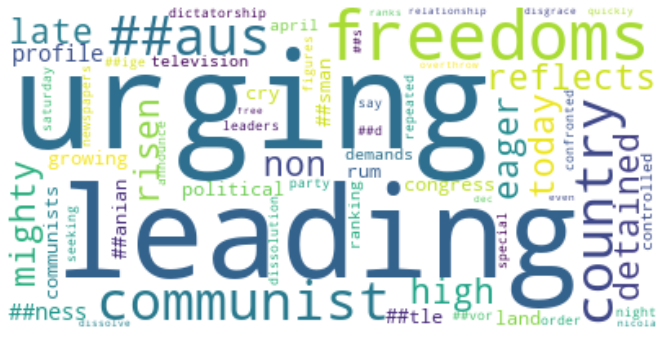

---------------------------------
dict_keys(['streets', 'appear', 'group', 'vest', 'top', 'intellectuals', 'long', 'students', 'among', 'call', 'many', 'suppressed', 'wary', 'went'])


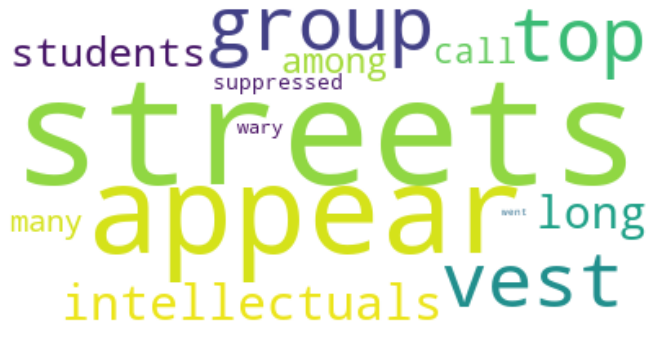

---------------------------------
dict_keys(['##tle', '##d', 'nicola', 'special', '##sman', 'newspapers', 'disgrace', 'free', 'overthrow', 'dissolve', '##vor', 'say', 'long'])


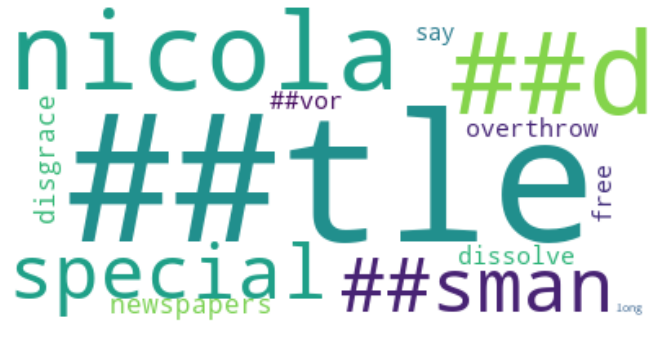

---------------------------------
dict_keys(['figures', 'relationship', 'quickly', '##e', 'repeated', 'popular', 'dissolution', 'order', 'held', 'since', 'elections', 'swirl', '##ige', 'new', 'officials', 'artists', 'intellectuals', 'ranks', '##imated'])


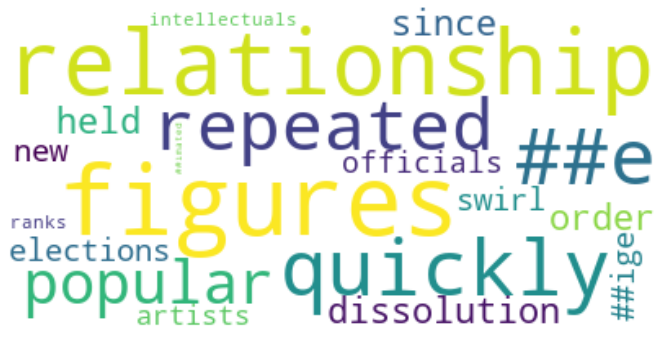

---------------------------------
dict_keys(['leading', 'profile', 'reflects', 'non', 'risen', 'rum', 'late', 'country', '##ness', '##aus', 'eager', 'congress', '##anian', 'communist', 'controlled', 'detained', 'mighty', 'urging', 'political', 'land', 'freedoms', 'saturday', 'demands', 'high', 'today', 'communists', 'dictatorship', 'ranking', 'growing', 'television', 'cry', 'seeking', 'leaders', 'announce', 'night', 'april', 'party', 'confronted', '##s'])


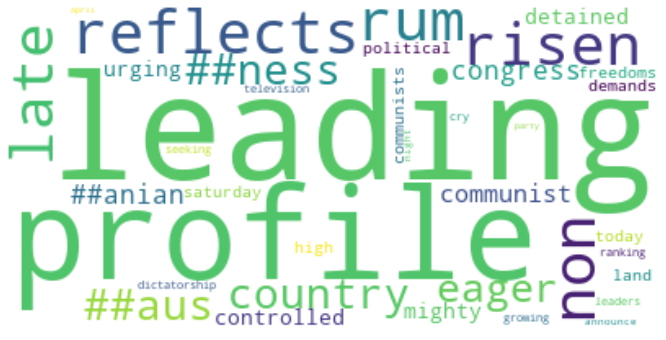

---------------------------------
dict_keys(['severed', 'revolutionary', 'flourished', 'president', 'power', '##escu', 'years', 'swept', 'erase', 'old'])


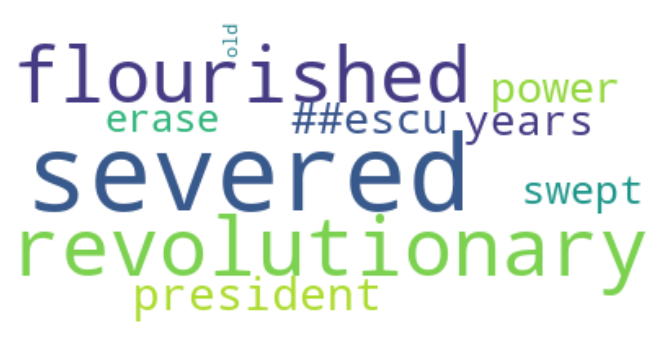

---------------------------------


In [93]:
import pandas as pd
import numpy as np

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
for item in list_word_cloud:
  wordcloud = WordCloud(collocations=True, background_color= 'White').generate_from_frequencies(item)
  
  #plot the wordcloud object
  print(item.keys())
  plt.imshow(wordcloud, interpolation='bilInear')
  plt.axis('off')
  plt.show()
  print('---------------------------------')